# general

In [2]:
import s3fs
import fsspec
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import io
import skimage
from PIL import Image
import scipy
from cellpose import utils, models
import glob
import seaborn as sns
from tqdm import tqdm
import pickle

ModuleNotFoundError: No module named 'boto3'

In [2]:
#cell_labels = np.unique(masks)

def cut_to_label_bounds (masks, label, array_img):
    c_mask = np.where(np.array(masks)==label)
    bounds_0 = min(c_mask[0]), max(c_mask[0])
    bounds_1 = min(c_mask[1]), max(c_mask[1])
    bounds_2 = min(c_mask[2]), max(c_mask[2])

    cell_stack_mask = np.array(masks[:], dtype=float)
    cell_stack_mask[np.where(masks!=label)] = 0
    
    cell_stack_mask = cell_stack_mask[bounds_0[0]:bounds_0[1],bounds_1[0]:bounds_1[1],bounds_2[0]:bounds_2[1]]
    cell_stack_c0 = array_img[0][bounds_0[0]:bounds_0[1],bounds_1[0]:bounds_1[1],bounds_2[0]:bounds_2[1]]
    cell_stack_c1 = array_img[1][bounds_0[0]:bounds_0[1],bounds_1[0]:bounds_1[1],bounds_2[0]:bounds_2[1]]
    #print("post cut")
    #print(np.shape(cell_stack_mask))
    #print(np.shape(cell_stack_c0))
    #print(np.shape(cell_stack_c1))
    return np.array(cell_stack_mask,dtype=float), np.array(cell_stack_c0,dtype=float), np.array(cell_stack_c1, dtype=float)

def nan_mask_inplace (cell_mask, original):
    print(np.shape(original))
    non_mask_pixels = np.where(cell_mask == 0)
    mask_pixels = np.nonzero(cell_mask)
    if not all([x >= 2 for x in np.shape(mask_pixels)]):
        return
    original[non_mask_pixels] = np.nan
    return original

# def simple_transforms ():


def compare_cells_hoechst_v_stain (cell_stack_mask, cell_stack_c0, cell_stack_c1, fn, mip, mip_axis, per_frame, cut_to_mask, norm, flatten, per_frame_aggfunc):
    assert(mip == (mip_axis is not None))
    if mip:
        assert(not per_frame)
        mip_mask = np.max(cell_stack_mask, axis=mip_axis)
        if cut_to_mask:
            mip_c0 = nan_mask_inplace(mip_mask, np.max(cell_stack_c0, axis=mip_axis))
            mip_c1 = nan_mask_inplace(mip_mask, np.max(cell_stack_c1, axis=mip_axis))
        
        if norm: 
            mip_c0 = mip_c0/np.sqrt(np.nansum(np.square(mip_c0)))
            mip_c1 = mip_c1/np.sqrt(np.nansum(np.square(mip_c1)))
        if flatten:
            mip_c0 = np.ravel(mip_c0)
            mip_c1 = np.ravel(mip_c1)
        res = fn(mip_c0, mip_c1)
        return res

    if cut_to_mask:
        nan_mask_inplace(cell_stack_mask, cell_stack_c0)
        nan_mask_inplace(cell_stack_mask, cell_stack_c1)
    if not per_frame:
        if flatten:
            cell_stack_c0 = np.ravel(cell_stack_c0)
            cell_stack_c1 = np.ravel(cell_stack_c1)
        if norm:
            cell_stack_c0 = cell_stack_c0/np.sqrt(np.nansum(np.square(cell_stack_c0)))
            cell_stack_c1 = cell_stack_c1/np.sqrt(np.nansum(np.square(cell_stack_c1)))
        res = fn(cell_stack_c0,cell_stack_c1)
        return res

    assert(per_frame)
    # if per frame and/or not MIP
    c_frames_res = []
    
    for i in tqdm(range(np.shape(cell_stack_mask)[0])):
        mask_slice = cell_stack_mask[i]
        if not all([x >= 2 for x in np.shape(mask_slice[np.logical_not(np.isnan(mask_slice))])]):
            continue
        c0_slice = cell_stack_c0[i]
        c1_slice = cell_stack_c1[i]
        if norm: 
            c0_slice = c0_slice/np.sqrt(np.nansum(np.square(c0_slice)))
            c1_slice = c1_slice/np.sqrt(np.nansum(np.square(c1_slice)))
        if flatten:
            c0_slice = np.ravel(c0_slice)
            c1_slice = np.ravel(c1_slice)
        
        res = fn(c0_slice,c1_slice) 
        c_frames_res.append(res)
    return per_frame_aggfunc(c_frames_res)

def hoechst_v_stain (array_img, masks, fn, cut_to_mask = True, norm=False, flatten = False, mip=False, mip_axis = None, per_frame=True, per_frame_aggfunc = lambda x : x):
    cell_labels = np.unique(masks)
    results = [] 
    for c in tqdm(cell_labels):
        if c == 0:
            continue
        cell_stack_mask, cell_stack_c0, cell_stack_c1 = cut_to_label_bounds(masks, c, array_img)
        res = compare_cells_hoechst_v_stain(cell_stack_mask=cell_stack_mask, cell_stack_c0=cell_stack_c0, cell_stack_c1=cell_stack_c1, fn = fn, mip = mip, mip_axis=mip_axis, per_frame=per_frame, cut_to_mask=cut_to_mask, norm=norm, flatten=flatten, per_frame_aggfunc=per_frame_aggfunc)
        results.append(res)
    return results

# import processed cells

In [3]:
with open("/Users/amulya/Desktop/Buenrostro_Lab/intranuclear-structures/res.pickle", "rb") as input_file:
    res = pickle.load(input_file)
with open("/Users/amulya/Desktop/Buenrostro_Lab/intranuclear-structures/res2.pickle", "rb") as input_file:
    res2 = pickle.load(input_file)
r = res|res2

# load cells from AWS server

In [ ]:
import s3fs
import fsspec
s3 = s3fs.S3FileSystem(anon=True)
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import io
import skimage
from PIL import Image
import scipy
from cellpose import utils, models

def get_stain_img (protein):
    # get path to stain
    propath = [x for x in s3.ls(f"s3://czb-opencell/microscopy/raw/{protein}") if "stack.tif" in x][0]
    s3 = boto3.resource("s3", config=Config(signature_version=UNSIGNED))
    imgs = []
    for f in propath:
        # TODO glob path
        bucket = s3.Bucket('czb-opencell',)
        object = bucket.Object(f.lstrip("s3://czb-opencell/"))
        img_data = object.get().get('Body').read()
        img = Image.open(io.BytesIO(img_data),mode='r',formats=["TIFF"])
        imgs.append(img)
    return imgs # perhaps an array of imgs

def tiff_to_array (img):
    # stain
    c0 = []
    # nucleus stain
    c1 = []
    for i in range(img.n_frames):
        img.seek(i)
        if i % 2 == 0:
            c0.append(np.array(img))
        else:
            c1.append(np.array(img))
    return np.array([c0,c1])

def get_cellpose_masks (array_img, diameter=90, cellprob_threshold=0.4):
    model = models.Cellpose(gpu=False, model_type='cyto')
    masks, flows, styles, diams = model.eval(array_img, do_3D=True, diameter=diameter, cellprob_threshold=cellprob_threshold, channels=[0,None])
    return masks

# brightness range

In [5]:
brightnesses = {}
for k, (v0, v1, _) in r.items():
    print(k)
    brightnesses[k] = hoechst_v_stain(v0, v1, fn = lambda a,_: np.ravel(a), cut_to_mask=False, norm=False,flatten=False,per_frame=False)

POLR2A


100%|██████████| 39/39 [01:21<00:00,  2.08s/it]


POLR2B


100%|██████████| 1807/1807 [48:59<00:00,  1.63s/it] 


POLR2C


100%|██████████| 49/49 [01:11<00:00,  1.47s/it]


POLR2D


100%|██████████| 183/183 [06:03<00:00,  1.98s/it]


POLR2E


100%|██████████| 229/229 [31:39<00:00,  8.30s/it]   


POLR2F


100%|██████████| 411/411 [4:21:16<00:00, 38.14s/it]     


POLR2G


100%|██████████| 92/92 [02:16<00:00,  1.48s/it]


POLR2H


100%|██████████| 54/54 [01:22<00:00,  1.52s/it]


POLR2I


100%|██████████| 47/47 [01:08<00:00,  1.47s/it]


POLR2K


100%|██████████| 58/58 [01:27<00:00,  1.52s/it]


POLR2J


100%|██████████| 59/59 [01:36<00:00,  1.64s/it]


# xcorr surface viz

In [16]:
from mpl_toolkits.mplot3d import Axes3D  

#corrs = {}
def xcorrviz (a, b):
    try:
        xc_notnan = scipy.signal.correlate(a[np.logical_not(np.isnan(a))], b[np.logical_not(np.isnan(b))], mode='full')
    except Exception as e:
        print(e)
        return -1
    a[np.isnan(a)] = 0
    b[np.isnan(b)] = 0
    xc = scipy.signal.correlate(a, b, mode='full')
    if (len(np.shape(xc)) == 2):
        print(np.mean(xc_notnan))
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        X, Y = np.meshgrid(np.arange(np.shape(xc)[0]), np.arange(np.shape(xc)[1]))
        ax.plot_surface(X, Y, xc.T)
        ax.set_zlim(ax.get_zlim()[0],1)
        plt.show()
        plt.clf()
        plt.imshow(a)
        plt.show()
        plt.clf()
        plt.imshow(b)
        plt.show()
        plt.clf()
    return xc

for k, (v0, v1, v2) in r.items():
    print(k)
    hoechst_v_stain(v0, v1, fn = xcorrviz,  norm=True,flatten=False,per_frame=True, per_frame_aggfunc = lambda x : x)

POLR2A
(73, 53, 86)
(3, 133564)


ValueError: operands could not be broadcast together with shapes (3,) (2,) 

# NCC - WITHOUT masking

In [51]:
xcorrs_norm_constrained = {}

"""def xcorr_and_print (a,b):
    xc = scipy.signal.correlate(a,b)
    print(xc)
    return xc"""

for k, (v0, v1, _) in r.items():
    if k == "POLR2B":
        continue
    print(k)
    # print(v1)
    xcorrs_norm_constrained[k] = hoechst_v_stain(v0, v1, fn = lambda a,b: scipy.signal.correlate(a,b), cut_to_mask=False, norm=True,flatten=False,per_frame=False)

POLR2A


100%|██████████| 39/39 [01:04<00:00,  1.65s/it]


POLR2C


100%|██████████| 49/49 [01:14<00:00,  1.52s/it]


POLR2D


100%|██████████| 183/183 [05:30<00:00,  1.80s/it]


POLR2E


100%|██████████| 229/229 [05:28<00:00,  1.44s/it]


POLR2F


100%|██████████| 411/411 [11:42<00:00,  1.71s/it]


POLR2G


100%|██████████| 92/92 [03:50<00:00,  2.51s/it]


POLR2H


100%|██████████| 54/54 [03:14<00:00,  3.60s/it]


POLR2I


100%|██████████| 47/47 [05:12<00:00,  6.65s/it]


POLR2K


100%|██████████| 58/58 [06:37<00:00,  6.85s/it]


POLR2J


100%|██████████| 59/59 [07:46<00:00,  7.91s/it]


In [52]:
import pickle
with open("pol_xcorrs_3dcell_norm.pickle", "wb") as output_file:
    pickle.dump(xcorrs_norm, output_file)

In [5]:
with open("pol_xcorrs_3dcell_norm.pickle", "rb") as input_file:
    xcorrs_norm = pickle.load(input_file)

Text(0.5, 0.98, 'POLR2* vs. Hoechst - max xcorr')

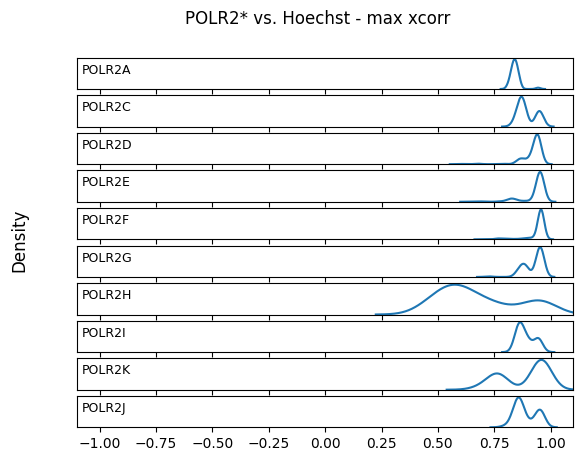

In [6]:
to_plot = {k : [np.max(x) for x in v] for k, v in xcorrs_norm.items()}
fig, axes = plt.subplots(ncols=1, nrows=len(to_plot), sharex=True)

for i in range(len(xcorrs_norm.keys())):
    k = list(to_plot.keys())[i]
    ax_to_use = axes[i]
    sns.kdeplot(x=to_plot[k], ax=ax_to_use, label=k)
    ax_to_use.set_ylabel("")
    ax_to_use.set_yticks([])
    ax_to_use.set_xlim((-1.1,1.1))
    ax_to_use.text(0.01,0.5, k, transform=ax_to_use.transAxes, size=9)

fig.supylabel("Density")
fig.suptitle("POLR2* vs. Hoechst - max xcorr")

## register images

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  

for k, (v0, v1, _) in r.items():
    print(k)
    img = v0
    mask = v1
    xcorrs_norm[k]


    
    hoechst_v_stain(v0, v1, fn = xcorrviz,  norm=True,flatten=False,per_frame=True, per_frame_aggfunc = lambda x : x)
    

In [5]:
def show_mips_rb (c0, c1, title=""):
    plt.imshow(np.max(c0,axis=0), cmap="Reds",alpha=0.5)
    plt.imshow(np.max(c1,axis=0), cmap="Blues",alpha=0.5)
    plt.title(f"{title}x-y MIP - stain overlay")
    plt.show()
    plt.clf()
    plt.imshow(np.max(c0,axis=1), cmap="Reds",alpha=0.5)
    plt.imshow(np.max(c1,axis=1), cmap="Blues",alpha=0.5)
    plt.title(f"{title}y-z MIP - stain overlay")
    plt.show()
    plt.clf()
    plt.imshow(np.max(c0,axis=2), cmap="Reds",alpha=0.5)
    plt.imshow(np.max(c1,axis=2), cmap="Blues",alpha=0.5)
    plt.title(f"{title}x-z MIP - stain overlay")
    plt.show()
    plt.clf()

shifted_imgs = {}

for subunit, (array_img, masks, _) in r.items():
    if subunit == "POLR2B":
        continue
    cell_labels = np.unique(masks)
    results = [] 
    for c in tqdm(cell_labels):
        if c == 0:
            continue
        cell_stack_mask, cell_stack_c0, cell_stack_c1 = cut_to_label_bounds(masks, c, array_img)
        #pos = np.where(cell_labels==c)[0][0]
        #print(pos)
        #shift_array = xcorrs_norm[subunit][pos]
        #optimal_shift = np.ravel(np.where(shift_array==np.max(shift_array)))
        # optimal_shift = np.subtract(optimal_shift, np.shape(cell_stack_c0))
        detected_shift, _, _ = skimage.registration.phase_cross_correlation(cell_stack_c0, cell_stack_c1, normalization=None)
        # c0_shifted = scipy.ndimage.shift(cell_stack_c0,optimal_shift)
        c1_shifted = scipy.ndimage.shift(cell_stack_c1,detected_shift)
        # Each channel
        """plt.imshow(np.max(cell_stack_c0,axis=0))
        plt.title("z MIP - c0")
        plt.show()
        plt.imshow(np.max(c0_shifted,axis=0))
        plt.title("z MIP - c0 shifted")
        plt.show()
        plt.imshow(np.max(cell_stack_c1,axis=0))
        plt.title("z MIP - c1")
        plt.show()
        plt.imshow(np.max(c1_shifted,axis=0))
        plt.title("z MIP - c1 shifted")
        plt.show()"""

        #show_mips_rb(cell_stack_c0, cell_stack_c1)
        #show_mips_rb(cell_stack_c0, c1_shifted, title = "SHIFTED: ")
        if subunit not in shifted_imgs:
            shifted_imgs[subunit] = []
        shifted_imgs[subunit].append((cell_stack_c0, cell_stack_c1, cell_stack_mask, c1_shifted, detected_shift))
        # Stain offset
        """for i in range(np.shape(shifted_image)[0]):
            plt.imshow(shifted_image[i])
            plt.show()"""

        

100%|██████████| 59/59 [02:34<00:00,  2.62s/it]


In [6]:
z_shifts = { subunit : [c[4][0] for c in cells]  for subunit, cells in shifted_imgs.items()}
x_shifts = { subunit : [c[4][1] for c in cells]  for subunit, cells in shifted_imgs.items()}
y_shifts = { subunit : [c[4][2] for c in cells]  for subunit, cells in shifted_imgs.items()}

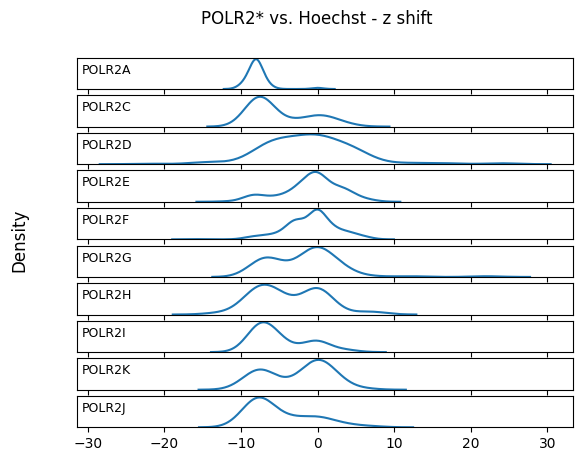

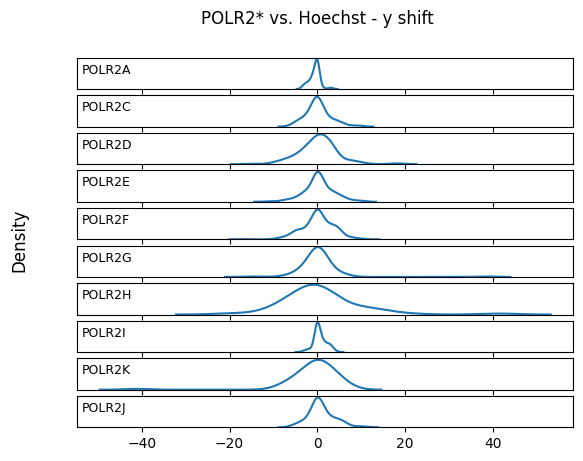

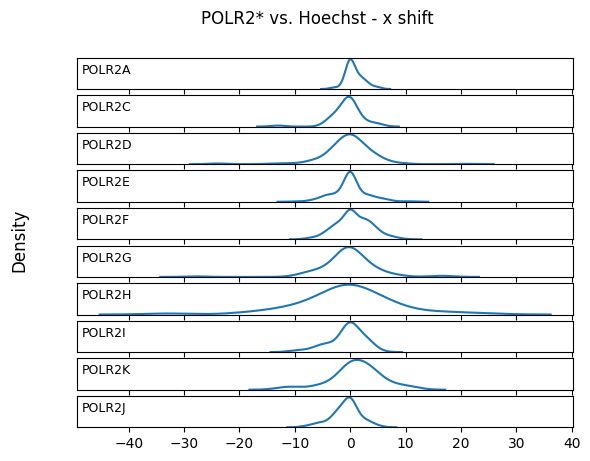

In [11]:

def plot_shifts(shifts, axis):
    fig, axes = plt.subplots(ncols=1, nrows=len(shifts), sharex=True)
    for i in range(len(shifts.keys())):
        k = list(shifts.keys())[i]
        ax_to_use = axes[i]
        sns.kdeplot(x=np.hstack(shifts[k]), ax=ax_to_use, label=str(shifts))
        ax_to_use.set_ylabel("")
        ax_to_use.set_yticks([])
        ax_to_use.text(0.01,0.5, k, transform=ax_to_use.transAxes, size=9)
    fig.supylabel("Density")
    fig.suptitle(f"POLR2* vs. Hoechst - {axis} shift")

plot_shifts(z_shifts, "z")
plot_shifts(y_shifts, "y")
plot_shifts(x_shifts, "x")

In [29]:
def compare_shifted (shifted_imgs, fn, mip = False, mip_axis = None, per_frame = False, cut_to_mask = True, norm = False, flatten = False, per_frame_aggfunc = lambda x : x):
    orig_shifted_res = {}
    for subunit, cells in shifted_imgs.items():
        res = []
        for c in tqdm(cells):
            cell_stack_c0, cell_stack_c1, cell_stack_mask, c1_shifted, detected_shift = c
            res_shifted = compare_cells_hoechst_v_stain (cell_stack_mask=cell_stack_mask, cell_stack_c0=cell_stack_c0, cell_stack_c1=c1_shifted, fn=fn, mip=mip, mip_axis=mip_axis, per_frame=per_frame, cut_to_mask=cut_to_mask, norm=norm, flatten=flatten, per_frame_aggfunc=per_frame_aggfunc)
            res_orig = compare_cells_hoechst_v_stain (cell_stack_mask=cell_stack_mask, cell_stack_c0=cell_stack_c0, cell_stack_c1=cell_stack_c1, fn=fn, mip=mip, mip_axis=mip_axis, per_frame=per_frame, cut_to_mask=cut_to_mask, norm=norm, flatten=flatten, per_frame_aggfunc=per_frame_aggfunc)
            res.append((res_orig, res_shifted))
        orig_shifted_res[subunit] = res
    return orig_shifted_res

In [40]:
def correlate_mask_nans (a,b):
    bad = ~np.logical_or(np.isnan(a), np.isnan(b))
    good_a = np.compress(bad, a)
    good_b = np.compress(bad, b)
    if len(good_a) < 2 or len(good_b) < 2:
        return np.nan, np.nan
    return scipy.stats.pearsonr(good_a, good_b)

corrs_shifted = compare_shifted(shifted_imgs, fn = lambda a,b :correlate_mask_nans(a,b)[0], per_frame=True, flatten=True)

  0%|          | 0/76 [00:00<?, ?it/s]

(73, 53, 86)
(73, 53, 86)


/Users/amulya/anaconda3/envs/cytoself/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 73/73 [00:00<00:00, 554.67it/s]


(73, 53, 86)
(73, 53, 86)


  1%|▏         | 1/76 [00:00<00:29,  2.57it/s]

(63, 74, 77)
(63, 74, 77)


100%|██████████| 63/63 [00:00<00:00, 521.05it/s]


(63, 74, 77)
(63, 74, 77)


  3%|▎         | 2/76 [00:00<00:29,  2.49it/s]

(64, 71, 76)
(64, 71, 76)


100%|██████████| 64/64 [00:00<00:00, 803.72it/s]


(64, 71, 76)
(64, 71, 76)


  4%|▍         | 3/76 [00:01<00:23,  3.17it/s]

(60, 84, 72)
(60, 84, 72)


100%|██████████| 60/60 [00:00<00:00, 1122.15it/s]


(60, 84, 72)
(60, 84, 72)


  5%|▌         | 4/76 [00:01<00:18,  3.79it/s]

(63, 85, 82)
(63, 85, 82)


100%|██████████| 63/63 [00:00<00:00, 804.13it/s]


(63, 85, 82)
(63, 85, 82)


  7%|▋         | 5/76 [00:01<00:19,  3.57it/s]

(62, 68, 67)
(62, 68, 67)


100%|██████████| 62/62 [00:00<00:00, 1052.57it/s]


(62, 68, 67)
(62, 68, 67)


  8%|▊         | 6/76 [00:01<00:17,  4.11it/s]

(63, 87, 83)
(63, 87, 83)


100%|██████████| 63/63 [00:00<00:00, 1060.57it/s]


(63, 87, 83)
(63, 87, 83)


  9%|▉         | 7/76 [00:01<00:16,  4.24it/s]

(60, 64, 69)
(60, 64, 69)


100%|██████████| 60/60 [00:00<00:00, 1078.14it/s]


(60, 64, 69)
(60, 64, 69)


 11%|█         | 8/76 [00:02<00:14,  4.69it/s]

(62, 99, 93)
(62, 99, 93)


100%|██████████| 62/62 [00:00<00:00, 872.68it/s]


(62, 99, 93)
(62, 99, 93)


 12%|█▏        | 9/76 [00:02<00:16,  4.18it/s]

(60, 85, 91)
(60, 85, 91)


100%|██████████| 60/60 [00:00<00:00, 1068.28it/s]


(60, 85, 91)
(60, 85, 91)


 13%|█▎        | 10/76 [00:02<00:15,  4.35it/s]

(59, 73, 73)
(59, 73, 73)


100%|██████████| 59/59 [00:00<00:00, 1082.04it/s]


(59, 73, 73)
(59, 73, 73)


 14%|█▍        | 11/76 [00:02<00:13,  4.74it/s]

(62, 37, 83)
(62, 37, 83)


100%|██████████| 62/62 [00:00<00:00, 1047.40it/s]


(62, 37, 83)
(62, 37, 83)


 16%|█▌        | 12/76 [00:02<00:12,  5.07it/s]

(65, 76, 64)
(65, 76, 64)


100%|██████████| 65/65 [00:00<00:00, 949.23it/s]


(65, 76, 64)
(65, 76, 64)


 17%|█▋        | 13/76 [00:03<00:12,  4.95it/s]

(60, 71, 69)
(60, 71, 69)


100%|██████████| 60/60 [00:00<00:00, 897.95it/s]


(60, 71, 69)
(60, 71, 69)


 18%|█▊        | 14/76 [00:03<00:12,  5.01it/s]

(61, 72, 71)
(61, 72, 71)


100%|██████████| 61/61 [00:00<00:00, 850.34it/s]


(61, 72, 71)
(61, 72, 71)


 20%|█▉        | 15/76 [00:03<00:13,  4.38it/s]

(62, 62, 71)
(62, 62, 71)


100%|██████████| 62/62 [00:00<00:00, 1022.37it/s]


(62, 62, 71)
(62, 62, 71)


 21%|██        | 16/76 [00:03<00:12,  4.64it/s]

(58, 67, 83)
(58, 67, 83)


100%|██████████| 58/58 [00:00<00:00, 1007.08it/s]


(58, 67, 83)
(58, 67, 83)


 22%|██▏       | 17/76 [00:03<00:12,  4.85it/s]

(61, 77, 67)
(61, 77, 67)


100%|██████████| 61/61 [00:00<00:00, 908.24it/s]


(61, 77, 67)
(61, 77, 67)


 24%|██▎       | 18/76 [00:04<00:12,  4.81it/s]

(59, 66, 69)
(59, 66, 69)


100%|██████████| 59/59 [00:00<00:00, 937.33it/s]

(59, 66, 69)


(59, 66, 69)


 25%|██▌       | 19/76 [00:04<00:12,  4.57it/s]

(1, 10, 16)
(1, 10, 16)


100%|██████████| 1/1 [00:00<00:00, 613.56it/s]


(1, 10, 16)
(1, 10, 16)


100%|██████████| 1/1 [00:00<00:00, 649.88it/s]


(55, 96, 74)
(55, 96, 74)


100%|██████████| 55/55 [00:00<00:00, 879.21it/s]


(55, 96, 74)
(55, 96, 74)


 28%|██▊       | 21/76 [00:04<00:09,  5.81it/s]

(57, 87, 69)
(57, 87, 69)


100%|██████████| 57/57 [00:00<00:00, 1221.92it/s]


(57, 87, 69)
(57, 87, 69)


 29%|██▉       | 22/76 [00:04<00:10,  5.17it/s]

(58, 77, 61)
(58, 77, 61)


100%|██████████| 58/58 [00:00<00:00, 896.53it/s]


(58, 77, 61)
(58, 77, 61)


 30%|███       | 23/76 [00:05<00:09,  5.34it/s]

(62, 85, 92)
(62, 85, 92)


100%|██████████| 62/62 [00:00<00:00, 1133.94it/s]


(62, 85, 92)
(62, 85, 92)


 32%|███▏      | 24/76 [00:05<00:10,  5.14it/s]

(56, 92, 89)
(56, 92, 89)


100%|██████████| 56/56 [00:00<00:00, 1046.73it/s]


(56, 92, 89)
(56, 92, 89)


 33%|███▎      | 25/76 [00:05<00:09,  5.11it/s]

(59, 64, 109)
(59, 64, 109)


100%|██████████| 59/59 [00:00<00:00, 1244.88it/s]


(59, 64, 109)
(59, 64, 109)


 34%|███▍      | 26/76 [00:05<00:09,  5.31it/s]

(59, 70, 88)
(59, 70, 88)


100%|██████████| 59/59 [00:00<00:00, 1004.39it/s]


(59, 70, 88)
(59, 70, 88)


 36%|███▌      | 27/76 [00:05<00:09,  5.30it/s]

(60, 41, 70)
(60, 41, 70)


100%|██████████| 60/60 [00:00<00:00, 1123.11it/s]


(60, 41, 70)
(60, 41, 70)


 37%|███▋      | 28/76 [00:06<00:08,  5.68it/s]

(60, 46, 76)
(60, 46, 76)


100%|██████████| 60/60 [00:00<00:00, 1181.29it/s]


(60, 46, 76)
(60, 46, 76)


 38%|███▊      | 29/76 [00:06<00:07,  5.88it/s]

(59, 86, 108)
(59, 86, 108)


100%|██████████| 59/59 [00:00<00:00, 920.41it/s]


(59, 86, 108)
(59, 86, 108)


 39%|███▉      | 30/76 [00:06<00:08,  5.20it/s]

(56, 79, 22)
(56, 79, 22)


100%|██████████| 56/56 [00:00<00:00, 1262.86it/s]


(56, 79, 22)
(56, 79, 22)


 41%|████      | 31/76 [00:06<00:07,  5.85it/s]

(57, 88, 62)
(57, 88, 62)


100%|██████████| 57/57 [00:00<00:00, 1026.25it/s]


(57, 88, 62)
(57, 88, 62)


 42%|████▏     | 32/76 [00:06<00:07,  5.76it/s]

(60, 76, 73)
(60, 76, 73)


100%|██████████| 60/60 [00:00<00:00, 623.43it/s]


(60, 76, 73)
(60, 76, 73)


 43%|████▎     | 33/76 [00:06<00:08,  5.23it/s]

(59, 86, 75)
(59, 86, 75)


100%|██████████| 59/59 [00:00<00:00, 1051.30it/s]


(59, 86, 75)
(59, 86, 75)


 45%|████▍     | 34/76 [00:07<00:08,  5.20it/s]

(56, 31, 59)
(56, 31, 59)


100%|██████████| 56/56 [00:00<00:00, 1070.93it/s]


(56, 31, 59)
(56, 31, 59)


 46%|████▌     | 35/76 [00:07<00:07,  5.66it/s]

(57, 28, 65)
(57, 28, 65)


100%|██████████| 57/57 [00:00<00:00, 1210.62it/s]


(57, 28, 65)
(57, 28, 65)


 47%|████▋     | 36/76 [00:07<00:06,  6.19it/s]

(57, 64, 80)
(57, 64, 80)


100%|██████████| 57/57 [00:00<00:00, 1196.24it/s]


(57, 64, 80)
(57, 64, 80)


 49%|████▊     | 37/76 [00:07<00:06,  6.22it/s]

(53, 13, 52)
(53, 13, 52)


100%|██████████| 53/53 [00:00<00:00, 1280.78it/s]


(53, 13, 52)
(53, 13, 52)


 50%|█████     | 38/76 [00:07<00:05,  6.83it/s]

(73, 53, 86)
(73, 53, 86)


100%|██████████| 73/73 [00:00<00:00, 472.23it/s]

(73, 53, 86)


(73, 53, 86)


 51%|█████▏    | 39/76 [00:08<00:07,  4.91it/s]

(63, 74, 77)
(63, 74, 77)


100%|██████████| 63/63 [00:00<00:00, 1152.37it/s]


(63, 74, 77)
(63, 74, 77)


 53%|█████▎    | 40/76 [00:08<00:07,  4.89it/s]

(64, 71, 76)
(64, 71, 76)


100%|██████████| 64/64 [00:00<00:00, 521.13it/s]


(64, 71, 76)
(64, 71, 76)


 54%|█████▍    | 41/76 [00:08<00:08,  4.30it/s]

(60, 84, 72)
(60, 84, 72)


100%|██████████| 60/60 [00:00<00:00, 1080.68it/s]


(60, 84, 72)
(60, 84, 72)


 55%|█████▌    | 42/76 [00:08<00:07,  4.58it/s]

(63, 85, 82)
(63, 85, 82)


100%|██████████| 63/63 [00:00<00:00, 1072.96it/s]


(63, 85, 82)
(63, 85, 82)


 57%|█████▋    | 43/76 [00:08<00:07,  4.60it/s]

(62, 68, 67)
(62, 68, 67)


100%|██████████| 62/62 [00:00<00:00, 1163.40it/s]


(62, 68, 67)
(62, 68, 67)


 58%|█████▊    | 44/76 [00:09<00:06,  4.85it/s]

(63, 87, 83)
(63, 87, 83)


100%|██████████| 63/63 [00:00<00:00, 584.20it/s]


(63, 87, 83)
(63, 87, 83)


 59%|█████▉    | 45/76 [00:09<00:08,  3.84it/s]

(60, 64, 69)
(60, 64, 69)


100%|██████████| 60/60 [00:00<00:00, 223.03it/s]


(60, 64, 69)
(60, 64, 69)


 61%|██████    | 46/76 [00:10<00:10,  2.84it/s]

(62, 99, 93)
(62, 99, 93)


100%|██████████| 62/62 [00:00<00:00, 235.33it/s]


(62, 99, 93)
(62, 99, 93)


 62%|██████▏   | 47/76 [00:10<00:12,  2.31it/s]

(60, 85, 91)
(60, 85, 91)


100%|██████████| 60/60 [00:00<00:00, 734.00it/s]


(60, 85, 91)
(60, 85, 91)


 63%|██████▎   | 48/76 [00:10<00:10,  2.56it/s]

(59, 73, 73)
(59, 73, 73)


100%|██████████| 59/59 [00:00<00:00, 725.99it/s]


(59, 73, 73)
(59, 73, 73)


 64%|██████▍   | 49/76 [00:11<00:09,  2.92it/s]

(62, 37, 83)
(62, 37, 83)


100%|██████████| 62/62 [00:00<00:00, 896.19it/s]


(62, 37, 83)
(62, 37, 83)


 66%|██████▌   | 50/76 [00:11<00:07,  3.34it/s]

(65, 76, 64)
(65, 76, 64)


100%|██████████| 65/65 [00:00<00:00, 384.05it/s]

(65, 76, 64)
(65, 76, 64)



 67%|██████▋   | 51/76 [00:11<00:07,  3.29it/s]

(60, 71, 69)
(60, 71, 69)


100%|██████████| 60/60 [00:00<00:00, 1105.93it/s]


(60, 71, 69)
(60, 71, 69)


 68%|██████▊   | 52/76 [00:11<00:06,  3.72it/s]

(61, 72, 71)
(61, 72, 71)


100%|██████████| 61/61 [00:00<00:00, 949.22it/s]


(61, 72, 71)
(61, 72, 71)


 70%|██████▉   | 53/76 [00:12<00:05,  3.97it/s]

(62, 62, 71)
(62, 62, 71)


100%|██████████| 62/62 [00:00<00:00, 817.40it/s]


(62, 62, 71)
(62, 62, 71)


 71%|███████   | 54/76 [00:12<00:05,  4.10it/s]

(58, 67, 83)
(58, 67, 83)


100%|██████████| 58/58 [00:00<00:00, 1072.03it/s]


(58, 67, 83)
(58, 67, 83)


 72%|███████▏  | 55/76 [00:12<00:04,  4.38it/s]

(61, 77, 67)
(61, 77, 67)


100%|██████████| 61/61 [00:00<00:00, 678.63it/s]


(61, 77, 67)
(61, 77, 67)


 74%|███████▎  | 56/76 [00:12<00:04,  4.30it/s]

(59, 66, 69)
(59, 66, 69)


100%|██████████| 59/59 [00:00<00:00, 389.80it/s]


(59, 66, 69)
(59, 66, 69)


 75%|███████▌  | 57/76 [00:13<00:04,  4.04it/s]

(1, 10, 16)
(1, 10, 16)


100%|██████████| 1/1 [00:00<00:00, 637.72it/s]


(1, 10, 16)
(1, 10, 16)


100%|██████████| 1/1 [00:00<00:00, 864.98it/s]


(55, 96, 74)
(55, 96, 74)


100%|██████████| 55/55 [00:00<00:00, 707.86it/s]


(55, 96, 74)
(55, 96, 74)


 78%|███████▊  | 59/76 [00:13<00:03,  5.18it/s]

(57, 87, 69)
(57, 87, 69)


100%|██████████| 57/57 [00:00<00:00, 906.79it/s]


(57, 87, 69)
(57, 87, 69)


 79%|███████▉  | 60/76 [00:13<00:03,  5.08it/s]

(58, 77, 61)
(58, 77, 61)


100%|██████████| 58/58 [00:00<00:00, 1095.99it/s]


(58, 77, 61)
(58, 77, 61)


 80%|████████  | 61/76 [00:13<00:02,  5.07it/s]

(62, 85, 92)
(62, 85, 92)


100%|██████████| 62/62 [00:00<00:00, 506.67it/s]

(62, 85, 92)
(62, 85, 92)



 82%|████████▏ | 62/76 [00:14<00:03,  3.87it/s]

(56, 92, 89)
(56, 92, 89)


100%|██████████| 56/56 [00:00<00:00, 333.00it/s]


(56, 92, 89)
(56, 92, 89)


 83%|████████▎ | 63/76 [00:14<00:04,  3.22it/s]

(59, 64, 109)
(59, 64, 109)


100%|██████████| 59/59 [00:00<00:00, 674.65it/s]


(59, 64, 109)
(59, 64, 109)


 84%|████████▍ | 64/76 [00:14<00:03,  3.30it/s]

(59, 70, 88)
(59, 70, 88)


100%|██████████| 59/59 [00:00<00:00, 694.31it/s]


(59, 70, 88)
(59, 70, 88)


 86%|████████▌ | 65/76 [00:15<00:03,  3.45it/s]

(60, 41, 70)
(60, 41, 70)


100%|██████████| 60/60 [00:00<00:00, 613.50it/s]


(60, 41, 70)
(60, 41, 70)


 87%|████████▋ | 66/76 [00:15<00:02,  3.67it/s]

(60, 46, 76)
(60, 46, 76)


100%|██████████| 60/60 [00:00<00:00, 653.39it/s]


(60, 46, 76)
(60, 46, 76)


 88%|████████▊ | 67/76 [00:15<00:02,  3.80it/s]

(59, 86, 108)
(59, 86, 108)


100%|██████████| 59/59 [00:00<00:00, 693.52it/s]


(59, 86, 108)
(59, 86, 108)


 89%|████████▉ | 68/76 [00:15<00:02,  3.61it/s]

(56, 79, 22)
(56, 79, 22)


100%|██████████| 56/56 [00:00<00:00, 664.67it/s]


(56, 79, 22)
(56, 79, 22)


 91%|█████████ | 69/76 [00:16<00:01,  3.53it/s]

(57, 88, 62)
(57, 88, 62)


100%|██████████| 57/57 [00:00<00:00, 487.12it/s]


(57, 88, 62)
(57, 88, 62)


 92%|█████████▏| 70/76 [00:16<00:01,  3.11it/s]

(60, 76, 73)
(60, 76, 73)


100%|██████████| 60/60 [00:00<00:00, 336.62it/s]


(60, 76, 73)
(60, 76, 73)


 93%|█████████▎| 71/76 [00:17<00:01,  2.65it/s]

(59, 86, 75)
(59, 86, 75)


100%|██████████| 59/59 [00:00<00:00, 606.88it/s]


(59, 86, 75)
(59, 86, 75)


 95%|█████████▍| 72/76 [00:17<00:01,  2.70it/s]

(56, 31, 59)
(56, 31, 59)


100%|██████████| 56/56 [00:00<00:00, 843.01it/s]


(56, 31, 59)
(56, 31, 59)


 96%|█████████▌| 73/76 [00:17<00:00,  3.20it/s]

(57, 28, 65)
(57, 28, 65)


100%|██████████| 57/57 [00:00<00:00, 696.02it/s]


(57, 28, 65)
(57, 28, 65)


 97%|█████████▋| 74/76 [00:17<00:00,  3.55it/s]

(57, 64, 80)
(57, 64, 80)


100%|██████████| 57/57 [00:00<00:00, 523.67it/s]


(57, 64, 80)
(57, 64, 80)


 99%|█████████▊| 75/76 [00:18<00:00,  3.04it/s]

(53, 13, 52)
(53, 13, 52)


100%|██████████| 53/53 [00:00<00:00, 752.22it/s]


(53, 13, 52)
(53, 13, 52)


  0%|          | 0/753 [00:00<?, ?it/s]

(59, 86, 87)
(59, 86, 87)


100%|██████████| 59/59 [00:00<00:00, 793.94it/s]


(59, 86, 87)
(59, 86, 87)


  0%|          | 1/753 [00:00<03:26,  3.63it/s]

(62, 133, 113)
(62, 133, 113)


100%|██████████| 62/62 [00:00<00:00, 797.63it/s]

(62, 133, 113)
(62, 133, 113)



  0%|          | 2/753 [00:00<04:26,  2.81it/s]

(66, 134, 116)
(66, 134, 116)


100%|██████████| 66/66 [00:00<00:00, 832.44it/s]


(66, 134, 116)
(66, 134, 116)


  0%|          | 3/753 [00:01<04:28,  2.79it/s]

(56, 109, 73)
(56, 109, 73)


100%|██████████| 56/56 [00:00<00:00, 1060.24it/s]


(56, 109, 73)
(56, 109, 73)


  1%|          | 4/753 [00:01<03:43,  3.35it/s]

(60, 83, 80)
(60, 83, 80)


100%|██████████| 60/60 [00:00<00:00, 1043.99it/s]


(60, 83, 80)
(60, 83, 80)


  1%|          | 5/753 [00:01<03:26,  3.62it/s]

(55, 113, 87)
(55, 113, 87)


100%|██████████| 55/55 [00:00<00:00, 1067.86it/s]


(55, 113, 87)
(55, 113, 87)


  1%|          | 6/753 [00:01<03:09,  3.94it/s]

(60, 88, 84)
(60, 88, 84)


100%|██████████| 60/60 [00:00<00:00, 1176.66it/s]


(60, 88, 84)
(60, 88, 84)


  1%|          | 7/753 [00:01<02:57,  4.21it/s]

(62, 72, 63)
(62, 72, 63)


100%|██████████| 62/62 [00:00<00:00, 1143.02it/s]


(62, 72, 63)
(62, 72, 63)


  1%|          | 8/753 [00:02<02:40,  4.63it/s]

(57, 47, 85)
(57, 47, 85)


100%|██████████| 57/57 [00:00<00:00, 1087.21it/s]


(57, 47, 85)
(57, 47, 85)


  1%|          | 9/753 [00:02<02:26,  5.09it/s]

(56, 118, 84)
(56, 118, 84)


100%|██████████| 56/56 [00:00<00:00, 1109.06it/s]


(56, 118, 84)
(56, 118, 84)


  1%|▏         | 10/753 [00:02<02:29,  4.98it/s]

(59, 88, 86)
(59, 88, 86)


100%|██████████| 59/59 [00:00<00:00, 1063.03it/s]


(59, 88, 86)
(59, 88, 86)


  1%|▏         | 11/753 [00:02<02:39,  4.66it/s]

(61, 87, 74)
(61, 87, 74)


100%|██████████| 61/61 [00:00<00:00, 1137.83it/s]


(61, 87, 74)
(61, 87, 74)


  2%|▏         | 12/753 [00:02<02:37,  4.70it/s]

(66, 90, 69)
(66, 90, 69)


100%|██████████| 66/66 [00:00<00:00, 966.37it/s]


(66, 90, 69)
(66, 90, 69)


  2%|▏         | 13/753 [00:03<02:42,  4.54it/s]

(62, 126, 82)
(62, 126, 82)


100%|██████████| 62/62 [00:00<00:00, 1070.05it/s]


(62, 126, 82)
(62, 126, 82)


  2%|▏         | 14/753 [00:03<02:45,  4.46it/s]

(65, 67, 70)
(65, 67, 70)


100%|██████████| 65/65 [00:00<00:00, 1044.81it/s]


(65, 67, 70)
(65, 67, 70)


  2%|▏         | 15/753 [00:03<02:36,  4.72it/s]

(62, 156, 144)
(62, 156, 144)


100%|██████████| 62/62 [00:00<00:00, 809.84it/s]

(62, 156, 144)


(62, 156, 144)


  2%|▏         | 16/753 [00:04<03:32,  3.47it/s]

(62, 98, 75)
(62, 98, 75)


100%|██████████| 62/62 [00:00<00:00, 475.88it/s]


(62, 98, 75)
(62, 98, 75)


  2%|▏         | 17/753 [00:04<03:30,  3.50it/s]

(59, 79, 89)
(59, 79, 89)


100%|██████████| 59/59 [00:00<00:00, 1113.60it/s]


(59, 79, 89)
(59, 79, 89)


  2%|▏         | 18/753 [00:04<03:09,  3.89it/s]

(66, 118, 75)
(66, 118, 75)


100%|██████████| 66/66 [00:00<00:00, 884.96it/s]


(66, 118, 75)
(66, 118, 75)


  3%|▎         | 19/753 [00:04<03:19,  3.68it/s]

(63, 29, 63)
(63, 29, 63)


100%|██████████| 63/63 [00:00<00:00, 1162.53it/s]


(63, 29, 63)
(63, 29, 63)


  3%|▎         | 20/753 [00:04<02:50,  4.30it/s]

(55, 24, 79)
(55, 24, 79)


100%|██████████| 55/55 [00:00<00:00, 1242.77it/s]

(55, 24, 79)


(55, 24, 79)


  3%|▎         | 21/753 [00:05<02:25,  5.02it/s]

(48, 13, 59)
(48, 13, 59)


100%|██████████| 48/48 [00:00<00:00, 1207.36it/s]


(48, 13, 59)
(48, 13, 59)


100%|██████████| 48/48 [00:00<00:00, 1091.80it/s]


(16, 10, 16)
(16, 10, 16)


100%|██████████| 16/16 [00:00<00:00, 1137.26it/s]


(16, 10, 16)
(16, 10, 16)


  3%|▎         | 23/753 [00:05<01:50,  6.61it/s]

(59, 105, 91)
(59, 105, 91)


100%|██████████| 59/59 [00:00<00:00, 1025.91it/s]


(59, 105, 91)
(59, 105, 91)


  3%|▎         | 24/753 [00:05<02:06,  5.78it/s]

(61, 27, 80)
(61, 27, 80)


100%|██████████| 61/61 [00:00<00:00, 1302.89it/s]


(61, 27, 80)
(61, 27, 80)


  3%|▎         | 25/753 [00:05<01:57,  6.18it/s]

(16, 9, 8)
(16, 9, 8)


100%|██████████| 16/16 [00:00<00:00, 1214.99it/s]


(16, 9, 8)
(16, 9, 8)


100%|██████████| 16/16 [00:00<00:00, 1120.42it/s]


(44, 19, 46)
(44, 19, 46)


100%|██████████| 44/44 [00:00<00:00, 1882.93it/s]


(44, 19, 46)
(44, 19, 46)


100%|██████████| 44/44 [00:00<00:00, 1856.15it/s]


(20, 17, 13)
(20, 17, 13)


100%|██████████| 20/20 [00:00<00:00, 1191.75it/s]


(20, 17, 13)
(20, 17, 13)


  4%|▎         | 28/753 [00:05<01:13,  9.93it/s]

(22, 14, 4)
(22, 14, 4)


100%|██████████| 22/22 [00:00<00:00, 945.67it/s]


(22, 14, 4)
(22, 14, 4)


100%|██████████| 22/22 [00:00<00:00, 1090.02it/s]


(39, 17, 43)
(39, 17, 43)


100%|██████████| 39/39 [00:00<00:00, 1364.83it/s]


(39, 17, 43)
(39, 17, 43)


  4%|▍         | 30/753 [00:05<01:07, 10.69it/s]

(19, 20, 13)
(19, 20, 13)


100%|██████████| 19/19 [00:00<00:00, 1010.80it/s]


(19, 20, 13)
(19, 20, 13)


100%|██████████| 19/19 [00:00<00:00, 953.67it/s]


(20, 16, 9)
(20, 16, 9)


100%|██████████| 20/20 [00:00<00:00, 1177.15it/s]


(20, 16, 9)
(20, 16, 9)


100%|██████████| 20/20 [00:00<00:00, 1159.35it/s]


(12, 22, 24)
(12, 22, 24)


100%|██████████| 12/12 [00:00<00:00, 1073.24it/s]


(12, 22, 24)
(12, 22, 24)


  4%|▍         | 33/753 [00:06<00:53, 13.56it/s]

(16, 12, 13)
(16, 12, 13)


100%|██████████| 16/16 [00:00<00:00, 650.83it/s]


(16, 12, 13)
(16, 12, 13)


100%|██████████| 16/16 [00:00<00:00, 990.48it/s]


(15, 9, 2)
(15, 9, 2)


100%|██████████| 15/15 [00:00<00:00, 1855.07it/s]


(15, 9, 2)
(15, 9, 2)


100%|██████████| 15/15 [00:00<00:00, 2203.89it/s]


(18, 15, 10)
(18, 15, 10)


100%|██████████| 18/18 [00:00<00:00, 864.09it/s]


(18, 15, 10)
(18, 15, 10)


  5%|▍         | 36/753 [00:06<00:44, 15.97it/s]

(12, 7, 12)
(12, 7, 12)


100%|██████████| 12/12 [00:00<00:00, 1024.77it/s]


(12, 7, 12)
(12, 7, 12)


100%|██████████| 12/12 [00:00<00:00, 497.78it/s]


(14, 11, 18)
(14, 11, 18)


100%|██████████| 14/14 [00:00<00:00, 647.04it/s]


(14, 11, 18)
(14, 11, 18)


  5%|▌         | 38/753 [00:06<00:47, 15.18it/s]

(15, 16, 17)
(15, 16, 17)


100%|██████████| 15/15 [00:00<00:00, 535.77it/s]


(15, 16, 17)
(15, 16, 17)


100%|██████████| 15/15 [00:00<00:00, 1018.40it/s]

(26, 11, 9)


(26, 11, 9)


100%|██████████| 26/26 [00:00<00:00, 1508.47it/s]


(26, 11, 9)
(26, 11, 9)


  5%|▌         | 40/753 [00:06<00:45, 15.80it/s]

(59, 23, 27)
(59, 23, 27)


100%|██████████| 59/59 [00:00<00:00, 2055.88it/s]


(59, 23, 27)
(59, 23, 27)


100%|██████████| 59/59 [00:00<00:00, 1850.86it/s]


(23, 16, 12)
(23, 16, 12)


100%|██████████| 23/23 [00:00<00:00, 1131.34it/s]


(23, 16, 12)
(23, 16, 12)


  6%|▌         | 42/753 [00:06<00:44, 15.94it/s]

(15, 4, 5)
(15, 4, 5)


100%|██████████| 15/15 [00:00<00:00, 2069.01it/s]


(15, 4, 5)
(15, 4, 5)


100%|██████████| 15/15 [00:00<00:00, 1746.61it/s]


(16, 18, 18)
(16, 18, 18)


100%|██████████| 16/16 [00:00<00:00, 414.62it/s]


(16, 18, 18)
(16, 18, 18)


  6%|▌         | 44/753 [00:06<00:46, 15.25it/s]

(18, 13, 13)
(18, 13, 13)


100%|██████████| 18/18 [00:00<00:00, 1384.18it/s]


(18, 13, 13)
(18, 13, 13)


100%|██████████| 18/18 [00:00<00:00, 995.47it/s]


(20, 15, 12)
(20, 15, 12)


100%|██████████| 20/20 [00:00<00:00, 2177.22it/s]

(20, 15, 12)


(20, 15, 12)


100%|██████████| 20/20 [00:00<00:00, 888.10it/s]


(17, 24, 25)
(17, 24, 25)


100%|██████████| 17/17 [00:00<00:00, 1049.52it/s]


(17, 24, 25)
(17, 24, 25)


  6%|▌         | 47/753 [00:06<00:40, 17.33it/s]

(15, 11, 18)
(15, 11, 18)


100%|██████████| 15/15 [00:00<00:00, 1293.90it/s]


(15, 11, 18)
(15, 11, 18)


100%|██████████| 15/15 [00:00<00:00, 1184.94it/s]


(19, 25, 15)
(19, 25, 15)


100%|██████████| 19/19 [00:00<00:00, 1294.18it/s]


(19, 25, 15)
(19, 25, 15)


100%|██████████| 19/19 [00:00<00:00, 1205.81it/s]


(24, 33, 17)
(24, 33, 17)


100%|██████████| 24/24 [00:00<00:00, 1248.43it/s]


(24, 33, 17)
(24, 33, 17)


  7%|▋         | 50/753 [00:06<00:37, 18.96it/s]

(16, 26, 35)
(16, 26, 35)


100%|██████████| 16/16 [00:00<00:00, 1014.07it/s]


(16, 26, 35)
(16, 26, 35)


100%|██████████| 16/16 [00:00<00:00, 973.95it/s]


(13, 21, 16)
(13, 21, 16)


100%|██████████| 13/13 [00:00<00:00, 1571.62it/s]


(13, 21, 16)
(13, 21, 16)


100%|██████████| 13/13 [00:00<00:00, 1053.23it/s]


(15, 15, 12)
(15, 15, 12)


100%|██████████| 15/15 [00:00<00:00, 1975.96it/s]


(15, 15, 12)
(15, 15, 12)


  7%|▋         | 53/753 [00:07<00:32, 21.54it/s]

(20, 13, 6)
(20, 13, 6)


100%|██████████| 20/20 [00:00<00:00, 4472.25it/s]


(20, 13, 6)
(20, 13, 6)


100%|██████████| 20/20 [00:00<00:00, 827.51it/s]


(15, 9, 11)
(15, 9, 11)


100%|██████████| 15/15 [00:00<00:00, 775.87it/s]


(15, 9, 11)
(15, 9, 11)


100%|██████████| 15/15 [00:00<00:00, 1015.16it/s]


(18, 18, 16)
(18, 18, 16)


100%|██████████| 18/18 [00:00<00:00, 1280.42it/s]


(18, 18, 16)
(18, 18, 16)


  7%|▋         | 56/753 [00:07<00:34, 20.37it/s]

(19, 11, 4)
(19, 11, 4)


100%|██████████| 19/19 [00:00<00:00, 1181.81it/s]


(19, 11, 4)
(19, 11, 4)


100%|██████████| 19/19 [00:00<00:00, 1084.36it/s]


(13, 17, 21)
(13, 17, 21)


100%|██████████| 13/13 [00:00<00:00, 1896.69it/s]


(13, 17, 21)
(13, 17, 21)


100%|██████████| 13/13 [00:00<00:00, 1161.96it/s]


(16, 16, 18)
(16, 16, 18)


100%|██████████| 16/16 [00:00<00:00, 2082.25it/s]


(16, 16, 18)
(16, 16, 18)


  8%|▊         | 59/753 [00:07<00:30, 22.39it/s]

(45, 77, 21)
(45, 77, 21)


100%|██████████| 45/45 [00:00<00:00, 1261.14it/s]


(45, 77, 21)
(45, 77, 21)


100%|██████████| 45/45 [00:00<00:00, 1146.38it/s]


(12, 15, 12)
(12, 15, 12)


100%|██████████| 12/12 [00:00<00:00, 1439.73it/s]


(12, 15, 12)
(12, 15, 12)


100%|██████████| 12/12 [00:00<00:00, 1202.41it/s]


(11, 15, 19)
(11, 15, 19)


100%|██████████| 11/11 [00:00<00:00, 1368.13it/s]


(11, 15, 19)
(11, 15, 19)


  8%|▊         | 62/753 [00:07<00:31, 21.75it/s]

(11, 19, 19)
(11, 19, 19)


100%|██████████| 11/11 [00:00<00:00, 1140.83it/s]


(11, 19, 19)
(11, 19, 19)


100%|██████████| 11/11 [00:00<00:00, 1144.85it/s]


(11, 14, 15)
(11, 14, 15)


100%|██████████| 11/11 [00:00<00:00, 1618.12it/s]


(11, 14, 15)
(11, 14, 15)


100%|██████████| 11/11 [00:00<00:00, 999.81it/s]


(11, 22, 21)
(11, 22, 21)


100%|██████████| 11/11 [00:00<00:00, 1015.30it/s]


(11, 22, 21)
(11, 22, 21)


100%|██████████| 11/11 [00:00<00:00, 1021.37it/s]


(21, 15, 13)
(21, 15, 13)


100%|██████████| 21/21 [00:00<00:00, 1152.07it/s]


(21, 15, 13)
(21, 15, 13)


  9%|▉         | 66/753 [00:07<00:28, 24.35it/s]

(11, 21, 17)
(11, 21, 17)


100%|██████████| 11/11 [00:00<00:00, 1188.13it/s]


(11, 21, 17)
(11, 21, 17)


100%|██████████| 11/11 [00:00<00:00, 1178.48it/s]


(15, 9, 8)
(15, 9, 8)


100%|██████████| 15/15 [00:00<00:00, 700.35it/s]


(15, 9, 8)
(15, 9, 8)


100%|██████████| 15/15 [00:00<00:00, 612.95it/s]


(18, 19, 18)
(18, 19, 18)


100%|██████████| 18/18 [00:00<00:00, 1057.21it/s]


(18, 19, 18)
(18, 19, 18)


  9%|▉         | 69/753 [00:07<00:30, 22.46it/s]

(11, 12, 10)
(11, 12, 10)


100%|██████████| 11/11 [00:00<00:00, 3536.78it/s]


(11, 12, 10)
(11, 12, 10)


100%|██████████| 11/11 [00:00<00:00, 1572.13it/s]


(11, 23, 20)
(11, 23, 20)


100%|██████████| 11/11 [00:00<00:00, 996.21it/s]


(11, 23, 20)
(11, 23, 20)


100%|██████████| 11/11 [00:00<00:00, 1029.94it/s]

(11, 14, 23)


(11, 14, 23)


100%|██████████| 11/11 [00:00<00:00, 1357.50it/s]


(11, 14, 23)
(11, 14, 23)


100%|██████████| 11/11 [00:00<00:00, 1095.48it/s]


(10, 10, 8)
(10, 10, 8)


100%|██████████| 10/10 [00:00<00:00, 6332.94it/s]


(10, 10, 8)
(10, 10, 8)


100%|██████████| 10/10 [00:00<00:00, 6133.82it/s]


(18, 18, 25)
(18, 18, 25)


100%|██████████| 18/18 [00:00<00:00, 1032.95it/s]


(18, 18, 25)
(18, 18, 25)


 10%|▉         | 74/753 [00:07<00:25, 26.93it/s]

(13, 16, 7)
(13, 16, 7)


100%|██████████| 13/13 [00:00<00:00, 1197.61it/s]


(13, 16, 7)
(13, 16, 7)


100%|██████████| 13/13 [00:00<00:00, 1221.21it/s]


(10, 12, 8)
(10, 12, 8)


100%|██████████| 10/10 [00:00<00:00, 4388.27it/s]


(10, 12, 8)
(10, 12, 8)


100%|██████████| 10/10 [00:00<00:00, 1826.39it/s]


(10, 20, 22)
(10, 20, 22)


100%|██████████| 10/10 [00:00<00:00, 1341.70it/s]


(10, 20, 22)
(10, 20, 22)


100%|██████████| 10/10 [00:00<00:00, 1118.30it/s]


(11, 19, 15)
(11, 19, 15)


100%|██████████| 11/11 [00:00<00:00, 1188.28it/s]


(11, 19, 15)
(11, 19, 15)


100%|██████████| 11/11 [00:00<00:00, 1005.30it/s]


(11, 12, 14)
(11, 12, 14)


100%|██████████| 11/11 [00:00<00:00, 1186.75it/s]


(11, 12, 14)
(11, 12, 14)


 10%|█         | 79/753 [00:08<00:22, 30.59it/s]

(11, 11, 18)
(11, 11, 18)


100%|██████████| 11/11 [00:00<00:00, 1545.12it/s]


(11, 11, 18)
(11, 11, 18)


100%|██████████| 11/11 [00:00<00:00, 1125.80it/s]


(21, 16, 26)
(21, 16, 26)


100%|██████████| 21/21 [00:00<00:00, 1262.48it/s]


(21, 16, 26)
(21, 16, 26)


100%|██████████| 21/21 [00:00<00:00, 625.30it/s]


(9, 8, 12)
(9, 8, 12)


100%|██████████| 9/9 [00:00<00:00, 614.41it/s]


(9, 8, 12)
(9, 8, 12)


100%|██████████| 9/9 [00:00<00:00, 999.12it/s]


(11, 9, 16)
(11, 9, 16)


100%|██████████| 11/11 [00:00<00:00, 1233.45it/s]


(11, 9, 16)
(11, 9, 16)


 11%|█         | 83/753 [00:08<00:24, 27.72it/s]

(10, 7, 12)
(10, 7, 12)


100%|██████████| 10/10 [00:00<00:00, 6005.59it/s]


(10, 7, 12)
(10, 7, 12)


100%|██████████| 10/10 [00:00<00:00, 3112.43it/s]


(20, 16, 26)
(20, 16, 26)


100%|██████████| 20/20 [00:00<00:00, 1525.06it/s]


(20, 16, 26)
(20, 16, 26)


100%|██████████| 20/20 [00:00<00:00, 739.98it/s]


(14, 8, 8)
(14, 8, 8)


100%|██████████| 14/14 [00:00<00:00, 5359.64it/s]


(14, 8, 8)
(14, 8, 8)


100%|██████████| 14/14 [00:00<00:00, 1125.32it/s]


(9, 6, 14)
(9, 6, 14)


100%|██████████| 9/9 [00:00<00:00, 1305.10it/s]


(9, 6, 14)
(9, 6, 14)


 12%|█▏        | 87/753 [00:08<00:22, 29.95it/s]

(9, 9, 16)
(9, 9, 16)


100%|██████████| 9/9 [00:00<00:00, 1018.89it/s]


(9, 9, 16)
(9, 9, 16)


100%|██████████| 9/9 [00:00<00:00, 872.18it/s]


(11, 17, 19)
(11, 17, 19)


100%|██████████| 11/11 [00:00<00:00, 1558.06it/s]


(11, 17, 19)
(11, 17, 19)


100%|██████████| 11/11 [00:00<00:00, 1090.07it/s]


(10, 8, 22)
(10, 8, 22)


100%|██████████| 10/10 [00:00<00:00, 1255.44it/s]


(10, 8, 22)
(10, 8, 22)


100%|██████████| 10/10 [00:00<00:00, 1092.10it/s]


(10, 5, 13)
(10, 5, 13)


100%|██████████| 10/10 [00:00<00:00, 1728.33it/s]


(10, 5, 13)
(10, 5, 13)


100%|██████████| 10/10 [00:00<00:00, 1076.65it/s]


(10, 5, 18)
(10, 5, 18)


100%|██████████| 10/10 [00:00<00:00, 1545.32it/s]


(10, 5, 18)
(10, 5, 18)


 12%|█▏        | 92/753 [00:08<00:20, 32.87it/s]

(10, 6, 19)
(10, 6, 19)


100%|██████████| 10/10 [00:00<00:00, 1747.63it/s]


(10, 6, 19)
(10, 6, 19)


100%|██████████| 10/10 [00:00<00:00, 1036.91it/s]


(10, 6, 20)
(10, 6, 20)


100%|██████████| 10/10 [00:00<00:00, 2058.45it/s]


(10, 6, 20)
(10, 6, 20)


100%|██████████| 10/10 [00:00<00:00, 1544.92it/s]


(10, 4, 21)
(10, 4, 21)


100%|██████████| 10/10 [00:00<00:00, 1289.64it/s]


(10, 4, 21)
(10, 4, 21)


100%|██████████| 10/10 [00:00<00:00, 1026.41it/s]


(9, 6, 22)
(9, 6, 22)


100%|██████████| 9/9 [00:00<00:00, 1739.81it/s]


(9, 6, 22)
(9, 6, 22)


100%|██████████| 9/9 [00:00<00:00, 1083.80it/s]


(23, 20, 24)
(23, 20, 24)


100%|██████████| 23/23 [00:00<00:00, 596.64it/s]


(23, 20, 24)
(23, 20, 24)


 13%|█▎        | 97/753 [00:08<00:21, 30.10it/s]

(10, 4, 19)
(10, 4, 19)


100%|██████████| 10/10 [00:00<00:00, 1326.64it/s]


(10, 4, 19)
(10, 4, 19)


100%|██████████| 10/10 [00:00<00:00, 918.94it/s]


(9, 4, 11)
(9, 4, 11)


100%|██████████| 9/9 [00:00<00:00, 1435.42it/s]


(9, 4, 11)
(9, 4, 11)


100%|██████████| 9/9 [00:00<00:00, 1938.72it/s]


(10, 5, 17)
(10, 5, 17)


100%|██████████| 10/10 [00:00<00:00, 1351.87it/s]


(10, 5, 17)
(10, 5, 17)


100%|██████████| 10/10 [00:00<00:00, 767.05it/s]


(10, 7, 19)
(10, 7, 19)


100%|██████████| 10/10 [00:00<00:00, 1399.59it/s]


(10, 7, 19)
(10, 7, 19)


 13%|█▎        | 101/753 [00:08<00:20, 32.26it/s]

(10, 6, 18)
(10, 6, 18)


100%|██████████| 10/10 [00:00<00:00, 1503.60it/s]


(10, 6, 18)
(10, 6, 18)


100%|██████████| 10/10 [00:00<00:00, 996.53it/s]


(24, 31, 29)
(24, 31, 29)


100%|██████████| 24/24 [00:00<00:00, 1020.33it/s]


(24, 31, 29)
(24, 31, 29)


100%|██████████| 24/24 [00:00<00:00, 962.47it/s]


(10, 9, 18)
(10, 9, 18)


100%|██████████| 10/10 [00:00<00:00, 1453.08it/s]


(10, 9, 18)
(10, 9, 18)


100%|██████████| 10/10 [00:00<00:00, 989.01it/s]


(25, 24, 29)
(25, 24, 29)


100%|██████████| 25/25 [00:00<00:00, 1077.58it/s]


(25, 24, 29)
(25, 24, 29)


 14%|█▍        | 105/753 [00:08<00:22, 29.02it/s]

(11, 8, 20)
(11, 8, 20)


100%|██████████| 11/11 [00:00<00:00, 1380.41it/s]


(11, 8, 20)
(11, 8, 20)


100%|██████████| 11/11 [00:00<00:00, 1082.25it/s]


(23, 35, 25)
(23, 35, 25)


100%|██████████| 23/23 [00:00<00:00, 702.64it/s]


(23, 35, 25)
(23, 35, 25)


100%|██████████| 23/23 [00:00<00:00, 618.08it/s]


(11, 13, 19)
(11, 13, 19)


100%|██████████| 11/11 [00:00<00:00, 1680.96it/s]


(11, 13, 19)
(11, 13, 19)


100%|██████████| 11/11 [00:00<00:00, 1017.74it/s]


(10, 6, 16)
(10, 6, 16)


100%|██████████| 10/10 [00:00<00:00, 1427.95it/s]


(10, 6, 16)
(10, 6, 16)


 14%|█▍        | 109/753 [00:09<00:24, 26.53it/s]

(10, 8, 18)
(10, 8, 18)


100%|██████████| 10/10 [00:00<00:00, 1420.02it/s]

(10, 8, 18)
(10, 8, 18)



100%|██████████| 10/10 [00:00<00:00, 582.10it/s]


(10, 3, 18)
(10, 3, 18)


100%|██████████| 10/10 [00:00<00:00, 1067.47it/s]


(10, 3, 18)
(10, 3, 18)


100%|██████████| 10/10 [00:00<00:00, 921.04it/s]


(10, 5, 19)
(10, 5, 19)


100%|██████████| 10/10 [00:00<00:00, 1359.80it/s]


(10, 5, 19)
(10, 5, 19)


 15%|█▍        | 112/753 [00:09<00:25, 24.79it/s]

(9, 4, 11)
(9, 4, 11)


100%|██████████| 9/9 [00:00<00:00, 1974.93it/s]

(9, 4, 11)


(9, 4, 11)


100%|██████████| 9/9 [00:00<00:00, 1274.09it/s]


(10, 12, 16)
(10, 12, 16)


100%|██████████| 10/10 [00:00<00:00, 1117.44it/s]


(10, 12, 16)
(10, 12, 16)


100%|██████████| 10/10 [00:00<00:00, 1051.20it/s]


(10, 3, 12)
(10, 3, 12)


100%|██████████| 10/10 [00:00<00:00, 1410.47it/s]


(10, 3, 12)
(10, 3, 12)


100%|██████████| 10/10 [00:00<00:00, 865.97it/s]


(17, 15, 7)
(17, 15, 7)


100%|██████████| 17/17 [00:00<00:00, 2337.43it/s]


(17, 15, 7)
(17, 15, 7)


100%|██████████| 17/17 [00:00<00:00, 2763.90it/s]


(14, 16, 15)
(14, 16, 15)


100%|██████████| 14/14 [00:00<00:00, 968.66it/s]


(14, 16, 15)
(14, 16, 15)


 16%|█▌        | 117/753 [00:09<00:22, 28.17it/s]

(14, 12, 8)
(14, 12, 8)


100%|██████████| 14/14 [00:00<00:00, 11146.59it/s]


(14, 12, 8)
(14, 12, 8)


100%|██████████| 14/14 [00:00<00:00, 3472.31it/s]


(16, 21, 16)
(16, 21, 16)


100%|██████████| 16/16 [00:00<00:00, 1816.95it/s]


(16, 21, 16)
(16, 21, 16)


100%|██████████| 16/16 [00:00<00:00, 1057.63it/s]


(14, 14, 11)
(14, 14, 11)


100%|██████████| 14/14 [00:00<00:00, 1209.90it/s]


(14, 14, 11)
(14, 14, 11)


100%|██████████| 14/14 [00:00<00:00, 1076.59it/s]


(15, 14, 9)
(15, 14, 9)


100%|██████████| 15/15 [00:00<00:00, 1430.49it/s]


(15, 14, 9)
(15, 14, 9)


 16%|█▌        | 121/753 [00:09<00:20, 30.27it/s]

(14, 16, 14)
(14, 16, 14)


100%|██████████| 14/14 [00:00<00:00, 482.61it/s]


(14, 16, 14)
(14, 16, 14)


100%|██████████| 14/14 [00:00<00:00, 535.21it/s]


(14, 21, 15)
(14, 21, 15)


100%|██████████| 14/14 [00:00<00:00, 1060.45it/s]


(14, 21, 15)
(14, 21, 15)


100%|██████████| 14/14 [00:00<00:00, 969.86it/s]


(13, 23, 16)
(13, 23, 16)


100%|██████████| 13/13 [00:00<00:00, 1188.65it/s]


(13, 23, 16)
(13, 23, 16)


100%|██████████| 13/13 [00:00<00:00, 1103.56it/s]


(15, 26, 23)
(15, 26, 23)


100%|██████████| 15/15 [00:00<00:00, 1394.20it/s]


(15, 26, 23)
(15, 26, 23)


 17%|█▋        | 125/753 [00:09<00:24, 25.80it/s]

(14, 22, 23)
(14, 22, 23)


100%|██████████| 14/14 [00:00<00:00, 1501.34it/s]


(14, 22, 23)
(14, 22, 23)


100%|██████████| 14/14 [00:00<00:00, 1005.38it/s]


(13, 32, 23)
(13, 32, 23)


100%|██████████| 13/13 [00:00<00:00, 864.87it/s]


(13, 32, 23)
(13, 32, 23)


100%|██████████| 13/13 [00:00<00:00, 917.25it/s]


(41, 25, 44)
(41, 25, 44)


100%|██████████| 41/41 [00:00<00:00, 1343.33it/s]


(41, 25, 44)
(41, 25, 44)


 17%|█▋        | 128/753 [00:09<00:25, 24.34it/s]

(19, 9, 14)
(19, 9, 14)


100%|██████████| 19/19 [00:00<00:00, 2129.60it/s]


(19, 9, 14)
(19, 9, 14)


100%|██████████| 19/19 [00:00<00:00, 1130.14it/s]


(17, 21, 22)
(17, 21, 22)


100%|██████████| 17/17 [00:00<00:00, 1168.64it/s]


(17, 21, 22)
(17, 21, 22)


100%|██████████| 17/17 [00:00<00:00, 1103.32it/s]


(17, 21, 22)
(17, 21, 22)


100%|██████████| 17/17 [00:00<00:00, 1526.05it/s]


(17, 21, 22)
(17, 21, 22)


 17%|█▋        | 131/753 [00:09<00:25, 24.67it/s]

(15, 25, 24)
(15, 25, 24)


100%|██████████| 15/15 [00:00<00:00, 886.68it/s]


(15, 25, 24)
(15, 25, 24)


100%|██████████| 15/15 [00:00<00:00, 1009.64it/s]


(16, 21, 20)
(16, 21, 20)


100%|██████████| 16/16 [00:00<00:00, 950.16it/s]


(16, 21, 20)
(16, 21, 20)


100%|██████████| 16/16 [00:00<00:00, 855.81it/s]


(17, 22, 15)
(17, 22, 15)


100%|██████████| 17/17 [00:00<00:00, 583.77it/s]

(17, 22, 15)


(17, 22, 15)


 18%|█▊        | 134/753 [00:10<00:31, 19.78it/s]

(17, 17, 11)
(17, 17, 11)


100%|██████████| 17/17 [00:00<00:00, 1155.19it/s]


(17, 17, 11)
(17, 17, 11)


100%|██████████| 17/17 [00:00<00:00, 705.80it/s]


(17, 13, 18)
(17, 13, 18)


100%|██████████| 17/17 [00:00<00:00, 897.19it/s]


(17, 13, 18)
(17, 13, 18)


100%|██████████| 17/17 [00:00<00:00, 701.78it/s]


(14, 8, 9)
(14, 8, 9)


100%|██████████| 14/14 [00:00<00:00, 778.72it/s]


(14, 8, 9)
(14, 8, 9)


 18%|█▊        | 137/753 [00:10<00:32, 19.14it/s]

(14, 10, 10)
(14, 10, 10)


100%|██████████| 14/14 [00:00<00:00, 771.73it/s]


(14, 10, 10)
(14, 10, 10)


100%|██████████| 14/14 [00:00<00:00, 543.02it/s]


(14, 13, 17)
(14, 13, 17)


100%|██████████| 14/14 [00:00<00:00, 515.69it/s]


(14, 13, 17)
(14, 13, 17)


100%|██████████| 14/14 [00:00<00:00, 671.23it/s]


(14, 9, 4)
(14, 9, 4)


100%|██████████| 14/14 [00:00<00:00, 653.32it/s]


(14, 9, 4)
(14, 9, 4)


 19%|█▊        | 140/753 [00:10<00:32, 18.78it/s]

(14, 13, 18)
(14, 13, 18)


100%|██████████| 14/14 [00:00<00:00, 844.40it/s]


(14, 13, 18)
(14, 13, 18)


100%|██████████| 14/14 [00:00<00:00, 708.10it/s]


(14, 9, 4)
(14, 9, 4)


100%|██████████| 14/14 [00:00<00:00, 504.25it/s]


(14, 9, 4)
(14, 9, 4)


 19%|█▉        | 142/753 [00:10<00:33, 17.99it/s]

(13, 6, 13)
(13, 6, 13)


100%|██████████| 13/13 [00:00<00:00, 1316.29it/s]


(13, 6, 13)
(13, 6, 13)


100%|██████████| 13/13 [00:00<00:00, 938.34it/s]


(14, 13, 20)
(14, 13, 20)


100%|██████████| 14/14 [00:00<00:00, 2909.39it/s]


(14, 13, 20)
(14, 13, 20)


100%|██████████| 14/14 [00:00<00:00, 1051.13it/s]


(15, 21, 33)
(15, 21, 33)


100%|██████████| 15/15 [00:00<00:00, 363.17it/s]


(15, 21, 33)
(15, 21, 33)


 19%|█▉        | 145/753 [00:10<00:35, 17.35it/s]

(15, 11, 7)
(15, 11, 7)


100%|██████████| 15/15 [00:00<00:00, 966.43it/s]


(15, 11, 7)
(15, 11, 7)


100%|██████████| 15/15 [00:00<00:00, 1241.11it/s]


(12, 5, 7)
(12, 5, 7)


100%|██████████| 12/12 [00:00<00:00, 5919.98it/s]


(12, 5, 7)
(12, 5, 7)


100%|██████████| 12/12 [00:00<00:00, 7291.27it/s]


(13, 11, 18)
(13, 11, 18)


100%|██████████| 13/13 [00:00<00:00, 1592.74it/s]


(13, 11, 18)
(13, 11, 18)


100%|██████████| 13/13 [00:00<00:00, 737.10it/s]


(14, 10, 18)
(14, 10, 18)


100%|██████████| 14/14 [00:00<00:00, 797.68it/s]


(14, 10, 18)
(14, 10, 18)


 20%|█▉        | 149/753 [00:10<00:30, 20.03it/s]

(14, 11, 19)
(14, 11, 19)


100%|██████████| 14/14 [00:00<00:00, 844.19it/s]


(14, 11, 19)
(14, 11, 19)


100%|██████████| 14/14 [00:00<00:00, 721.32it/s]


(14, 17, 20)
(14, 17, 20)


100%|██████████| 14/14 [00:00<00:00, 867.37it/s]


(14, 17, 20)
(14, 17, 20)


100%|██████████| 14/14 [00:00<00:00, 834.66it/s]


(13, 10, 17)
(13, 10, 17)


100%|██████████| 13/13 [00:00<00:00, 1304.32it/s]


(13, 10, 17)
(13, 10, 17)


 20%|██        | 152/753 [00:11<00:29, 20.27it/s]

(14, 13, 18)
(14, 13, 18)


100%|██████████| 14/14 [00:00<00:00, 791.94it/s]


(14, 13, 18)
(14, 13, 18)


100%|██████████| 14/14 [00:00<00:00, 657.71it/s]


(13, 11, 17)
(13, 11, 17)


100%|██████████| 13/13 [00:00<00:00, 582.41it/s]


(13, 11, 17)
(13, 11, 17)


100%|██████████| 13/13 [00:00<00:00, 552.00it/s]


(14, 16, 18)
(14, 16, 18)


100%|██████████| 14/14 [00:00<00:00, 687.59it/s]


(14, 16, 18)
(14, 16, 18)


 21%|██        | 155/753 [00:11<00:34, 17.36it/s]

(14, 8, 6)
(14, 8, 6)


100%|██████████| 14/14 [00:00<00:00, 196.44it/s]


(14, 8, 6)
(14, 8, 6)


100%|██████████| 14/14 [00:00<00:00, 684.66it/s]


(14, 16, 16)
(14, 16, 16)


100%|██████████| 14/14 [00:00<00:00, 770.41it/s]


(14, 16, 16)
(14, 16, 16)


 21%|██        | 157/753 [00:11<00:38, 15.40it/s]

(14, 14, 19)
(14, 14, 19)


100%|██████████| 14/14 [00:00<00:00, 907.20it/s]


(14, 14, 19)
(14, 14, 19)


100%|██████████| 14/14 [00:00<00:00, 860.48it/s]


(14, 13, 20)
(14, 13, 20)


100%|██████████| 14/14 [00:00<00:00, 816.48it/s]


(14, 13, 20)
(14, 13, 20)


100%|██████████| 14/14 [00:00<00:00, 733.55it/s]


(16, 14, 18)
(16, 14, 18)


100%|██████████| 16/16 [00:00<00:00, 692.62it/s]


(16, 14, 18)
(16, 14, 18)


 21%|██        | 160/753 [00:11<00:36, 16.37it/s]

(14, 11, 18)
(14, 11, 18)


100%|██████████| 14/14 [00:00<00:00, 547.67it/s]


(14, 11, 18)
(14, 11, 18)


100%|██████████| 14/14 [00:00<00:00, 509.87it/s]


(15, 17, 21)
(15, 17, 21)


100%|██████████| 15/15 [00:00<00:00, 745.82it/s]


(15, 17, 21)
(15, 17, 21)


 22%|██▏       | 162/753 [00:11<00:36, 16.18it/s]

(14, 16, 13)
(14, 16, 13)


100%|██████████| 14/14 [00:00<00:00, 630.32it/s]


(14, 16, 13)
(14, 16, 13)


100%|██████████| 14/14 [00:00<00:00, 620.08it/s]


(16, 17, 21)
(16, 17, 21)


100%|██████████| 16/16 [00:00<00:00, 565.47it/s]


(16, 17, 21)
(16, 17, 21)


 22%|██▏       | 164/753 [00:11<00:37, 15.63it/s]

(14, 15, 13)
(14, 15, 13)


100%|██████████| 14/14 [00:00<00:00, 775.15it/s]


(14, 15, 13)
(14, 15, 13)


100%|██████████| 14/14 [00:00<00:00, 801.70it/s]


(14, 9, 5)
(14, 9, 5)


100%|██████████| 14/14 [00:00<00:00, 1881.46it/s]


(14, 9, 5)
(14, 9, 5)


100%|██████████| 14/14 [00:00<00:00, 1196.27it/s]


(14, 16, 15)
(14, 16, 15)


100%|██████████| 14/14 [00:00<00:00, 353.58it/s]


(14, 16, 15)
(14, 16, 15)


 22%|██▏       | 167/753 [00:12<00:36, 15.89it/s]

(14, 13, 9)
(14, 13, 9)


100%|██████████| 14/14 [00:00<00:00, 1219.76it/s]


(14, 13, 9)
(14, 13, 9)


100%|██████████| 14/14 [00:00<00:00, 533.17it/s]


(15, 21, 14)
(15, 21, 14)


100%|██████████| 15/15 [00:00<00:00, 623.18it/s]


(15, 21, 14)
(15, 21, 14)


 22%|██▏       | 169/753 [00:12<00:36, 16.20it/s]

(16, 15, 14)
(16, 15, 14)


100%|██████████| 16/16 [00:00<00:00, 742.35it/s]


(16, 15, 14)
(16, 15, 14)


100%|██████████| 16/16 [00:00<00:00, 684.29it/s]

(16, 16, 9)


(16, 16, 9)


100%|██████████| 16/16 [00:00<00:00, 973.66it/s]


(16, 16, 9)
(16, 16, 9)


 23%|██▎       | 171/753 [00:12<00:35, 16.21it/s]

(15, 18, 14)
(15, 18, 14)


100%|██████████| 15/15 [00:00<00:00, 959.88it/s]


(15, 18, 14)
(15, 18, 14)


100%|██████████| 15/15 [00:00<00:00, 999.74it/s]


(14, 16, 12)
(14, 16, 12)


100%|██████████| 14/14 [00:00<00:00, 888.10it/s]


(14, 16, 12)
(14, 16, 12)


100%|██████████| 14/14 [00:00<00:00, 870.43it/s]


(13, 13, 9)
(13, 13, 9)


100%|██████████| 13/13 [00:00<00:00, 1002.02it/s]


(13, 13, 9)
(13, 13, 9)


 23%|██▎       | 174/753 [00:12<00:31, 18.58it/s]

(14, 15, 15)
(14, 15, 15)


100%|██████████| 14/14 [00:00<00:00, 743.90it/s]


(14, 15, 15)
(14, 15, 15)


100%|██████████| 14/14 [00:00<00:00, 386.89it/s]


(14, 15, 13)
(14, 15, 13)


100%|██████████| 14/14 [00:00<00:00, 1036.20it/s]


(14, 15, 13)
(14, 15, 13)


 23%|██▎       | 176/753 [00:12<00:32, 17.91it/s]

(15, 13, 4)
(15, 13, 4)


100%|██████████| 15/15 [00:00<00:00, 5119.58it/s]


(15, 13, 4)
(15, 13, 4)


100%|██████████| 15/15 [00:00<00:00, 3417.04it/s]


(13, 14, 13)
(13, 14, 13)


100%|██████████| 13/13 [00:00<00:00, 1034.14it/s]


(13, 14, 13)
(13, 14, 13)


100%|██████████| 13/13 [00:00<00:00, 866.43it/s]


(15, 16, 14)
(15, 16, 14)


100%|██████████| 15/15 [00:00<00:00, 1040.51it/s]


(15, 16, 14)
(15, 16, 14)


 24%|██▍       | 179/753 [00:12<00:31, 18.35it/s]

(14, 14, 14)
(14, 14, 14)


100%|██████████| 14/14 [00:00<00:00, 489.33it/s]

(14, 14, 14)


(14, 14, 14)


100%|██████████| 14/14 [00:00<00:00, 667.72it/s]


(11, 13, 7)
(11, 13, 7)


100%|██████████| 11/11 [00:00<00:00, 664.70it/s]


(11, 13, 7)
(11, 13, 7)


 24%|██▍       | 181/753 [00:12<00:31, 17.99it/s]

(14, 10, 13)
(14, 10, 13)


100%|██████████| 14/14 [00:00<00:00, 1020.87it/s]


(14, 10, 13)
(14, 10, 13)


100%|██████████| 14/14 [00:00<00:00, 888.77it/s]


(11, 9, 8)
(11, 9, 8)


100%|██████████| 11/11 [00:00<00:00, 864.84it/s]


(11, 9, 8)
(11, 9, 8)


100%|██████████| 11/11 [00:00<00:00, 805.86it/s]


(16, 13, 17)
(16, 13, 17)


100%|██████████| 16/16 [00:00<00:00, 944.68it/s]


(16, 13, 17)
(16, 13, 17)


 24%|██▍       | 184/753 [00:13<00:28, 19.76it/s]

(14, 19, 13)
(14, 19, 13)


100%|██████████| 14/14 [00:00<00:00, 969.40it/s]


(14, 19, 13)
(14, 19, 13)


100%|██████████| 14/14 [00:00<00:00, 916.30it/s]


(15, 12, 19)
(15, 12, 19)


100%|██████████| 15/15 [00:00<00:00, 842.27it/s]


(15, 12, 19)
(15, 12, 19)


100%|██████████| 15/15 [00:00<00:00, 969.38it/s]


(11, 9, 17)
(11, 9, 17)


100%|██████████| 11/11 [00:00<00:00, 1220.60it/s]


(11, 9, 17)
(11, 9, 17)


 25%|██▍       | 187/753 [00:13<00:26, 21.52it/s]

(15, 11, 8)
(15, 11, 8)


100%|██████████| 15/15 [00:00<00:00, 1010.24it/s]


(15, 11, 8)
(15, 11, 8)


100%|██████████| 15/15 [00:00<00:00, 983.93it/s]


(15, 11, 18)
(15, 11, 18)


100%|██████████| 15/15 [00:00<00:00, 331.82it/s]


(15, 11, 18)
(15, 11, 18)


100%|██████████| 15/15 [00:00<00:00, 1001.60it/s]


(16, 10, 9)
(16, 10, 9)


100%|██████████| 16/16 [00:00<00:00, 695.05it/s]


(16, 10, 9)
(16, 10, 9)


 25%|██▌       | 190/753 [00:13<00:31, 17.60it/s]

(21, 10, 21)
(21, 10, 21)


100%|██████████| 21/21 [00:00<00:00, 942.43it/s]


(21, 10, 21)
(21, 10, 21)


100%|██████████| 21/21 [00:00<00:00, 955.63it/s]


(13, 11, 13)
(13, 11, 13)


100%|██████████| 13/13 [00:00<00:00, 1070.50it/s]


(13, 11, 13)
(13, 11, 13)


 25%|██▌       | 192/753 [00:13<00:31, 18.09it/s]

(15, 9, 14)
(15, 9, 14)


100%|██████████| 15/15 [00:00<00:00, 1562.01it/s]


(15, 9, 14)
(15, 9, 14)


100%|██████████| 15/15 [00:00<00:00, 946.18it/s]


(15, 13, 19)
(15, 13, 19)


100%|██████████| 15/15 [00:00<00:00, 771.65it/s]


(15, 13, 19)
(15, 13, 19)


100%|██████████| 15/15 [00:00<00:00, 1015.98it/s]


(16, 18, 21)
(16, 18, 21)


100%|██████████| 16/16 [00:00<00:00, 1083.57it/s]


(16, 18, 21)
(16, 18, 21)


 26%|██▌       | 195/753 [00:13<00:28, 19.39it/s]

(10, 5, 19)
(10, 5, 19)


100%|██████████| 10/10 [00:00<00:00, 1130.45it/s]


(10, 5, 19)
(10, 5, 19)


100%|██████████| 10/10 [00:00<00:00, 630.71it/s]


(12, 11, 14)
(12, 11, 14)


100%|██████████| 12/12 [00:00<00:00, 966.73it/s]


(12, 11, 14)
(12, 11, 14)


100%|██████████| 12/12 [00:00<00:00, 657.61it/s]


(18, 16, 15)
(18, 16, 15)


100%|██████████| 18/18 [00:00<00:00, 982.90it/s]


(18, 16, 15)
(18, 16, 15)


 26%|██▋       | 198/753 [00:13<00:31, 17.72it/s]

(17, 12, 18)
(17, 12, 18)


100%|██████████| 17/17 [00:00<00:00, 940.48it/s]


(17, 12, 18)
(17, 12, 18)


100%|██████████| 17/17 [00:00<00:00, 1076.78it/s]


(24, 6, 9)
(24, 6, 9)


100%|██████████| 24/24 [00:00<00:00, 6779.59it/s]


(24, 6, 9)
(24, 6, 9)


100%|██████████| 24/24 [00:00<00:00, 5617.68it/s]


(15, 17, 13)
(15, 17, 13)


100%|██████████| 15/15 [00:00<00:00, 1885.14it/s]


(15, 17, 13)
(15, 17, 13)


 27%|██▋       | 201/753 [00:13<00:29, 19.02it/s]

(11, 11, 15)
(11, 11, 15)


100%|██████████| 11/11 [00:00<00:00, 1834.85it/s]


(11, 11, 15)
(11, 11, 15)


100%|██████████| 11/11 [00:00<00:00, 1201.37it/s]


(45, 73, 29)
(45, 73, 29)


100%|██████████| 45/45 [00:00<00:00, 760.15it/s]


(45, 73, 29)
(45, 73, 29)


 27%|██▋       | 203/753 [00:14<00:31, 17.29it/s]

(12, 11, 12)
(12, 11, 12)


100%|██████████| 12/12 [00:00<00:00, 1569.24it/s]


(12, 11, 12)
(12, 11, 12)


100%|██████████| 12/12 [00:00<00:00, 1074.96it/s]


(12, 8, 8)
(12, 8, 8)


100%|██████████| 12/12 [00:00<00:00, 913.10it/s]


(12, 8, 8)
(12, 8, 8)


100%|██████████| 12/12 [00:00<00:00, 1209.08it/s]


(45, 31, 22)
(45, 31, 22)


100%|██████████| 45/45 [00:00<00:00, 1387.22it/s]


(45, 31, 22)
(45, 31, 22)


 27%|██▋       | 206/753 [00:14<00:29, 18.30it/s]

(18, 20, 14)
(18, 20, 14)


100%|██████████| 18/18 [00:00<00:00, 1295.89it/s]


(18, 20, 14)
(18, 20, 14)


100%|██████████| 18/18 [00:00<00:00, 1145.25it/s]


(12, 12, 15)
(12, 12, 15)


100%|██████████| 12/12 [00:00<00:00, 1033.67it/s]


(12, 12, 15)
(12, 12, 15)


100%|██████████| 12/12 [00:00<00:00, 1142.78it/s]


(14, 16, 16)
(14, 16, 16)


100%|██████████| 14/14 [00:00<00:00, 435.46it/s]


(14, 16, 16)
(14, 16, 16)


 28%|██▊       | 209/753 [00:14<00:30, 17.84it/s]

(17, 10, 8)
(17, 10, 8)


100%|██████████| 17/17 [00:00<00:00, 1976.74it/s]


(17, 10, 8)
(17, 10, 8)


100%|██████████| 17/17 [00:00<00:00, 861.24it/s]


(19, 15, 14)
(19, 15, 14)


100%|██████████| 19/19 [00:00<00:00, 1119.42it/s]


(19, 15, 14)
(19, 15, 14)


100%|██████████| 19/19 [00:00<00:00, 936.88it/s]


(12, 2, 2)
(12, 2, 2)


100%|██████████| 12/12 [00:00<00:00, 32535.00it/s]


(12, 2, 2)
(12, 2, 2)


100%|██████████| 12/12 [00:00<00:00, 25254.21it/s]


(13, 18, 17)
(13, 18, 17)


100%|██████████| 13/13 [00:00<00:00, 1730.05it/s]


(13, 18, 17)
(13, 18, 17)


 28%|██▊       | 213/753 [00:14<00:25, 21.17it/s]

(9, 14, 16)
(9, 14, 16)


100%|██████████| 9/9 [00:00<00:00, 1122.64it/s]


(9, 14, 16)
(9, 14, 16)


100%|██████████| 9/9 [00:00<00:00, 1013.14it/s]

(10, 12, 17)


(10, 12, 17)


100%|██████████| 10/10 [00:00<00:00, 1041.16it/s]


(10, 12, 17)
(10, 12, 17)


100%|██████████| 10/10 [00:00<00:00, 946.62it/s]


(15, 12, 15)
(15, 12, 15)


100%|██████████| 15/15 [00:00<00:00, 939.91it/s]


(15, 12, 15)
(15, 12, 15)


 29%|██▊       | 216/753 [00:14<00:23, 22.80it/s]

(7, 10, 9)
(7, 10, 9)


100%|██████████| 7/7 [00:00<00:00, 1239.77it/s]


(7, 10, 9)
(7, 10, 9)


100%|██████████| 7/7 [00:00<00:00, 723.19it/s]


(10, 5, 6)
(10, 5, 6)


100%|██████████| 10/10 [00:00<00:00, 2432.47it/s]


(10, 5, 6)
(10, 5, 6)


100%|██████████| 10/10 [00:00<00:00, 996.82it/s]


(11, 11, 10)
(11, 11, 10)


100%|██████████| 11/11 [00:00<00:00, 1396.28it/s]


(11, 11, 10)
(11, 11, 10)


100%|██████████| 11/11 [00:00<00:00, 964.91it/s]


(10, 8, 7)
(10, 8, 7)


100%|██████████| 10/10 [00:00<00:00, 1359.62it/s]


(10, 8, 7)
(10, 8, 7)


 29%|██▉       | 220/753 [00:14<00:20, 25.98it/s]

(12, 11, 16)
(12, 11, 16)


100%|██████████| 12/12 [00:00<00:00, 1548.95it/s]


(12, 11, 16)
(12, 11, 16)


100%|██████████| 12/12 [00:00<00:00, 943.69it/s]


(10, 7, 12)
(10, 7, 12)


100%|██████████| 10/10 [00:00<00:00, 445.73it/s]


(10, 7, 12)
(10, 7, 12)


100%|██████████| 10/10 [00:00<00:00, 961.56it/s]


(12, 4, 9)
(12, 4, 9)


100%|██████████| 12/12 [00:00<00:00, 1464.49it/s]


(12, 4, 9)
(12, 4, 9)


 30%|██▉       | 223/753 [00:14<00:23, 22.27it/s]

(7, 15, 15)
(7, 15, 15)


100%|██████████| 7/7 [00:00<00:00, 1074.75it/s]


(7, 15, 15)
(7, 15, 15)


100%|██████████| 7/7 [00:00<00:00, 942.99it/s]


(7, 12, 8)
(7, 12, 8)


100%|██████████| 7/7 [00:00<00:00, 1179.03it/s]


(7, 12, 8)
(7, 12, 8)


100%|██████████| 7/7 [00:00<00:00, 1162.78it/s]


(20, 33, 20)
(20, 33, 20)


100%|██████████| 20/20 [00:00<00:00, 1061.34it/s]


(20, 33, 20)
(20, 33, 20)


 30%|███       | 226/753 [00:15<00:22, 23.77it/s]

(11, 11, 15)
(11, 11, 15)


100%|██████████| 11/11 [00:00<00:00, 1321.19it/s]


(11, 11, 15)
(11, 11, 15)


100%|██████████| 11/11 [00:00<00:00, 968.40it/s]


(16, 28, 21)
(16, 28, 21)


100%|██████████| 16/16 [00:00<00:00, 925.45it/s]


(16, 28, 21)
(16, 28, 21)


100%|██████████| 16/16 [00:00<00:00, 330.24it/s]


(13, 12, 14)
(13, 12, 14)


100%|██████████| 13/13 [00:00<00:00, 1503.09it/s]


(13, 12, 14)
(13, 12, 14)


 30%|███       | 229/753 [00:15<00:23, 22.49it/s]

(25, 37, 22)
(25, 37, 22)


100%|██████████| 25/25 [00:00<00:00, 880.25it/s]


(25, 37, 22)
(25, 37, 22)


100%|██████████| 25/25 [00:00<00:00, 776.30it/s]


(21, 28, 19)
(21, 28, 19)


100%|██████████| 21/21 [00:00<00:00, 1079.24it/s]


(21, 28, 19)
(21, 28, 19)


100%|██████████| 21/21 [00:00<00:00, 1104.61it/s]


(13, 17, 16)
(13, 17, 16)


100%|██████████| 13/13 [00:00<00:00, 1776.67it/s]


(13, 17, 16)
(13, 17, 16)


 31%|███       | 232/753 [00:15<00:27, 19.16it/s]

(12, 3, 5)
(12, 3, 5)


100%|██████████| 12/12 [00:00<00:00, 973.46it/s]


(12, 3, 5)
(12, 3, 5)


100%|██████████| 12/12 [00:00<00:00, 1899.95it/s]


(10, 9, 6)
(10, 9, 6)


100%|██████████| 10/10 [00:00<00:00, 1108.64it/s]


(10, 9, 6)
(10, 9, 6)


100%|██████████| 10/10 [00:00<00:00, 875.42it/s]


(19, 7, 6)
(19, 7, 6)


100%|██████████| 19/19 [00:00<00:00, 9254.65it/s]


(19, 7, 6)
(19, 7, 6)


100%|██████████| 19/19 [00:00<00:00, 8664.98it/s]


(15, 15, 9)
(15, 15, 9)


100%|██████████| 15/15 [00:00<00:00, 1812.94it/s]


(15, 15, 9)
(15, 15, 9)


 31%|███▏      | 236/753 [00:15<00:22, 23.19it/s]

(14, 4, 2)
(14, 4, 2)


100%|██████████| 14/14 [00:00<00:00, 2767.47it/s]


(14, 4, 2)
(14, 4, 2)


100%|██████████| 14/14 [00:00<00:00, 1796.77it/s]


(12, 9, 15)
(12, 9, 15)


100%|██████████| 12/12 [00:00<00:00, 1030.06it/s]


(12, 9, 15)
(12, 9, 15)


100%|██████████| 12/12 [00:00<00:00, 1027.91it/s]


(15, 17, 18)
(15, 17, 18)


100%|██████████| 15/15 [00:00<00:00, 1005.09it/s]


(15, 17, 18)
(15, 17, 18)


100%|██████████| 15/15 [00:00<00:00, 1035.39it/s]


(13, 14, 13)
(13, 14, 13)


100%|██████████| 13/13 [00:00<00:00, 1881.89it/s]


(13, 14, 13)
(13, 14, 13)


 32%|███▏      | 240/753 [00:15<00:20, 25.63it/s]

(12, 15, 9)
(12, 15, 9)


100%|██████████| 12/12 [00:00<00:00, 1130.39it/s]


(12, 15, 9)
(12, 15, 9)


100%|██████████| 12/12 [00:00<00:00, 1026.95it/s]


(11, 12, 15)
(11, 12, 15)


100%|██████████| 11/11 [00:00<00:00, 2152.33it/s]


(11, 12, 15)
(11, 12, 15)


100%|██████████| 11/11 [00:00<00:00, 1042.13it/s]


(12, 16, 11)
(12, 16, 11)


100%|██████████| 12/12 [00:00<00:00, 874.19it/s]


(12, 16, 11)
(12, 16, 11)


 32%|███▏      | 243/753 [00:15<00:19, 25.70it/s]

(12, 16, 14)
(12, 16, 14)


100%|██████████| 12/12 [00:00<00:00, 454.93it/s]


(12, 16, 14)
(12, 16, 14)


100%|██████████| 12/12 [00:00<00:00, 745.94it/s]


(12, 13, 16)
(12, 13, 16)


100%|██████████| 12/12 [00:00<00:00, 1402.00it/s]


(12, 13, 16)
(12, 13, 16)


100%|██████████| 12/12 [00:00<00:00, 857.69it/s]


(13, 21, 15)
(13, 21, 15)


100%|██████████| 13/13 [00:00<00:00, 1772.34it/s]


(13, 21, 15)
(13, 21, 15)


 33%|███▎      | 246/753 [00:15<00:23, 21.42it/s]

(13, 9, 16)
(13, 9, 16)


100%|██████████| 13/13 [00:00<00:00, 1274.12it/s]


(13, 9, 16)
(13, 9, 16)


100%|██████████| 13/13 [00:00<00:00, 814.99it/s]


(13, 20, 15)
(13, 20, 15)


100%|██████████| 13/13 [00:00<00:00, 1385.63it/s]


(13, 20, 15)
(13, 20, 15)


100%|██████████| 13/13 [00:00<00:00, 899.90it/s]


(12, 29, 21)
(12, 29, 21)


100%|██████████| 12/12 [00:00<00:00, 576.31it/s]


(12, 29, 21)
(12, 29, 21)


 33%|███▎      | 249/753 [00:16<00:22, 22.10it/s]

(12, 35, 23)
(12, 35, 23)


100%|██████████| 12/12 [00:00<00:00, 1090.73it/s]


(12, 35, 23)
(12, 35, 23)


100%|██████████| 12/12 [00:00<00:00, 743.73it/s]


(16, 18, 9)
(16, 18, 9)


100%|██████████| 16/16 [00:00<00:00, 1440.04it/s]


(16, 18, 9)
(16, 18, 9)


100%|██████████| 16/16 [00:00<00:00, 1065.81it/s]

(13, 17, 19)


(13, 17, 19)


100%|██████████| 13/13 [00:00<00:00, 1249.76it/s]


(13, 17, 19)
(13, 17, 19)


 33%|███▎      | 252/753 [00:16<00:21, 23.22it/s]

(14, 17, 15)
(14, 17, 15)


100%|██████████| 14/14 [00:00<00:00, 1627.73it/s]


(14, 17, 15)
(14, 17, 15)


100%|██████████| 14/14 [00:00<00:00, 834.83it/s]


(16, 19, 21)
(16, 19, 21)


100%|██████████| 16/16 [00:00<00:00, 919.49it/s]


(16, 19, 21)
(16, 19, 21)


100%|██████████| 16/16 [00:00<00:00, 350.55it/s]


(19, 39, 21)
(19, 39, 21)


100%|██████████| 19/19 [00:00<00:00, 910.26it/s]


(19, 39, 21)
(19, 39, 21)


 34%|███▍      | 255/753 [00:16<00:27, 17.91it/s]

(14, 18, 13)
(14, 18, 13)


100%|██████████| 14/14 [00:00<00:00, 1044.53it/s]


(14, 18, 13)
(14, 18, 13)


100%|██████████| 14/14 [00:00<00:00, 519.23it/s]


(22, 18, 7)
(22, 18, 7)


100%|██████████| 22/22 [00:00<00:00, 1054.25it/s]


(22, 18, 7)
(22, 18, 7)


100%|██████████| 22/22 [00:00<00:00, 1092.41it/s]


(14, 21, 21)
(14, 21, 21)


100%|██████████| 14/14 [00:00<00:00, 906.85it/s]


(14, 21, 21)
(14, 21, 21)


 34%|███▍      | 258/753 [00:16<00:27, 18.21it/s]

(18, 23, 16)
(18, 23, 16)


100%|██████████| 18/18 [00:00<00:00, 4640.00it/s]


(18, 23, 16)
(18, 23, 16)


100%|██████████| 18/18 [00:00<00:00, 1575.36it/s]


(23, 29, 18)
(23, 29, 18)


100%|██████████| 23/23 [00:00<00:00, 981.39it/s]


(23, 29, 18)
(23, 29, 18)


100%|██████████| 23/23 [00:00<00:00, 393.72it/s]


(18, 22, 14)
(18, 22, 14)


100%|██████████| 18/18 [00:00<00:00, 430.77it/s]


(18, 22, 14)
(18, 22, 14)


 35%|███▍      | 261/753 [00:16<00:32, 15.30it/s]

(14, 22, 23)
(14, 22, 23)


100%|██████████| 14/14 [00:00<00:00, 2583.04it/s]


(14, 22, 23)
(14, 22, 23)


100%|██████████| 14/14 [00:00<00:00, 683.36it/s]


(17, 31, 35)
(17, 31, 35)


100%|██████████| 17/17 [00:00<00:00, 663.78it/s]


(17, 31, 35)
(17, 31, 35)


 35%|███▍      | 263/753 [00:17<00:30, 15.91it/s]

(13, 19, 21)
(13, 19, 21)


100%|██████████| 13/13 [00:00<00:00, 1597.03it/s]


(13, 19, 21)
(13, 19, 21)


100%|██████████| 13/13 [00:00<00:00, 896.62it/s]


(19, 31, 23)
(19, 31, 23)


100%|██████████| 19/19 [00:00<00:00, 939.23it/s]


(19, 31, 23)
(19, 31, 23)


100%|██████████| 19/19 [00:00<00:00, 759.78it/s]


(16, 15, 15)
(16, 15, 15)


100%|██████████| 16/16 [00:00<00:00, 1097.32it/s]


(16, 15, 15)
(16, 15, 15)


 35%|███▌      | 266/753 [00:17<00:28, 16.87it/s]

(39, 45, 23)
(39, 45, 23)


100%|██████████| 39/39 [00:00<00:00, 1014.54it/s]


(39, 45, 23)
(39, 45, 23)


100%|██████████| 39/39 [00:00<00:00, 747.10it/s]


(12, 20, 19)
(12, 20, 19)


100%|██████████| 12/12 [00:00<00:00, 1684.68it/s]


(12, 20, 19)
(12, 20, 19)


 36%|███▌      | 268/753 [00:17<00:29, 16.22it/s]

(13, 12, 14)
(13, 12, 14)


100%|██████████| 13/13 [00:00<00:00, 654.09it/s]


(13, 12, 14)
(13, 12, 14)


100%|██████████| 13/13 [00:00<00:00, 448.21it/s]


(14, 20, 16)
(14, 20, 16)


100%|██████████| 14/14 [00:00<00:00, 479.33it/s]


(14, 20, 16)
(14, 20, 16)


 36%|███▌      | 270/753 [00:17<00:34, 13.86it/s]

(13, 18, 22)
(13, 18, 22)


100%|██████████| 13/13 [00:00<00:00, 1445.74it/s]


(13, 18, 22)
(13, 18, 22)


100%|██████████| 13/13 [00:00<00:00, 1014.51it/s]


(12, 18, 15)
(12, 18, 15)


100%|██████████| 12/12 [00:00<00:00, 1185.78it/s]


(12, 18, 15)
(12, 18, 15)


100%|██████████| 12/12 [00:00<00:00, 996.92it/s]


(13, 13, 10)
(13, 13, 10)


100%|██████████| 13/13 [00:00<00:00, 1452.67it/s]


(13, 13, 10)
(13, 13, 10)


 36%|███▋      | 273/753 [00:17<00:28, 16.80it/s]

(12, 15, 15)
(12, 15, 15)


100%|██████████| 12/12 [00:00<00:00, 1094.71it/s]


(12, 15, 15)
(12, 15, 15)


100%|██████████| 12/12 [00:00<00:00, 952.69it/s]


(11, 8, 6)
(11, 8, 6)


100%|██████████| 11/11 [00:00<00:00, 3345.47it/s]


(11, 8, 6)
(11, 8, 6)


100%|██████████| 11/11 [00:00<00:00, 3702.24it/s]


(13, 11, 17)
(13, 11, 17)


100%|██████████| 13/13 [00:00<00:00, 1064.96it/s]


(13, 11, 17)
(13, 11, 17)


100%|██████████| 13/13 [00:00<00:00, 913.24it/s]


(10, 11, 16)
(10, 11, 16)


100%|██████████| 10/10 [00:00<00:00, 1070.58it/s]


(10, 11, 16)
(10, 11, 16)


 37%|███▋      | 277/753 [00:17<00:22, 21.18it/s]

(11, 16, 22)
(11, 16, 22)


100%|██████████| 11/11 [00:00<00:00, 1506.67it/s]


(11, 16, 22)
(11, 16, 22)


100%|██████████| 11/11 [00:00<00:00, 1073.81it/s]


(11, 7, 7)
(11, 7, 7)


100%|██████████| 11/11 [00:00<00:00, 1523.09it/s]


(11, 7, 7)
(11, 7, 7)


100%|██████████| 11/11 [00:00<00:00, 963.54it/s]


(12, 14, 18)
(12, 14, 18)


100%|██████████| 12/12 [00:00<00:00, 1239.30it/s]


(12, 14, 18)
(12, 14, 18)


100%|██████████| 12/12 [00:00<00:00, 944.22it/s]


(12, 10, 17)
(12, 10, 17)


100%|██████████| 12/12 [00:00<00:00, 1184.25it/s]


(12, 10, 17)
(12, 10, 17)


 37%|███▋      | 281/753 [00:17<00:19, 24.64it/s]

(11, 12, 5)
(11, 12, 5)


100%|██████████| 11/11 [00:00<00:00, 1519.12it/s]


(11, 12, 5)
(11, 12, 5)


100%|██████████| 11/11 [00:00<00:00, 304.12it/s]


(10, 12, 16)
(10, 12, 16)


100%|██████████| 10/10 [00:00<00:00, 590.49it/s]


(10, 12, 16)
(10, 12, 16)


100%|██████████| 10/10 [00:00<00:00, 244.91it/s]


(10, 12, 15)
(10, 12, 15)


100%|██████████| 10/10 [00:00<00:00, 843.82it/s]


(10, 12, 15)
(10, 12, 15)


 38%|███▊      | 284/753 [00:18<00:22, 20.60it/s]

(9, 11, 16)
(9, 11, 16)


100%|██████████| 9/9 [00:00<00:00, 918.84it/s]


(9, 11, 16)
(9, 11, 16)


100%|██████████| 9/9 [00:00<00:00, 1086.17it/s]


(21, 20, 4)
(21, 20, 4)


100%|██████████| 21/21 [00:00<00:00, 1552.13it/s]


(21, 20, 4)
(21, 20, 4)


100%|██████████| 21/21 [00:00<00:00, 1164.59it/s]


(10, 14, 9)
(10, 14, 9)


100%|██████████| 10/10 [00:00<00:00, 1037.12it/s]


(10, 14, 9)
(10, 14, 9)


100%|██████████| 10/10 [00:00<00:00, 1076.07it/s]


(12, 7, 19)
(12, 7, 19)


100%|██████████| 12/12 [00:00<00:00, 1370.61it/s]


(12, 7, 19)
(12, 7, 19)


 38%|███▊      | 288/753 [00:18<00:19, 23.73it/s]

(12, 17, 12)
(12, 17, 12)


100%|██████████| 12/12 [00:00<00:00, 1609.43it/s]


(12, 17, 12)
(12, 17, 12)


100%|██████████| 12/12 [00:00<00:00, 976.73it/s]


(11, 5, 3)
(11, 5, 3)


100%|██████████| 11/11 [00:00<00:00, 1925.04it/s]


(11, 5, 3)
(11, 5, 3)


100%|██████████| 11/11 [00:00<00:00, 2822.55it/s]


(20, 5, 4)
(20, 5, 4)


100%|██████████| 20/20 [00:00<00:00, 4742.81it/s]


(20, 5, 4)
(20, 5, 4)


100%|██████████| 20/20 [00:00<00:00, 2544.55it/s]


(11, 17, 15)
(11, 17, 15)


100%|██████████| 11/11 [00:00<00:00, 872.61it/s]


(11, 17, 15)
(11, 17, 15)


 39%|███▉      | 292/753 [00:18<00:17, 26.84it/s]

(10, 14, 17)
(10, 14, 17)


100%|██████████| 10/10 [00:00<00:00, 1473.86it/s]


(10, 14, 17)
(10, 14, 17)


100%|██████████| 10/10 [00:00<00:00, 962.08it/s]


(10, 17, 18)
(10, 17, 18)


100%|██████████| 10/10 [00:00<00:00, 1191.19it/s]


(10, 17, 18)
(10, 17, 18)


100%|██████████| 10/10 [00:00<00:00, 1132.62it/s]


(10, 13, 12)
(10, 13, 12)


100%|██████████| 10/10 [00:00<00:00, 489.66it/s]


(10, 13, 12)
(10, 13, 12)


 39%|███▉      | 295/753 [00:18<00:19, 23.94it/s]

(10, 14, 18)
(10, 14, 18)


100%|██████████| 10/10 [00:00<00:00, 939.33it/s]


(10, 14, 18)
(10, 14, 18)


100%|██████████| 10/10 [00:00<00:00, 1034.23it/s]


(12, 6, 19)
(12, 6, 19)


100%|██████████| 12/12 [00:00<00:00, 1511.91it/s]


(12, 6, 19)
(12, 6, 19)


100%|██████████| 12/12 [00:00<00:00, 924.84it/s]


(11, 12, 18)
(11, 12, 18)


100%|██████████| 11/11 [00:00<00:00, 1303.46it/s]


(11, 12, 18)
(11, 12, 18)


 40%|███▉      | 298/753 [00:18<00:18, 24.10it/s]

(10, 12, 17)
(10, 12, 17)


100%|██████████| 10/10 [00:00<00:00, 1165.12it/s]


(10, 12, 17)
(10, 12, 17)


100%|██████████| 10/10 [00:00<00:00, 1151.52it/s]


(12, 7, 8)
(12, 7, 8)


100%|██████████| 12/12 [00:00<00:00, 1194.59it/s]


(12, 7, 8)
(12, 7, 8)


100%|██████████| 12/12 [00:00<00:00, 499.67it/s]


(11, 5, 18)
(11, 5, 18)


100%|██████████| 11/11 [00:00<00:00, 1267.86it/s]


(11, 5, 18)
(11, 5, 18)


 40%|███▉      | 301/753 [00:18<00:19, 22.96it/s]

(15, 15, 18)
(15, 15, 18)


100%|██████████| 15/15 [00:00<00:00, 443.59it/s]


(15, 15, 18)
(15, 15, 18)


100%|██████████| 15/15 [00:00<00:00, 832.21it/s]


(11, 7, 19)
(11, 7, 19)


100%|██████████| 11/11 [00:00<00:00, 1561.60it/s]


(11, 7, 19)
(11, 7, 19)


100%|██████████| 11/11 [00:00<00:00, 708.16it/s]


(10, 15, 23)
(10, 15, 23)


100%|██████████| 10/10 [00:00<00:00, 986.87it/s]


(10, 15, 23)
(10, 15, 23)


 40%|████      | 304/753 [00:18<00:20, 22.17it/s]

(11, 10, 9)
(11, 10, 9)


100%|██████████| 11/11 [00:00<00:00, 1031.69it/s]


(11, 10, 9)
(11, 10, 9)


100%|██████████| 11/11 [00:00<00:00, 1011.03it/s]


(11, 18, 15)
(11, 18, 15)


100%|██████████| 11/11 [00:00<00:00, 1134.74it/s]


(11, 18, 15)
(11, 18, 15)


100%|██████████| 11/11 [00:00<00:00, 1068.17it/s]


(11, 13, 20)
(11, 13, 20)


100%|██████████| 11/11 [00:00<00:00, 359.77it/s]


(11, 13, 20)
(11, 13, 20)


 41%|████      | 307/753 [00:19<00:22, 19.64it/s]

(10, 14, 6)
(10, 14, 6)


100%|██████████| 10/10 [00:00<00:00, 1745.52it/s]


(10, 14, 6)
(10, 14, 6)


100%|██████████| 10/10 [00:00<00:00, 889.04it/s]


(10, 4, 6)
(10, 4, 6)


100%|██████████| 10/10 [00:00<00:00, 1226.44it/s]


(10, 4, 6)
(10, 4, 6)


100%|██████████| 10/10 [00:00<00:00, 1161.02it/s]


(11, 14, 18)
(11, 14, 18)


100%|██████████| 11/11 [00:00<00:00, 172.59it/s]


(11, 14, 18)
(11, 14, 18)


 41%|████      | 310/753 [00:19<00:23, 18.96it/s]

(13, 12, 19)
(13, 12, 19)


100%|██████████| 13/13 [00:00<00:00, 1949.86it/s]


(13, 12, 19)
(13, 12, 19)


100%|██████████| 13/13 [00:00<00:00, 1027.18it/s]


(12, 17, 19)
(12, 17, 19)


100%|██████████| 12/12 [00:00<00:00, 1441.14it/s]


(12, 17, 19)
(12, 17, 19)


100%|██████████| 12/12 [00:00<00:00, 1131.15it/s]


(18, 12, 10)
(18, 12, 10)


100%|██████████| 18/18 [00:00<00:00, 1798.54it/s]


(18, 12, 10)
(18, 12, 10)


100%|██████████| 18/18 [00:00<00:00, 1482.93it/s]


(12, 5, 4)
(12, 5, 4)


100%|██████████| 12/12 [00:00<00:00, 1825.07it/s]


(12, 5, 4)
(12, 5, 4)


 42%|████▏     | 314/753 [00:19<00:19, 22.54it/s]

(23, 27, 18)
(23, 27, 18)


100%|██████████| 23/23 [00:00<00:00, 1507.19it/s]


(23, 27, 18)
(23, 27, 18)


100%|██████████| 23/23 [00:00<00:00, 1200.79it/s]


(16, 13, 7)
(16, 13, 7)


100%|██████████| 16/16 [00:00<00:00, 1749.40it/s]


(16, 13, 7)
(16, 13, 7)


100%|██████████| 16/16 [00:00<00:00, 946.18it/s]


(10, 15, 5)
(10, 15, 5)


100%|██████████| 10/10 [00:00<00:00, 618.49it/s]


(10, 15, 5)
(10, 15, 5)


 42%|████▏     | 317/753 [00:19<00:21, 19.92it/s]

(15, 11, 10)
(15, 11, 10)


100%|██████████| 15/15 [00:00<00:00, 4249.26it/s]


(15, 11, 10)
(15, 11, 10)


100%|██████████| 15/15 [00:00<00:00, 2484.38it/s]


(16, 10, 9)
(16, 10, 9)


100%|██████████| 16/16 [00:00<00:00, 2155.00it/s]


(16, 10, 9)
(16, 10, 9)


100%|██████████| 16/16 [00:00<00:00, 1577.14it/s]


(10, 9, 14)
(10, 9, 14)


100%|██████████| 10/10 [00:00<00:00, 886.99it/s]


(10, 9, 14)
(10, 9, 14)


100%|██████████| 10/10 [00:00<00:00, 912.22it/s]


(11, 3, 5)
(11, 3, 5)


100%|██████████| 11/11 [00:00<00:00, 24698.79it/s]


(11, 3, 5)
(11, 3, 5)


 43%|████▎     | 321/753 [00:19<00:18, 23.84it/s]

(14, 10, 12)
(14, 10, 12)


100%|██████████| 14/14 [00:00<00:00, 1264.79it/s]


(14, 10, 12)
(14, 10, 12)


100%|██████████| 14/14 [00:00<00:00, 950.04it/s]


(14, 7, 9)
(14, 7, 9)


100%|██████████| 14/14 [00:00<00:00, 7474.57it/s]


(14, 7, 9)
(14, 7, 9)


100%|██████████| 14/14 [00:00<00:00, 7318.08it/s]


(11, 18, 19)
(11, 18, 19)


100%|██████████| 11/11 [00:00<00:00, 953.29it/s]


(11, 18, 19)
(11, 18, 19)


100%|██████████| 11/11 [00:00<00:00, 1074.44it/s]


(17, 14, 17)
(17, 14, 17)


100%|██████████| 17/17 [00:00<00:00, 1158.99it/s]


(17, 14, 17)
(17, 14, 17)


 43%|████▎     | 325/753 [00:19<00:16, 26.37it/s]

(9, 4, 3)
(9, 4, 3)


100%|██████████| 9/9 [00:00<00:00, 5382.68it/s]


(9, 4, 3)
(9, 4, 3)


100%|██████████| 9/9 [00:00<00:00, 5402.71it/s]


(9, 5, 5)
(9, 5, 5)


100%|██████████| 9/9 [00:00<00:00, 764.98it/s]


(9, 5, 5)
(9, 5, 5)


100%|██████████| 9/9 [00:00<00:00, 826.99it/s]


(14, 13, 9)
(14, 13, 9)


100%|██████████| 14/14 [00:00<00:00, 1099.24it/s]


(14, 13, 9)
(14, 13, 9)


 44%|████▎     | 328/753 [00:19<00:17, 23.99it/s]

(9, 3, 13)
(9, 3, 13)


100%|██████████| 9/9 [00:00<00:00, 344.20it/s]


(9, 3, 13)
(9, 3, 13)


100%|██████████| 9/9 [00:00<00:00, 1025.98it/s]


(9, 4, 4)
(9, 4, 4)


100%|██████████| 9/9 [00:00<00:00, 1344.86it/s]


(9, 4, 4)
(9, 4, 4)


100%|██████████| 9/9 [00:00<00:00, 1985.42it/s]


(24, 34, 19)
(24, 34, 19)


100%|██████████| 24/24 [00:00<00:00, 402.22it/s]


(24, 34, 19)
(24, 34, 19)


 44%|████▍     | 331/753 [00:20<00:22, 19.13it/s]

(9, 9, 14)
(9, 9, 14)


100%|██████████| 9/9 [00:00<00:00, 697.18it/s]


(9, 9, 14)
(9, 9, 14)


100%|██████████| 9/9 [00:00<00:00, 1103.89it/s]


(9, 3, 4)
(9, 3, 4)


100%|██████████| 9/9 [00:00<00:00, 1427.23it/s]


(9, 3, 4)
(9, 3, 4)


100%|██████████| 9/9 [00:00<00:00, 1130.95it/s]


(12, 22, 15)
(12, 22, 15)


100%|██████████| 12/12 [00:00<00:00, 1119.73it/s]


(12, 22, 15)
(12, 22, 15)


100%|██████████| 12/12 [00:00<00:00, 1031.11it/s]


(16, 10, 14)
(16, 10, 14)


100%|██████████| 16/16 [00:00<00:00, 1650.16it/s]


(16, 10, 14)
(16, 10, 14)


 44%|████▍     | 335/753 [00:20<00:18, 22.30it/s]

(11, 3, 4)
(11, 3, 4)


100%|██████████| 11/11 [00:00<00:00, 2117.36it/s]


(11, 3, 4)
(11, 3, 4)


100%|██████████| 11/11 [00:00<00:00, 1797.33it/s]


(11, 12, 16)
(11, 12, 16)


100%|██████████| 11/11 [00:00<00:00, 1083.49it/s]


(11, 12, 16)
(11, 12, 16)


100%|██████████| 11/11 [00:00<00:00, 1225.59it/s]


(9, 5, 14)
(9, 5, 14)


100%|██████████| 9/9 [00:00<00:00, 1336.47it/s]


(9, 5, 14)
(9, 5, 14)


100%|██████████| 9/9 [00:00<00:00, 1005.80it/s]


(11, 18, 14)
(11, 18, 14)


100%|██████████| 11/11 [00:00<00:00, 1173.71it/s]

(11, 18, 14)


(11, 18, 14)


 45%|████▌     | 339/753 [00:20<00:16, 25.57it/s]

(15, 8, 14)
(15, 8, 14)


100%|██████████| 15/15 [00:00<00:00, 1641.18it/s]


(15, 8, 14)
(15, 8, 14)


100%|██████████| 15/15 [00:00<00:00, 348.71it/s]


(13, 28, 24)
(13, 28, 24)


100%|██████████| 13/13 [00:00<00:00, 820.46it/s]


(13, 28, 24)
(13, 28, 24)


100%|██████████| 13/13 [00:00<00:00, 605.89it/s]


(12, 20, 15)
(12, 20, 15)


100%|██████████| 12/12 [00:00<00:00, 1092.41it/s]


(12, 20, 15)
(12, 20, 15)


 45%|████▌     | 342/753 [00:20<00:20, 20.39it/s]

(12, 11, 11)
(12, 11, 11)


100%|██████████| 12/12 [00:00<00:00, 1184.36it/s]


(12, 11, 11)
(12, 11, 11)


100%|██████████| 12/12 [00:00<00:00, 1123.50it/s]


(15, 12, 16)
(15, 12, 16)


100%|██████████| 15/15 [00:00<00:00, 1857.59it/s]


(15, 12, 16)
(15, 12, 16)


100%|██████████| 15/15 [00:00<00:00, 716.50it/s]


(9, 5, 14)
(9, 5, 14)


100%|██████████| 9/9 [00:00<00:00, 306.76it/s]


(9, 5, 14)
(9, 5, 14)


 46%|████▌     | 345/753 [00:20<00:23, 17.49it/s]

(18, 19, 14)
(18, 19, 14)


100%|██████████| 18/18 [00:00<00:00, 1197.61it/s]


(18, 19, 14)
(18, 19, 14)


100%|██████████| 18/18 [00:00<00:00, 974.56it/s]


(24, 27, 14)
(24, 27, 14)


100%|██████████| 24/24 [00:00<00:00, 1435.22it/s]


(24, 27, 14)
(24, 27, 14)


100%|██████████| 24/24 [00:00<00:00, 985.50it/s]


(9, 4, 15)
(9, 4, 15)


100%|██████████| 9/9 [00:00<00:00, 1302.49it/s]


(9, 4, 15)
(9, 4, 15)


 46%|████▌     | 348/753 [00:21<00:21, 18.92it/s]

(9, 3, 14)
(9, 3, 14)


100%|██████████| 9/9 [00:00<00:00, 1449.76it/s]


(9, 3, 14)
(9, 3, 14)


100%|██████████| 9/9 [00:00<00:00, 1070.01it/s]


(23, 26, 14)
(23, 26, 14)


100%|██████████| 23/23 [00:00<00:00, 1501.21it/s]


(23, 26, 14)
(23, 26, 14)


100%|██████████| 23/23 [00:00<00:00, 1097.85it/s]


(16, 16, 8)
(16, 16, 8)


100%|██████████| 16/16 [00:00<00:00, 2132.20it/s]


(16, 16, 8)
(16, 16, 8)


 47%|████▋     | 351/753 [00:21<00:19, 21.01it/s]

(14, 17, 11)
(14, 17, 11)


100%|██████████| 14/14 [00:00<00:00, 1365.46it/s]


(14, 17, 11)
(14, 17, 11)


100%|██████████| 14/14 [00:00<00:00, 1079.73it/s]


(9, 4, 11)
(9, 4, 11)


100%|██████████| 9/9 [00:00<00:00, 1404.45it/s]


(9, 4, 11)
(9, 4, 11)


100%|██████████| 9/9 [00:00<00:00, 803.27it/s]


(9, 13, 22)
(9, 13, 22)


100%|██████████| 9/9 [00:00<00:00, 1374.83it/s]


(9, 13, 22)
(9, 13, 22)


100%|██████████| 9/9 [00:00<00:00, 1000.34it/s]


(24, 28, 13)
(24, 28, 13)


100%|██████████| 24/24 [00:00<00:00, 1220.87it/s]


(24, 28, 13)
(24, 28, 13)


 47%|████▋     | 355/753 [00:21<00:17, 23.28it/s]

(9, 7, 14)
(9, 7, 14)


100%|██████████| 9/9 [00:00<00:00, 1626.61it/s]


(9, 7, 14)
(9, 7, 14)


100%|██████████| 9/9 [00:00<00:00, 1036.88it/s]


(13, 12, 12)
(13, 12, 12)


100%|██████████| 13/13 [00:00<00:00, 2332.36it/s]


(13, 12, 12)
(13, 12, 12)


100%|██████████| 13/13 [00:00<00:00, 2103.22it/s]


(23, 22, 13)
(23, 22, 13)


100%|██████████| 23/23 [00:00<00:00, 1298.34it/s]


(23, 22, 13)
(23, 22, 13)


 48%|████▊     | 358/753 [00:21<00:18, 21.23it/s]

(10, 8, 18)
(10, 8, 18)


100%|██████████| 10/10 [00:00<00:00, 1177.84it/s]


(10, 8, 18)
(10, 8, 18)


100%|██████████| 10/10 [00:00<00:00, 361.23it/s]


(9, 6, 17)
(9, 6, 17)


100%|██████████| 9/9 [00:00<00:00, 898.20it/s]


(9, 6, 17)
(9, 6, 17)


100%|██████████| 9/9 [00:00<00:00, 356.12it/s]


(19, 16, 7)
(19, 16, 7)


100%|██████████| 19/19 [00:00<00:00, 3458.24it/s]


(19, 16, 7)
(19, 16, 7)


 48%|████▊     | 361/753 [00:21<00:19, 19.99it/s]

(11, 17, 17)
(11, 17, 17)


100%|██████████| 11/11 [00:00<00:00, 1155.31it/s]


(11, 17, 17)
(11, 17, 17)


100%|██████████| 11/11 [00:00<00:00, 992.78it/s]


(10, 11, 18)
(10, 11, 18)


100%|██████████| 10/10 [00:00<00:00, 1063.38it/s]


(10, 11, 18)
(10, 11, 18)


100%|██████████| 10/10 [00:00<00:00, 213.63it/s]


(10, 7, 16)
(10, 7, 16)


100%|██████████| 10/10 [00:00<00:00, 628.80it/s]


(10, 7, 16)
(10, 7, 16)


 48%|████▊     | 364/753 [00:21<00:20, 19.08it/s]

(9, 9, 14)
(9, 9, 14)


100%|██████████| 9/9 [00:00<00:00, 1434.00it/s]


(9, 9, 14)
(9, 9, 14)


100%|██████████| 9/9 [00:00<00:00, 753.08it/s]


(13, 15, 13)
(13, 15, 13)


100%|██████████| 13/13 [00:00<00:00, 917.44it/s]


(13, 15, 13)
(13, 15, 13)


100%|██████████| 13/13 [00:00<00:00, 769.55it/s]


(9, 9, 19)
(9, 9, 19)


100%|██████████| 9/9 [00:00<00:00, 1693.60it/s]


(9, 9, 19)
(9, 9, 19)


100%|██████████| 9/9 [00:00<00:00, 844.43it/s]


(13, 24, 19)
(13, 24, 19)


100%|██████████| 13/13 [00:00<00:00, 1041.15it/s]


(13, 24, 19)
(13, 24, 19)


 49%|████▉     | 368/753 [00:21<00:17, 22.01it/s]

(13, 17, 14)
(13, 17, 14)


100%|██████████| 13/13 [00:00<00:00, 1286.11it/s]


(13, 17, 14)
(13, 17, 14)


100%|██████████| 13/13 [00:00<00:00, 1320.34it/s]


(10, 17, 13)
(10, 17, 13)


100%|██████████| 10/10 [00:00<00:00, 1394.48it/s]


(10, 17, 13)
(10, 17, 13)


100%|██████████| 10/10 [00:00<00:00, 1161.86it/s]


(9, 7, 11)
(9, 7, 11)


100%|██████████| 9/9 [00:00<00:00, 1061.19it/s]


(9, 7, 11)
(9, 7, 11)


100%|██████████| 9/9 [00:00<00:00, 1021.01it/s]


(9, 4, 14)
(9, 4, 14)


100%|██████████| 9/9 [00:00<00:00, 1219.87it/s]


(9, 4, 14)
(9, 4, 14)


100%|██████████| 9/9 [00:00<00:00, 1276.42it/s]


(10, 15, 17)
(10, 15, 17)


100%|██████████| 10/10 [00:00<00:00, 1617.30it/s]


(10, 15, 17)
(10, 15, 17)


 50%|████▉     | 373/753 [00:22<00:14, 26.90it/s]

(11, 23, 17)
(11, 23, 17)


100%|██████████| 11/11 [00:00<00:00, 947.30it/s]


(11, 23, 17)
(11, 23, 17)


100%|██████████| 11/11 [00:00<00:00, 925.23it/s]


(14, 20, 28)
(14, 20, 28)


100%|██████████| 14/14 [00:00<00:00, 934.75it/s]


(14, 20, 28)
(14, 20, 28)


100%|██████████| 14/14 [00:00<00:00, 212.61it/s]


(11, 34, 19)
(11, 34, 19)


100%|██████████| 11/11 [00:00<00:00, 930.86it/s]


(11, 34, 19)
(11, 34, 19)


 50%|████▉     | 376/753 [00:22<00:15, 24.31it/s]

(12, 13, 24)
(12, 13, 24)


100%|██████████| 12/12 [00:00<00:00, 1856.71it/s]


(12, 13, 24)
(12, 13, 24)


100%|██████████| 12/12 [00:00<00:00, 1088.84it/s]


(13, 17, 32)
(13, 17, 32)


100%|██████████| 13/13 [00:00<00:00, 898.17it/s]


(13, 17, 32)
(13, 17, 32)


100%|██████████| 13/13 [00:00<00:00, 720.14it/s]


(13, 16, 26)
(13, 16, 26)


100%|██████████| 13/13 [00:00<00:00, 723.26it/s]


(13, 16, 26)
(13, 16, 26)


 50%|█████     | 379/753 [00:22<00:16, 23.37it/s]

(13, 15, 31)
(13, 15, 31)


100%|██████████| 13/13 [00:00<00:00, 818.27it/s]


(13, 15, 31)
(13, 15, 31)


100%|██████████| 13/13 [00:00<00:00, 948.28it/s]


(10, 15, 10)
(10, 15, 10)


100%|██████████| 10/10 [00:00<00:00, 1177.45it/s]


(10, 15, 10)
(10, 15, 10)


100%|██████████| 10/10 [00:00<00:00, 951.84it/s]


(12, 21, 18)
(12, 21, 18)


100%|██████████| 12/12 [00:00<00:00, 931.62it/s]


(12, 21, 18)
(12, 21, 18)


 51%|█████     | 382/753 [00:22<00:16, 22.50it/s]

(12, 4, 12)
(12, 4, 12)


100%|██████████| 12/12 [00:00<00:00, 1386.62it/s]


(12, 4, 12)
(12, 4, 12)


100%|██████████| 12/12 [00:00<00:00, 1043.23it/s]


(10, 6, 7)
(10, 6, 7)


100%|██████████| 10/10 [00:00<00:00, 1234.56it/s]


(10, 6, 7)
(10, 6, 7)


100%|██████████| 10/10 [00:00<00:00, 1061.80it/s]


(10, 10, 8)
(10, 10, 8)


100%|██████████| 10/10 [00:00<00:00, 1014.39it/s]


(10, 10, 8)
(10, 10, 8)


 51%|█████     | 385/753 [00:22<00:18, 19.93it/s]

(10, 16, 13)
(10, 16, 13)


100%|██████████| 10/10 [00:00<00:00, 1863.22it/s]


(10, 16, 13)
(10, 16, 13)


100%|██████████| 10/10 [00:00<00:00, 914.91it/s]


(11, 9, 15)
(11, 9, 15)


100%|██████████| 11/11 [00:00<00:00, 1325.94it/s]


(11, 9, 15)
(11, 9, 15)


100%|██████████| 11/11 [00:00<00:00, 919.27it/s]


(10, 5, 6)
(10, 5, 6)


100%|██████████| 10/10 [00:00<00:00, 1837.19it/s]


(10, 5, 6)
(10, 5, 6)


100%|██████████| 10/10 [00:00<00:00, 1998.72it/s]


(12, 10, 13)
(12, 10, 13)


100%|██████████| 12/12 [00:00<00:00, 1135.92it/s]


(12, 10, 13)
(12, 10, 13)


 52%|█████▏    | 389/753 [00:22<00:15, 23.68it/s]

(13, 4, 23)
(13, 4, 23)


100%|██████████| 13/13 [00:00<00:00, 1719.36it/s]


(13, 4, 23)
(13, 4, 23)


100%|██████████| 13/13 [00:00<00:00, 1069.87it/s]


(9, 4, 6)
(9, 4, 6)


100%|██████████| 9/9 [00:00<00:00, 1685.36it/s]


(9, 4, 6)
(9, 4, 6)


100%|██████████| 9/9 [00:00<00:00, 1389.10it/s]


(10, 3, 8)
(10, 3, 8)


100%|██████████| 10/10 [00:00<00:00, 17893.79it/s]


(10, 3, 8)
(10, 3, 8)


100%|██████████| 10/10 [00:00<00:00, 1853.59it/s]


(13, 20, 35)
(13, 20, 35)


100%|██████████| 13/13 [00:00<00:00, 1158.33it/s]


(13, 20, 35)
(13, 20, 35)


100%|██████████| 13/13 [00:00<00:00, 847.40it/s]


(11, 9, 14)
(11, 9, 14)


100%|██████████| 11/11 [00:00<00:00, 1076.97it/s]


(11, 9, 14)
(11, 9, 14)


 52%|█████▏    | 394/753 [00:22<00:12, 28.24it/s]

(11, 9, 16)
(11, 9, 16)


100%|██████████| 11/11 [00:00<00:00, 1020.60it/s]


(11, 9, 16)
(11, 9, 16)


100%|██████████| 11/11 [00:00<00:00, 984.79it/s]


(11, 7, 10)
(11, 7, 10)


100%|██████████| 11/11 [00:00<00:00, 1390.98it/s]


(11, 7, 10)
(11, 7, 10)


100%|██████████| 11/11 [00:00<00:00, 1198.00it/s]


(12, 16, 19)
(12, 16, 19)


100%|██████████| 12/12 [00:00<00:00, 96.60it/s] 


(12, 16, 19)
(12, 16, 19)


100%|██████████| 12/12 [00:00<00:00, 350.50it/s]


(10, 8, 14)
(10, 8, 14)


100%|██████████| 10/10 [00:00<00:00, 582.96it/s]


(10, 8, 14)
(10, 8, 14)


 53%|█████▎    | 398/753 [00:23<00:16, 20.97it/s]

(11, 7, 14)
(11, 7, 14)


100%|██████████| 11/11 [00:00<00:00, 338.79it/s]


(11, 7, 14)
(11, 7, 14)


100%|██████████| 11/11 [00:00<00:00, 578.00it/s]


(16, 15, 17)
(16, 15, 17)


100%|██████████| 16/16 [00:00<00:00, 739.61it/s]


(16, 15, 17)
(16, 15, 17)


100%|██████████| 16/16 [00:00<00:00, 368.41it/s]


(12, 16, 18)
(12, 16, 18)


100%|██████████| 12/12 [00:00<00:00, 1349.52it/s]


(12, 16, 18)
(12, 16, 18)


 53%|█████▎    | 401/753 [00:23<00:23, 14.89it/s]

(13, 10, 16)
(13, 10, 16)


100%|██████████| 13/13 [00:00<00:00, 737.62it/s]


(13, 10, 16)
(13, 10, 16)


100%|██████████| 13/13 [00:00<00:00, 510.10it/s]


(14, 18, 20)
(14, 18, 20)


100%|██████████| 14/14 [00:00<00:00, 942.15it/s]


(14, 18, 20)
(14, 18, 20)


 54%|█████▎    | 403/753 [00:23<00:23, 14.65it/s]

(10, 4, 12)
(10, 4, 12)


100%|██████████| 10/10 [00:00<00:00, 1432.19it/s]

(10, 4, 12)
(10, 4, 12)



100%|██████████| 10/10 [00:00<00:00, 886.39it/s]


(14, 8, 19)
(14, 8, 19)


100%|██████████| 14/14 [00:00<00:00, 895.32it/s]


(14, 8, 19)
(14, 8, 19)


100%|██████████| 14/14 [00:00<00:00, 481.91it/s]


(13, 5, 13)
(13, 5, 13)


100%|██████████| 13/13 [00:00<00:00, 858.54it/s]


(13, 5, 13)
(13, 5, 13)


 54%|█████▍    | 406/753 [00:23<00:21, 16.01it/s]

(16, 13, 15)
(16, 13, 15)


100%|██████████| 16/16 [00:00<00:00, 565.73it/s]


(16, 13, 15)
(16, 13, 15)


100%|██████████| 16/16 [00:00<00:00, 997.31it/s]


(13, 6, 12)
(13, 6, 12)


100%|██████████| 13/13 [00:00<00:00, 999.85it/s]


(13, 6, 12)
(13, 6, 12)


100%|██████████| 13/13 [00:00<00:00, 1163.32it/s]


(13, 15, 20)
(13, 15, 20)


100%|██████████| 13/13 [00:00<00:00, 1375.36it/s]


(13, 15, 20)
(13, 15, 20)


 54%|█████▍    | 409/753 [00:24<00:19, 17.47it/s]

(20, 6, 11)
(20, 6, 11)


100%|██████████| 20/20 [00:00<00:00, 1638.43it/s]


(20, 6, 11)
(20, 6, 11)


100%|██████████| 20/20 [00:00<00:00, 1211.02it/s]


(13, 5, 7)
(13, 5, 7)


100%|██████████| 13/13 [00:00<00:00, 2796.35it/s]


(13, 5, 7)
(13, 5, 7)


100%|██████████| 13/13 [00:00<00:00, 932.83it/s]


(16, 5, 12)
(16, 5, 12)


100%|██████████| 16/16 [00:00<00:00, 10825.76it/s]


(16, 5, 12)
(16, 5, 12)


100%|██████████| 16/16 [00:00<00:00, 6146.63it/s]


(13, 6, 5)
(13, 6, 5)


100%|██████████| 13/13 [00:00<00:00, 3936.04it/s]


(13, 6, 5)
(13, 6, 5)


100%|██████████| 13/13 [00:00<00:00, 2403.82it/s]


(20, 4, 13)
(20, 4, 13)


100%|██████████| 20/20 [00:00<00:00, 1561.48it/s]


(20, 4, 13)
(20, 4, 13)


 55%|█████▍    | 414/753 [00:24<00:15, 22.22it/s]

(27, 3, 17)
(27, 3, 17)


100%|██████████| 27/27 [00:00<00:00, 20118.35it/s]


(27, 3, 17)
(27, 3, 17)


100%|██████████| 27/27 [00:00<00:00, 3253.83it/s]


(13, 5, 8)
(13, 5, 8)


100%|██████████| 13/13 [00:00<00:00, 1940.56it/s]


(13, 5, 8)
(13, 5, 8)


100%|██████████| 13/13 [00:00<00:00, 1994.44it/s]


(17, 3, 13)
(17, 3, 13)


100%|██████████| 17/17 [00:00<00:00, 4031.16it/s]


(17, 3, 13)
(17, 3, 13)


100%|██████████| 17/17 [00:00<00:00, 1665.69it/s]


(16, 6, 12)
(16, 6, 12)


100%|██████████| 16/16 [00:00<00:00, 3027.56it/s]


(16, 6, 12)
(16, 6, 12)


100%|██████████| 16/16 [00:00<00:00, 2597.90it/s]


(12, 10, 18)
(12, 10, 18)


100%|██████████| 12/12 [00:00<00:00, 1012.06it/s]


(12, 10, 18)
(12, 10, 18)


 56%|█████▌    | 419/753 [00:24<00:12, 26.61it/s]

(12, 6, 17)
(12, 6, 17)


100%|██████████| 12/12 [00:00<00:00, 1521.51it/s]


(12, 6, 17)
(12, 6, 17)


100%|██████████| 12/12 [00:00<00:00, 174.66it/s]


(15, 15, 16)
(15, 15, 16)


100%|██████████| 15/15 [00:00<00:00, 980.15it/s]


(15, 15, 16)
(15, 15, 16)


100%|██████████| 15/15 [00:00<00:00, 954.15it/s]


(12, 15, 12)
(12, 15, 12)


100%|██████████| 12/12 [00:00<00:00, 910.21it/s]


(12, 15, 12)
(12, 15, 12)


 56%|█████▌    | 422/753 [00:24<00:14, 22.48it/s]

(13, 7, 6)
(13, 7, 6)


100%|██████████| 13/13 [00:00<00:00, 2597.34it/s]


(13, 7, 6)
(13, 7, 6)


100%|██████████| 13/13 [00:00<00:00, 1791.85it/s]


(13, 9, 18)
(13, 9, 18)


100%|██████████| 13/13 [00:00<00:00, 1838.80it/s]


(13, 9, 18)
(13, 9, 18)


100%|██████████| 13/13 [00:00<00:00, 1012.21it/s]


(10, 4, 11)
(10, 4, 11)


100%|██████████| 10/10 [00:00<00:00, 1414.80it/s]


(10, 4, 11)
(10, 4, 11)


100%|██████████| 10/10 [00:00<00:00, 1025.30it/s]


(13, 8, 12)
(13, 8, 12)


100%|██████████| 13/13 [00:00<00:00, 1348.38it/s]


(13, 8, 12)
(13, 8, 12)


 57%|█████▋    | 426/753 [00:24<00:13, 24.94it/s]

(13, 14, 16)
(13, 14, 16)


100%|██████████| 13/13 [00:00<00:00, 821.50it/s]


(13, 14, 16)
(13, 14, 16)


100%|██████████| 13/13 [00:00<00:00, 316.77it/s]


(14, 12, 11)
(14, 12, 11)


100%|██████████| 14/14 [00:00<00:00, 369.23it/s]


(14, 12, 11)
(14, 12, 11)


100%|██████████| 14/14 [00:00<00:00, 1010.81it/s]


(10, 7, 10)
(10, 7, 10)


100%|██████████| 10/10 [00:00<00:00, 1173.07it/s]


(10, 7, 10)
(10, 7, 10)


 57%|█████▋    | 429/753 [00:24<00:15, 21.45it/s]

(10, 14, 17)
(10, 14, 17)


100%|██████████| 10/10 [00:00<00:00, 1275.52it/s]


(10, 14, 17)
(10, 14, 17)


100%|██████████| 10/10 [00:00<00:00, 1002.39it/s]


(12, 17, 17)
(12, 17, 17)


100%|██████████| 12/12 [00:00<00:00, 320.80it/s]


(12, 17, 17)
(12, 17, 17)


100%|██████████| 12/12 [00:00<00:00, 1010.11it/s]


(13, 4, 9)
(13, 4, 9)


100%|██████████| 13/13 [00:00<00:00, 1056.50it/s]


(13, 4, 9)
(13, 4, 9)


 57%|█████▋    | 432/753 [00:24<00:16, 19.21it/s]

(11, 6, 8)
(11, 6, 8)


100%|██████████| 11/11 [00:00<00:00, 1356.22it/s]


(11, 6, 8)
(11, 6, 8)


100%|██████████| 11/11 [00:00<00:00, 964.51it/s]


(11, 11, 12)
(11, 11, 12)


100%|██████████| 11/11 [00:00<00:00, 2070.80it/s]


(11, 11, 12)
(11, 11, 12)


100%|██████████| 11/11 [00:00<00:00, 171.59it/s]


(7, 5, 6)
(7, 5, 6)


100%|██████████| 7/7 [00:00<00:00, 2030.86it/s]


(7, 5, 6)
(7, 5, 6)


 58%|█████▊    | 435/753 [00:25<00:15, 20.43it/s]

(9, 5, 10)
(9, 5, 10)


100%|██████████| 9/9 [00:00<00:00, 1285.59it/s]


(9, 5, 10)
(9, 5, 10)


100%|██████████| 9/9 [00:00<00:00, 1074.21it/s]


(11, 12, 15)
(11, 12, 15)


100%|██████████| 11/11 [00:00<00:00, 904.25it/s]


(11, 12, 15)
(11, 12, 15)


100%|██████████| 11/11 [00:00<00:00, 833.01it/s]


(11, 3, 4)
(11, 3, 4)


100%|██████████| 11/11 [00:00<00:00, 5241.09it/s]


(11, 3, 4)
(11, 3, 4)


 58%|█████▊    | 438/753 [00:25<00:14, 21.04it/s]

(11, 10, 9)
(11, 10, 9)


100%|██████████| 11/11 [00:00<00:00, 1260.31it/s]


(11, 10, 9)
(11, 10, 9)


100%|██████████| 11/11 [00:00<00:00, 982.75it/s]


(10, 14, 21)
(10, 14, 21)


100%|██████████| 10/10 [00:00<00:00, 770.35it/s]


(10, 14, 21)
(10, 14, 21)


100%|██████████| 10/10 [00:00<00:00, 793.52it/s]


(10, 6, 17)
(10, 6, 17)


100%|██████████| 10/10 [00:00<00:00, 776.69it/s]


(10, 6, 17)
(10, 6, 17)


 59%|█████▊    | 441/753 [00:25<00:14, 21.77it/s]

(10, 17, 24)
(10, 17, 24)


100%|██████████| 10/10 [00:00<00:00, 5376.62it/s]


(10, 17, 24)
(10, 17, 24)


100%|██████████| 10/10 [00:00<00:00, 642.29it/s]


(10, 10, 13)
(10, 10, 13)


100%|██████████| 10/10 [00:00<00:00, 589.69it/s]


(10, 10, 13)
(10, 10, 13)


100%|██████████| 10/10 [00:00<00:00, 973.34it/s]


(10, 11, 14)
(10, 11, 14)


100%|██████████| 10/10 [00:00<00:00, 1482.35it/s]


(10, 11, 14)
(10, 11, 14)


 59%|█████▉    | 444/753 [00:25<00:14, 21.00it/s]

(10, 18, 23)
(10, 18, 23)


100%|██████████| 10/10 [00:00<00:00, 1381.25it/s]


(10, 18, 23)
(10, 18, 23)


100%|██████████| 10/10 [00:00<00:00, 1028.49it/s]


(10, 14, 19)
(10, 14, 19)


100%|██████████| 10/10 [00:00<00:00, 1039.84it/s]


(10, 14, 19)
(10, 14, 19)


100%|██████████| 10/10 [00:00<00:00, 1068.37it/s]


(10, 18, 25)
(10, 18, 25)


100%|██████████| 10/10 [00:00<00:00, 1394.10it/s]


(10, 18, 25)
(10, 18, 25)


100%|██████████| 10/10 [00:00<00:00, 1069.05it/s]


(11, 17, 9)
(11, 17, 9)


100%|██████████| 11/11 [00:00<00:00, 1513.89it/s]


(11, 17, 9)
(11, 17, 9)


 59%|█████▉    | 448/753 [00:25<00:12, 25.05it/s]

(10, 26, 14)
(10, 26, 14)


100%|██████████| 10/10 [00:00<00:00, 1397.96it/s]


(10, 26, 14)
(10, 26, 14)


100%|██████████| 10/10 [00:00<00:00, 1108.52it/s]


(10, 17, 27)
(10, 17, 27)


100%|██████████| 10/10 [00:00<00:00, 1575.09it/s]


(10, 17, 27)
(10, 17, 27)


100%|██████████| 10/10 [00:00<00:00, 1242.09it/s]


(12, 22, 21)
(12, 22, 21)


100%|██████████| 12/12 [00:00<00:00, 1493.08it/s]


(12, 22, 21)
(12, 22, 21)


100%|██████████| 12/12 [00:00<00:00, 1027.49it/s]


(10, 24, 13)
(10, 24, 13)


100%|██████████| 10/10 [00:00<00:00, 1516.27it/s]


(10, 24, 13)
(10, 24, 13)


 60%|██████    | 452/753 [00:25<00:10, 28.41it/s]

(12, 17, 12)
(12, 17, 12)


100%|██████████| 12/12 [00:00<00:00, 1021.61it/s]


(12, 17, 12)
(12, 17, 12)


100%|██████████| 12/12 [00:00<00:00, 905.18it/s]


(14, 20, 23)
(14, 20, 23)


100%|██████████| 14/14 [00:00<00:00, 900.66it/s]


(14, 20, 23)
(14, 20, 23)


100%|██████████| 14/14 [00:00<00:00, 950.04it/s]


(10, 16, 28)
(10, 16, 28)


100%|██████████| 10/10 [00:00<00:00, 743.76it/s]


(10, 16, 28)
(10, 16, 28)


100%|██████████| 10/10 [00:00<00:00, 153.18it/s]


(12, 14, 7)
(12, 14, 7)


100%|██████████| 12/12 [00:00<00:00, 1200.23it/s]


(12, 14, 7)
(12, 14, 7)


 61%|██████    | 456/753 [00:25<00:13, 22.74it/s]

(13, 19, 18)
(13, 19, 18)


100%|██████████| 13/13 [00:00<00:00, 996.16it/s]


(13, 19, 18)
(13, 19, 18)


100%|██████████| 13/13 [00:00<00:00, 400.56it/s]


(11, 21, 16)
(11, 21, 16)


100%|██████████| 11/11 [00:00<00:00, 1702.30it/s]


(11, 21, 16)
(11, 21, 16)


100%|██████████| 11/11 [00:00<00:00, 982.69it/s]


(11, 10, 6)
(11, 10, 6)


100%|██████████| 11/11 [00:00<00:00, 1351.34it/s]


(11, 10, 6)
(11, 10, 6)


 61%|██████    | 459/753 [00:26<00:12, 23.40it/s]

(11, 20, 19)
(11, 20, 19)


100%|██████████| 11/11 [00:00<00:00, 1752.41it/s]


(11, 20, 19)
(11, 20, 19)


100%|██████████| 11/11 [00:00<00:00, 948.76it/s]


(11, 12, 17)
(11, 12, 17)


100%|██████████| 11/11 [00:00<00:00, 1029.09it/s]

(11, 12, 17)
(11, 12, 17)



100%|██████████| 11/11 [00:00<00:00, 1045.63it/s]


(11, 6, 15)
(11, 6, 15)


100%|██████████| 11/11 [00:00<00:00, 1148.47it/s]


(11, 6, 15)
(11, 6, 15)


100%|██████████| 11/11 [00:00<00:00, 1170.85it/s]


(11, 6, 8)
(11, 6, 8)


100%|██████████| 11/11 [00:00<00:00, 1741.89it/s]


(11, 6, 8)
(11, 6, 8)


 61%|██████▏   | 463/753 [00:26<00:10, 26.55it/s]

(11, 10, 16)
(11, 10, 16)


100%|██████████| 11/11 [00:00<00:00, 1584.33it/s]


(11, 10, 16)
(11, 10, 16)


100%|██████████| 11/11 [00:00<00:00, 1098.04it/s]


(14, 7, 11)
(14, 7, 11)


100%|██████████| 14/14 [00:00<00:00, 2124.77it/s]


(14, 7, 11)
(14, 7, 11)


100%|██████████| 14/14 [00:00<00:00, 1073.61it/s]


(11, 13, 13)
(11, 13, 13)


100%|██████████| 11/11 [00:00<00:00, 1216.41it/s]


(11, 13, 13)
(11, 13, 13)


100%|██████████| 11/11 [00:00<00:00, 1081.31it/s]


(11, 18, 16)
(11, 18, 16)


100%|██████████| 11/11 [00:00<00:00, 1070.97it/s]


(11, 18, 16)
(11, 18, 16)


 62%|██████▏   | 467/753 [00:26<00:10, 28.50it/s]

(13, 15, 12)
(13, 15, 12)


100%|██████████| 13/13 [00:00<00:00, 932.04it/s]


(13, 15, 12)
(13, 15, 12)


100%|██████████| 13/13 [00:00<00:00, 976.35it/s]


(17, 10, 5)
(17, 10, 5)


100%|██████████| 17/17 [00:00<00:00, 8526.03it/s]


(17, 10, 5)
(17, 10, 5)


100%|██████████| 17/17 [00:00<00:00, 4644.85it/s]


(13, 16, 11)
(13, 16, 11)


100%|██████████| 13/13 [00:00<00:00, 983.58it/s]


(13, 16, 11)
(13, 16, 11)


100%|██████████| 13/13 [00:00<00:00, 451.25it/s]


(17, 15, 16)
(17, 15, 16)


100%|██████████| 17/17 [00:00<00:00, 1289.34it/s]


(17, 15, 16)
(17, 15, 16)


 63%|██████▎   | 471/753 [00:26<00:11, 23.98it/s]

(18, 18, 16)
(18, 18, 16)


100%|██████████| 18/18 [00:00<00:00, 1200.49it/s]


(18, 18, 16)
(18, 18, 16)


100%|██████████| 18/18 [00:00<00:00, 929.62it/s]


(13, 18, 9)
(13, 18, 9)


100%|██████████| 13/13 [00:00<00:00, 1154.33it/s]


(13, 18, 9)
(13, 18, 9)


100%|██████████| 13/13 [00:00<00:00, 863.09it/s]


(22, 16, 15)
(22, 16, 15)


100%|██████████| 22/22 [00:00<00:00, 751.19it/s]


(22, 16, 15)
(22, 16, 15)


 63%|██████▎   | 474/753 [00:26<00:13, 20.76it/s]

(13, 4, 13)
(13, 4, 13)


100%|██████████| 13/13 [00:00<00:00, 1140.21it/s]


(13, 4, 13)
(13, 4, 13)


100%|██████████| 13/13 [00:00<00:00, 918.02it/s]


(23, 11, 8)
(23, 11, 8)


100%|██████████| 23/23 [00:00<00:00, 1375.75it/s]


(23, 11, 8)
(23, 11, 8)


100%|██████████| 23/23 [00:00<00:00, 1032.59it/s]


(18, 17, 19)
(18, 17, 19)


100%|██████████| 18/18 [00:00<00:00, 1468.79it/s]


(18, 17, 19)
(18, 17, 19)


 63%|██████▎   | 477/753 [00:26<00:15, 18.29it/s]

(23, 11, 7)
(23, 11, 7)


100%|██████████| 23/23 [00:00<00:00, 1247.43it/s]


(23, 11, 7)
(23, 11, 7)


100%|██████████| 23/23 [00:00<00:00, 1127.73it/s]


(14, 15, 14)
(14, 15, 14)


100%|██████████| 14/14 [00:00<00:00, 213.64it/s]


(14, 15, 14)
(14, 15, 14)


100%|██████████| 14/14 [00:00<00:00, 481.59it/s]


(19, 20, 18)
(19, 20, 18)


100%|██████████| 19/19 [00:00<00:00, 1483.36it/s]


(19, 20, 18)
(19, 20, 18)


 64%|██████▎   | 480/753 [00:27<00:16, 17.05it/s]

(15, 17, 10)
(15, 17, 10)


100%|██████████| 15/15 [00:00<00:00, 928.79it/s]


(15, 17, 10)
(15, 17, 10)


100%|██████████| 15/15 [00:00<00:00, 1013.10it/s]


(25, 18, 18)
(25, 18, 18)


100%|██████████| 25/25 [00:00<00:00, 1407.60it/s]


(25, 18, 18)
(25, 18, 18)


100%|██████████| 25/25 [00:00<00:00, 1012.75it/s]


(13, 6, 7)
(13, 6, 7)


100%|██████████| 13/13 [00:00<00:00, 2385.32it/s]


(13, 6, 7)
(13, 6, 7)


 64%|██████▍   | 483/753 [00:27<00:14, 18.78it/s]

(14, 17, 14)
(14, 17, 14)


100%|██████████| 14/14 [00:00<00:00, 1152.28it/s]


(14, 17, 14)
(14, 17, 14)


100%|██████████| 14/14 [00:00<00:00, 932.78it/s]


(21, 20, 19)
(21, 20, 19)


100%|██████████| 21/21 [00:00<00:00, 526.09it/s]


(21, 20, 19)
(21, 20, 19)


100%|██████████| 21/21 [00:00<00:00, 921.06it/s]


(16, 19, 12)
(16, 19, 12)


100%|██████████| 16/16 [00:00<00:00, 1563.69it/s]


(16, 19, 12)
(16, 19, 12)


 65%|██████▍   | 486/753 [00:27<00:16, 16.32it/s]

(15, 17, 9)
(15, 17, 9)


100%|██████████| 15/15 [00:00<00:00, 1134.99it/s]


(15, 17, 9)
(15, 17, 9)


100%|██████████| 15/15 [00:00<00:00, 1132.41it/s]


(12, 8, 7)
(12, 8, 7)


100%|██████████| 12/12 [00:00<00:00, 1141.20it/s]


(12, 8, 7)
(12, 8, 7)


100%|██████████| 12/12 [00:00<00:00, 997.75it/s]


(18, 17, 13)
(18, 17, 13)


100%|██████████| 18/18 [00:00<00:00, 1356.16it/s]


(18, 17, 13)
(18, 17, 13)


 65%|██████▍   | 489/753 [00:27<00:14, 18.67it/s]

(15, 17, 14)
(15, 17, 14)


100%|██████████| 15/15 [00:00<00:00, 1030.22it/s]


(15, 17, 14)
(15, 17, 14)


100%|██████████| 15/15 [00:00<00:00, 970.48it/s]


(18, 16, 11)
(18, 16, 11)


100%|██████████| 18/18 [00:00<00:00, 1007.67it/s]


(18, 16, 11)
(18, 16, 11)


100%|██████████| 18/18 [00:00<00:00, 961.79it/s]


(13, 17, 5)
(13, 17, 5)


100%|██████████| 13/13 [00:00<00:00, 1950.49it/s]


(13, 17, 5)
(13, 17, 5)


 65%|██████▌   | 492/753 [00:27<00:12, 20.34it/s]

(17, 20, 14)
(17, 20, 14)


100%|██████████| 17/17 [00:00<00:00, 1383.69it/s]


(17, 20, 14)
(17, 20, 14)


100%|██████████| 17/17 [00:00<00:00, 1000.37it/s]


(27, 12, 13)
(27, 12, 13)


100%|██████████| 27/27 [00:00<00:00, 1810.98it/s]


(27, 12, 13)
(27, 12, 13)


100%|██████████| 27/27 [00:00<00:00, 935.65it/s]


(17, 16, 17)
(17, 16, 17)


100%|██████████| 17/17 [00:00<00:00, 1683.35it/s]


(17, 16, 17)
(17, 16, 17)


 66%|██████▌   | 495/753 [00:27<00:12, 20.66it/s]

(13, 9, 7)
(13, 9, 7)


100%|██████████| 13/13 [00:00<00:00, 1158.11it/s]


(13, 9, 7)
(13, 9, 7)


100%|██████████| 13/13 [00:00<00:00, 883.03it/s]


(15, 6, 7)
(15, 6, 7)


100%|██████████| 15/15 [00:00<00:00, 20832.64it/s]


(15, 6, 7)
(15, 6, 7)


100%|██████████| 15/15 [00:00<00:00, 19915.97it/s]


(17, 17, 19)
(17, 17, 19)


100%|██████████| 17/17 [00:00<00:00, 1874.92it/s]


(17, 17, 19)
(17, 17, 19)


 66%|██████▌   | 498/753 [00:28<00:13, 18.44it/s]

(13, 19, 7)
(13, 19, 7)


100%|██████████| 13/13 [00:00<00:00, 1282.57it/s]


(13, 19, 7)
(13, 19, 7)


100%|██████████| 13/13 [00:00<00:00, 1066.54it/s]


(13, 12, 12)
(13, 12, 12)


100%|██████████| 13/13 [00:00<00:00, 1031.52it/s]


(13, 12, 12)
(13, 12, 12)


100%|██████████| 13/13 [00:00<00:00, 1050.01it/s]


(14, 7, 8)
(14, 7, 8)


100%|██████████| 14/14 [00:00<00:00, 29777.01it/s]


(14, 7, 8)
(14, 7, 8)


100%|██████████| 14/14 [00:00<00:00, 9150.73it/s]


(14, 14, 12)
(14, 14, 12)


100%|██████████| 14/14 [00:00<00:00, 1554.68it/s]


(14, 14, 12)
(14, 14, 12)


 67%|██████▋   | 502/753 [00:28<00:11, 22.67it/s]

(23, 23, 13)
(23, 23, 13)


100%|██████████| 23/23 [00:00<00:00, 1130.94it/s]


(23, 23, 13)
(23, 23, 13)


100%|██████████| 23/23 [00:00<00:00, 1034.18it/s]


(11, 9, 5)
(11, 9, 5)


100%|██████████| 11/11 [00:00<00:00, 2794.85it/s]


(11, 9, 5)
(11, 9, 5)


100%|██████████| 11/11 [00:00<00:00, 1989.54it/s]


(24, 21, 18)
(24, 21, 18)


100%|██████████| 24/24 [00:00<00:00, 976.69it/s]


(24, 21, 18)
(24, 21, 18)


 67%|██████▋   | 505/753 [00:28<00:10, 22.95it/s]

(27, 20, 17)
(27, 20, 17)


100%|██████████| 27/27 [00:00<00:00, 1251.21it/s]


(27, 20, 17)
(27, 20, 17)


100%|██████████| 27/27 [00:00<00:00, 1261.44it/s]


(22, 21, 10)
(22, 21, 10)


100%|██████████| 22/22 [00:00<00:00, 1275.57it/s]


(22, 21, 10)
(22, 21, 10)


100%|██████████| 22/22 [00:00<00:00, 1004.98it/s]


(16, 7, 7)
(16, 7, 7)


100%|██████████| 16/16 [00:00<00:00, 6257.24it/s]


(16, 7, 7)
(16, 7, 7)


 67%|██████▋   | 508/753 [00:28<00:10, 23.71it/s]

(18, 11, 9)
(18, 11, 9)


100%|██████████| 18/18 [00:00<00:00, 4482.96it/s]


(18, 11, 9)
(18, 11, 9)


100%|██████████| 18/18 [00:00<00:00, 5425.23it/s]


(14, 8, 8)
(14, 8, 8)


100%|██████████| 14/14 [00:00<00:00, 2246.12it/s]


(14, 8, 8)
(14, 8, 8)


100%|██████████| 14/14 [00:00<00:00, 1474.79it/s]


(18, 19, 20)
(18, 19, 20)


100%|██████████| 18/18 [00:00<00:00, 1973.07it/s]


(18, 19, 20)
(18, 19, 20)


100%|██████████| 18/18 [00:00<00:00, 1058.71it/s]


(12, 8, 6)
(12, 8, 6)


100%|██████████| 12/12 [00:00<00:00, 2656.72it/s]


(12, 8, 6)
(12, 8, 6)


100%|██████████| 12/12 [00:00<00:00, 2174.34it/s]


(38, 21, 13)
(38, 21, 13)


100%|██████████| 38/38 [00:00<00:00, 1269.90it/s]


(38, 21, 13)
(38, 21, 13)


 68%|██████▊   | 513/753 [00:28<00:10, 23.02it/s]

(18, 22, 18)
(18, 22, 18)


100%|██████████| 18/18 [00:00<00:00, 738.73it/s]


(18, 22, 18)
(18, 22, 18)


100%|██████████| 18/18 [00:00<00:00, 661.32it/s]


(14, 11, 11)
(14, 11, 11)


100%|██████████| 14/14 [00:00<00:00, 672.40it/s]


(14, 11, 11)
(14, 11, 11)


100%|██████████| 14/14 [00:00<00:00, 986.27it/s]


(14, 15, 9)
(14, 15, 9)


100%|██████████| 14/14 [00:00<00:00, 1626.60it/s]


(14, 15, 9)
(14, 15, 9)


 69%|██████▊   | 516/753 [00:28<00:11, 21.27it/s]

(58, 17, 28)
(58, 17, 28)


100%|██████████| 58/58 [00:00<00:00, 1203.49it/s]


(58, 17, 28)
(58, 17, 28)


100%|██████████| 58/58 [00:00<00:00, 577.16it/s]


(10, 6, 10)
(10, 6, 10)


100%|██████████| 10/10 [00:00<00:00, 1011.31it/s]


(10, 6, 10)
(10, 6, 10)


100%|██████████| 10/10 [00:00<00:00, 1151.40it/s]


(11, 15, 19)
(11, 15, 19)


100%|██████████| 11/11 [00:00<00:00, 902.23it/s]


(11, 15, 19)
(11, 15, 19)


 69%|██████▉   | 519/753 [00:29<00:14, 15.78it/s]

(12, 14, 14)
(12, 14, 14)


100%|██████████| 12/12 [00:00<00:00, 171.89it/s]


(12, 14, 14)
(12, 14, 14)


100%|██████████| 12/12 [00:00<00:00, 518.00it/s]


(12, 10, 12)
(12, 10, 12)


100%|██████████| 12/12 [00:00<00:00, 2388.56it/s]


(12, 10, 12)
(12, 10, 12)


 69%|██████▉   | 521/753 [00:29<00:15, 14.95it/s]

(10, 8, 9)
(10, 8, 9)


100%|██████████| 10/10 [00:00<00:00, 1089.46it/s]


(10, 8, 9)
(10, 8, 9)


100%|██████████| 10/10 [00:00<00:00, 1289.48it/s]


(12, 4, 8)
(12, 4, 8)


100%|██████████| 12/12 [00:00<00:00, 6787.81it/s]


(12, 4, 8)
(12, 4, 8)


100%|██████████| 12/12 [00:00<00:00, 7189.21it/s]


(12, 12, 17)
(12, 12, 17)


100%|██████████| 12/12 [00:00<00:00, 1294.07it/s]


(12, 12, 17)
(12, 12, 17)


100%|██████████| 12/12 [00:00<00:00, 968.36it/s]


(19, 14, 23)
(19, 14, 23)


100%|██████████| 19/19 [00:00<00:00, 240.82it/s]


(19, 14, 23)
(19, 14, 23)


 70%|██████▉   | 525/753 [00:29<00:13, 17.28it/s]

(16, 12, 17)
(16, 12, 17)


100%|██████████| 16/16 [00:00<00:00, 1012.96it/s]


(16, 12, 17)
(16, 12, 17)


100%|██████████| 16/16 [00:00<00:00, 923.63it/s]


(36, 16, 20)
(36, 16, 20)


100%|██████████| 36/36 [00:00<00:00, 1023.31it/s]


(36, 16, 20)
(36, 16, 20)


 70%|██████▉   | 527/753 [00:29<00:16, 13.99it/s]

(15, 16, 13)
(15, 16, 13)


100%|██████████| 15/15 [00:00<00:00, 1087.43it/s]


(15, 16, 13)
(15, 16, 13)


100%|██████████| 15/15 [00:00<00:00, 924.68it/s]


(12, 11, 12)
(12, 11, 12)


100%|██████████| 12/12 [00:00<00:00, 1216.80it/s]


(12, 11, 12)
(12, 11, 12)


100%|██████████| 12/12 [00:00<00:00, 703.19it/s]


(10, 2, 9)
(10, 2, 9)


100%|██████████| 10/10 [00:00<00:00, 11366.68it/s]


(10, 2, 9)
(10, 2, 9)


100%|██████████| 10/10 [00:00<00:00, 6086.64it/s]


(17, 10, 19)
(17, 10, 19)


100%|██████████| 17/17 [00:00<00:00, 555.39it/s]


(17, 10, 19)
(17, 10, 19)


 71%|███████   | 531/753 [00:29<00:14, 14.92it/s]

(16, 12, 22)
(16, 12, 22)


100%|██████████| 16/16 [00:00<00:00, 1003.89it/s]


(16, 12, 22)
(16, 12, 22)


100%|██████████| 16/16 [00:00<00:00, 1003.89it/s]

(13, 11, 11)


(13, 11, 11)


100%|██████████| 13/13 [00:00<00:00, 3620.34it/s]


(13, 11, 11)
(13, 11, 11)


100%|██████████| 13/13 [00:00<00:00, 2366.17it/s]


(38, 25, 23)
(38, 25, 23)


100%|██████████| 38/38 [00:00<00:00, 1008.25it/s]


(38, 25, 23)
(38, 25, 23)


 71%|███████   | 534/753 [00:30<00:13, 16.18it/s]

(11, 8, 4)
(11, 8, 4)


100%|██████████| 11/11 [00:00<00:00, 1700.16it/s]


(11, 8, 4)
(11, 8, 4)


100%|██████████| 11/11 [00:00<00:00, 1516.83it/s]


(13, 13, 12)
(13, 13, 12)


100%|██████████| 13/13 [00:00<00:00, 1193.52it/s]


(13, 13, 12)
(13, 13, 12)


100%|██████████| 13/13 [00:00<00:00, 1179.27it/s]


(15, 10, 16)
(15, 10, 16)


100%|██████████| 15/15 [00:00<00:00, 1631.64it/s]


(15, 10, 16)
(15, 10, 16)


100%|██████████| 15/15 [00:00<00:00, 1090.18it/s]


(10, 8, 7)
(10, 8, 7)


100%|██████████| 10/10 [00:00<00:00, 1395.31it/s]


(10, 8, 7)
(10, 8, 7)


 71%|███████▏  | 538/753 [00:30<00:10, 20.32it/s]

(9, 13, 6)
(9, 13, 6)


100%|██████████| 9/9 [00:00<00:00, 1395.52it/s]


(9, 13, 6)
(9, 13, 6)


100%|██████████| 9/9 [00:00<00:00, 1038.19it/s]


(10, 13, 5)
(10, 13, 5)


100%|██████████| 10/10 [00:00<00:00, 1616.55it/s]


(10, 13, 5)
(10, 13, 5)


100%|██████████| 10/10 [00:00<00:00, 1083.52it/s]


(10, 7, 14)
(10, 7, 14)


100%|██████████| 10/10 [00:00<00:00, 2215.81it/s]


(10, 7, 14)
(10, 7, 14)


100%|██████████| 10/10 [00:00<00:00, 1176.92it/s]


(9, 6, 7)
(9, 6, 7)


100%|██████████| 9/9 [00:00<00:00, 1284.15it/s]


(9, 6, 7)
(9, 6, 7)


100%|██████████| 9/9 [00:00<00:00, 1004.04it/s]


(24, 19, 23)
(24, 19, 23)


100%|██████████| 24/24 [00:00<00:00, 1442.56it/s]


(24, 19, 23)
(24, 19, 23)


 72%|███████▏  | 543/753 [00:30<00:08, 24.40it/s]

(10, 8, 14)
(10, 8, 14)


100%|██████████| 10/10 [00:00<00:00, 1047.03it/s]


(10, 8, 14)
(10, 8, 14)


100%|██████████| 10/10 [00:00<00:00, 938.45it/s]


(10, 6, 7)
(10, 6, 7)


100%|██████████| 10/10 [00:00<00:00, 2790.25it/s]


(10, 6, 7)
(10, 6, 7)


100%|██████████| 10/10 [00:00<00:00, 2926.33it/s]


(11, 31, 20)
(11, 31, 20)


100%|██████████| 11/11 [00:00<00:00, 1178.36it/s]


(11, 31, 20)
(11, 31, 20)


100%|██████████| 11/11 [00:00<00:00, 950.01it/s]


(10, 26, 17)
(10, 26, 17)


100%|██████████| 10/10 [00:00<00:00, 2965.85it/s]


(10, 26, 17)
(10, 26, 17)


100%|██████████| 10/10 [00:00<00:00, 2330.43it/s]


(12, 11, 10)
(12, 11, 10)


100%|██████████| 12/12 [00:00<00:00, 1294.77it/s]


(12, 11, 10)
(12, 11, 10)


 73%|███████▎  | 548/753 [00:30<00:07, 28.82it/s]

(9, 5, 6)
(9, 5, 6)


100%|██████████| 9/9 [00:00<00:00, 3987.82it/s]


(9, 5, 6)
(9, 5, 6)


100%|██████████| 9/9 [00:00<00:00, 1200.16it/s]


(11, 27, 18)
(11, 27, 18)


100%|██████████| 11/11 [00:00<00:00, 1955.22it/s]


(11, 27, 18)
(11, 27, 18)


100%|██████████| 11/11 [00:00<00:00, 1227.84it/s]


(10, 13, 15)
(10, 13, 15)


100%|██████████| 10/10 [00:00<00:00, 1103.27it/s]


(10, 13, 15)
(10, 13, 15)


100%|██████████| 10/10 [00:00<00:00, 1041.78it/s]


(12, 14, 6)
(12, 14, 6)


100%|██████████| 12/12 [00:00<00:00, 1667.11it/s]


(12, 14, 6)
(12, 14, 6)


100%|██████████| 12/12 [00:00<00:00, 1003.52it/s]


(12, 16, 14)
(12, 16, 14)


100%|██████████| 12/12 [00:00<00:00, 1049.78it/s]


(12, 16, 14)
(12, 16, 14)


 73%|███████▎  | 553/753 [00:30<00:06, 31.82it/s]

(11, 7, 12)
(11, 7, 12)


100%|██████████| 11/11 [00:00<00:00, 1109.87it/s]


(11, 7, 12)
(11, 7, 12)


100%|██████████| 11/11 [00:00<00:00, 1004.56it/s]


(11, 15, 12)
(11, 15, 12)


100%|██████████| 11/11 [00:00<00:00, 1396.83it/s]


(11, 15, 12)
(11, 15, 12)


100%|██████████| 11/11 [00:00<00:00, 916.68it/s]


(18, 11, 9)
(18, 11, 9)


100%|██████████| 18/18 [00:00<00:00, 1485.26it/s]


(18, 11, 9)
(18, 11, 9)


100%|██████████| 18/18 [00:00<00:00, 1018.96it/s]


(17, 13, 18)
(17, 13, 18)


100%|██████████| 17/17 [00:00<00:00, 462.56it/s]


(17, 13, 18)
(17, 13, 18)


 74%|███████▍  | 557/753 [00:30<00:07, 25.01it/s]

(11, 7, 13)
(11, 7, 13)


100%|██████████| 11/11 [00:00<00:00, 1023.64it/s]


(11, 7, 13)
(11, 7, 13)


100%|██████████| 11/11 [00:00<00:00, 850.33it/s]


(12, 16, 15)
(12, 16, 15)


100%|██████████| 12/12 [00:00<00:00, 1016.08it/s]


(12, 16, 15)
(12, 16, 15)


100%|██████████| 12/12 [00:00<00:00, 1037.34it/s]


(14, 10, 16)
(14, 10, 16)


100%|██████████| 14/14 [00:00<00:00, 2340.29it/s]


(14, 10, 16)
(14, 10, 16)


 74%|███████▍  | 560/753 [00:30<00:07, 26.00it/s]

(14, 6, 16)
(14, 6, 16)


100%|██████████| 14/14 [00:00<00:00, 6060.51it/s]


(14, 6, 16)
(14, 6, 16)


100%|██████████| 14/14 [00:00<00:00, 1161.74it/s]


(8, 7, 13)
(8, 7, 13)


100%|██████████| 8/8 [00:00<00:00, 1126.10it/s]


(8, 7, 13)
(8, 7, 13)


100%|██████████| 8/8 [00:00<00:00, 1046.68it/s]


(13, 17, 21)
(13, 17, 21)


100%|██████████| 13/13 [00:00<00:00, 1277.25it/s]


(13, 17, 21)
(13, 17, 21)


 75%|███████▍  | 563/753 [00:31<00:08, 22.71it/s]

(10, 11, 15)
(10, 11, 15)


100%|██████████| 10/10 [00:00<00:00, 171.73it/s]


(10, 11, 15)
(10, 11, 15)


100%|██████████| 10/10 [00:00<00:00, 570.88it/s]


(8, 5, 1)
(8, 5, 1)


100%|██████████| 8/8 [00:00<00:00, 19418.07it/s]


(8, 5, 1)
(8, 5, 1)


100%|██████████| 8/8 [00:00<00:00, 16400.02it/s]


(16, 13, 10)
(16, 13, 10)


100%|██████████| 16/16 [00:00<00:00, 1451.63it/s]


(16, 13, 10)
(16, 13, 10)


 75%|███████▌  | 566/753 [00:31<00:08, 22.15it/s]

(15, 11, 17)
(15, 11, 17)


100%|██████████| 15/15 [00:00<00:00, 1797.92it/s]


(15, 11, 17)
(15, 11, 17)


100%|██████████| 15/15 [00:00<00:00, 965.81it/s]


(13, 13, 12)
(13, 13, 12)


100%|██████████| 13/13 [00:00<00:00, 587.25it/s]


(13, 13, 12)
(13, 13, 12)


100%|██████████| 13/13 [00:00<00:00, 770.37it/s]


(16, 22, 18)
(16, 22, 18)


100%|██████████| 16/16 [00:00<00:00, 1419.54it/s]


(16, 22, 18)
(16, 22, 18)


 76%|███████▌  | 569/753 [00:31<00:09, 19.84it/s]

(9, 7, 8)
(9, 7, 8)


100%|██████████| 9/9 [00:00<00:00, 1164.94it/s]


(9, 7, 8)
(9, 7, 8)


100%|██████████| 9/9 [00:00<00:00, 1023.06it/s]


(18, 17, 13)
(18, 17, 13)


100%|██████████| 18/18 [00:00<00:00, 1305.03it/s]


(18, 17, 13)
(18, 17, 13)


100%|██████████| 18/18 [00:00<00:00, 1042.16it/s]


(9, 4, 2)
(9, 4, 2)


100%|██████████| 9/9 [00:00<00:00, 2110.64it/s]


(9, 4, 2)
(9, 4, 2)


 76%|███████▌  | 572/753 [00:31<00:08, 21.66it/s]

(11, 22, 17)
(11, 22, 17)


100%|██████████| 11/11 [00:00<00:00, 1540.43it/s]


(11, 22, 17)
(11, 22, 17)


100%|██████████| 11/11 [00:00<00:00, 1212.26it/s]


(12, 15, 18)
(12, 15, 18)


100%|██████████| 12/12 [00:00<00:00, 1582.91it/s]


(12, 15, 18)
(12, 15, 18)


100%|██████████| 12/12 [00:00<00:00, 1035.44it/s]


(13, 13, 16)
(13, 13, 16)


100%|██████████| 13/13 [00:00<00:00, 550.71it/s]


(13, 13, 16)
(13, 13, 16)


 76%|███████▋  | 575/753 [00:31<00:08, 20.16it/s]

(11, 20, 16)
(11, 20, 16)


100%|██████████| 11/11 [00:00<00:00, 844.13it/s]


(11, 20, 16)
(11, 20, 16)


100%|██████████| 11/11 [00:00<00:00, 750.14it/s]


(10, 12, 10)
(10, 12, 10)


100%|██████████| 10/10 [00:00<00:00, 1849.18it/s]


(10, 12, 10)
(10, 12, 10)


100%|██████████| 10/10 [00:00<00:00, 1004.82it/s]


(19, 15, 11)
(19, 15, 11)


100%|██████████| 19/19 [00:00<00:00, 1268.69it/s]


(19, 15, 11)
(19, 15, 11)


 77%|███████▋  | 578/753 [00:31<00:09, 18.02it/s]

(10, 4, 8)
(10, 4, 8)


100%|██████████| 10/10 [00:00<00:00, 1940.28it/s]


(10, 4, 8)
(10, 4, 8)


100%|██████████| 10/10 [00:00<00:00, 1207.45it/s]


(10, 4, 4)
(10, 4, 4)


100%|██████████| 10/10 [00:00<00:00, 3484.22it/s]


(10, 4, 4)
(10, 4, 4)


100%|██████████| 10/10 [00:00<00:00, 2481.98it/s]


(11, 13, 15)
(11, 13, 15)


100%|██████████| 11/11 [00:00<00:00, 486.98it/s]


(11, 13, 15)
(11, 13, 15)


 77%|███████▋  | 581/753 [00:32<00:09, 17.84it/s]

(10, 14, 15)
(10, 14, 15)


100%|██████████| 10/10 [00:00<00:00, 1546.29it/s]


(10, 14, 15)
(10, 14, 15)


100%|██████████| 10/10 [00:00<00:00, 1006.53it/s]


(18, 8, 7)
(18, 8, 7)


100%|██████████| 18/18 [00:00<00:00, 1311.38it/s]


(18, 8, 7)
(18, 8, 7)


100%|██████████| 18/18 [00:00<00:00, 1190.30it/s]


(10, 4, 4)
(10, 4, 4)


100%|██████████| 10/10 [00:00<00:00, 3511.05it/s]


(10, 4, 4)
(10, 4, 4)


 78%|███████▊  | 584/753 [00:32<00:08, 19.83it/s]

(11, 7, 11)
(11, 7, 11)


100%|██████████| 11/11 [00:00<00:00, 981.60it/s]


(11, 7, 11)
(11, 7, 11)


100%|██████████| 11/11 [00:00<00:00, 931.80it/s]


(8, 4, 1)
(8, 4, 1)


100%|██████████| 8/8 [00:00<00:00, 22354.72it/s]


(8, 4, 1)
(8, 4, 1)


100%|██████████| 8/8 [00:00<00:00, 14388.69it/s]


(13, 8, 7)
(13, 8, 7)


100%|██████████| 13/13 [00:00<00:00, 2895.39it/s]


(13, 8, 7)
(13, 8, 7)


 78%|███████▊  | 587/753 [00:32<00:08, 20.60it/s]

(10, 5, 6)
(10, 5, 6)


100%|██████████| 10/10 [00:00<00:00, 1182.43it/s]


(10, 5, 6)
(10, 5, 6)


100%|██████████| 10/10 [00:00<00:00, 976.65it/s]


(11, 6, 4)
(11, 6, 4)


100%|██████████| 11/11 [00:00<00:00, 554.78it/s]


(11, 6, 4)
(11, 6, 4)


100%|██████████| 11/11 [00:00<00:00, 735.54it/s]


(11, 16, 19)
(11, 16, 19)


100%|██████████| 11/11 [00:00<00:00, 1199.40it/s]


(11, 16, 19)
(11, 16, 19)


 78%|███████▊  | 590/753 [00:32<00:08, 19.62it/s]

(10, 15, 13)
(10, 15, 13)


100%|██████████| 10/10 [00:00<00:00, 1543.21it/s]


(10, 15, 13)
(10, 15, 13)


100%|██████████| 10/10 [00:00<00:00, 512.63it/s]


(10, 22, 16)
(10, 22, 16)


100%|██████████| 10/10 [00:00<00:00, 442.20it/s]


(10, 22, 16)
(10, 22, 16)


100%|██████████| 10/10 [00:00<00:00, 1031.76it/s]


(9, 7, 9)
(9, 7, 9)


100%|██████████| 9/9 [00:00<00:00, 1728.74it/s]


(9, 7, 9)
(9, 7, 9)


 79%|███████▉  | 593/753 [00:32<00:08, 19.02it/s]

(11, 7, 5)
(11, 7, 5)


100%|██████████| 11/11 [00:00<00:00, 1178.09it/s]


(11, 7, 5)
(11, 7, 5)


100%|██████████| 11/11 [00:00<00:00, 1361.02it/s]


(10, 5, 11)
(10, 5, 11)


100%|██████████| 10/10 [00:00<00:00, 1155.81it/s]


(10, 5, 11)
(10, 5, 11)


100%|██████████| 10/10 [00:00<00:00, 1175.11it/s]


(10, 8, 12)
(10, 8, 12)


100%|██████████| 10/10 [00:00<00:00, 1141.93it/s]


(10, 8, 12)
(10, 8, 12)


100%|██████████| 10/10 [00:00<00:00, 1159.03it/s]


(10, 5, 12)
(10, 5, 12)


100%|██████████| 10/10 [00:00<00:00, 1497.22it/s]


(10, 5, 12)
(10, 5, 12)


100%|██████████| 10/10 [00:00<00:00, 1389.49it/s]


(9, 11, 5)
(9, 11, 5)


100%|██████████| 9/9 [00:00<00:00, 1288.09it/s]


(9, 11, 5)
(9, 11, 5)


 79%|███████▉  | 598/753 [00:32<00:06, 24.85it/s]

(11, 20, 20)
(11, 20, 20)


100%|██████████| 11/11 [00:00<00:00, 969.52it/s]


(11, 20, 20)
(11, 20, 20)


100%|██████████| 11/11 [00:00<00:00, 1009.53it/s]


(11, 7, 9)
(11, 7, 9)


100%|██████████| 11/11 [00:00<00:00, 1397.89it/s]


(11, 7, 9)
(11, 7, 9)


100%|██████████| 11/11 [00:00<00:00, 1029.00it/s]


(9, 9, 13)
(9, 9, 13)


100%|██████████| 9/9 [00:00<00:00, 851.96it/s]


(9, 9, 13)
(9, 9, 13)


100%|██████████| 9/9 [00:00<00:00, 886.27it/s]


(9, 10, 14)
(9, 10, 14)


100%|██████████| 9/9 [00:00<00:00, 1260.73it/s]


(9, 10, 14)
(9, 10, 14)


 80%|███████▉  | 602/753 [00:32<00:05, 27.21it/s]

(11, 16, 7)
(11, 16, 7)


100%|██████████| 11/11 [00:00<00:00, 1309.05it/s]


(11, 16, 7)
(11, 16, 7)


100%|██████████| 11/11 [00:00<00:00, 1079.49it/s]


(9, 8, 7)
(9, 8, 7)


100%|██████████| 9/9 [00:00<00:00, 1057.21it/s]


(9, 8, 7)
(9, 8, 7)


100%|██████████| 9/9 [00:00<00:00, 1069.64it/s]


(10, 10, 11)
(10, 10, 11)


100%|██████████| 10/10 [00:00<00:00, 1062.01it/s]


(10, 10, 11)
(10, 10, 11)


100%|██████████| 10/10 [00:00<00:00, 1099.28it/s]


(9, 16, 15)
(9, 16, 15)


100%|██████████| 9/9 [00:00<00:00, 1098.91it/s]

(9, 16, 15)


(9, 16, 15)


 80%|████████  | 606/753 [00:33<00:04, 29.99it/s]

(10, 14, 10)
(10, 14, 10)


100%|██████████| 10/10 [00:00<00:00, 1132.13it/s]


(10, 14, 10)
(10, 14, 10)


100%|██████████| 10/10 [00:00<00:00, 972.98it/s]


(10, 9, 13)
(10, 9, 13)


100%|██████████| 10/10 [00:00<00:00, 1065.30it/s]


(10, 9, 13)
(10, 9, 13)


100%|██████████| 10/10 [00:00<00:00, 1041.96it/s]


(10, 16, 18)
(10, 16, 18)


100%|██████████| 10/10 [00:00<00:00, 1300.04it/s]


(10, 16, 18)
(10, 16, 18)


100%|██████████| 10/10 [00:00<00:00, 992.05it/s]


(9, 12, 16)
(9, 12, 16)


100%|██████████| 9/9 [00:00<00:00, 1112.32it/s]


(9, 12, 16)
(9, 12, 16)


 81%|████████  | 610/753 [00:33<00:05, 26.66it/s]

(9, 13, 19)
(9, 13, 19)


100%|██████████| 9/9 [00:00<00:00, 918.66it/s]

(9, 13, 19)


(9, 13, 19)


100%|██████████| 9/9 [00:00<00:00, 922.73it/s]


(9, 13, 17)
(9, 13, 17)


100%|██████████| 9/9 [00:00<00:00, 895.09it/s]


(9, 13, 17)
(9, 13, 17)


100%|██████████| 9/9 [00:00<00:00, 964.53it/s]


(10, 16, 15)
(10, 16, 15)


100%|██████████| 10/10 [00:00<00:00, 857.56it/s]


(10, 16, 15)
(10, 16, 15)


100%|██████████| 10/10 [00:00<00:00, 831.94it/s]


(9, 22, 17)
(9, 22, 17)


100%|██████████| 9/9 [00:00<00:00, 947.96it/s]


(9, 22, 17)
(9, 22, 17)


 82%|████████▏ | 614/753 [00:33<00:04, 28.19it/s]

(9, 12, 10)
(9, 12, 10)


100%|██████████| 9/9 [00:00<00:00, 1489.04it/s]


(9, 12, 10)
(9, 12, 10)


100%|██████████| 9/9 [00:00<00:00, 377.87it/s]


(11, 11, 7)
(11, 11, 7)


100%|██████████| 11/11 [00:00<00:00, 983.99it/s]


(11, 11, 7)
(11, 11, 7)


100%|██████████| 11/11 [00:00<00:00, 688.33it/s]


(11, 12, 12)
(11, 12, 12)


100%|██████████| 11/11 [00:00<00:00, 786.23it/s]


(11, 12, 12)
(11, 12, 12)


 82%|████████▏ | 617/753 [00:33<00:06, 22.58it/s]

(9, 12, 16)
(9, 12, 16)


100%|██████████| 9/9 [00:00<00:00, 496.64it/s]


(9, 12, 16)
(9, 12, 16)


100%|██████████| 9/9 [00:00<00:00, 871.07it/s]


(9, 12, 15)
(9, 12, 15)


100%|██████████| 9/9 [00:00<00:00, 775.27it/s]


(9, 12, 15)
(9, 12, 15)


100%|██████████| 9/9 [00:00<00:00, 930.44it/s]


(9, 12, 16)
(9, 12, 16)


100%|██████████| 9/9 [00:00<00:00, 844.21it/s]


(9, 12, 16)
(9, 12, 16)


 82%|████████▏ | 620/753 [00:33<00:06, 20.12it/s]

(9, 23, 18)
(9, 23, 18)


100%|██████████| 9/9 [00:00<00:00, 1036.97it/s]


(9, 23, 18)
(9, 23, 18)


100%|██████████| 9/9 [00:00<00:00, 807.89it/s]


(10, 10, 7)
(10, 10, 7)


100%|██████████| 10/10 [00:00<00:00, 1346.10it/s]


(10, 10, 7)
(10, 10, 7)


100%|██████████| 10/10 [00:00<00:00, 1009.48it/s]


(8, 7, 11)
(8, 7, 11)


100%|██████████| 8/8 [00:00<00:00, 1110.52it/s]


(8, 7, 11)
(8, 7, 11)


 83%|████████▎ | 623/753 [00:33<00:06, 21.12it/s]

(7, 9, 11)
(7, 9, 11)


100%|██████████| 7/7 [00:00<00:00, 1234.60it/s]


(7, 9, 11)
(7, 9, 11)


100%|██████████| 7/7 [00:00<00:00, 1168.05it/s]


(8, 10, 8)
(8, 10, 8)


100%|██████████| 8/8 [00:00<00:00, 1177.72it/s]


(8, 10, 8)
(8, 10, 8)


100%|██████████| 8/8 [00:00<00:00, 1081.53it/s]


(8, 16, 11)
(8, 16, 11)


100%|██████████| 8/8 [00:00<00:00, 1139.33it/s]


(8, 16, 11)
(8, 16, 11)


100%|██████████| 8/8 [00:00<00:00, 976.21it/s]


(8, 8, 8)
(8, 8, 8)


100%|██████████| 8/8 [00:00<00:00, 2350.90it/s]


(8, 8, 8)
(8, 8, 8)


100%|██████████| 8/8 [00:00<00:00, 1150.27it/s]


(8, 13, 12)
(8, 13, 12)


100%|██████████| 8/8 [00:00<00:00, 1106.97it/s]


(8, 13, 12)
(8, 13, 12)


 83%|████████▎ | 628/753 [00:34<00:04, 27.17it/s]

(8, 12, 16)
(8, 12, 16)


100%|██████████| 8/8 [00:00<00:00, 1015.97it/s]


(8, 12, 16)
(8, 12, 16)


100%|██████████| 8/8 [00:00<00:00, 1045.60it/s]


(7, 9, 4)
(7, 9, 4)


100%|██████████| 7/7 [00:00<00:00, 1343.90it/s]


(7, 9, 4)
(7, 9, 4)


100%|██████████| 7/7 [00:00<00:00, 939.34it/s]


(8, 9, 6)
(8, 9, 6)


100%|██████████| 8/8 [00:00<00:00, 1251.56it/s]


(8, 9, 6)
(8, 9, 6)


100%|██████████| 8/8 [00:00<00:00, 952.63it/s]


(8, 9, 8)
(8, 9, 8)


100%|██████████| 8/8 [00:00<00:00, 979.06it/s]


(8, 9, 8)
(8, 9, 8)


100%|██████████| 8/8 [00:00<00:00, 969.92it/s]


(8, 31, 21)
(8, 31, 21)


100%|██████████| 8/8 [00:00<00:00, 953.96it/s]


(8, 31, 21)
(8, 31, 21)


 84%|████████▍ | 633/753 [00:34<00:03, 31.38it/s]

(8, 10, 11)
(8, 10, 11)


100%|██████████| 8/8 [00:00<00:00, 968.44it/s]


(8, 10, 11)
(8, 10, 11)


100%|██████████| 8/8 [00:00<00:00, 945.30it/s]


(9, 9, 13)
(9, 9, 13)


100%|██████████| 9/9 [00:00<00:00, 1223.50it/s]


(9, 9, 13)
(9, 9, 13)


100%|██████████| 9/9 [00:00<00:00, 1248.06it/s]


(7, 7, 9)
(7, 7, 9)


100%|██████████| 7/7 [00:00<00:00, 1324.32it/s]


(7, 7, 9)
(7, 7, 9)


100%|██████████| 7/7 [00:00<00:00, 1096.51it/s]


(8, 11, 17)
(8, 11, 17)


100%|██████████| 8/8 [00:00<00:00, 1485.04it/s]


(8, 11, 17)
(8, 11, 17)


100%|██████████| 8/8 [00:00<00:00, 1123.57it/s]


(8, 33, 17)
(8, 33, 17)


100%|██████████| 8/8 [00:00<00:00, 1219.90it/s]


(8, 33, 17)
(8, 33, 17)


 85%|████████▍ | 638/753 [00:34<00:03, 34.72it/s]

(11, 19, 18)
(11, 19, 18)


100%|██████████| 11/11 [00:00<00:00, 1834.05it/s]


(11, 19, 18)
(11, 19, 18)


100%|██████████| 11/11 [00:00<00:00, 968.91it/s]


(9, 12, 12)
(9, 12, 12)


100%|██████████| 9/9 [00:00<00:00, 1363.21it/s]


(9, 12, 12)
(9, 12, 12)


100%|██████████| 9/9 [00:00<00:00, 1064.06it/s]


(7, 8, 10)
(7, 8, 10)


100%|██████████| 7/7 [00:00<00:00, 1123.23it/s]


(7, 8, 10)
(7, 8, 10)


100%|██████████| 7/7 [00:00<00:00, 1103.23it/s]


(8, 25, 12)
(8, 25, 12)


100%|██████████| 8/8 [00:00<00:00, 1411.51it/s]


(8, 25, 12)
(8, 25, 12)


100%|██████████| 8/8 [00:00<00:00, 969.61it/s]


(8, 8, 9)
(8, 8, 9)


100%|██████████| 8/8 [00:00<00:00, 1213.02it/s]


(8, 8, 9)
(8, 8, 9)


 85%|████████▌ | 643/753 [00:34<00:02, 37.72it/s]

(8, 14, 9)
(8, 14, 9)


100%|██████████| 8/8 [00:00<00:00, 1104.38it/s]


(8, 14, 9)
(8, 14, 9)


100%|██████████| 8/8 [00:00<00:00, 1166.54it/s]


(8, 12, 4)
(8, 12, 4)


100%|██████████| 8/8 [00:00<00:00, 1114.54it/s]


(8, 12, 4)
(8, 12, 4)


100%|██████████| 8/8 [00:00<00:00, 883.20it/s]


(8, 12, 11)
(8, 12, 11)


100%|██████████| 8/8 [00:00<00:00, 1162.78it/s]


(8, 12, 11)
(8, 12, 11)


100%|██████████| 8/8 [00:00<00:00, 987.30it/s]


(8, 8, 15)
(8, 8, 15)


100%|██████████| 8/8 [00:00<00:00, 1801.29it/s]


(8, 8, 15)
(8, 8, 15)


100%|██████████| 8/8 [00:00<00:00, 1394.96it/s]


(4, 11, 6)
(4, 11, 6)


100%|██████████| 4/4 [00:00<00:00, 1671.54it/s]


(4, 11, 6)
(4, 11, 6)


100%|██████████| 4/4 [00:00<00:00, 1191.56it/s]


(8, 18, 11)
(8, 18, 11)


100%|██████████| 8/8 [00:00<00:00, 1472.85it/s]


(8, 18, 11)
(8, 18, 11)


 86%|████████▌ | 649/753 [00:34<00:02, 41.44it/s]

(8, 11, 12)
(8, 11, 12)


100%|██████████| 8/8 [00:00<00:00, 953.98it/s]


(8, 11, 12)
(8, 11, 12)


100%|██████████| 8/8 [00:00<00:00, 908.28it/s]


(10, 14, 10)
(10, 14, 10)


100%|██████████| 10/10 [00:00<00:00, 1587.85it/s]


(10, 14, 10)
(10, 14, 10)


100%|██████████| 10/10 [00:00<00:00, 876.19it/s]


(27, 13, 5)
(27, 13, 5)


100%|██████████| 27/27 [00:00<00:00, 2283.47it/s]


(27, 13, 5)
(27, 13, 5)


100%|██████████| 27/27 [00:00<00:00, 2061.05it/s]


(8, 21, 8)
(8, 21, 8)


100%|██████████| 8/8 [00:00<00:00, 881.25it/s]


(8, 21, 8)
(8, 21, 8)


100%|██████████| 8/8 [00:00<00:00, 951.71it/s]


(9, 27, 13)
(9, 27, 13)


100%|██████████| 9/9 [00:00<00:00, 667.74it/s]


(9, 27, 13)
(9, 27, 13)


 87%|████████▋ | 654/753 [00:34<00:03, 32.59it/s]

(8, 22, 12)
(8, 22, 12)


100%|██████████| 8/8 [00:00<00:00, 1096.34it/s]


(8, 22, 12)
(8, 22, 12)


100%|██████████| 8/8 [00:00<00:00, 806.11it/s]


(8, 11, 12)
(8, 11, 12)


100%|██████████| 8/8 [00:00<00:00, 974.88it/s]


(8, 11, 12)
(8, 11, 12)


100%|██████████| 8/8 [00:00<00:00, 936.54it/s]


(9, 11, 15)
(9, 11, 15)


100%|██████████| 9/9 [00:00<00:00, 1902.37it/s]


(9, 11, 15)
(9, 11, 15)


100%|██████████| 9/9 [00:00<00:00, 929.38it/s]


(9, 16, 4)
(9, 16, 4)


100%|██████████| 9/9 [00:00<00:00, 1477.56it/s]


(9, 16, 4)
(9, 16, 4)


 87%|████████▋ | 658/753 [00:34<00:02, 32.77it/s]

(7, 9, 1)
(7, 9, 1)


100%|██████████| 7/7 [00:00<00:00, 834.64it/s]


(7, 9, 1)
(7, 9, 1)


100%|██████████| 7/7 [00:00<00:00, 249.42it/s]


(12, 15, 14)
(12, 15, 14)


100%|██████████| 12/12 [00:00<00:00, 520.31it/s]


(12, 15, 14)
(12, 15, 14)


100%|██████████| 12/12 [00:00<00:00, 1086.19it/s]


(8, 15, 13)
(8, 15, 13)


100%|██████████| 8/8 [00:00<00:00, 1464.43it/s]


(8, 15, 13)
(8, 15, 13)


100%|██████████| 8/8 [00:00<00:00, 1034.67it/s]


(10, 18, 15)
(10, 18, 15)


100%|██████████| 10/10 [00:00<00:00, 1744.50it/s]


(10, 18, 15)
(10, 18, 15)


 88%|████████▊ | 662/753 [00:35<00:03, 27.55it/s]

(11, 24, 17)
(11, 24, 17)


100%|██████████| 11/11 [00:00<00:00, 1503.19it/s]


(11, 24, 17)
(11, 24, 17)


100%|██████████| 11/11 [00:00<00:00, 1033.26it/s]


(9, 14, 13)
(9, 14, 13)


100%|██████████| 9/9 [00:00<00:00, 1585.68it/s]


(9, 14, 13)
(9, 14, 13)


100%|██████████| 9/9 [00:00<00:00, 1085.89it/s]


(10, 11, 17)
(10, 11, 17)


100%|██████████| 10/10 [00:00<00:00, 5796.44it/s]


(10, 11, 17)
(10, 11, 17)


100%|██████████| 10/10 [00:00<00:00, 1046.59it/s]


(9, 17, 14)
(9, 17, 14)


100%|██████████| 9/9 [00:00<00:00, 1363.21it/s]


(9, 17, 14)
(9, 17, 14)


100%|██████████| 9/9 [00:00<00:00, 970.45it/s]


(9, 13, 15)
(9, 13, 15)


100%|██████████| 9/9 [00:00<00:00, 1166.99it/s]


(9, 13, 15)
(9, 13, 15)


 89%|████████▊ | 667/753 [00:35<00:02, 31.16it/s]

(9, 13, 13)
(9, 13, 13)


100%|██████████| 9/9 [00:00<00:00, 983.09it/s]


(9, 13, 13)
(9, 13, 13)


100%|██████████| 9/9 [00:00<00:00, 929.54it/s]


(13, 14, 13)
(13, 14, 13)


100%|██████████| 13/13 [00:00<00:00, 1465.32it/s]


(13, 14, 13)
(13, 14, 13)


100%|██████████| 13/13 [00:00<00:00, 934.40it/s]


(11, 14, 8)
(11, 14, 8)


100%|██████████| 11/11 [00:00<00:00, 1106.54it/s]


(11, 14, 8)
(11, 14, 8)


100%|██████████| 11/11 [00:00<00:00, 906.91it/s]


(9, 11, 8)
(9, 11, 8)


100%|██████████| 9/9 [00:00<00:00, 1343.08it/s]


(9, 11, 8)
(9, 11, 8)


 89%|████████▉ | 671/753 [00:35<00:02, 32.16it/s]

(8, 7, 15)
(8, 7, 15)


100%|██████████| 8/8 [00:00<00:00, 1427.54it/s]


(8, 7, 15)
(8, 7, 15)


100%|██████████| 8/8 [00:00<00:00, 1071.38it/s]


(8, 7, 3)
(8, 7, 3)


100%|██████████| 8/8 [00:00<00:00, 2482.94it/s]


(8, 7, 3)
(8, 7, 3)


100%|██████████| 8/8 [00:00<00:00, 2062.98it/s]


(10, 8, 15)
(10, 8, 15)


100%|██████████| 10/10 [00:00<00:00, 942.58it/s]


(10, 8, 15)
(10, 8, 15)


100%|██████████| 10/10 [00:00<00:00, 995.44it/s]


(16, 21, 13)
(16, 21, 13)


100%|██████████| 16/16 [00:00<00:00, 1097.77it/s]


(16, 21, 13)
(16, 21, 13)


 90%|████████▉ | 675/753 [00:35<00:02, 28.52it/s]

(9, 6, 14)
(9, 6, 14)


100%|██████████| 9/9 [00:00<00:00, 1468.65it/s]


(9, 6, 14)
(9, 6, 14)


100%|██████████| 9/9 [00:00<00:00, 923.34it/s]


(11, 9, 12)
(11, 9, 12)


100%|██████████| 11/11 [00:00<00:00, 1006.60it/s]


(11, 9, 12)
(11, 9, 12)


100%|██████████| 11/11 [00:00<00:00, 443.35it/s]


(11, 9, 10)
(11, 9, 10)


100%|██████████| 11/11 [00:00<00:00, 1296.39it/s]


(11, 9, 10)
(11, 9, 10)


100%|██████████| 11/11 [00:00<00:00, 657.82it/s]


(10, 20, 16)
(10, 20, 16)


100%|██████████| 10/10 [00:00<00:00, 1133.78it/s]


(10, 20, 16)
(10, 20, 16)


 90%|█████████ | 679/753 [00:35<00:02, 25.83it/s]

(18, 19, 16)
(18, 19, 16)


100%|██████████| 18/18 [00:00<00:00, 835.00it/s]


(18, 19, 16)
(18, 19, 16)


100%|██████████| 18/18 [00:00<00:00, 907.36it/s]


(9, 19, 9)
(9, 19, 9)


100%|██████████| 9/9 [00:00<00:00, 1022.42it/s]


(9, 19, 9)
(9, 19, 9)


100%|██████████| 9/9 [00:00<00:00, 1020.29it/s]


(11, 17, 14)
(11, 17, 14)


100%|██████████| 11/11 [00:00<00:00, 451.08it/s]


(11, 17, 14)
(11, 17, 14)


 91%|█████████ | 682/753 [00:35<00:03, 22.57it/s]

(18, 18, 11)
(18, 18, 11)


100%|██████████| 18/18 [00:00<00:00, 1277.13it/s]


(18, 18, 11)
(18, 18, 11)


100%|██████████| 18/18 [00:00<00:00, 1076.87it/s]


(16, 10, 5)
(16, 10, 5)


100%|██████████| 16/16 [00:00<00:00, 1626.33it/s]


(16, 10, 5)
(16, 10, 5)


100%|██████████| 16/16 [00:00<00:00, 445.18it/s]


(9, 16, 14)
(9, 16, 14)


100%|██████████| 9/9 [00:00<00:00, 533.02it/s]


(9, 16, 14)
(9, 16, 14)


 91%|█████████ | 685/753 [00:35<00:03, 21.84it/s]

(8, 4, 1)
(8, 4, 1)


100%|██████████| 8/8 [00:00<00:00, 15203.64it/s]


(8, 4, 1)
(8, 4, 1)


100%|██████████| 8/8 [00:00<00:00, 30755.67it/s]


(9, 7, 8)
(9, 7, 8)


100%|██████████| 9/9 [00:00<00:00, 615.26it/s]


(9, 7, 8)
(9, 7, 8)


100%|██████████| 9/9 [00:00<00:00, 1007.41it/s]


(8, 7, 8)
(8, 7, 8)


100%|██████████| 8/8 [00:00<00:00, 1364.17it/s]


(8, 7, 8)
(8, 7, 8)


100%|██████████| 8/8 [00:00<00:00, 1022.38it/s]


(10, 7, 12)
(10, 7, 12)


100%|██████████| 10/10 [00:00<00:00, 1080.03it/s]


(10, 7, 12)
(10, 7, 12)


 92%|█████████▏| 689/753 [00:36<00:02, 24.97it/s]

(9, 19, 12)
(9, 19, 12)


100%|██████████| 9/9 [00:00<00:00, 798.09it/s]


(9, 19, 12)
(9, 19, 12)


100%|██████████| 9/9 [00:00<00:00, 431.86it/s]


(13, 12, 15)
(13, 12, 15)


100%|██████████| 13/13 [00:00<00:00, 1375.84it/s]


(13, 12, 15)
(13, 12, 15)


100%|██████████| 13/13 [00:00<00:00, 764.89it/s]


(9, 14, 15)
(9, 14, 15)


100%|██████████| 9/9 [00:00<00:00, 958.97it/s]


(9, 14, 15)
(9, 14, 15)


 92%|█████████▏| 692/753 [00:36<00:03, 18.98it/s]

(11, 6, 6)
(11, 6, 6)


100%|██████████| 11/11 [00:00<00:00, 928.60it/s]


(11, 6, 6)
(11, 6, 6)


100%|██████████| 11/11 [00:00<00:00, 607.77it/s]


(10, 5, 4)
(10, 5, 4)


100%|██████████| 10/10 [00:00<00:00, 1087.90it/s]


(10, 5, 4)
(10, 5, 4)


100%|██████████| 10/10 [00:00<00:00, 1006.55it/s]


(10, 10, 10)
(10, 10, 10)


100%|██████████| 10/10 [00:00<00:00, 864.59it/s]


(10, 10, 10)
(10, 10, 10)


 92%|█████████▏| 695/753 [00:36<00:02, 19.91it/s]

(9, 12, 10)
(9, 12, 10)


100%|██████████| 9/9 [00:00<00:00, 1302.98it/s]


(9, 12, 10)
(9, 12, 10)


100%|██████████| 9/9 [00:00<00:00, 1138.66it/s]


(10, 7, 7)
(10, 7, 7)


100%|██████████| 10/10 [00:00<00:00, 837.44it/s]


(10, 7, 7)
(10, 7, 7)


100%|██████████| 10/10 [00:00<00:00, 947.16it/s]


(9, 3, 6)
(9, 3, 6)


100%|██████████| 9/9 [00:00<00:00, 2255.68it/s]


(9, 3, 6)
(9, 3, 6)


 93%|█████████▎| 698/753 [00:36<00:02, 21.47it/s]

(11, 12, 10)
(11, 12, 10)


100%|██████████| 11/11 [00:00<00:00, 1411.32it/s]


(11, 12, 10)
(11, 12, 10)


100%|██████████| 11/11 [00:00<00:00, 725.11it/s]


(11, 19, 17)
(11, 19, 17)


100%|██████████| 11/11 [00:00<00:00, 819.19it/s]


(11, 19, 17)
(11, 19, 17)


100%|██████████| 11/11 [00:00<00:00, 685.11it/s]


(10, 18, 11)
(10, 18, 11)


100%|██████████| 10/10 [00:00<00:00, 850.63it/s]


(10, 18, 11)
(10, 18, 11)


 93%|█████████▎| 701/753 [00:36<00:02, 19.55it/s]

(8, 8, 10)
(8, 8, 10)


100%|██████████| 8/8 [00:00<00:00, 840.14it/s]


(8, 8, 10)
(8, 8, 10)


100%|██████████| 8/8 [00:00<00:00, 784.33it/s]


(10, 13, 9)
(10, 13, 9)


100%|██████████| 10/10 [00:00<00:00, 1028.92it/s]


(10, 13, 9)
(10, 13, 9)


100%|██████████| 10/10 [00:00<00:00, 693.81it/s]


(9, 15, 9)
(9, 15, 9)


100%|██████████| 9/9 [00:00<00:00, 691.29it/s]


(9, 15, 9)
(9, 15, 9)


 93%|█████████▎| 704/753 [00:37<00:03, 13.80it/s]

(8, 2, 6)
(8, 2, 6)


100%|██████████| 8/8 [00:00<00:00, 1739.11it/s]


(8, 2, 6)
(8, 2, 6)


100%|██████████| 8/8 [00:00<00:00, 1835.78it/s]


(9, 3, 6)
(9, 3, 6)


100%|██████████| 9/9 [00:00<00:00, 1794.57it/s]


(9, 3, 6)
(9, 3, 6)


100%|██████████| 9/9 [00:00<00:00, 1354.21it/s]


(9, 8, 5)
(9, 8, 5)


100%|██████████| 9/9 [00:00<00:00, 1319.84it/s]


(9, 8, 5)
(9, 8, 5)


100%|██████████| 9/9 [00:00<00:00, 1056.85it/s]


(9, 32, 21)
(9, 32, 21)


100%|██████████| 9/9 [00:00<00:00, 938.88it/s]


(9, 32, 21)
(9, 32, 21)


100%|██████████| 9/9 [00:00<00:00, 851.79it/s]


(9, 25, 16)
(9, 25, 16)


100%|██████████| 9/9 [00:00<00:00, 1321.60it/s]


(9, 25, 16)
(9, 25, 16)


 94%|█████████▍| 709/753 [00:37<00:02, 17.17it/s]

(8, 4, 14)
(8, 4, 14)


100%|██████████| 8/8 [00:00<00:00, 1157.77it/s]


(8, 4, 14)
(8, 4, 14)


100%|██████████| 8/8 [00:00<00:00, 1067.39it/s]


(8, 5, 7)
(8, 5, 7)


100%|██████████| 8/8 [00:00<00:00, 1424.21it/s]


(8, 5, 7)
(8, 5, 7)


100%|██████████| 8/8 [00:00<00:00, 1171.31it/s]


(9, 15, 6)
(9, 15, 6)


100%|██████████| 9/9 [00:00<00:00, 1521.82it/s]


(9, 15, 6)
(9, 15, 6)


100%|██████████| 9/9 [00:00<00:00, 1083.27it/s]


(8, 2, 3)
(8, 2, 3)


100%|██████████| 8/8 [00:00<00:00, 18517.90it/s]


(8, 2, 3)
(8, 2, 3)


100%|██████████| 8/8 [00:00<00:00, 14893.22it/s]


(25, 31, 12)
(25, 31, 12)


100%|██████████| 25/25 [00:00<00:00, 1558.62it/s]


(25, 31, 12)
(25, 31, 12)


 95%|█████████▍| 714/753 [00:37<00:01, 21.71it/s]

(8, 3, 4)
(8, 3, 4)


100%|██████████| 8/8 [00:00<00:00, 5082.46it/s]


(8, 3, 4)
(8, 3, 4)


100%|██████████| 8/8 [00:00<00:00, 4965.88it/s]


(8, 3, 3)
(8, 3, 3)


100%|██████████| 8/8 [00:00<00:00, 2896.37it/s]


(8, 3, 3)
(8, 3, 3)


100%|██████████| 8/8 [00:00<00:00, 2921.59it/s]


(10, 34, 13)
(10, 34, 13)


100%|██████████| 10/10 [00:00<00:00, 1521.22it/s]


(10, 34, 13)
(10, 34, 13)


100%|██████████| 10/10 [00:00<00:00, 962.00it/s]


(8, 8, 9)
(8, 8, 9)


100%|██████████| 8/8 [00:00<00:00, 1006.28it/s]


(8, 8, 9)
(8, 8, 9)


100%|██████████| 8/8 [00:00<00:00, 1057.07it/s]


(11, 15, 12)
(11, 15, 12)


100%|██████████| 11/11 [00:00<00:00, 1175.35it/s]


(11, 15, 12)
(11, 15, 12)


 95%|█████████▌| 719/753 [00:37<00:01, 26.96it/s]

(8, 3, 8)
(8, 3, 8)


100%|██████████| 8/8 [00:00<00:00, 1332.95it/s]


(8, 3, 8)
(8, 3, 8)


100%|██████████| 8/8 [00:00<00:00, 1084.47it/s]


(9, 17, 14)
(9, 17, 14)


100%|██████████| 9/9 [00:00<00:00, 1240.88it/s]


(9, 17, 14)
(9, 17, 14)


100%|██████████| 9/9 [00:00<00:00, 988.03it/s]


(8, 7, 7)
(8, 7, 7)


100%|██████████| 8/8 [00:00<00:00, 1071.96it/s]


(8, 7, 7)
(8, 7, 7)


100%|██████████| 8/8 [00:00<00:00, 978.32it/s]


(8, 3, 12)
(8, 3, 12)


100%|██████████| 8/8 [00:00<00:00, 1115.77it/s]


(8, 3, 12)
(8, 3, 12)


 96%|█████████▌| 723/753 [00:37<00:01, 28.02it/s]

(9, 12, 9)
(9, 12, 9)


100%|██████████| 9/9 [00:00<00:00, 764.41it/s]


(9, 12, 9)
(9, 12, 9)


100%|██████████| 9/9 [00:00<00:00, 1016.83it/s]


(11, 22, 12)
(11, 22, 12)


100%|██████████| 11/11 [00:00<00:00, 1355.98it/s]


(11, 22, 12)
(11, 22, 12)


100%|██████████| 11/11 [00:00<00:00, 675.93it/s]


(10, 26, 22)
(10, 26, 22)


100%|██████████| 10/10 [00:00<00:00, 161.08it/s]


(10, 26, 22)
(10, 26, 22)


100%|██████████| 10/10 [00:00<00:00, 490.02it/s]


(8, 14, 6)
(8, 14, 6)


100%|██████████| 8/8 [00:00<00:00, 1419.15it/s]


(8, 14, 6)
(8, 14, 6)


 97%|█████████▋| 727/753 [00:37<00:01, 24.40it/s]

(8, 16, 13)
(8, 16, 13)


100%|██████████| 8/8 [00:00<00:00, 1141.73it/s]


(8, 16, 13)
(8, 16, 13)


100%|██████████| 8/8 [00:00<00:00, 286.92it/s]


(8, 6, 7)
(8, 6, 7)


100%|██████████| 8/8 [00:00<00:00, 1297.44it/s]


(8, 6, 7)
(8, 6, 7)


100%|██████████| 8/8 [00:00<00:00, 605.47it/s]


(8, 3, 4)
(8, 3, 4)


100%|██████████| 8/8 [00:00<00:00, 1271.10it/s]


(8, 3, 4)
(8, 3, 4)


 97%|█████████▋| 730/753 [00:38<00:01, 22.49it/s]

(8, 3, 8)
(8, 3, 8)


100%|██████████| 8/8 [00:00<00:00, 1192.41it/s]


(8, 3, 8)
(8, 3, 8)


100%|██████████| 8/8 [00:00<00:00, 761.18it/s]


(23, 31, 11)
(23, 31, 11)


100%|██████████| 23/23 [00:00<00:00, 2815.87it/s]


(23, 31, 11)
(23, 31, 11)


100%|██████████| 23/23 [00:00<00:00, 1543.73it/s]


(8, 3, 7)
(8, 3, 7)


100%|██████████| 8/8 [00:00<00:00, 558.15it/s]


(8, 3, 7)
(8, 3, 7)


 97%|█████████▋| 733/753 [00:38<00:00, 23.14it/s]

(8, 12, 16)
(8, 12, 16)


100%|██████████| 8/8 [00:00<00:00, 1010.65it/s]


(8, 12, 16)
(8, 12, 16)


100%|██████████| 8/8 [00:00<00:00, 928.92it/s]


(8, 3, 4)
(8, 3, 4)


100%|██████████| 8/8 [00:00<00:00, 9814.11it/s]


(8, 3, 4)
(8, 3, 4)


100%|██████████| 8/8 [00:00<00:00, 8178.02it/s]


(9, 22, 15)
(9, 22, 15)


100%|██████████| 9/9 [00:00<00:00, 1181.72it/s]


(9, 22, 15)
(9, 22, 15)


 98%|█████████▊| 736/753 [00:38<00:00, 23.74it/s]

(8, 6, 13)
(8, 6, 13)


100%|██████████| 8/8 [00:00<00:00, 906.51it/s]


(8, 6, 13)
(8, 6, 13)


100%|██████████| 8/8 [00:00<00:00, 945.51it/s]


(12, 12, 8)
(12, 12, 8)


100%|██████████| 12/12 [00:00<00:00, 1547.38it/s]


(12, 12, 8)
(12, 12, 8)


100%|██████████| 12/12 [00:00<00:00, 337.21it/s]


(8, 17, 13)
(8, 17, 13)


100%|██████████| 8/8 [00:00<00:00, 1083.13it/s]


(8, 17, 13)
(8, 17, 13)


 98%|█████████▊| 739/753 [00:38<00:00, 20.64it/s]

(10, 7, 6)
(10, 7, 6)


100%|██████████| 10/10 [00:00<00:00, 1352.09it/s]

(10, 7, 6)


(10, 7, 6)


100%|██████████| 10/10 [00:00<00:00, 882.94it/s]


(8, 12, 6)
(8, 12, 6)


100%|██████████| 8/8 [00:00<00:00, 1276.27it/s]


(8, 12, 6)
(8, 12, 6)


100%|██████████| 8/8 [00:00<00:00, 917.97it/s]


(9, 14, 7)
(9, 14, 7)


100%|██████████| 9/9 [00:00<00:00, 1464.83it/s]


(9, 14, 7)
(9, 14, 7)


100%|██████████| 9/9 [00:00<00:00, 995.59it/s]


(8, 16, 12)
(8, 16, 12)


100%|██████████| 8/8 [00:00<00:00, 1239.31it/s]


(8, 16, 12)
(8, 16, 12)


 99%|█████████▊| 743/753 [00:38<00:00, 24.60it/s]

(8, 4, 5)
(8, 4, 5)


100%|██████████| 8/8 [00:00<00:00, 1063.13it/s]


(8, 4, 5)
(8, 4, 5)


100%|██████████| 8/8 [00:00<00:00, 838.92it/s]


(8, 13, 13)
(8, 13, 13)


100%|██████████| 8/8 [00:00<00:00, 383.73it/s]


(8, 13, 13)
(8, 13, 13)


100%|██████████| 8/8 [00:00<00:00, 993.29it/s]


(8, 12, 10)
(8, 12, 10)


100%|██████████| 8/8 [00:00<00:00, 1249.65it/s]


(8, 12, 10)
(8, 12, 10)


 99%|█████████▉| 746/753 [00:38<00:00, 21.90it/s]

(13, 10, 6)
(13, 10, 6)


100%|██████████| 13/13 [00:00<00:00, 2516.08it/s]


(13, 10, 6)
(13, 10, 6)


100%|██████████| 13/13 [00:00<00:00, 1150.31it/s]


(11, 8, 3)
(11, 8, 3)


100%|██████████| 11/11 [00:00<00:00, 19128.25it/s]


(11, 8, 3)
(11, 8, 3)


100%|██████████| 11/11 [00:00<00:00, 23905.36it/s]


(12, 15, 14)
(12, 15, 14)


100%|██████████| 12/12 [00:00<00:00, 1129.85it/s]


(12, 15, 14)
(12, 15, 14)


100%|██████████| 12/12 [00:00<00:00, 953.67it/s]


(12, 10, 11)
(12, 10, 11)


100%|██████████| 12/12 [00:00<00:00, 1438.99it/s]


(12, 10, 11)
(12, 10, 11)


100%|█████████▉| 750/753 [00:38<00:00, 25.83it/s]

(12, 9, 7)
(12, 9, 7)


100%|██████████| 12/12 [00:00<00:00, 3435.37it/s]


(12, 9, 7)
(12, 9, 7)


100%|██████████| 12/12 [00:00<00:00, 7163.63it/s]


(8, 7, 14)
(8, 7, 14)


100%|██████████| 8/8 [00:00<00:00, 1424.57it/s]


(8, 7, 14)
(8, 7, 14)


100%|██████████| 8/8 [00:00<00:00, 982.79it/s]


(14, 15, 12)
(14, 15, 12)


100%|██████████| 14/14 [00:00<00:00, 1357.51it/s]


(14, 15, 12)
(14, 15, 12)


  0%|          | 0/48 [00:00<?, ?it/s]

(56, 100, 78)
(56, 100, 78)


100%|██████████| 56/56 [00:00<00:00, 487.22it/s]


(56, 100, 78)
(56, 100, 78)


  2%|▏         | 1/48 [00:00<00:15,  3.04it/s]

(68, 95, 80)
(68, 95, 80)


100%|██████████| 68/68 [00:00<00:00, 681.59it/s]

(68, 95, 80)
(68, 95, 80)



  4%|▍         | 2/48 [00:00<00:17,  2.67it/s]

(66, 89, 52)
(66, 89, 52)


100%|██████████| 66/66 [00:00<00:00, 772.05it/s]


(66, 89, 52)
(66, 89, 52)


  6%|▋         | 3/48 [00:01<00:14,  3.08it/s]

(67, 45, 88)
(67, 45, 88)


100%|██████████| 67/67 [00:00<00:00, 680.24it/s]


(67, 45, 88)
(67, 45, 88)


  8%|▊         | 4/48 [00:01<00:13,  3.22it/s]

(66, 87, 92)
(66, 87, 92)


100%|██████████| 66/66 [00:00<00:00, 762.23it/s]


(66, 87, 92)
(66, 87, 92)


 10%|█         | 5/48 [00:01<00:16,  2.67it/s]

(65, 93, 92)
(65, 93, 92)


100%|██████████| 65/65 [00:00<00:00, 478.34it/s]


(65, 93, 92)
(65, 93, 92)


 12%|█▎        | 6/48 [00:02<00:15,  2.79it/s]

(69, 61, 64)
(69, 61, 64)


100%|██████████| 69/69 [00:00<00:00, 1130.50it/s]


(69, 61, 64)
(69, 61, 64)


 15%|█▍        | 7/48 [00:02<00:13,  2.95it/s]

(64, 82, 89)
(64, 82, 89)


100%|██████████| 64/64 [00:00<00:00, 912.66it/s]

(64, 82, 89)
(64, 82, 89)



 17%|█▋        | 8/48 [00:02<00:14,  2.80it/s]

(58, 84, 80)
(58, 84, 80)


100%|██████████| 58/58 [00:00<00:00, 995.06it/s]


(58, 84, 80)
(58, 84, 80)


 19%|█▉        | 9/48 [00:03<00:12,  3.05it/s]

(60, 110, 76)
(60, 110, 76)


100%|██████████| 60/60 [00:00<00:00, 575.47it/s]


(60, 110, 76)
(60, 110, 76)


 21%|██        | 10/48 [00:03<00:12,  2.98it/s]

(65, 71, 81)
(65, 71, 81)


100%|██████████| 65/65 [00:00<00:00, 913.29it/s]


(65, 71, 81)
(65, 71, 81)


 23%|██▎       | 11/48 [00:03<00:11,  3.14it/s]

(64, 52, 49)
(64, 52, 49)


100%|██████████| 64/64 [00:00<00:00, 1769.03it/s]


(64, 52, 49)
(64, 52, 49)


 25%|██▌       | 12/48 [00:03<00:09,  3.87it/s]

(63, 74, 59)
(63, 74, 59)


100%|██████████| 63/63 [00:00<00:00, 1123.79it/s]


(63, 74, 59)
(63, 74, 59)


 27%|██▋       | 13/48 [00:04<00:08,  3.90it/s]

(59, 46, 24)
(59, 46, 24)


100%|██████████| 59/59 [00:00<00:00, 986.39it/s]


(59, 46, 24)
(59, 46, 24)


 29%|██▉       | 14/48 [00:04<00:07,  4.46it/s]

(60, 84, 68)
(60, 84, 68)


100%|██████████| 60/60 [00:00<00:00, 694.99it/s]


(60, 84, 68)
(60, 84, 68)


 31%|███▏      | 15/48 [00:04<00:08,  4.01it/s]

(62, 72, 89)
(62, 72, 89)


100%|██████████| 62/62 [00:00<00:00, 445.16it/s]


(62, 72, 89)
(62, 72, 89)


 33%|███▎      | 16/48 [00:04<00:08,  3.80it/s]

(65, 79, 78)
(65, 79, 78)


100%|██████████| 65/65 [00:00<00:00, 459.74it/s]


(65, 79, 78)
(65, 79, 78)


 35%|███▌      | 17/48 [00:05<00:08,  3.66it/s]

(62, 67, 93)
(62, 67, 93)


100%|██████████| 62/62 [00:00<00:00, 961.18it/s]


(62, 67, 93)
(62, 67, 93)


 38%|███▊      | 18/48 [00:05<00:07,  3.96it/s]

(62, 82, 70)
(62, 82, 70)


100%|██████████| 62/62 [00:00<00:00, 1183.44it/s]


(62, 82, 70)
(62, 82, 70)


 40%|███▉      | 19/48 [00:05<00:06,  4.32it/s]

(59, 73, 85)
(59, 73, 85)


100%|██████████| 59/59 [00:00<00:00, 1182.25it/s]


(59, 73, 85)
(59, 73, 85)


 42%|████▏     | 20/48 [00:05<00:06,  4.64it/s]

(61, 75, 79)
(61, 75, 79)


100%|██████████| 61/61 [00:00<00:00, 1092.11it/s]


(61, 75, 79)
(61, 75, 79)


 44%|████▍     | 21/48 [00:05<00:05,  4.83it/s]

(59, 115, 65)
(59, 115, 65)


100%|██████████| 59/59 [00:00<00:00, 1041.32it/s]


(59, 115, 65)
(59, 115, 65)


 46%|████▌     | 22/48 [00:06<00:05,  4.84it/s]

(61, 92, 89)
(61, 92, 89)


100%|██████████| 61/61 [00:00<00:00, 1036.34it/s]


(61, 92, 89)
(61, 92, 89)


 48%|████▊     | 23/48 [00:06<00:05,  4.69it/s]

(63, 99, 66)
(63, 99, 66)


100%|██████████| 63/63 [00:00<00:00, 1015.31it/s]


(63, 99, 66)
(63, 99, 66)


 50%|█████     | 24/48 [00:06<00:05,  4.62it/s]

(60, 70, 75)
(60, 70, 75)


100%|██████████| 60/60 [00:00<00:00, 1212.13it/s]


(60, 70, 75)
(60, 70, 75)


 52%|█████▏    | 25/48 [00:06<00:04,  4.94it/s]

(63, 81, 83)
(63, 81, 83)


100%|██████████| 63/63 [00:00<00:00, 1056.18it/s]


(63, 81, 83)
(63, 81, 83)


 54%|█████▍    | 26/48 [00:06<00:04,  4.94it/s]

(70, 74, 87)
(70, 74, 87)


100%|██████████| 70/70 [00:00<00:00, 1066.47it/s]

(70, 74, 87)


(70, 74, 87)


 56%|█████▋    | 27/48 [00:07<00:04,  4.82it/s]

(63, 74, 71)
(63, 74, 71)


100%|██████████| 63/63 [00:00<00:00, 1024.94it/s]

(63, 74, 71)


(63, 74, 71)


 58%|█████▊    | 28/48 [00:07<00:04,  4.89it/s]

(65, 85, 79)
(65, 85, 79)


100%|██████████| 65/65 [00:00<00:00, 1217.48it/s]


(65, 85, 79)
(65, 85, 79)


 60%|██████    | 29/48 [00:07<00:03,  4.96it/s]

(74, 70, 78)
(74, 70, 78)


100%|██████████| 74/74 [00:00<00:00, 1106.72it/s]

(74, 70, 78)


(74, 70, 78)


 62%|██████▎   | 30/48 [00:07<00:03,  4.85it/s]

(66, 75, 83)
(66, 75, 83)


100%|██████████| 66/66 [00:00<00:00, 1060.07it/s]


(66, 75, 83)
(66, 75, 83)


 65%|██████▍   | 31/48 [00:07<00:03,  4.86it/s]

(11, 18, 13)
(11, 18, 13)


100%|██████████| 11/11 [00:00<00:00, 1209.97it/s]


(11, 18, 13)
(11, 18, 13)


100%|██████████| 11/11 [00:00<00:00, 1144.05it/s]


(12, 15, 12)
(12, 15, 12)


100%|██████████| 12/12 [00:00<00:00, 1104.37it/s]


(12, 15, 12)
(12, 15, 12)


100%|██████████| 12/12 [00:00<00:00, 1178.89it/s]


(11, 16, 12)
(11, 16, 12)


100%|██████████| 11/11 [00:00<00:00, 1212.64it/s]


(11, 16, 12)
(11, 16, 12)


100%|██████████| 11/11 [00:00<00:00, 1143.80it/s]


(7, 7, 4)
(7, 7, 4)


100%|██████████| 7/7 [00:00<00:00, 1219.48it/s]


(7, 7, 4)
(7, 7, 4)


100%|██████████| 7/7 [00:00<00:00, 1327.01it/s]


(9, 9, 11)
(9, 9, 11)


100%|██████████| 9/9 [00:00<00:00, 1483.43it/s]


(9, 9, 11)
(9, 9, 11)


 75%|███████▌  | 36/48 [00:08<00:00, 12.22it/s]

(10, 14, 14)
(10, 14, 14)


100%|██████████| 10/10 [00:00<00:00, 1867.04it/s]


(10, 14, 14)
(10, 14, 14)


100%|██████████| 10/10 [00:00<00:00, 1174.25it/s]


(11, 12, 15)
(11, 12, 15)


100%|██████████| 11/11 [00:00<00:00, 1847.19it/s]


(11, 12, 15)
(11, 12, 15)


100%|██████████| 11/11 [00:00<00:00, 1008.25it/s]


(8, 12, 13)
(8, 12, 13)


100%|██████████| 8/8 [00:00<00:00, 1210.83it/s]


(8, 12, 13)
(8, 12, 13)


100%|██████████| 8/8 [00:00<00:00, 988.90it/s]


(8, 4, 11)
(8, 4, 11)


100%|██████████| 8/8 [00:00<00:00, 1525.83it/s]


(8, 4, 11)
(8, 4, 11)


100%|██████████| 8/8 [00:00<00:00, 1251.38it/s]


(6, 13, 6)
(6, 13, 6)


100%|██████████| 6/6 [00:00<00:00, 750.46it/s]


(6, 13, 6)
(6, 13, 6)


 85%|████████▌ | 41/48 [00:08<00:00, 19.16it/s]

(6, 13, 12)
(6, 13, 12)


100%|██████████| 6/6 [00:00<00:00, 1862.20it/s]


(6, 13, 12)
(6, 13, 12)


100%|██████████| 6/6 [00:00<00:00, 1098.51it/s]


(7, 5, 11)
(7, 5, 11)


100%|██████████| 7/7 [00:00<00:00, 2076.53it/s]


(7, 5, 11)
(7, 5, 11)


100%|██████████| 7/7 [00:00<00:00, 1422.83it/s]


(6, 4, 11)
(6, 4, 11)


100%|██████████| 6/6 [00:00<00:00, 1257.35it/s]


(6, 4, 11)
(6, 4, 11)


100%|██████████| 6/6 [00:00<00:00, 1058.94it/s]


(61, 65, 59)
(61, 65, 59)


100%|██████████| 61/61 [00:00<00:00, 977.49it/s]


(61, 65, 59)
(61, 65, 59)


 94%|█████████▍| 45/48 [00:08<00:00, 18.48it/s]

(58, 62, 73)
(58, 62, 73)


100%|██████████| 58/58 [00:00<00:00, 1025.91it/s]


(58, 62, 73)
(58, 62, 73)


100%|██████████| 58/58 [00:00<00:00, 1001.05it/s]


(13, 6, 15)
(13, 6, 15)


100%|██████████| 13/13 [00:00<00:00, 1485.07it/s]


(13, 6, 15)
(13, 6, 15)


100%|██████████| 13/13 [00:00<00:00, 1160.52it/s]


(6, 7, 6)
(6, 7, 6)


100%|██████████| 6/6 [00:00<00:00, 1509.47it/s]


(6, 7, 6)
(6, 7, 6)


  0%|          | 0/182 [00:00<?, ?it/s]

(65, 93, 93)
(65, 93, 93)


100%|██████████| 65/65 [00:00<00:00, 1013.88it/s]


(65, 93, 93)
(65, 93, 93)


  1%|          | 1/182 [00:00<00:44,  4.07it/s]

(57, 94, 91)
(57, 94, 91)


100%|██████████| 57/57 [00:00<00:00, 1078.91it/s]


(57, 94, 91)
(57, 94, 91)


  1%|          | 2/182 [00:00<00:41,  4.39it/s]

(55, 98, 97)
(55, 98, 97)


100%|██████████| 55/55 [00:00<00:00, 897.55it/s]


(55, 98, 97)
(55, 98, 97)


  2%|▏         | 3/182 [00:00<00:41,  4.33it/s]

(64, 100, 105)
(64, 100, 105)


100%|██████████| 64/64 [00:00<00:00, 830.53it/s]


(64, 100, 105)
(64, 100, 105)


  2%|▏         | 4/182 [00:01<00:50,  3.53it/s]

(64, 88, 77)
(64, 88, 77)


100%|██████████| 64/64 [00:00<00:00, 909.84it/s]


(64, 88, 77)
(64, 88, 77)


  3%|▎         | 5/182 [00:01<00:52,  3.40it/s]

(50, 99, 74)
(50, 99, 74)


100%|██████████| 50/50 [00:00<00:00, 433.94it/s]


(50, 99, 74)
(50, 99, 74)


  3%|▎         | 6/182 [00:01<00:50,  3.49it/s]

(55, 90, 75)
(55, 90, 75)


100%|██████████| 55/55 [00:00<00:00, 595.09it/s]


(55, 90, 75)
(55, 90, 75)


  4%|▍         | 7/182 [00:01<00:52,  3.31it/s]

(61, 59, 71)
(61, 59, 71)


100%|██████████| 61/61 [00:00<00:00, 1046.80it/s]


(61, 59, 71)
(61, 59, 71)


  4%|▍         | 8/182 [00:02<00:50,  3.47it/s]

(59, 80, 100)
(59, 80, 100)


100%|██████████| 59/59 [00:00<00:00, 543.97it/s]


(59, 80, 100)
(59, 80, 100)


  5%|▍         | 9/182 [00:02<00:51,  3.38it/s]

(65, 97, 103)
(65, 97, 103)


100%|██████████| 65/65 [00:00<00:00, 1008.69it/s]


(65, 97, 103)
(65, 97, 103)


  5%|▌         | 10/182 [00:02<00:49,  3.45it/s]

(66, 105, 95)
(66, 105, 95)


100%|██████████| 66/66 [00:00<00:00, 538.37it/s]


(66, 105, 95)
(66, 105, 95)


  6%|▌         | 11/182 [00:03<00:57,  2.99it/s]

(57, 100, 106)
(57, 100, 106)


100%|██████████| 57/57 [00:00<00:00, 471.17it/s]


(57, 100, 106)
(57, 100, 106)


  7%|▋         | 12/182 [00:03<00:55,  3.05it/s]

(51, 68, 84)
(51, 68, 84)


100%|██████████| 51/51 [00:00<00:00, 969.49it/s]

(51, 68, 84)


(51, 68, 84)


  7%|▋         | 13/182 [00:03<00:47,  3.54it/s]

(58, 75, 134)
(58, 75, 134)


100%|██████████| 58/58 [00:00<00:00, 521.69it/s]

(58, 75, 134)


(58, 75, 134)


  8%|▊         | 14/182 [00:04<00:57,  2.91it/s]

(58, 58, 26)
(58, 58, 26)


100%|██████████| 58/58 [00:00<00:00, 752.34it/s]


(58, 58, 26)
(58, 58, 26)


  8%|▊         | 15/182 [00:04<00:50,  3.30it/s]

(59, 83, 73)
(59, 83, 73)


100%|██████████| 59/59 [00:00<00:00, 859.32it/s]


(59, 83, 73)
(59, 83, 73)


  9%|▉         | 16/182 [00:04<00:46,  3.56it/s]

(63, 93, 68)
(63, 93, 68)


100%|██████████| 63/63 [00:00<00:00, 867.83it/s]


(63, 93, 68)
(63, 93, 68)


  9%|▉         | 17/182 [00:04<00:43,  3.80it/s]

(63, 89, 89)
(63, 89, 89)


100%|██████████| 63/63 [00:00<00:00, 1030.55it/s]


(63, 89, 89)
(63, 89, 89)


 10%|▉         | 18/182 [00:05<00:41,  3.98it/s]

(56, 87, 105)
(56, 87, 105)


100%|██████████| 56/56 [00:00<00:00, 1021.77it/s]


(56, 87, 105)
(56, 87, 105)


 10%|█         | 19/182 [00:05<00:39,  4.10it/s]

(53, 65, 75)
(53, 65, 75)


100%|██████████| 53/53 [00:00<00:00, 857.94it/s]


(53, 65, 75)
(53, 65, 75)


 11%|█         | 20/182 [00:05<00:38,  4.19it/s]

(53, 10, 42)
(53, 10, 42)


100%|██████████| 53/53 [00:00<00:00, 585.47it/s]


(53, 10, 42)
(53, 10, 42)


 12%|█▏        | 21/182 [00:05<00:36,  4.36it/s]

(85, 89, 70)
(85, 89, 70)


100%|██████████| 85/85 [00:00<00:00, 548.14it/s]


(85, 89, 70)
(85, 89, 70)


 12%|█▏        | 22/182 [00:06<00:42,  3.77it/s]

(74, 59, 54)
(74, 59, 54)


100%|██████████| 74/74 [00:00<00:00, 1509.89it/s]


(74, 59, 54)
(74, 59, 54)


 13%|█▎        | 23/182 [00:06<00:37,  4.25it/s]

(74, 59, 54)
(74, 59, 54)


100%|██████████| 74/74 [00:00<00:00, 1443.88it/s]


(74, 59, 54)
(74, 59, 54)


 13%|█▎        | 24/182 [00:06<00:34,  4.60it/s]

(11, 4, 12)
(11, 4, 12)


100%|██████████| 11/11 [00:00<00:00, 1296.39it/s]


(11, 4, 12)
(11, 4, 12)


100%|██████████| 11/11 [00:00<00:00, 1162.79it/s]


(12, 9, 10)
(12, 9, 10)


100%|██████████| 12/12 [00:00<00:00, 1828.98it/s]


(12, 9, 10)
(12, 9, 10)


100%|██████████| 12/12 [00:00<00:00, 1282.04it/s]


(22, 10, 12)
(22, 10, 12)


100%|██████████| 22/22 [00:00<00:00, 2308.31it/s]


(22, 10, 12)
(22, 10, 12)


100%|██████████| 22/22 [00:00<00:00, 2154.29it/s]


(11, 8, 5)
(11, 8, 5)


100%|██████████| 11/11 [00:00<00:00, 2367.60it/s]


(11, 8, 5)
(11, 8, 5)


100%|██████████| 11/11 [00:00<00:00, 1918.07it/s]


(27, 38, 33)
(27, 38, 33)


100%|██████████| 27/27 [00:00<00:00, 900.60it/s]


(27, 38, 33)
(27, 38, 33)


 16%|█▌        | 29/182 [00:06<00:14, 10.86it/s]

(20, 14, 13)
(20, 14, 13)


100%|██████████| 20/20 [00:00<00:00, 1512.17it/s]


(20, 14, 13)
(20, 14, 13)


100%|██████████| 20/20 [00:00<00:00, 1425.30it/s]


(14, 7, 7)
(14, 7, 7)


100%|██████████| 14/14 [00:00<00:00, 22689.43it/s]


(14, 7, 7)
(14, 7, 7)


100%|██████████| 14/14 [00:00<00:00, 1051.11it/s]


(19, 4, 13)
(19, 4, 13)


100%|██████████| 19/19 [00:00<00:00, 1246.80it/s]


(19, 4, 13)
(19, 4, 13)


100%|██████████| 19/19 [00:00<00:00, 1037.68it/s]


(24, 29, 28)
(24, 29, 28)


100%|██████████| 24/24 [00:00<00:00, 974.06it/s]


(24, 29, 28)
(24, 29, 28)


 18%|█▊        | 33/182 [00:06<00:10, 14.46it/s]

(29, 7, 8)
(29, 7, 8)


100%|██████████| 29/29 [00:00<00:00, 1975.62it/s]


(29, 7, 8)
(29, 7, 8)


100%|██████████| 29/29 [00:00<00:00, 2037.81it/s]


(18, 24, 5)
(18, 24, 5)


100%|██████████| 18/18 [00:00<00:00, 1679.21it/s]


(18, 24, 5)
(18, 24, 5)


100%|██████████| 18/18 [00:00<00:00, 1239.66it/s]


(22, 6, 21)
(22, 6, 21)


100%|██████████| 22/22 [00:00<00:00, 2587.62it/s]


(22, 6, 21)
(22, 6, 21)


 20%|█▉        | 36/182 [00:06<00:08, 17.24it/s]

(19, 5, 15)
(19, 5, 15)


100%|██████████| 19/19 [00:00<00:00, 3803.72it/s]


(19, 5, 15)
(19, 5, 15)


100%|██████████| 19/19 [00:00<00:00, 2656.22it/s]


(28, 8, 17)
(28, 8, 17)


100%|██████████| 28/28 [00:00<00:00, 4485.20it/s]


(28, 8, 17)
(28, 8, 17)


100%|██████████| 28/28 [00:00<00:00, 4458.64it/s]


(19, 9, 22)
(19, 9, 22)


100%|██████████| 19/19 [00:00<00:00, 1864.00it/s]


(19, 9, 22)
(19, 9, 22)


100%|██████████| 19/19 [00:00<00:00, 1891.88it/s]


(12, 13, 10)
(12, 13, 10)


100%|██████████| 12/12 [00:00<00:00, 2654.90it/s]


(12, 13, 10)
(12, 13, 10)


100%|██████████| 12/12 [00:00<00:00, 2453.65it/s]


(12, 19, 5)
(12, 19, 5)


100%|██████████| 12/12 [00:00<00:00, 2378.17it/s]


(12, 19, 5)
(12, 19, 5)


 23%|██▎       | 41/182 [00:07<00:05, 23.58it/s]

(16, 7, 16)
(16, 7, 16)


100%|██████████| 16/16 [00:00<00:00, 1638.00it/s]


(16, 7, 16)
(16, 7, 16)


100%|██████████| 16/16 [00:00<00:00, 1278.95it/s]


(17, 27, 14)
(17, 27, 14)


100%|██████████| 17/17 [00:00<00:00, 2892.15it/s]


(17, 27, 14)
(17, 27, 14)


100%|██████████| 17/17 [00:00<00:00, 2732.24it/s]


(11, 5, 8)
(11, 5, 8)


100%|██████████| 11/11 [00:00<00:00, 6944.21it/s]


(11, 5, 8)
(11, 5, 8)


100%|██████████| 11/11 [00:00<00:00, 6880.01it/s]


(19, 20, 22)
(19, 20, 22)


100%|██████████| 19/19 [00:00<00:00, 2330.99it/s]


(19, 20, 22)
(19, 20, 22)


 25%|██▍       | 45/182 [00:07<00:05, 26.76it/s]

(22, 58, 69)
(22, 58, 69)


100%|██████████| 22/22 [00:00<00:00, 894.49it/s]


(22, 58, 69)
(22, 58, 69)


100%|██████████| 22/22 [00:00<00:00, 914.38it/s]


(16, 24, 8)
(16, 24, 8)


100%|██████████| 16/16 [00:00<00:00, 2175.96it/s]


(16, 24, 8)
(16, 24, 8)


100%|██████████| 16/16 [00:00<00:00, 1135.48it/s]


(39, 4, 14)
(39, 4, 14)


100%|██████████| 39/39 [00:00<00:00, 2766.13it/s]


(39, 4, 14)
(39, 4, 14)


100%|██████████| 39/39 [00:00<00:00, 1790.48it/s]


(20, 32, 24)
(20, 32, 24)


100%|██████████| 20/20 [00:00<00:00, 1384.85it/s]


(20, 32, 24)
(20, 32, 24)


 27%|██▋       | 49/182 [00:07<00:05, 23.81it/s]

(18, 17, 24)
(18, 17, 24)


100%|██████████| 18/18 [00:00<00:00, 1552.65it/s]


(18, 17, 24)
(18, 17, 24)


100%|██████████| 18/18 [00:00<00:00, 237.86it/s]


(20, 26, 29)
(20, 26, 29)


100%|██████████| 20/20 [00:00<00:00, 1063.95it/s]


(20, 26, 29)
(20, 26, 29)


100%|██████████| 20/20 [00:00<00:00, 971.06it/s]


(8, 9, 9)
(8, 9, 9)


100%|██████████| 8/8 [00:00<00:00, 5653.65it/s]


(8, 9, 9)
(8, 9, 9)


 29%|██▊       | 52/182 [00:07<00:06, 21.57it/s]

(20, 34, 34)
(20, 34, 34)


100%|██████████| 20/20 [00:00<00:00, 649.21it/s]


(20, 34, 34)
(20, 34, 34)


100%|██████████| 20/20 [00:00<00:00, 1096.98it/s]


(17, 13, 13)
(17, 13, 13)


100%|██████████| 17/17 [00:00<00:00, 1613.05it/s]


(17, 13, 13)
(17, 13, 13)


100%|██████████| 17/17 [00:00<00:00, 1230.09it/s]


(14, 10, 19)
(14, 10, 19)


100%|██████████| 14/14 [00:00<00:00, 1924.69it/s]


(14, 10, 19)
(14, 10, 19)


 30%|███       | 55/182 [00:07<00:05, 21.30it/s]

(18, 14, 9)
(18, 14, 9)


100%|██████████| 18/18 [00:00<00:00, 3666.71it/s]


(18, 14, 9)
(18, 14, 9)


100%|██████████| 18/18 [00:00<00:00, 548.92it/s]


(16, 35, 23)
(16, 35, 23)


100%|██████████| 16/16 [00:00<00:00, 1135.09it/s]


(16, 35, 23)
(16, 35, 23)


100%|██████████| 16/16 [00:00<00:00, 893.71it/s]


(6, 14, 8)
(6, 14, 8)


100%|██████████| 6/6 [00:00<00:00, 1376.16it/s]


(6, 14, 8)
(6, 14, 8)


 32%|███▏      | 58/182 [00:07<00:06, 19.21it/s]

(15, 14, 19)
(15, 14, 19)


100%|██████████| 15/15 [00:00<00:00, 1909.39it/s]


(15, 14, 19)
(15, 14, 19)


100%|██████████| 15/15 [00:00<00:00, 1085.07it/s]


(29, 8, 32)
(29, 8, 32)


100%|██████████| 29/29 [00:00<00:00, 1967.66it/s]


(29, 8, 32)
(29, 8, 32)


100%|██████████| 29/29 [00:00<00:00, 532.10it/s]


(9, 8, 10)
(9, 8, 10)


100%|██████████| 9/9 [00:00<00:00, 1042.73it/s]


(9, 8, 10)
(9, 8, 10)


 34%|███▎      | 61/182 [00:08<00:06, 18.45it/s]

(14, 24, 8)
(14, 24, 8)


100%|██████████| 14/14 [00:00<00:00, 2111.63it/s]


(14, 24, 8)
(14, 24, 8)


100%|██████████| 14/14 [00:00<00:00, 1177.66it/s]


(13, 35, 17)
(13, 35, 17)


100%|██████████| 13/13 [00:00<00:00, 1072.59it/s]


(13, 35, 17)
(13, 35, 17)


100%|██████████| 13/13 [00:00<00:00, 1214.95it/s]


(58, 8, 14)
(58, 8, 14)


100%|██████████| 58/58 [00:00<00:00, 3124.69it/s]


(58, 8, 14)
(58, 8, 14)


 35%|███▌      | 64/182 [00:08<00:06, 19.14it/s]

(14, 12, 19)
(14, 12, 19)


100%|██████████| 14/14 [00:00<00:00, 970.73it/s]


(14, 12, 19)
(14, 12, 19)


100%|██████████| 14/14 [00:00<00:00, 1019.06it/s]


(4, 11, 9)
(4, 11, 9)


100%|██████████| 4/4 [00:00<00:00, 13107.20it/s]


(4, 11, 9)
(4, 11, 9)


100%|██████████| 4/4 [00:00<00:00, 1735.33it/s]


(19, 12, 21)
(19, 12, 21)


100%|██████████| 19/19 [00:00<00:00, 1711.56it/s]


(19, 12, 21)
(19, 12, 21)


100%|██████████| 19/19 [00:00<00:00, 1229.60it/s]


(7, 9, 11)
(7, 9, 11)


100%|██████████| 7/7 [00:00<00:00, 2286.79it/s]


(7, 9, 11)
(7, 9, 11)


 37%|███▋      | 68/182 [00:08<00:04, 22.99it/s]

(11, 16, 17)
(11, 16, 17)


100%|██████████| 11/11 [00:00<00:00, 1619.59it/s]


(11, 16, 17)
(11, 16, 17)


100%|██████████| 11/11 [00:00<00:00, 1055.85it/s]


(10, 16, 11)
(10, 16, 11)


100%|██████████| 10/10 [00:00<00:00, 1279.30it/s]


(10, 16, 11)
(10, 16, 11)


100%|██████████| 10/10 [00:00<00:00, 1069.05it/s]


(17, 7, 19)
(17, 7, 19)


100%|██████████| 17/17 [00:00<00:00, 2924.18it/s]


(17, 7, 19)
(17, 7, 19)


 39%|███▉      | 71/182 [00:08<00:05, 21.84it/s]

(12, 25, 22)
(12, 25, 22)


100%|██████████| 12/12 [00:00<00:00, 532.24it/s]


(12, 25, 22)
(12, 25, 22)


100%|██████████| 12/12 [00:00<00:00, 766.34it/s]


(17, 6, 16)
(17, 6, 16)


100%|██████████| 17/17 [00:00<00:00, 1228.24it/s]


(17, 6, 16)
(17, 6, 16)


100%|██████████| 17/17 [00:00<00:00, 825.33it/s]


(17, 22, 6)
(17, 22, 6)


100%|██████████| 17/17 [00:00<00:00, 162.24it/s]


(17, 22, 6)
(17, 22, 6)


 41%|████      | 74/182 [00:08<00:06, 17.53it/s]

(11, 18, 16)
(11, 18, 16)


100%|██████████| 11/11 [00:00<00:00, 1265.53it/s]


(11, 18, 16)
(11, 18, 16)


100%|██████████| 11/11 [00:00<00:00, 955.78it/s]


(14, 6, 14)
(14, 6, 14)


100%|██████████| 14/14 [00:00<00:00, 1699.28it/s]


(14, 6, 14)
(14, 6, 14)


100%|██████████| 14/14 [00:00<00:00, 992.15it/s]


(10, 7, 24)
(10, 7, 24)


100%|██████████| 10/10 [00:00<00:00, 2247.15it/s]


(10, 7, 24)
(10, 7, 24)


100%|██████████| 10/10 [00:00<00:00, 1213.00it/s]


(21, 10, 11)
(21, 10, 11)


100%|██████████| 21/21 [00:00<00:00, 2971.87it/s]


(21, 10, 11)
(21, 10, 11)


 43%|████▎     | 78/182 [00:08<00:04, 21.37it/s]

(4, 19, 23)
(4, 19, 23)


100%|██████████| 4/4 [00:00<00:00, 1357.27it/s]


(4, 19, 23)
(4, 19, 23)


100%|██████████| 4/4 [00:00<00:00, 1136.59it/s]


(4, 13, 16)
(4, 13, 16)


100%|██████████| 4/4 [00:00<00:00, 67.86it/s]


(4, 13, 16)
(4, 13, 16)


100%|██████████| 4/4 [00:00<00:00, 359.16it/s]


(12, 21, 19)
(12, 21, 19)


100%|██████████| 12/12 [00:00<00:00, 724.28it/s]


(12, 21, 19)
(12, 21, 19)


 45%|████▍     | 81/182 [00:08<00:04, 21.40it/s]

(8, 22, 18)
(8, 22, 18)


100%|██████████| 8/8 [00:00<00:00, 1099.82it/s]


(8, 22, 18)
(8, 22, 18)


100%|██████████| 8/8 [00:00<00:00, 968.89it/s]


(8, 18, 13)
(8, 18, 13)


100%|██████████| 8/8 [00:00<00:00, 938.82it/s]


(8, 18, 13)
(8, 18, 13)


100%|██████████| 8/8 [00:00<00:00, 968.30it/s]


(6, 16, 20)
(6, 16, 20)


100%|██████████| 6/6 [00:00<00:00, 1576.51it/s]

(6, 16, 20)


(6, 16, 20)


100%|██████████| 6/6 [00:00<00:00, 956.62it/s]


(8, 9, 17)
(8, 9, 17)


100%|██████████| 8/8 [00:00<00:00, 1537.57it/s]


(8, 9, 17)
(8, 9, 17)


100%|██████████| 8/8 [00:00<00:00, 952.17it/s]


(15, 16, 17)
(15, 16, 17)


100%|██████████| 15/15 [00:00<00:00, 1607.18it/s]


(15, 16, 17)
(15, 16, 17)


 47%|████▋     | 86/182 [00:09<00:03, 26.03it/s]

(6, 7, 7)
(6, 7, 7)


100%|██████████| 6/6 [00:00<00:00, 3784.90it/s]


(6, 7, 7)
(6, 7, 7)


100%|██████████| 6/6 [00:00<00:00, 3868.09it/s]


(12, 26, 24)
(12, 26, 24)


100%|██████████| 12/12 [00:00<00:00, 1038.69it/s]


(12, 26, 24)
(12, 26, 24)


100%|██████████| 12/12 [00:00<00:00, 794.71it/s]


(3, 7, 6)
(3, 7, 6)


100%|██████████| 3/3 [00:00<00:00, 1347.78it/s]


(3, 7, 6)
(3, 7, 6)


100%|██████████| 3/3 [00:00<00:00, 1016.23it/s]


(21, 15, 19)
(21, 15, 19)


100%|██████████| 21/21 [00:00<00:00, 2092.02it/s]


(21, 15, 19)
(21, 15, 19)


 49%|████▉     | 90/182 [00:09<00:03, 27.19it/s]

(7, 15, 15)
(7, 15, 15)


100%|██████████| 7/7 [00:00<00:00, 2087.91it/s]


(7, 15, 15)
(7, 15, 15)


100%|██████████| 7/7 [00:00<00:00, 888.09it/s]


(6, 15, 12)
(6, 15, 12)


100%|██████████| 6/6 [00:00<00:00, 3255.18it/s]


(6, 15, 12)
(6, 15, 12)


100%|██████████| 6/6 [00:00<00:00, 270.84it/s]


(4, 5, 9)
(4, 5, 9)


100%|██████████| 4/4 [00:00<00:00, 1178.59it/s]


(4, 5, 9)
(4, 5, 9)


 51%|█████     | 93/182 [00:09<00:03, 25.57it/s]

(8, 2, 10)
(8, 2, 10)


100%|██████████| 8/8 [00:00<00:00, 4400.58it/s]


(8, 2, 10)
(8, 2, 10)


100%|██████████| 8/8 [00:00<00:00, 4926.51it/s]


(11, 14, 21)
(11, 14, 21)


100%|██████████| 11/11 [00:00<00:00, 2542.70it/s]


(11, 14, 21)
(11, 14, 21)


100%|██████████| 11/11 [00:00<00:00, 1432.26it/s]


(3, 10, 3)
(3, 10, 3)


100%|██████████| 3/3 [00:00<00:00, 754.46it/s]


(3, 10, 3)
(3, 10, 3)


 53%|█████▎    | 96/182 [00:09<00:03, 25.08it/s]

(5, 16, 17)
(5, 16, 17)


100%|██████████| 5/5 [00:00<00:00, 3266.08it/s]


(5, 16, 17)
(5, 16, 17)


100%|██████████| 5/5 [00:00<00:00, 1076.84it/s]


(17, 5, 27)
(17, 5, 27)


100%|██████████| 17/17 [00:00<00:00, 1736.14it/s]


(17, 5, 27)
(17, 5, 27)


100%|██████████| 17/17 [00:00<00:00, 1072.57it/s]


(15, 12, 10)
(15, 12, 10)


100%|██████████| 15/15 [00:00<00:00, 637.55it/s]


(15, 12, 10)
(15, 12, 10)


 54%|█████▍    | 99/182 [00:09<00:03, 22.46it/s]

(11, 2, 9)
(11, 2, 9)


100%|██████████| 11/11 [00:00<00:00, 1821.23it/s]


(11, 2, 9)
(11, 2, 9)


100%|██████████| 11/11 [00:00<00:00, 1554.34it/s]


(13, 13, 14)
(13, 13, 14)


100%|██████████| 13/13 [00:00<00:00, 1727.36it/s]


(13, 13, 14)
(13, 13, 14)


100%|██████████| 13/13 [00:00<00:00, 986.29it/s]


(13, 12, 13)
(13, 12, 13)


100%|██████████| 13/13 [00:00<00:00, 1380.33it/s]


(13, 12, 13)
(13, 12, 13)


 56%|█████▌    | 102/182 [00:09<00:03, 21.65it/s]

(19, 16, 13)
(19, 16, 13)


100%|██████████| 19/19 [00:00<00:00, 1335.86it/s]


(19, 16, 13)
(19, 16, 13)


100%|██████████| 19/19 [00:00<00:00, 517.64it/s]


(5, 10, 14)
(5, 10, 14)


100%|██████████| 5/5 [00:00<00:00, 1189.67it/s]


(5, 10, 14)
(5, 10, 14)


100%|██████████| 5/5 [00:00<00:00, 1274.17it/s]


(9, 13, 12)
(9, 13, 12)


100%|██████████| 9/9 [00:00<00:00, 1315.06it/s]


(9, 13, 12)
(9, 13, 12)


 58%|█████▊    | 105/182 [00:09<00:03, 19.82it/s]

(2, 5, 8)
(2, 5, 8)


100%|██████████| 2/2 [00:00<00:00, 1604.86it/s]


(2, 5, 8)
(2, 5, 8)


100%|██████████| 2/2 [00:00<00:00, 955.97it/s]


(14, 14, 21)
(14, 14, 21)


100%|██████████| 14/14 [00:00<00:00, 3508.83it/s]


(14, 14, 21)
(14, 14, 21)


100%|██████████| 14/14 [00:00<00:00, 1153.01it/s]


(5, 6, 8)
(5, 6, 8)


100%|██████████| 5/5 [00:00<00:00, 1196.73it/s]


(5, 6, 8)
(5, 6, 8)


100%|██████████| 5/5 [00:00<00:00, 1155.01it/s]


(2, 6, 8)
(2, 6, 8)


100%|██████████| 2/2 [00:00<00:00, 922.03it/s]


(2, 6, 8)
(2, 6, 8)


100%|██████████| 2/2 [00:00<00:00, 862.05it/s]


(40, 4, 19)
(40, 4, 19)


100%|██████████| 40/40 [00:00<00:00, 27855.25it/s]


(40, 4, 19)
(40, 4, 19)


100%|██████████| 40/40 [00:00<00:00, 26491.74it/s]


(24, 13, 21)
(24, 13, 21)


100%|██████████| 24/24 [00:00<00:00, 1931.56it/s]


(24, 13, 21)
(24, 13, 21)


 61%|██████    | 111/182 [00:10<00:02, 24.26it/s]

(40, 9, 20)
(40, 9, 20)


100%|██████████| 40/40 [00:00<00:00, 2026.80it/s]


(40, 9, 20)
(40, 9, 20)


100%|██████████| 40/40 [00:00<00:00, 3415.28it/s]


(15, 3, 14)
(15, 3, 14)


100%|██████████| 15/15 [00:00<00:00, 1672.24it/s]


(15, 3, 14)
(15, 3, 14)


100%|██████████| 15/15 [00:00<00:00, 1718.84it/s]


(31, 4, 29)
(31, 4, 29)


100%|██████████| 31/31 [00:00<00:00, 1952.16it/s]


(31, 4, 29)
(31, 4, 29)


 63%|██████▎   | 114/182 [00:10<00:02, 24.41it/s]

(17, 6, 11)
(17, 6, 11)


100%|██████████| 17/17 [00:00<00:00, 1814.33it/s]


(17, 6, 11)
(17, 6, 11)


100%|██████████| 17/17 [00:00<00:00, 1321.90it/s]


(11, 6, 6)
(11, 6, 6)


100%|██████████| 11/11 [00:00<00:00, 1375.88it/s]


(11, 6, 6)
(11, 6, 6)


100%|██████████| 11/11 [00:00<00:00, 800.41it/s]


(10, 9, 10)
(10, 9, 10)


100%|██████████| 10/10 [00:00<00:00, 791.38it/s]


(10, 9, 10)
(10, 9, 10)


 64%|██████▍   | 117/182 [00:10<00:02, 21.80it/s]

(12, 6, 14)
(12, 6, 14)


100%|██████████| 12/12 [00:00<00:00, 1616.82it/s]


(12, 6, 14)
(12, 6, 14)


100%|██████████| 12/12 [00:00<00:00, 1029.53it/s]


(17, 4, 7)
(17, 4, 7)


100%|██████████| 17/17 [00:00<00:00, 1487.56it/s]


(17, 4, 7)
(17, 4, 7)


100%|██████████| 17/17 [00:00<00:00, 1306.61it/s]


(21, 11, 14)
(21, 11, 14)


100%|██████████| 21/21 [00:00<00:00, 574.88it/s]


(21, 11, 14)
(21, 11, 14)


 66%|██████▌   | 120/182 [00:10<00:03, 17.92it/s]

(17, 11, 24)
(17, 11, 24)


100%|██████████| 17/17 [00:00<00:00, 1837.81it/s]


(17, 11, 24)
(17, 11, 24)


100%|██████████| 17/17 [00:00<00:00, 1664.02it/s]


(33, 17, 26)
(33, 17, 26)


100%|██████████| 33/33 [00:00<00:00, 1663.31it/s]


(33, 17, 26)
(33, 17, 26)


 67%|██████▋   | 122/182 [00:10<00:03, 17.66it/s]

(9, 3, 8)
(9, 3, 8)


100%|██████████| 9/9 [00:00<00:00, 2495.29it/s]


(9, 3, 8)
(9, 3, 8)


100%|██████████| 9/9 [00:00<00:00, 2511.06it/s]


(31, 2, 6)
(31, 2, 6)


100%|██████████| 31/31 [00:00<00:00, 5935.52it/s]


(31, 2, 6)
(31, 2, 6)


100%|██████████| 31/31 [00:00<00:00, 5396.06it/s]


(28, 2, 10)
(28, 2, 10)


100%|██████████| 28/28 [00:00<00:00, 7328.58it/s]


(28, 2, 10)
(28, 2, 10)


100%|██████████| 28/28 [00:00<00:00, 7681.88it/s]


(29, 20, 39)
(29, 20, 39)


100%|██████████| 29/29 [00:00<00:00, 1267.93it/s]


(29, 20, 39)
(29, 20, 39)


 69%|██████▉   | 126/182 [00:11<00:03, 16.59it/s]

(8, 8, 16)
(8, 8, 16)


100%|██████████| 8/8 [00:00<00:00, 1235.53it/s]


(8, 8, 16)
(8, 8, 16)


100%|██████████| 8/8 [00:00<00:00, 792.24it/s]


(28, 6, 15)
(28, 6, 15)


100%|██████████| 28/28 [00:00<00:00, 980.18it/s]


(28, 6, 15)
(28, 6, 15)


 70%|███████   | 128/182 [00:11<00:03, 14.86it/s]

(8, 4, 10)
(8, 4, 10)


100%|██████████| 8/8 [00:00<00:00, 10295.93it/s]


(8, 4, 10)
(8, 4, 10)


100%|██████████| 8/8 [00:00<00:00, 3087.74it/s]


(26, 3, 10)
(26, 3, 10)


100%|██████████| 26/26 [00:00<00:00, 8307.45it/s]


(26, 3, 10)
(26, 3, 10)


100%|██████████| 26/26 [00:00<00:00, 8790.26it/s]


(26, 30, 31)
(26, 30, 31)


100%|██████████| 26/26 [00:00<00:00, 1360.70it/s]


(26, 30, 31)
(26, 30, 31)


 72%|███████▏  | 131/182 [00:11<00:03, 15.99it/s]

(6, 7, 6)
(6, 7, 6)


100%|██████████| 6/6 [00:00<00:00, 1828.65it/s]


(6, 7, 6)
(6, 7, 6)


100%|██████████| 6/6 [00:00<00:00, 1931.23it/s]


(9, 11, 25)
(9, 11, 25)


100%|██████████| 9/9 [00:00<00:00, 1786.42it/s]


(9, 11, 25)
(9, 11, 25)


100%|██████████| 9/9 [00:00<00:00, 914.81it/s]


(7, 7, 13)
(7, 7, 13)


100%|██████████| 7/7 [00:00<00:00, 630.29it/s]


(7, 7, 13)
(7, 7, 13)


100%|██████████| 7/7 [00:00<00:00, 739.55it/s]


(7, 8, 4)
(7, 8, 4)


100%|██████████| 7/7 [00:00<00:00, 4025.80it/s]


(7, 8, 4)
(7, 8, 4)


100%|██████████| 7/7 [00:00<00:00, 2897.19it/s]

(14, 15, 7)


(14, 15, 7)


100%|██████████| 14/14 [00:00<00:00, 7117.61it/s]


(14, 15, 7)
(14, 15, 7)


 75%|███████▍  | 136/182 [00:11<00:02, 21.99it/s]

(8, 14, 6)
(8, 14, 6)


100%|██████████| 8/8 [00:00<00:00, 2298.09it/s]


(8, 14, 6)
(8, 14, 6)


100%|██████████| 8/8 [00:00<00:00, 693.06it/s]


(12, 22, 20)
(12, 22, 20)


100%|██████████| 12/12 [00:00<00:00, 1880.85it/s]


(12, 22, 20)
(12, 22, 20)


100%|██████████| 12/12 [00:00<00:00, 1386.51it/s]


(11, 9, 11)
(11, 9, 11)


100%|██████████| 11/11 [00:00<00:00, 1419.48it/s]


(11, 9, 11)
(11, 9, 11)


 76%|███████▋  | 139/182 [00:11<00:01, 22.97it/s]

(6, 12, 10)
(6, 12, 10)


100%|██████████| 6/6 [00:00<00:00, 2352.83it/s]


(6, 12, 10)
(6, 12, 10)


100%|██████████| 6/6 [00:00<00:00, 1180.94it/s]


(7, 5, 17)
(7, 5, 17)


100%|██████████| 7/7 [00:00<00:00, 1771.78it/s]


(7, 5, 17)
(7, 5, 17)


100%|██████████| 7/7 [00:00<00:00, 387.83it/s]


(22, 5, 10)
(22, 5, 10)


100%|██████████| 22/22 [00:00<00:00, 26132.74it/s]


(22, 5, 10)
(22, 5, 10)


100%|██████████| 22/22 [00:00<00:00, 30554.53it/s]


(22, 54, 51)
(22, 54, 51)


100%|██████████| 22/22 [00:00<00:00, 697.58it/s]


(22, 54, 51)
(22, 54, 51)


 79%|███████▊  | 143/182 [00:11<00:01, 24.33it/s]

(22, 9, 19)
(22, 9, 19)


100%|██████████| 22/22 [00:00<00:00, 1321.85it/s]


(22, 9, 19)
(22, 9, 19)


100%|██████████| 22/22 [00:00<00:00, 1147.85it/s]


(10, 15, 17)
(10, 15, 17)


100%|██████████| 10/10 [00:00<00:00, 1791.44it/s]


(10, 15, 17)
(10, 15, 17)


100%|██████████| 10/10 [00:00<00:00, 1101.19it/s]


(22, 29, 38)
(22, 29, 38)


100%|██████████| 22/22 [00:00<00:00, 999.09it/s]


(22, 29, 38)
(22, 29, 38)


 80%|████████  | 146/182 [00:11<00:01, 22.62it/s]

(17, 17, 14)
(17, 17, 14)


100%|██████████| 17/17 [00:00<00:00, 637.78it/s]


(17, 17, 14)
(17, 17, 14)


100%|██████████| 17/17 [00:00<00:00, 596.74it/s]


(11, 9, 4)
(11, 9, 4)


100%|██████████| 11/11 [00:00<00:00, 2472.39it/s]


(11, 9, 4)
(11, 9, 4)


100%|██████████| 11/11 [00:00<00:00, 2066.07it/s]


(13, 15, 5)
(13, 15, 5)


100%|██████████| 13/13 [00:00<00:00, 2985.92it/s]


(13, 15, 5)
(13, 15, 5)


 82%|████████▏ | 149/182 [00:12<00:01, 22.03it/s]

(15, 11, 6)
(15, 11, 6)


100%|██████████| 15/15 [00:00<00:00, 213.06it/s]


(15, 11, 6)
(15, 11, 6)


100%|██████████| 15/15 [00:00<00:00, 533.40it/s]


(8, 8, 10)
(8, 8, 10)


100%|██████████| 8/8 [00:00<00:00, 1019.77it/s]


(8, 8, 10)
(8, 8, 10)


100%|██████████| 8/8 [00:00<00:00, 981.84it/s]


(18, 4, 13)
(18, 4, 13)


100%|██████████| 18/18 [00:00<00:00, 1330.40it/s]


(18, 4, 13)
(18, 4, 13)


 84%|████████▎ | 152/182 [00:12<00:01, 18.63it/s]

(6, 8, 8)
(6, 8, 8)


100%|██████████| 6/6 [00:00<00:00, 2196.16it/s]


(6, 8, 8)
(6, 8, 8)


100%|██████████| 6/6 [00:00<00:00, 1000.87it/s]


(11, 10, 9)
(11, 10, 9)


100%|██████████| 11/11 [00:00<00:00, 1688.16it/s]


(11, 10, 9)
(11, 10, 9)


100%|██████████| 11/11 [00:00<00:00, 1170.82it/s]


(19, 7, 12)
(19, 7, 12)


100%|██████████| 19/19 [00:00<00:00, 1308.91it/s]


(19, 7, 12)
(19, 7, 12)


 85%|████████▌ | 155/182 [00:12<00:01, 19.64it/s]

(19, 9, 16)
(19, 9, 16)


100%|██████████| 19/19 [00:00<00:00, 1541.46it/s]


(19, 9, 16)
(19, 9, 16)


100%|██████████| 19/19 [00:00<00:00, 1058.97it/s]


(19, 15, 24)
(19, 15, 24)


100%|██████████| 19/19 [00:00<00:00, 1461.40it/s]


(19, 15, 24)
(19, 15, 24)


100%|██████████| 19/19 [00:00<00:00, 514.22it/s]


(19, 12, 17)
(19, 12, 17)


100%|██████████| 19/19 [00:00<00:00, 539.79it/s]


(19, 12, 17)
(19, 12, 17)


 87%|████████▋ | 158/182 [00:12<00:01, 16.57it/s]

(19, 14, 19)
(19, 14, 19)


100%|██████████| 19/19 [00:00<00:00, 1754.55it/s]


(19, 14, 19)
(19, 14, 19)


100%|██████████| 19/19 [00:00<00:00, 890.72it/s]


(11, 7, 10)
(11, 7, 10)


100%|██████████| 11/11 [00:00<00:00, 1425.66it/s]


(11, 7, 10)
(11, 7, 10)


100%|██████████| 11/11 [00:00<00:00, 1149.18it/s]


(17, 12, 6)
(17, 12, 6)


100%|██████████| 17/17 [00:00<00:00, 2333.91it/s]


(17, 12, 6)
(17, 12, 6)


100%|██████████| 17/17 [00:00<00:00, 2160.31it/s]


(11, 12, 9)
(11, 12, 9)


100%|██████████| 11/11 [00:00<00:00, 1581.56it/s]


(11, 12, 9)
(11, 12, 9)


 89%|████████▉ | 162/182 [00:12<00:01, 17.90it/s]

(16, 14, 9)
(16, 14, 9)


100%|██████████| 16/16 [00:00<00:00, 739.51it/s]


(16, 14, 9)
(16, 14, 9)


100%|██████████| 16/16 [00:00<00:00, 1349.30it/s]


(8, 8, 6)
(8, 8, 6)


100%|██████████| 8/8 [00:00<00:00, 1545.57it/s]


(8, 8, 6)
(8, 8, 6)


100%|██████████| 8/8 [00:00<00:00, 1329.78it/s]


(8, 4, 6)
(8, 4, 6)


100%|██████████| 8/8 [00:00<00:00, 2580.51it/s]


(8, 4, 6)
(8, 4, 6)


100%|██████████| 8/8 [00:00<00:00, 3318.28it/s]


(9, 9, 3)
(9, 9, 3)


100%|██████████| 9/9 [00:00<00:00, 2525.17it/s]


(9, 9, 3)
(9, 9, 3)


 91%|█████████ | 166/182 [00:13<00:00, 21.42it/s]

(15, 6, 12)
(15, 6, 12)


100%|██████████| 15/15 [00:00<00:00, 3449.64it/s]


(15, 6, 12)
(15, 6, 12)


100%|██████████| 15/15 [00:00<00:00, 2275.06it/s]


(14, 14, 7)
(14, 14, 7)


100%|██████████| 14/14 [00:00<00:00, 1543.20it/s]


(14, 14, 7)
(14, 14, 7)


100%|██████████| 14/14 [00:00<00:00, 1540.04it/s]


(13, 5, 11)
(13, 5, 11)


100%|██████████| 13/13 [00:00<00:00, 1490.11it/s]


(13, 5, 11)
(13, 5, 11)


100%|██████████| 13/13 [00:00<00:00, 1099.73it/s]


(13, 5, 14)
(13, 5, 14)


100%|██████████| 13/13 [00:00<00:00, 1737.33it/s]


(13, 5, 14)
(13, 5, 14)


100%|██████████| 13/13 [00:00<00:00, 959.47it/s]


(12, 5, 9)
(12, 5, 9)


100%|██████████| 12/12 [00:00<00:00, 1378.84it/s]


(12, 5, 9)
(12, 5, 9)


 94%|█████████▍| 171/182 [00:13<00:00, 25.63it/s]

(13, 6, 8)
(13, 6, 8)


100%|██████████| 13/13 [00:00<00:00, 12036.63it/s]


(13, 6, 8)
(13, 6, 8)


100%|██████████| 13/13 [00:00<00:00, 21483.83it/s]


(10, 8, 7)
(10, 8, 7)


100%|██████████| 10/10 [00:00<00:00, 1861.90it/s]


(10, 8, 7)
(10, 8, 7)


100%|██████████| 10/10 [00:00<00:00, 847.25it/s]


(10, 3, 9)
(10, 3, 9)


100%|██████████| 10/10 [00:00<00:00, 2233.51it/s]


(10, 3, 9)
(10, 3, 9)


100%|██████████| 10/10 [00:00<00:00, 1797.89it/s]


(11, 10, 7)
(11, 10, 7)


100%|██████████| 11/11 [00:00<00:00, 1504.56it/s]


(11, 10, 7)
(11, 10, 7)


100%|██████████| 11/11 [00:00<00:00, 1152.68it/s]


(11, 11, 9)
(11, 11, 9)


100%|██████████| 11/11 [00:00<00:00, 1195.14it/s]


(11, 11, 9)
(11, 11, 9)


 97%|█████████▋| 176/182 [00:13<00:00, 29.81it/s]

(11, 8, 10)
(11, 8, 10)


100%|██████████| 11/11 [00:00<00:00, 1399.50it/s]


(11, 8, 10)
(11, 8, 10)


100%|██████████| 11/11 [00:00<00:00, 898.26it/s]


(11, 9, 5)
(11, 9, 5)


100%|██████████| 11/11 [00:00<00:00, 1571.01it/s]


(11, 9, 5)
(11, 9, 5)


100%|██████████| 11/11 [00:00<00:00, 995.76it/s]


(9, 8, 13)
(9, 8, 13)


100%|██████████| 9/9 [00:00<00:00, 1729.13it/s]


(9, 8, 13)
(9, 8, 13)


100%|██████████| 9/9 [00:00<00:00, 537.86it/s]


(11, 13, 13)
(11, 13, 13)


100%|██████████| 11/11 [00:00<00:00, 1290.16it/s]


(11, 13, 13)
(11, 13, 13)


 99%|█████████▉| 180/182 [00:13<00:00, 25.67it/s]

(10, 6, 8)
(10, 6, 8)


100%|██████████| 10/10 [00:00<00:00, 1789.23it/s]


(10, 6, 8)
(10, 6, 8)


100%|██████████| 10/10 [00:00<00:00, 930.29it/s]


(10, 4, 7)
(10, 4, 7)


100%|██████████| 10/10 [00:00<00:00, 2793.41it/s]


(10, 4, 7)
(10, 4, 7)


  0%|          | 0/228 [00:00<?, ?it/s]

(66, 76, 81)
(66, 76, 81)


100%|██████████| 66/66 [00:00<00:00, 981.14it/s]


(66, 76, 81)
(66, 76, 81)


  0%|          | 1/228 [00:00<01:21,  2.79it/s]

(71, 58, 29)
(71, 58, 29)


100%|██████████| 71/71 [00:00<00:00, 914.56it/s]


(71, 58, 29)
(71, 58, 29)


  1%|          | 2/228 [00:00<01:01,  3.70it/s]

(62, 63, 90)
(62, 63, 90)


100%|██████████| 62/62 [00:00<00:00, 622.12it/s]


(62, 63, 90)
(62, 63, 90)


  1%|▏         | 3/228 [00:00<00:58,  3.84it/s]

(69, 107, 65)
(69, 107, 65)


100%|██████████| 69/69 [00:00<00:00, 879.33it/s]


(69, 107, 65)
(69, 107, 65)


  2%|▏         | 4/228 [00:01<01:05,  3.41it/s]

(71, 70, 43)
(71, 70, 43)


100%|██████████| 71/71 [00:00<00:00, 983.38it/s]


(71, 70, 43)
(71, 70, 43)


  2%|▏         | 5/228 [00:01<01:01,  3.63it/s]

(51, 23, 68)
(51, 23, 68)


100%|██████████| 51/51 [00:00<00:00, 734.89it/s]


(51, 23, 68)
(51, 23, 68)


  3%|▎         | 6/228 [00:01<00:51,  4.30it/s]

(62, 95, 61)
(62, 95, 61)


100%|██████████| 62/62 [00:00<00:00, 812.95it/s]


(62, 95, 61)
(62, 95, 61)


  3%|▎         | 7/228 [00:01<00:56,  3.91it/s]

(66, 88, 70)
(66, 88, 70)


100%|██████████| 66/66 [00:00<00:00, 948.75it/s]


(66, 88, 70)
(66, 88, 70)


  4%|▎         | 8/228 [00:02<01:06,  3.31it/s]

(73, 71, 80)
(73, 71, 80)


100%|██████████| 73/73 [00:00<00:00, 1054.67it/s]


(73, 71, 80)
(73, 71, 80)


  4%|▍         | 9/228 [00:02<01:06,  3.27it/s]

(65, 77, 68)
(65, 77, 68)


100%|██████████| 65/65 [00:00<00:00, 770.27it/s]


(65, 77, 68)
(65, 77, 68)


  4%|▍         | 10/228 [00:02<01:11,  3.05it/s]

(65, 56, 27)
(65, 56, 27)


100%|██████████| 65/65 [00:00<00:00, 1112.81it/s]


(65, 56, 27)
(65, 56, 27)


  5%|▍         | 11/228 [00:03<00:59,  3.65it/s]

(63, 85, 80)
(63, 85, 80)


100%|██████████| 63/63 [00:00<00:00, 950.83it/s]


(63, 85, 80)
(63, 85, 80)


  5%|▌         | 12/228 [00:03<01:00,  3.57it/s]

(74, 78, 65)
(74, 78, 65)


100%|██████████| 74/74 [00:00<00:00, 420.13it/s]


(74, 78, 65)
(74, 78, 65)


  6%|▌         | 13/228 [00:03<01:10,  3.03it/s]

(83, 75, 79)
(83, 75, 79)


100%|██████████| 83/83 [00:00<00:00, 856.24it/s]


(83, 75, 79)
(83, 75, 79)


  6%|▌         | 14/228 [00:04<01:24,  2.54it/s]

(82, 65, 58)
(82, 65, 58)


100%|██████████| 82/82 [00:00<00:00, 487.95it/s]


(82, 65, 58)
(82, 65, 58)


  7%|▋         | 15/228 [00:04<01:24,  2.53it/s]

(78, 85, 58)
(78, 85, 58)


100%|██████████| 78/78 [00:00<00:00, 472.69it/s]

(78, 85, 58)


(78, 85, 58)


  7%|▋         | 16/228 [00:05<01:21,  2.60it/s]

(81, 82, 89)
(81, 82, 89)


100%|██████████| 81/81 [00:00<00:00, 709.03it/s]


(81, 82, 89)
(81, 82, 89)


  7%|▋         | 17/228 [00:05<01:21,  2.59it/s]

(65, 89, 83)
(65, 89, 83)


100%|██████████| 65/65 [00:00<00:00, 990.32it/s]


(65, 89, 83)
(65, 89, 83)


  8%|▊         | 18/228 [00:05<01:11,  2.92it/s]

(74, 80, 87)
(74, 80, 87)


100%|██████████| 74/74 [00:00<00:00, 1107.15it/s]


(74, 80, 87)
(74, 80, 87)


  8%|▊         | 19/228 [00:06<01:04,  3.22it/s]

(67, 63, 62)
(67, 63, 62)


100%|██████████| 67/67 [00:00<00:00, 1094.25it/s]


(67, 63, 62)
(67, 63, 62)


  9%|▉         | 20/228 [00:06<00:56,  3.70it/s]

(80, 78, 86)
(80, 78, 86)


100%|██████████| 80/80 [00:00<00:00, 900.31it/s]


(80, 78, 86)
(80, 78, 86)


  9%|▉         | 21/228 [00:06<00:57,  3.62it/s]

(83, 98, 93)
(83, 98, 93)


100%|██████████| 83/83 [00:00<00:00, 897.08it/s]


(83, 98, 93)
(83, 98, 93)


 10%|▉         | 22/228 [00:06<00:59,  3.46it/s]

(83, 126, 102)
(83, 126, 102)


100%|██████████| 83/83 [00:00<00:00, 940.45it/s]

(83, 126, 102)
(83, 126, 102)



 10%|█         | 23/228 [00:07<01:05,  3.15it/s]

(64, 51, 26)
(64, 51, 26)


100%|██████████| 64/64 [00:00<00:00, 1154.46it/s]


(64, 51, 26)
(64, 51, 26)


 11%|█         | 24/228 [00:07<00:54,  3.77it/s]

(79, 77, 68)
(79, 77, 68)


100%|██████████| 79/79 [00:00<00:00, 1160.45it/s]


(79, 77, 68)
(79, 77, 68)


 11%|█         | 25/228 [00:07<00:52,  3.90it/s]

(77, 77, 61)
(77, 77, 61)


100%|██████████| 77/77 [00:00<00:00, 1070.70it/s]


(77, 77, 61)
(77, 77, 61)


 11%|█▏        | 26/228 [00:07<00:49,  4.07it/s]

(76, 86, 63)
(76, 86, 63)


100%|██████████| 76/76 [00:00<00:00, 1033.31it/s]


(76, 86, 63)
(76, 86, 63)


 12%|█▏        | 27/228 [00:08<00:48,  4.12it/s]

(77, 49, 80)
(77, 49, 80)


100%|██████████| 77/77 [00:00<00:00, 1073.57it/s]


(77, 49, 80)
(77, 49, 80)


 12%|█▏        | 28/228 [00:08<00:46,  4.29it/s]

(14, 24, 22)
(14, 24, 22)


100%|██████████| 14/14 [00:00<00:00, 1756.36it/s]


(14, 24, 22)
(14, 24, 22)


100%|██████████| 14/14 [00:00<00:00, 879.45it/s]


(13, 19, 20)
(13, 19, 20)


100%|██████████| 13/13 [00:00<00:00, 1808.07it/s]


(13, 19, 20)
(13, 19, 20)


100%|██████████| 13/13 [00:00<00:00, 1077.95it/s]


(11, 18, 11)
(11, 18, 11)


100%|██████████| 11/11 [00:00<00:00, 1690.20it/s]


(11, 18, 11)
(11, 18, 11)


100%|██████████| 11/11 [00:00<00:00, 1288.39it/s]


(12, 15, 9)
(12, 15, 9)


100%|██████████| 12/12 [00:00<00:00, 1750.06it/s]


(12, 15, 9)
(12, 15, 9)


 14%|█▍        | 32/228 [00:08<00:20,  9.71it/s]

(15, 16, 17)
(15, 16, 17)


100%|██████████| 15/15 [00:00<00:00, 1688.26it/s]


(15, 16, 17)
(15, 16, 17)


100%|██████████| 15/15 [00:00<00:00, 1519.90it/s]


(14, 17, 19)
(14, 17, 19)


100%|██████████| 14/14 [00:00<00:00, 1557.32it/s]


(14, 17, 19)
(14, 17, 19)


100%|██████████| 14/14 [00:00<00:00, 1185.33it/s]


(14, 16, 6)
(14, 16, 6)


100%|██████████| 14/14 [00:00<00:00, 1689.60it/s]


(14, 16, 6)
(14, 16, 6)


100%|██████████| 14/14 [00:00<00:00, 1181.45it/s]


(16, 15, 15)
(16, 15, 15)


100%|██████████| 16/16 [00:00<00:00, 1570.31it/s]


(16, 15, 15)
(16, 15, 15)


 16%|█▌        | 36/228 [00:08<00:12, 14.81it/s]

(9, 13, 15)
(9, 13, 15)


100%|██████████| 9/9 [00:00<00:00, 1661.77it/s]


(9, 13, 15)
(9, 13, 15)


100%|██████████| 9/9 [00:00<00:00, 1123.88it/s]


(9, 18, 14)
(9, 18, 14)


100%|██████████| 9/9 [00:00<00:00, 1243.94it/s]


(9, 18, 14)
(9, 18, 14)


100%|██████████| 9/9 [00:00<00:00, 1152.04it/s]


(12, 19, 17)
(12, 19, 17)


100%|██████████| 12/12 [00:00<00:00, 1468.47it/s]


(12, 19, 17)
(12, 19, 17)


100%|██████████| 12/12 [00:00<00:00, 1018.59it/s]


(7, 10, 21)
(7, 10, 21)


100%|██████████| 7/7 [00:00<00:00, 1477.39it/s]


(7, 10, 21)
(7, 10, 21)


100%|██████████| 7/7 [00:00<00:00, 972.64it/s]


(12, 14, 16)
(12, 14, 16)


100%|██████████| 12/12 [00:00<00:00, 1131.23it/s]


(12, 14, 16)
(12, 14, 16)


 18%|█▊        | 41/228 [00:08<00:08, 20.92it/s]

(8, 14, 14)
(8, 14, 14)


100%|██████████| 8/8 [00:00<00:00, 1650.57it/s]


(8, 14, 14)
(8, 14, 14)


100%|██████████| 8/8 [00:00<00:00, 1083.69it/s]


(7, 6, 19)
(7, 6, 19)


100%|██████████| 7/7 [00:00<00:00, 1679.45it/s]


(7, 6, 19)
(7, 6, 19)


100%|██████████| 7/7 [00:00<00:00, 1233.93it/s]


(7, 9, 21)
(7, 9, 21)


100%|██████████| 7/7 [00:00<00:00, 1444.46it/s]


(7, 9, 21)
(7, 9, 21)


100%|██████████| 7/7 [00:00<00:00, 934.74it/s]


(11, 7, 3)
(11, 7, 3)


100%|██████████| 11/11 [00:00<00:00, 4739.33it/s]


(11, 7, 3)
(11, 7, 3)


100%|██████████| 11/11 [00:00<00:00, 2395.00it/s]


(8, 11, 20)
(8, 11, 20)


100%|██████████| 8/8 [00:00<00:00, 2137.36it/s]


(8, 11, 20)
(8, 11, 20)


100%|██████████| 8/8 [00:00<00:00, 1257.24it/s]


(9, 17, 16)
(9, 17, 16)


100%|██████████| 9/9 [00:00<00:00, 1420.46it/s]


(9, 17, 16)
(9, 17, 16)


 21%|██        | 47/228 [00:08<00:06, 28.84it/s]

(11, 5, 16)
(11, 5, 16)


100%|██████████| 11/11 [00:00<00:00, 1200.62it/s]


(11, 5, 16)
(11, 5, 16)


100%|██████████| 11/11 [00:00<00:00, 1066.83it/s]


(8, 18, 22)
(8, 18, 22)


100%|██████████| 8/8 [00:00<00:00, 1376.65it/s]


(8, 18, 22)
(8, 18, 22)


100%|██████████| 8/8 [00:00<00:00, 1038.55it/s]


(8, 7, 16)
(8, 7, 16)


100%|██████████| 8/8 [00:00<00:00, 1702.58it/s]


(8, 7, 16)
(8, 7, 16)


100%|██████████| 8/8 [00:00<00:00, 1129.78it/s]


(10, 22, 15)
(10, 22, 15)


100%|██████████| 10/10 [00:00<00:00, 1054.61it/s]


(10, 22, 15)
(10, 22, 15)


100%|██████████| 10/10 [00:00<00:00, 1071.23it/s]


(10, 20, 13)
(10, 20, 13)


100%|██████████| 10/10 [00:00<00:00, 1937.23it/s]


(10, 20, 13)
(10, 20, 13)


 23%|██▎       | 52/228 [00:08<00:05, 32.55it/s]

(9, 17, 23)
(9, 17, 23)


100%|██████████| 9/9 [00:00<00:00, 1409.32it/s]


(9, 17, 23)
(9, 17, 23)


100%|██████████| 9/9 [00:00<00:00, 1059.35it/s]


(10, 24, 21)
(10, 24, 21)


100%|██████████| 10/10 [00:00<00:00, 753.48it/s]


(10, 24, 21)
(10, 24, 21)


100%|██████████| 10/10 [00:00<00:00, 756.78it/s]


(9, 18, 21)
(9, 18, 21)


100%|██████████| 9/9 [00:00<00:00, 1480.92it/s]


(9, 18, 21)
(9, 18, 21)


100%|██████████| 9/9 [00:00<00:00, 1003.24it/s]


(8, 13, 8)
(8, 13, 8)


100%|██████████| 8/8 [00:00<00:00, 1472.46it/s]


(8, 13, 8)
(8, 13, 8)


 25%|██▍       | 56/228 [00:08<00:05, 32.06it/s]

(9, 11, 18)
(9, 11, 18)


100%|██████████| 9/9 [00:00<00:00, 1487.81it/s]


(9, 11, 18)
(9, 11, 18)


100%|██████████| 9/9 [00:00<00:00, 1203.53it/s]


(17, 10, 15)
(17, 10, 15)


100%|██████████| 17/17 [00:00<00:00, 1244.60it/s]


(17, 10, 15)
(17, 10, 15)


100%|██████████| 17/17 [00:00<00:00, 1017.11it/s]


(10, 13, 7)
(10, 13, 7)


100%|██████████| 10/10 [00:00<00:00, 1657.76it/s]


(10, 13, 7)
(10, 13, 7)


100%|██████████| 10/10 [00:00<00:00, 1136.51it/s]


(11, 1, 6)
(11, 1, 6)


100%|██████████| 11/11 [00:00<00:00, 7603.39it/s]


(11, 1, 6)
(11, 1, 6)


100%|██████████| 11/11 [00:00<00:00, 4974.91it/s]


(10, 10, 15)
(10, 10, 15)


100%|██████████| 10/10 [00:00<00:00, 2084.23it/s]


(10, 10, 15)
(10, 10, 15)


 27%|██▋       | 61/228 [00:09<00:04, 35.29it/s]

(7, 1, 6)
(7, 1, 6)


100%|██████████| 7/7 [00:00<00:00, 4771.68it/s]


(7, 1, 6)
(7, 1, 6)


100%|██████████| 7/7 [00:00<00:00, 3795.75it/s]


(10, 8, 14)
(10, 8, 14)


100%|██████████| 10/10 [00:00<00:00, 1209.36it/s]


(10, 8, 14)
(10, 8, 14)


100%|██████████| 10/10 [00:00<00:00, 938.09it/s]


(6, 19, 10)
(6, 19, 10)


100%|██████████| 6/6 [00:00<00:00, 767.86it/s]


(6, 19, 10)
(6, 19, 10)


100%|██████████| 6/6 [00:00<00:00, 927.09it/s]


(6, 15, 16)
(6, 15, 16)


100%|██████████| 6/6 [00:00<00:00, 1050.59it/s]


(6, 15, 16)
(6, 15, 16)


100%|██████████| 6/6 [00:00<00:00, 952.10it/s]


(5, 11, 10)
(5, 11, 10)


100%|██████████| 5/5 [00:00<00:00, 235.72it/s]


(5, 11, 10)
(5, 11, 10)


 29%|██▉       | 66/228 [00:09<00:04, 33.35it/s]

(5, 14, 7)
(5, 14, 7)


100%|██████████| 5/5 [00:00<00:00, 801.42it/s]


(5, 14, 7)
(5, 14, 7)


100%|██████████| 5/5 [00:00<00:00, 505.51it/s]


(10, 13, 14)
(10, 13, 14)


100%|██████████| 10/10 [00:00<00:00, 2433.17it/s]


(10, 13, 14)
(10, 13, 14)


100%|██████████| 10/10 [00:00<00:00, 1491.15it/s]


(7, 8, 4)
(7, 8, 4)


100%|██████████| 7/7 [00:00<00:00, 2508.77it/s]


(7, 8, 4)
(7, 8, 4)


100%|██████████| 7/7 [00:00<00:00, 1511.93it/s]


(6, 15, 11)
(6, 15, 11)


100%|██████████| 6/6 [00:00<00:00, 1112.15it/s]


(6, 15, 11)
(6, 15, 11)


 31%|███       | 70/228 [00:09<00:04, 32.31it/s]

(6, 6, 13)
(6, 6, 13)


100%|██████████| 6/6 [00:00<00:00, 1239.45it/s]


(6, 6, 13)
(6, 6, 13)


100%|██████████| 6/6 [00:00<00:00, 713.01it/s]


(10, 11, 15)
(10, 11, 15)


100%|██████████| 10/10 [00:00<00:00, 2496.31it/s]


(10, 11, 15)
(10, 11, 15)


100%|██████████| 10/10 [00:00<00:00, 1345.75it/s]


(7, 6, 6)
(7, 6, 6)


100%|██████████| 7/7 [00:00<00:00, 4586.80it/s]


(7, 6, 6)
(7, 6, 6)


100%|██████████| 7/7 [00:00<00:00, 3068.90it/s]


(5, 18, 12)
(5, 18, 12)


100%|██████████| 5/5 [00:00<00:00, 1526.31it/s]


(5, 18, 12)
(5, 18, 12)


 32%|███▏      | 74/228 [00:09<00:04, 30.83it/s]

(6, 18, 10)
(6, 18, 10)


100%|██████████| 6/6 [00:00<00:00, 1126.14it/s]


(6, 18, 10)
(6, 18, 10)


100%|██████████| 6/6 [00:00<00:00, 990.94it/s]


(6, 12, 11)
(6, 12, 11)


100%|██████████| 6/6 [00:00<00:00, 1425.18it/s]


(6, 12, 11)
(6, 12, 11)


100%|██████████| 6/6 [00:00<00:00, 963.54it/s]


(4, 3, 4)
(4, 3, 4)


100%|██████████| 4/4 [00:00<00:00, 1785.00it/s]


(4, 3, 4)
(4, 3, 4)


100%|██████████| 4/4 [00:00<00:00, 1661.93it/s]


(8, 14, 14)
(8, 14, 14)


100%|██████████| 8/8 [00:00<00:00, 1730.86it/s]


(8, 14, 14)
(8, 14, 14)


100%|██████████| 8/8 [00:00<00:00, 1011.80it/s]


(6, 4, 12)
(6, 4, 12)


100%|██████████| 6/6 [00:00<00:00, 1480.34it/s]


(6, 4, 12)
(6, 4, 12)


 35%|███▍      | 79/228 [00:09<00:04, 35.26it/s]

(6, 5, 12)
(6, 5, 12)


100%|██████████| 6/6 [00:00<00:00, 1410.40it/s]


(6, 5, 12)
(6, 5, 12)


100%|██████████| 6/6 [00:00<00:00, 951.77it/s]


(9, 3, 12)
(9, 3, 12)


100%|██████████| 9/9 [00:00<00:00, 392.17it/s]


(9, 3, 12)
(9, 3, 12)


100%|██████████| 9/9 [00:00<00:00, 831.49it/s]


(8, 14, 15)
(8, 14, 15)


100%|██████████| 8/8 [00:00<00:00, 1371.75it/s]


(8, 14, 15)
(8, 14, 15)


100%|██████████| 8/8 [00:00<00:00, 922.51it/s]


(7, 10, 7)
(7, 10, 7)


100%|██████████| 7/7 [00:00<00:00, 1854.83it/s]


(7, 10, 7)
(7, 10, 7)


 36%|███▋      | 83/228 [00:09<00:04, 31.06it/s]

(8, 15, 19)
(8, 15, 19)


100%|██████████| 8/8 [00:00<00:00, 1375.97it/s]


(8, 15, 19)
(8, 15, 19)


100%|██████████| 8/8 [00:00<00:00, 972.20it/s]


(7, 11, 3)
(7, 11, 3)


100%|██████████| 7/7 [00:00<00:00, 1228.25it/s]


(7, 11, 3)
(7, 11, 3)


100%|██████████| 7/7 [00:00<00:00, 1214.68it/s]


(7, 9, 16)
(7, 9, 16)


100%|██████████| 7/7 [00:00<00:00, 1261.07it/s]


(7, 9, 16)
(7, 9, 16)


100%|██████████| 7/7 [00:00<00:00, 1090.16it/s]


(7, 17, 17)
(7, 17, 17)


100%|██████████| 7/7 [00:00<00:00, 1687.56it/s]


(7, 17, 17)
(7, 17, 17)


100%|██████████| 7/7 [00:00<00:00, 1049.18it/s]


(7, 14, 12)
(7, 14, 12)


100%|██████████| 7/7 [00:00<00:00, 925.17it/s]


(7, 14, 12)
(7, 14, 12)


 39%|███▊      | 88/228 [00:09<00:04, 34.52it/s]

(8, 11, 11)
(8, 11, 11)


100%|██████████| 8/8 [00:00<00:00, 1256.49it/s]


(8, 11, 11)
(8, 11, 11)


100%|██████████| 8/8 [00:00<00:00, 973.95it/s]


(7, 17, 14)
(7, 17, 14)


100%|██████████| 7/7 [00:00<00:00, 1262.86it/s]


(7, 17, 14)
(7, 17, 14)


100%|██████████| 7/7 [00:00<00:00, 912.32it/s]

(7, 12, 14)


(7, 12, 14)


100%|██████████| 7/7 [00:00<00:00, 1560.13it/s]


(7, 12, 14)
(7, 12, 14)


100%|██████████| 7/7 [00:00<00:00, 866.34it/s]


(8, 11, 13)
(8, 11, 13)


100%|██████████| 8/8 [00:00<00:00, 1080.10it/s]


(8, 11, 13)
(8, 11, 13)


100%|██████████| 8/8 [00:00<00:00, 965.96it/s]


(8, 18, 14)
(8, 18, 14)


100%|██████████| 8/8 [00:00<00:00, 1119.68it/s]


(8, 18, 14)
(8, 18, 14)


 41%|████      | 93/228 [00:09<00:03, 37.43it/s]

(5, 12, 14)
(5, 12, 14)


100%|██████████| 5/5 [00:00<00:00, 1166.64it/s]


(5, 12, 14)
(5, 12, 14)


100%|██████████| 5/5 [00:00<00:00, 975.01it/s]


(8, 7, 15)
(8, 7, 15)


100%|██████████| 8/8 [00:00<00:00, 1821.93it/s]


(8, 7, 15)
(8, 7, 15)


100%|██████████| 8/8 [00:00<00:00, 981.58it/s]


(11, 10, 18)
(11, 10, 18)


100%|██████████| 11/11 [00:00<00:00, 2974.49it/s]


(11, 10, 18)
(11, 10, 18)


100%|██████████| 11/11 [00:00<00:00, 927.10it/s]


(11, 17, 18)
(11, 17, 18)


100%|██████████| 11/11 [00:00<00:00, 1143.77it/s]


(11, 17, 18)
(11, 17, 18)


 43%|████▎     | 97/228 [00:10<00:03, 35.41it/s]

(73, 73, 66)
(73, 73, 66)


100%|██████████| 73/73 [00:00<00:00, 301.86it/s]


(73, 73, 66)
(73, 73, 66)


100%|██████████| 73/73 [00:00<00:00, 422.95it/s]


(15, 11, 12)
(15, 11, 12)


100%|██████████| 15/15 [00:00<00:00, 465.29it/s]


(15, 11, 12)
(15, 11, 12)


100%|██████████| 15/15 [00:00<00:00, 1000.53it/s]


(9, 4, 7)
(9, 4, 7)


100%|██████████| 9/9 [00:00<00:00, 1852.97it/s]


(9, 4, 7)
(9, 4, 7)


100%|██████████| 9/9 [00:00<00:00, 1039.02it/s]


(9, 9, 12)
(9, 9, 12)


100%|██████████| 9/9 [00:00<00:00, 1323.12it/s]


(9, 9, 12)
(9, 9, 12)


 44%|████▍     | 101/228 [00:10<00:08, 15.73it/s]

(8, 7, 14)
(8, 7, 14)


100%|██████████| 8/8 [00:00<00:00, 1548.00it/s]


(8, 7, 14)
(8, 7, 14)


100%|██████████| 8/8 [00:00<00:00, 1579.48it/s]


(15, 3, 4)
(15, 3, 4)


100%|██████████| 15/15 [00:00<00:00, 23224.27it/s]


(15, 3, 4)
(15, 3, 4)


100%|██████████| 15/15 [00:00<00:00, 21990.41it/s]


(4, 10, 1)
(4, 10, 1)


100%|██████████| 4/4 [00:00<00:00, 996.04it/s]


(4, 10, 1)
(4, 10, 1)


100%|██████████| 4/4 [00:00<00:00, 1125.76it/s]


(6, 14, 16)
(6, 14, 16)


100%|██████████| 6/6 [00:00<00:00, 681.43it/s]


(6, 14, 16)
(6, 14, 16)


 46%|████▌     | 105/228 [00:10<00:06, 17.61it/s]

(4, 7, 8)
(4, 7, 8)


100%|██████████| 4/4 [00:00<00:00, 1313.70it/s]


(4, 7, 8)
(4, 7, 8)


100%|██████████| 4/4 [00:00<00:00, 699.23it/s]


(6, 11, 13)
(6, 11, 13)


100%|██████████| 6/6 [00:00<00:00, 1144.16it/s]


(6, 11, 13)
(6, 11, 13)


100%|██████████| 6/6 [00:00<00:00, 685.94it/s]


(5, 7, 9)
(5, 7, 9)


100%|██████████| 5/5 [00:00<00:00, 806.04it/s]


(5, 7, 9)
(5, 7, 9)


 47%|████▋     | 108/228 [00:11<00:06, 18.84it/s]

(7, 11, 13)
(7, 11, 13)


100%|██████████| 7/7 [00:00<00:00, 1107.80it/s]


(7, 11, 13)
(7, 11, 13)


100%|██████████| 7/7 [00:00<00:00, 542.21it/s]


(7, 7, 10)
(7, 7, 10)


100%|██████████| 7/7 [00:00<00:00, 1670.28it/s]


(7, 7, 10)
(7, 7, 10)


100%|██████████| 7/7 [00:00<00:00, 860.80it/s]


(6, 17, 16)
(6, 17, 16)


100%|██████████| 6/6 [00:00<00:00, 1734.98it/s]


(6, 17, 16)
(6, 17, 16)


 49%|████▊     | 111/228 [00:11<00:05, 20.45it/s]

(4, 14, 14)
(4, 14, 14)


100%|██████████| 4/4 [00:00<00:00, 1694.84it/s]


(4, 14, 14)
(4, 14, 14)


100%|██████████| 4/4 [00:00<00:00, 525.62it/s]


(8, 14, 12)
(8, 14, 12)


100%|██████████| 8/8 [00:00<00:00, 1508.40it/s]


(8, 14, 12)
(8, 14, 12)


100%|██████████| 8/8 [00:00<00:00, 956.27it/s]


(8, 8, 14)
(8, 8, 14)


100%|██████████| 8/8 [00:00<00:00, 2123.70it/s]


(8, 8, 14)
(8, 8, 14)


100%|██████████| 8/8 [00:00<00:00, 983.77it/s]


(8, 18, 14)
(8, 18, 14)


100%|██████████| 8/8 [00:00<00:00, 1905.74it/s]


(8, 18, 14)
(8, 18, 14)


100%|██████████| 8/8 [00:00<00:00, 1022.72it/s]


(8, 8, 15)
(8, 8, 15)


100%|██████████| 8/8 [00:00<00:00, 1119.97it/s]


(8, 8, 15)
(8, 8, 15)


 51%|█████     | 116/228 [00:11<00:04, 25.53it/s]

(7, 7, 6)
(7, 7, 6)


100%|██████████| 7/7 [00:00<00:00, 2983.75it/s]


(7, 7, 6)
(7, 7, 6)


100%|██████████| 7/7 [00:00<00:00, 1545.92it/s]


(14, 9, 4)
(14, 9, 4)


100%|██████████| 14/14 [00:00<00:00, 2638.64it/s]


(14, 9, 4)
(14, 9, 4)


100%|██████████| 14/14 [00:00<00:00, 1928.61it/s]


(4, 11, 9)
(4, 11, 9)


100%|██████████| 4/4 [00:00<00:00, 1200.43it/s]


(4, 11, 9)
(4, 11, 9)


100%|██████████| 4/4 [00:00<00:00, 1047.92it/s]


(6, 14, 13)
(6, 14, 13)


100%|██████████| 6/6 [00:00<00:00, 1105.17it/s]


(6, 14, 13)
(6, 14, 13)


100%|██████████| 6/6 [00:00<00:00, 1160.79it/s]


(5, 8, 7)
(5, 8, 7)


100%|██████████| 5/5 [00:00<00:00, 1381.16it/s]


(5, 8, 7)
(5, 8, 7)


100%|██████████| 5/5 [00:00<00:00, 1536.15it/s]


(6, 16, 10)
(6, 16, 10)


100%|██████████| 6/6 [00:00<00:00, 1012.46it/s]


(6, 16, 10)
(6, 16, 10)


 54%|█████▎    | 122/228 [00:11<00:03, 32.61it/s]

(7, 5, 12)
(7, 5, 12)


100%|██████████| 7/7 [00:00<00:00, 2099.10it/s]


(7, 5, 12)
(7, 5, 12)


100%|██████████| 7/7 [00:00<00:00, 1208.98it/s]


(7, 7, 5)
(7, 7, 5)


100%|██████████| 7/7 [00:00<00:00, 1084.96it/s]


(7, 7, 5)
(7, 7, 5)


100%|██████████| 7/7 [00:00<00:00, 944.82it/s]


(10, 7, 8)
(10, 7, 8)


100%|██████████| 10/10 [00:00<00:00, 958.24it/s]


(10, 7, 8)
(10, 7, 8)


100%|██████████| 10/10 [00:00<00:00, 762.60it/s]


(6, 5, 5)
(6, 5, 5)


100%|██████████| 6/6 [00:00<00:00, 4717.12it/s]


(6, 5, 5)
(6, 5, 5)


 55%|█████▌    | 126/228 [00:11<00:03, 27.94it/s]

(8, 11, 10)
(8, 11, 10)


100%|██████████| 8/8 [00:00<00:00, 1183.29it/s]


(8, 11, 10)
(8, 11, 10)


100%|██████████| 8/8 [00:00<00:00, 959.47it/s]


(6, 7, 5)
(6, 7, 5)


100%|██████████| 6/6 [00:00<00:00, 3482.68it/s]


(6, 7, 5)
(6, 7, 5)


100%|██████████| 6/6 [00:00<00:00, 943.25it/s]


(6, 9, 12)
(6, 9, 12)


100%|██████████| 6/6 [00:00<00:00, 1083.85it/s]


(6, 9, 12)
(6, 9, 12)


100%|██████████| 6/6 [00:00<00:00, 409.03it/s]


(21, 9, 10)
(21, 9, 10)


100%|██████████| 21/21 [00:00<00:00, 538.02it/s]


(21, 9, 10)
(21, 9, 10)


 57%|█████▋    | 130/228 [00:11<00:04, 20.95it/s]

(68, 81, 103)
(68, 81, 103)


100%|██████████| 68/68 [00:00<00:00, 873.21it/s]


(68, 81, 103)
(68, 81, 103)


100%|██████████| 68/68 [00:00<00:00, 764.14it/s]


(3, 8, 7)
(3, 8, 7)


100%|██████████| 3/3 [00:00<00:00, 904.99it/s]


(3, 8, 7)
(3, 8, 7)


100%|██████████| 3/3 [00:00<00:00, 910.35it/s]


(4, 3, 3)
(4, 3, 3)


100%|██████████| 4/4 [00:00<00:00, 1605.78it/s]


(4, 3, 3)
(4, 3, 3)


 58%|█████▊    | 133/228 [00:12<00:06, 15.12it/s]

(65, 97, 83)
(65, 97, 83)


100%|██████████| 65/65 [00:00<00:00, 419.61it/s]


(65, 97, 83)
(65, 97, 83)


100%|██████████| 65/65 [00:00<00:00, 800.45it/s]


(10, 13, 7)
(10, 13, 7)


100%|██████████| 10/10 [00:00<00:00, 870.93it/s]


(10, 13, 7)
(10, 13, 7)


100%|██████████| 10/10 [00:00<00:00, 627.55it/s]


(4, 11, 6)
(4, 11, 6)


100%|██████████| 4/4 [00:00<00:00, 1832.37it/s]


(4, 11, 6)
(4, 11, 6)


 60%|█████▉    | 136/228 [00:12<00:07, 12.10it/s]

(13, 15, 9)
(13, 15, 9)


100%|██████████| 13/13 [00:00<00:00, 894.63it/s]


(13, 15, 9)
(13, 15, 9)


100%|██████████| 13/13 [00:00<00:00, 948.82it/s]


(23, 6, 10)
(23, 6, 10)


100%|██████████| 23/23 [00:00<00:00, 394.71it/s]


(23, 6, 10)
(23, 6, 10)


 61%|██████    | 138/228 [00:12<00:07, 12.36it/s]

(5, 15, 7)
(5, 15, 7)


100%|██████████| 5/5 [00:00<00:00, 779.64it/s]


(5, 15, 7)
(5, 15, 7)


100%|██████████| 5/5 [00:00<00:00, 967.28it/s]


(12, 11, 6)
(12, 11, 6)


100%|██████████| 12/12 [00:00<00:00, 1649.95it/s]


(12, 11, 6)
(12, 11, 6)


100%|██████████| 12/12 [00:00<00:00, 958.15it/s]


(23, 53, 20)
(23, 53, 20)


100%|██████████| 23/23 [00:00<00:00, 963.79it/s]


(23, 53, 20)
(23, 53, 20)


 62%|██████▏   | 141/228 [00:12<00:05, 14.55it/s]

(12, 20, 9)
(12, 20, 9)


100%|██████████| 12/12 [00:00<00:00, 973.70it/s]


(12, 20, 9)
(12, 20, 9)


100%|██████████| 12/12 [00:00<00:00, 1017.13it/s]


(43, 64, 68)
(43, 64, 68)


100%|██████████| 43/43 [00:00<00:00, 840.71it/s]


(43, 64, 68)
(43, 64, 68)


 63%|██████▎   | 143/228 [00:13<00:06, 12.34it/s]

(17, 10, 19)
(17, 10, 19)


100%|██████████| 17/17 [00:00<00:00, 1242.97it/s]


(17, 10, 19)
(17, 10, 19)


100%|██████████| 17/17 [00:00<00:00, 973.44it/s]


(19, 9, 15)
(19, 9, 15)


100%|██████████| 19/19 [00:00<00:00, 969.38it/s]


(19, 9, 15)
(19, 9, 15)


 64%|██████▎   | 145/228 [00:13<00:06, 12.70it/s]

(10, 16, 9)
(10, 16, 9)


100%|██████████| 10/10 [00:00<00:00, 975.62it/s]


(10, 16, 9)
(10, 16, 9)


100%|██████████| 10/10 [00:00<00:00, 156.32it/s]


(15, 17, 13)
(15, 17, 13)


100%|██████████| 15/15 [00:00<00:00, 920.02it/s]


(15, 17, 13)
(15, 17, 13)


 64%|██████▍   | 147/228 [00:13<00:06, 13.35it/s]

(16, 5, 7)
(16, 5, 7)


100%|██████████| 16/16 [00:00<00:00, 1094.92it/s]


(16, 5, 7)
(16, 5, 7)


100%|██████████| 16/16 [00:00<00:00, 1017.62it/s]


(9, 6, 12)
(9, 6, 12)


100%|██████████| 9/9 [00:00<00:00, 1716.55it/s]


(9, 6, 12)
(9, 6, 12)


100%|██████████| 9/9 [00:00<00:00, 1006.47it/s]

(8, 7, 6)


(8, 7, 6)


100%|██████████| 8/8 [00:00<00:00, 1149.91it/s]


(8, 7, 6)
(8, 7, 6)


 66%|██████▌   | 150/228 [00:13<00:04, 16.45it/s]

(9, 16, 8)
(9, 16, 8)


100%|██████████| 9/9 [00:00<00:00, 667.17it/s]


(9, 16, 8)
(9, 16, 8)


100%|██████████| 9/9 [00:00<00:00, 957.07it/s]


(7, 7, 5)
(7, 7, 5)


100%|██████████| 7/7 [00:00<00:00, 1500.49it/s]


(7, 7, 5)
(7, 7, 5)


 67%|██████▋   | 152/228 [00:13<00:04, 16.44it/s]

(10, 6, 10)
(10, 6, 10)


100%|██████████| 10/10 [00:00<00:00, 1292.50it/s]


(10, 6, 10)
(10, 6, 10)


100%|██████████| 10/10 [00:00<00:00, 907.27it/s]


(8, 5, 6)
(8, 5, 6)


100%|██████████| 8/8 [00:00<00:00, 1126.59it/s]


(8, 5, 6)
(8, 5, 6)


100%|██████████| 8/8 [00:00<00:00, 1502.93it/s]


(28, 7, 15)
(28, 7, 15)


100%|██████████| 28/28 [00:00<00:00, 380.22it/s]


(28, 7, 15)
(28, 7, 15)


 68%|██████▊   | 155/228 [00:13<00:04, 16.77it/s]

(14, 14, 13)
(14, 14, 13)


100%|██████████| 14/14 [00:00<00:00, 1081.30it/s]


(14, 14, 13)
(14, 14, 13)


100%|██████████| 14/14 [00:00<00:00, 1086.29it/s]


(12, 10, 6)
(12, 10, 6)


100%|██████████| 12/12 [00:00<00:00, 1151.20it/s]


(12, 10, 6)
(12, 10, 6)


100%|██████████| 12/12 [00:00<00:00, 1078.44it/s]


(11, 8, 11)
(11, 8, 11)


100%|██████████| 11/11 [00:00<00:00, 1213.89it/s]


(11, 8, 11)
(11, 8, 11)


100%|██████████| 11/11 [00:00<00:00, 1261.76it/s]


(12, 9, 11)
(12, 9, 11)


100%|██████████| 12/12 [00:00<00:00, 4429.82it/s]


(12, 9, 11)
(12, 9, 11)


 70%|██████▉   | 159/228 [00:13<00:03, 21.43it/s]

(17, 4, 24)
(17, 4, 24)


100%|██████████| 17/17 [00:00<00:00, 908.85it/s]


(17, 4, 24)
(17, 4, 24)


100%|██████████| 17/17 [00:00<00:00, 781.25it/s]


(25, 3, 9)
(25, 3, 9)


100%|██████████| 25/25 [00:00<00:00, 3426.05it/s]


(25, 3, 9)
(25, 3, 9)


100%|██████████| 25/25 [00:00<00:00, 3404.58it/s]


(9, 7, 16)
(9, 7, 16)


100%|██████████| 9/9 [00:00<00:00, 1276.03it/s]


(9, 7, 16)
(9, 7, 16)


 71%|███████   | 162/228 [00:14<00:03, 20.19it/s]

(10, 7, 14)
(10, 7, 14)


100%|██████████| 10/10 [00:00<00:00, 1402.92it/s]


(10, 7, 14)
(10, 7, 14)


100%|██████████| 10/10 [00:00<00:00, 873.50it/s]


(7, 3, 5)
(7, 3, 5)


100%|██████████| 7/7 [00:00<00:00, 1510.29it/s]


(7, 3, 5)
(7, 3, 5)


100%|██████████| 7/7 [00:00<00:00, 1036.43it/s]


(9, 12, 6)
(9, 12, 6)


100%|██████████| 9/9 [00:00<00:00, 1064.84it/s]


(9, 12, 6)
(9, 12, 6)


100%|██████████| 9/9 [00:00<00:00, 729.56it/s]


(20, 6, 20)
(20, 6, 20)


100%|██████████| 20/20 [00:00<00:00, 932.84it/s]


(20, 6, 20)
(20, 6, 20)


 73%|███████▎  | 166/228 [00:14<00:03, 19.88it/s]

(24, 5, 25)
(24, 5, 25)


100%|██████████| 24/24 [00:00<00:00, 1415.32it/s]


(24, 5, 25)
(24, 5, 25)


100%|██████████| 24/24 [00:00<00:00, 2204.10it/s]


(25, 8, 26)
(25, 8, 26)


100%|██████████| 25/25 [00:00<00:00, 621.84it/s]


(25, 8, 26)
(25, 8, 26)


100%|██████████| 25/25 [00:00<00:00, 475.58it/s]


(28, 15, 37)
(28, 15, 37)


100%|██████████| 28/28 [00:00<00:00, 559.96it/s]


(28, 15, 37)
(28, 15, 37)


 74%|███████▍  | 169/228 [00:14<00:04, 14.20it/s]

(17, 4, 20)
(17, 4, 20)


100%|██████████| 17/17 [00:00<00:00, 396.17it/s]


(17, 4, 20)
(17, 4, 20)


100%|██████████| 17/17 [00:00<00:00, 953.94it/s]


(22, 2, 22)
(22, 2, 22)


100%|██████████| 22/22 [00:00<00:00, 2723.73it/s]


(22, 2, 22)
(22, 2, 22)


100%|██████████| 22/22 [00:00<00:00, 2789.02it/s]


(25, 18, 36)
(25, 18, 36)


100%|██████████| 25/25 [00:00<00:00, 775.43it/s]


(25, 18, 36)
(25, 18, 36)


 75%|███████▌  | 172/228 [00:14<00:04, 13.80it/s]

(21, 17, 24)
(21, 17, 24)


100%|██████████| 21/21 [00:00<00:00, 1820.07it/s]


(21, 17, 24)
(21, 17, 24)


100%|██████████| 21/21 [00:00<00:00, 2277.21it/s]


(18, 6, 17)
(18, 6, 17)


100%|██████████| 18/18 [00:00<00:00, 2227.46it/s]


(18, 6, 17)
(18, 6, 17)


100%|██████████| 18/18 [00:00<00:00, 1204.34it/s]


(18, 6, 19)
(18, 6, 19)


100%|██████████| 18/18 [00:00<00:00, 1941.76it/s]


(18, 6, 19)
(18, 6, 19)


 77%|███████▋  | 175/228 [00:15<00:03, 15.73it/s]

(10, 6, 17)
(10, 6, 17)


100%|██████████| 10/10 [00:00<00:00, 3614.22it/s]


(10, 6, 17)
(10, 6, 17)


100%|██████████| 10/10 [00:00<00:00, 618.01it/s]


(21, 6, 26)
(21, 6, 26)


100%|██████████| 21/21 [00:00<00:00, 525.04it/s]


(21, 6, 26)
(21, 6, 26)


 78%|███████▊  | 177/228 [00:15<00:03, 14.52it/s]

(21, 20, 34)
(21, 20, 34)


100%|██████████| 21/21 [00:00<00:00, 908.39it/s]


(21, 20, 34)
(21, 20, 34)


100%|██████████| 21/21 [00:00<00:00, 345.66it/s]


(23, 14, 16)
(23, 14, 16)


100%|██████████| 23/23 [00:00<00:00, 844.69it/s]


(23, 14, 16)
(23, 14, 16)


 79%|███████▊  | 179/228 [00:15<00:03, 13.13it/s]

(20, 17, 27)
(20, 17, 27)


100%|██████████| 20/20 [00:00<00:00, 1235.65it/s]


(20, 17, 27)
(20, 17, 27)


100%|██████████| 20/20 [00:00<00:00, 680.89it/s]


(10, 9, 19)
(10, 9, 19)


100%|██████████| 10/10 [00:00<00:00, 1120.45it/s]


(10, 9, 19)
(10, 9, 19)


 79%|███████▉  | 181/228 [00:15<00:03, 12.94it/s]

(5, 9, 21)
(5, 9, 21)


100%|██████████| 5/5 [00:00<00:00, 2039.04it/s]


(5, 9, 21)
(5, 9, 21)


100%|██████████| 5/5 [00:00<00:00, 1139.45it/s]


(7, 13, 8)
(7, 13, 8)


100%|██████████| 7/7 [00:00<00:00, 1556.16it/s]


(7, 13, 8)
(7, 13, 8)


100%|██████████| 7/7 [00:00<00:00, 1080.37it/s]


(17, 8, 22)
(17, 8, 22)


100%|██████████| 17/17 [00:00<00:00, 1481.22it/s]


(17, 8, 22)
(17, 8, 22)


100%|██████████| 17/17 [00:00<00:00, 1446.31it/s]


(18, 9, 21)
(18, 9, 21)


100%|██████████| 18/18 [00:00<00:00, 591.34it/s]


(18, 9, 21)
(18, 9, 21)


 81%|████████  | 185/228 [00:15<00:02, 15.00it/s]

(18, 12, 25)
(18, 12, 25)


100%|██████████| 18/18 [00:00<00:00, 542.90it/s]


(18, 12, 25)
(18, 12, 25)


100%|██████████| 18/18 [00:00<00:00, 893.87it/s]


(19, 6, 21)
(19, 6, 21)


100%|██████████| 19/19 [00:00<00:00, 1225.18it/s]


(19, 6, 21)
(19, 6, 21)


 82%|████████▏ | 187/228 [00:15<00:02, 15.69it/s]

(12, 4, 15)
(12, 4, 15)


100%|██████████| 12/12 [00:00<00:00, 939.16it/s]


(12, 4, 15)
(12, 4, 15)


100%|██████████| 12/12 [00:00<00:00, 1023.27it/s]


(18, 7, 15)
(18, 7, 15)


100%|██████████| 18/18 [00:00<00:00, 1139.03it/s]


(18, 7, 15)
(18, 7, 15)


 83%|████████▎ | 189/228 [00:16<00:02, 15.36it/s]

(21, 14, 32)
(21, 14, 32)


100%|██████████| 21/21 [00:00<00:00, 525.71it/s]


(21, 14, 32)
(21, 14, 32)


100%|██████████| 21/21 [00:00<00:00, 941.49it/s]


(14, 14, 21)
(14, 14, 21)


100%|██████████| 14/14 [00:00<00:00, 1436.44it/s]


(14, 14, 21)
(14, 14, 21)


 84%|████████▍ | 191/228 [00:16<00:02, 15.79it/s]

(17, 8, 25)
(17, 8, 25)


100%|██████████| 17/17 [00:00<00:00, 1703.09it/s]


(17, 8, 25)
(17, 8, 25)


100%|██████████| 17/17 [00:00<00:00, 1078.62it/s]


(12, 27, 15)
(12, 27, 15)


100%|██████████| 12/12 [00:00<00:00, 1042.49it/s]


(12, 27, 15)
(12, 27, 15)


100%|██████████| 12/12 [00:00<00:00, 1103.35it/s]


(11, 10, 14)
(11, 10, 14)


100%|██████████| 11/11 [00:00<00:00, 1235.24it/s]


(11, 10, 14)
(11, 10, 14)


 85%|████████▌ | 194/228 [00:16<00:01, 17.64it/s]

(19, 15, 29)
(19, 15, 29)


100%|██████████| 19/19 [00:00<00:00, 1186.15it/s]


(19, 15, 29)
(19, 15, 29)


100%|██████████| 19/19 [00:00<00:00, 912.89it/s]


(16, 14, 27)
(16, 14, 27)


100%|██████████| 16/16 [00:00<00:00, 926.78it/s]


(16, 14, 27)
(16, 14, 27)


 86%|████████▌ | 196/228 [00:16<00:01, 17.74it/s]

(12, 34, 9)
(12, 34, 9)


100%|██████████| 12/12 [00:00<00:00, 802.89it/s]


(12, 34, 9)
(12, 34, 9)


100%|██████████| 12/12 [00:00<00:00, 863.87it/s]


(2, 10, 9)
(2, 10, 9)


100%|██████████| 2/2 [00:00<00:00, 1268.31it/s]


(2, 10, 9)
(2, 10, 9)


100%|██████████| 2/2 [00:00<00:00, 986.20it/s]


(3, 11, 13)
(3, 11, 13)


100%|██████████| 3/3 [00:00<00:00, 1553.64it/s]


(3, 11, 13)
(3, 11, 13)


100%|██████████| 3/3 [00:00<00:00, 1841.49it/s]


(10, 4, 9)
(10, 4, 9)


100%|██████████| 10/10 [00:00<00:00, 1534.02it/s]


(10, 4, 9)
(10, 4, 9)


 88%|████████▊ | 200/228 [00:16<00:01, 22.99it/s]

(13, 8, 13)
(13, 8, 13)


100%|██████████| 13/13 [00:00<00:00, 1280.43it/s]


(13, 8, 13)
(13, 8, 13)


100%|██████████| 13/13 [00:00<00:00, 1215.52it/s]


(8, 27, 12)
(8, 27, 12)


100%|██████████| 8/8 [00:00<00:00, 317.82it/s]


(8, 27, 12)
(8, 27, 12)


100%|██████████| 8/8 [00:00<00:00, 996.39it/s]


(14, 9, 13)
(14, 9, 13)


100%|██████████| 14/14 [00:00<00:00, 897.71it/s]


(14, 9, 13)
(14, 9, 13)


 89%|████████▉ | 203/228 [00:16<00:01, 19.77it/s]

(11, 8, 15)
(11, 8, 15)


100%|██████████| 11/11 [00:00<00:00, 994.40it/s]


(11, 8, 15)
(11, 8, 15)


100%|██████████| 11/11 [00:00<00:00, 1050.53it/s]


(14, 5, 16)
(14, 5, 16)


100%|██████████| 14/14 [00:00<00:00, 1156.07it/s]


(14, 5, 16)
(14, 5, 16)


100%|██████████| 14/14 [00:00<00:00, 1160.89it/s]


(6, 22, 11)
(6, 22, 11)


100%|██████████| 6/6 [00:00<00:00, 1068.34it/s]


(6, 22, 11)
(6, 22, 11)


 90%|█████████ | 206/228 [00:16<00:01, 21.04it/s]

(13, 9, 17)
(13, 9, 17)


100%|██████████| 13/13 [00:00<00:00, 1066.96it/s]


(13, 9, 17)
(13, 9, 17)


100%|██████████| 13/13 [00:00<00:00, 940.48it/s]


(13, 10, 19)
(13, 10, 19)


100%|██████████| 13/13 [00:00<00:00, 375.42it/s]


(13, 10, 19)
(13, 10, 19)


100%|██████████| 13/13 [00:00<00:00, 816.33it/s]


(12, 8, 20)
(12, 8, 20)


100%|██████████| 12/12 [00:00<00:00, 1895.09it/s]


(12, 8, 20)
(12, 8, 20)


 92%|█████████▏| 209/228 [00:16<00:00, 20.09it/s]

(16, 10, 20)
(16, 10, 20)


100%|██████████| 16/16 [00:00<00:00, 1113.27it/s]


(16, 10, 20)
(16, 10, 20)


100%|██████████| 16/16 [00:00<00:00, 1018.13it/s]


(14, 8, 23)
(14, 8, 23)


100%|██████████| 14/14 [00:00<00:00, 1875.21it/s]


(14, 8, 23)
(14, 8, 23)


100%|██████████| 14/14 [00:00<00:00, 1014.27it/s]


(14, 7, 26)
(14, 7, 26)


100%|██████████| 14/14 [00:00<00:00, 1024.97it/s]


(14, 7, 26)
(14, 7, 26)


 93%|█████████▎| 212/228 [00:17<00:00, 21.86it/s]

(12, 19, 18)
(12, 19, 18)


100%|██████████| 12/12 [00:00<00:00, 1269.05it/s]


(12, 19, 18)
(12, 19, 18)


100%|██████████| 12/12 [00:00<00:00, 464.99it/s]


(7, 19, 12)
(7, 19, 12)


100%|██████████| 7/7 [00:00<00:00, 804.67it/s]


(7, 19, 12)
(7, 19, 12)


100%|██████████| 7/7 [00:00<00:00, 1000.14it/s]


(12, 6, 16)
(12, 6, 16)


100%|██████████| 12/12 [00:00<00:00, 19388.15it/s]


(12, 6, 16)
(12, 6, 16)


 94%|█████████▍| 215/228 [00:17<00:00, 20.99it/s]

(13, 6, 13)
(13, 6, 13)


100%|██████████| 13/13 [00:00<00:00, 2636.40it/s]


(13, 6, 13)
(13, 6, 13)


100%|██████████| 13/13 [00:00<00:00, 1514.11it/s]


(12, 2, 16)
(12, 2, 16)


100%|██████████| 12/12 [00:00<00:00, 2074.33it/s]


(12, 2, 16)
(12, 2, 16)


100%|██████████| 12/12 [00:00<00:00, 1037.25it/s]


(13, 1, 13)
(13, 1, 13)


100%|██████████| 13/13 [00:00<00:00, 2419.93it/s]


(13, 1, 13)
(13, 1, 13)


100%|██████████| 13/13 [00:00<00:00, 3843.92it/s]


(15, 6, 20)
(15, 6, 20)


100%|██████████| 15/15 [00:00<00:00, 921.89it/s]


(15, 6, 20)
(15, 6, 20)


 96%|█████████▌| 219/228 [00:17<00:00, 24.24it/s]

(13, 6, 16)
(13, 6, 16)


100%|██████████| 13/13 [00:00<00:00, 1619.57it/s]


(13, 6, 16)
(13, 6, 16)


100%|██████████| 13/13 [00:00<00:00, 766.46it/s]


(8, 3, 13)
(8, 3, 13)


100%|██████████| 8/8 [00:00<00:00, 992.32it/s]


(8, 3, 13)
(8, 3, 13)


100%|██████████| 8/8 [00:00<00:00, 1271.05it/s]


(12, 11, 9)
(12, 11, 9)


100%|██████████| 12/12 [00:00<00:00, 3365.09it/s]


(12, 11, 9)
(12, 11, 9)


100%|██████████| 12/12 [00:00<00:00, 1542.45it/s]


(7, 14, 11)
(7, 14, 11)


100%|██████████| 7/7 [00:00<00:00, 668.83it/s]


(7, 14, 11)
(7, 14, 11)


 98%|█████████▊| 223/228 [00:17<00:00, 26.68it/s]

(11, 16, 11)
(11, 16, 11)


100%|██████████| 11/11 [00:00<00:00, 1211.46it/s]


(11, 16, 11)
(11, 16, 11)


100%|██████████| 11/11 [00:00<00:00, 1127.75it/s]


(11, 18, 6)
(11, 18, 6)


100%|██████████| 11/11 [00:00<00:00, 1262.96it/s]


(11, 18, 6)
(11, 18, 6)


100%|██████████| 11/11 [00:00<00:00, 324.93it/s]


(5, 7, 4)
(5, 7, 4)


100%|██████████| 5/5 [00:00<00:00, 1005.25it/s]


(5, 7, 4)
(5, 7, 4)


 99%|█████████▉| 226/228 [00:17<00:00, 27.37it/s]

(7, 3, 9)
(7, 3, 9)


100%|██████████| 7/7 [00:00<00:00, 2487.72it/s]


(7, 3, 9)
(7, 3, 9)


100%|██████████| 7/7 [00:00<00:00, 1865.68it/s]


(5, 3, 8)
(5, 3, 8)


100%|██████████| 5/5 [00:00<00:00, 3144.63it/s]


(5, 3, 8)
(5, 3, 8)


  0%|          | 0/410 [00:00<?, ?it/s]

(63, 112, 93)
(63, 112, 93)


100%|██████████| 63/63 [00:00<00:00, 463.29it/s]

(63, 112, 93)


(63, 112, 93)


  0%|          | 1/410 [00:00<03:10,  2.14it/s]

(61, 112, 80)
(61, 112, 80)


100%|██████████| 61/61 [00:00<00:00, 643.80it/s]


(61, 112, 80)
(61, 112, 80)


  0%|          | 2/410 [00:00<02:45,  2.46it/s]

(64, 91, 71)
(64, 91, 71)


100%|██████████| 64/64 [00:00<00:00, 827.24it/s]


(64, 91, 71)
(64, 91, 71)


  1%|          | 3/410 [00:01<02:44,  2.47it/s]

(70, 101, 103)
(70, 101, 103)


100%|██████████| 70/70 [00:00<00:00, 744.62it/s]

(70, 101, 103)
(70, 101, 103)



  1%|          | 4/410 [00:01<02:38,  2.57it/s]

(61, 95, 67)
(61, 95, 67)


100%|██████████| 61/61 [00:00<00:00, 1102.06it/s]


(61, 95, 67)
(61, 95, 67)


  1%|          | 5/410 [00:01<02:10,  3.10it/s]

(71, 80, 74)
(71, 80, 74)


100%|██████████| 71/71 [00:00<00:00, 1100.57it/s]


(71, 80, 74)
(71, 80, 74)


  1%|▏         | 6/410 [00:02<01:55,  3.50it/s]

(61, 65, 92)
(61, 65, 92)


100%|██████████| 61/61 [00:00<00:00, 1045.79it/s]


(61, 65, 92)
(61, 65, 92)


  2%|▏         | 7/410 [00:02<01:42,  3.92it/s]

(61, 86, 33)
(61, 86, 33)


100%|██████████| 61/61 [00:00<00:00, 1193.25it/s]


(61, 86, 33)
(61, 86, 33)


  2%|▏         | 8/410 [00:02<01:28,  4.53it/s]

(63, 101, 67)
(63, 101, 67)


100%|██████████| 63/63 [00:00<00:00, 1072.21it/s]


(63, 101, 67)
(63, 101, 67)


  2%|▏         | 9/410 [00:02<01:27,  4.61it/s]

(58, 84, 72)
(58, 84, 72)


100%|██████████| 58/58 [00:00<00:00, 1108.21it/s]


(58, 84, 72)
(58, 84, 72)


  2%|▏         | 10/410 [00:02<01:22,  4.86it/s]

(57, 88, 75)
(57, 88, 75)


100%|██████████| 57/57 [00:00<00:00, 1138.15it/s]


(57, 88, 75)
(57, 88, 75)


  3%|▎         | 11/410 [00:02<01:18,  5.06it/s]

(56, 79, 78)
(56, 79, 78)


100%|██████████| 56/56 [00:00<00:00, 933.57it/s]


(56, 79, 78)
(56, 79, 78)


  3%|▎         | 12/410 [00:03<01:17,  5.11it/s]

(69, 82, 75)
(69, 82, 75)


100%|██████████| 69/69 [00:00<00:00, 1013.96it/s]


(69, 82, 75)
(69, 82, 75)


  3%|▎         | 13/410 [00:03<01:20,  4.93it/s]

(69, 89, 96)
(69, 89, 96)


100%|██████████| 69/69 [00:00<00:00, 1164.01it/s]


(69, 89, 96)
(69, 89, 96)


  3%|▎         | 14/410 [00:03<01:26,  4.59it/s]

(58, 99, 64)
(58, 99, 64)


100%|██████████| 58/58 [00:00<00:00, 412.70it/s]


(58, 99, 64)
(58, 99, 64)


  4%|▎         | 15/410 [00:03<01:45,  3.76it/s]

(83, 88, 81)
(83, 88, 81)


100%|██████████| 83/83 [00:00<00:00, 945.02it/s]


(83, 88, 81)
(83, 88, 81)


  4%|▍         | 16/410 [00:04<02:06,  3.12it/s]

(57, 96, 109)
(57, 96, 109)


100%|██████████| 57/57 [00:00<00:00, 923.45it/s]


(57, 96, 109)
(57, 96, 109)


  4%|▍         | 17/410 [00:04<02:05,  3.14it/s]

(60, 85, 85)
(60, 85, 85)


100%|██████████| 60/60 [00:00<00:00, 904.42it/s]


(60, 85, 85)
(60, 85, 85)


  4%|▍         | 18/410 [00:04<01:54,  3.43it/s]

(61, 90, 55)
(61, 90, 55)


100%|██████████| 61/61 [00:00<00:00, 1063.62it/s]


(61, 90, 55)
(61, 90, 55)


  5%|▍         | 19/410 [00:05<01:42,  3.82it/s]

(84, 99, 76)
(84, 99, 76)


100%|██████████| 84/84 [00:00<00:00, 989.47it/s]


(84, 99, 76)
(84, 99, 76)


  5%|▍         | 20/410 [00:05<01:50,  3.52it/s]

(83, 129, 100)
(83, 129, 100)


100%|██████████| 83/83 [00:00<00:00, 651.19it/s]


(83, 129, 100)
(83, 129, 100)


  5%|▌         | 21/410 [00:06<02:51,  2.26it/s]

(2, 9, 2)
(2, 9, 2)


100%|██████████| 2/2 [00:00<00:00, 1478.17it/s]


(2, 9, 2)
(2, 9, 2)


  5%|▌         | 22/410 [00:06<02:12,  2.94it/s]

(58, 86, 88)
(58, 86, 88)


100%|██████████| 58/58 [00:00<00:00, 482.54it/s]


(58, 86, 88)
(58, 86, 88)


  6%|▌         | 23/410 [00:06<02:12,  2.93it/s]

(62, 35, 87)
(62, 35, 87)


100%|██████████| 62/62 [00:00<00:00, 736.77it/s]


(62, 35, 87)
(62, 35, 87)


  6%|▌         | 24/410 [00:07<02:11,  2.94it/s]

(76, 25, 64)
(76, 25, 64)


100%|██████████| 76/76 [00:00<00:00, 554.15it/s]


(76, 25, 64)
(76, 25, 64)


  6%|▌         | 25/410 [00:07<02:02,  3.15it/s]

(20, 18, 16)
(20, 18, 16)


100%|██████████| 20/20 [00:00<00:00, 1076.03it/s]


(20, 18, 16)
(20, 18, 16)


100%|██████████| 20/20 [00:00<00:00, 1075.74it/s]


(26, 23, 44)
(26, 23, 44)


100%|██████████| 26/26 [00:00<00:00, 363.94it/s]


(26, 23, 44)
(26, 23, 44)


  7%|▋         | 27/410 [00:07<01:22,  4.66it/s]

(56, 26, 53)
(56, 26, 53)


100%|██████████| 56/56 [00:00<00:00, 1167.13it/s]


(56, 26, 53)
(56, 26, 53)


  7%|▋         | 28/410 [00:07<01:15,  5.05it/s]

(17, 8, 6)
(17, 8, 6)


100%|██████████| 17/17 [00:00<00:00, 1453.98it/s]


(17, 8, 6)
(17, 8, 6)


100%|██████████| 17/17 [00:00<00:00, 1390.58it/s]


(16, 17, 15)
(16, 17, 15)


100%|██████████| 16/16 [00:00<00:00, 924.00it/s]


(16, 17, 15)
(16, 17, 15)


  7%|▋         | 30/410 [00:07<00:52,  7.19it/s]

(19, 10, 7)
(19, 10, 7)


100%|██████████| 19/19 [00:00<00:00, 1668.90it/s]


(19, 10, 7)
(19, 10, 7)


100%|██████████| 19/19 [00:00<00:00, 3087.99it/s]


(19, 10, 10)
(19, 10, 10)


100%|██████████| 19/19 [00:00<00:00, 2829.06it/s]


(19, 10, 10)
(19, 10, 10)


  8%|▊         | 32/410 [00:07<00:41,  9.12it/s]

(16, 7, 19)
(16, 7, 19)


100%|██████████| 16/16 [00:00<00:00, 1137.98it/s]


(16, 7, 19)
(16, 7, 19)


100%|██████████| 16/16 [00:00<00:00, 1193.85it/s]

(17, 18, 11)


(17, 18, 11)


100%|██████████| 17/17 [00:00<00:00, 1077.58it/s]


(17, 18, 11)
(17, 18, 11)


100%|██████████| 17/17 [00:00<00:00, 940.69it/s]


(17, 8, 19)
(17, 8, 19)


100%|██████████| 17/17 [00:00<00:00, 1316.09it/s]


(17, 8, 19)
(17, 8, 19)


  9%|▊         | 35/410 [00:08<00:29, 12.62it/s]

(15, 19, 21)
(15, 19, 21)


100%|██████████| 15/15 [00:00<00:00, 1259.25it/s]


(15, 19, 21)
(15, 19, 21)


100%|██████████| 15/15 [00:00<00:00, 1057.55it/s]


(19, 14, 13)
(19, 14, 13)


100%|██████████| 19/19 [00:00<00:00, 1217.10it/s]


(19, 14, 13)
(19, 14, 13)


100%|██████████| 19/19 [00:00<00:00, 931.93it/s]


(14, 12, 6)
(14, 12, 6)


100%|██████████| 14/14 [00:00<00:00, 1140.53it/s]


(14, 12, 6)
(14, 12, 6)


  9%|▉         | 38/410 [00:08<00:23, 15.81it/s]

(17, 14, 11)
(17, 14, 11)


100%|██████████| 17/17 [00:00<00:00, 1185.30it/s]


(17, 14, 11)
(17, 14, 11)


100%|██████████| 17/17 [00:00<00:00, 703.49it/s]


(12, 14, 12)
(12, 14, 12)


100%|██████████| 12/12 [00:00<00:00, 737.64it/s]


(12, 14, 12)
(12, 14, 12)


 10%|▉         | 40/410 [00:08<00:22, 16.40it/s]

(11, 7, 9)
(11, 7, 9)


100%|██████████| 11/11 [00:00<00:00, 699.47it/s]


(11, 7, 9)
(11, 7, 9)


100%|██████████| 11/11 [00:00<00:00, 772.35it/s]


(13, 8, 9)
(13, 8, 9)


100%|██████████| 13/13 [00:00<00:00, 1041.09it/s]


(13, 8, 9)
(13, 8, 9)


100%|██████████| 13/13 [00:00<00:00, 955.52it/s]


(12, 5, 16)
(12, 5, 16)


100%|██████████| 12/12 [00:00<00:00, 991.46it/s]


(12, 5, 16)
(12, 5, 16)


 10%|█         | 43/410 [00:08<00:23, 15.49it/s]

(13, 20, 20)
(13, 20, 20)


100%|██████████| 13/13 [00:00<00:00, 1308.61it/s]


(13, 20, 20)
(13, 20, 20)


100%|██████████| 13/13 [00:00<00:00, 914.47it/s]


(11, 17, 19)
(11, 17, 19)


100%|██████████| 11/11 [00:00<00:00, 800.47it/s]


(11, 17, 19)
(11, 17, 19)


100%|██████████| 11/11 [00:00<00:00, 973.96it/s]


(7, 15, 12)
(7, 15, 12)


100%|██████████| 7/7 [00:00<00:00, 1365.02it/s]


(7, 15, 12)
(7, 15, 12)


100%|██████████| 7/7 [00:00<00:00, 932.30it/s]


(13, 7, 6)
(13, 7, 6)


100%|██████████| 13/13 [00:00<00:00, 917.25it/s]


(13, 7, 6)
(13, 7, 6)


 11%|█▏        | 47/410 [00:08<00:18, 19.68it/s]

(10, 5, 18)
(10, 5, 18)


100%|██████████| 10/10 [00:00<00:00, 349.60it/s]


(10, 5, 18)
(10, 5, 18)


100%|██████████| 10/10 [00:00<00:00, 946.69it/s]


(9, 8, 19)
(9, 8, 19)


100%|██████████| 9/9 [00:00<00:00, 1291.97it/s]


(9, 8, 19)
(9, 8, 19)


100%|██████████| 9/9 [00:00<00:00, 906.16it/s]


(10, 7, 12)
(10, 7, 12)


100%|██████████| 10/10 [00:00<00:00, 1809.61it/s]


(10, 7, 12)
(10, 7, 12)


 12%|█▏        | 50/410 [00:08<00:16, 21.70it/s]

(9, 13, 19)
(9, 13, 19)


100%|██████████| 9/9 [00:00<00:00, 1219.51it/s]


(9, 13, 19)
(9, 13, 19)


100%|██████████| 9/9 [00:00<00:00, 1004.57it/s]


(9, 14, 11)
(9, 14, 11)


100%|██████████| 9/9 [00:00<00:00, 922.52it/s]


(9, 14, 11)
(9, 14, 11)


100%|██████████| 9/9 [00:00<00:00, 1061.43it/s]


(10, 16, 17)
(10, 16, 17)


100%|██████████| 10/10 [00:00<00:00, 1734.98it/s]


(10, 16, 17)
(10, 16, 17)


100%|██████████| 10/10 [00:00<00:00, 958.30it/s]


(11, 9, 14)
(11, 9, 14)


100%|██████████| 11/11 [00:00<00:00, 1862.48it/s]


(11, 9, 14)
(11, 9, 14)


 13%|█▎        | 54/410 [00:08<00:14, 24.88it/s]

(11, 15, 19)
(11, 15, 19)


100%|██████████| 11/11 [00:00<00:00, 1801.47it/s]


(11, 15, 19)
(11, 15, 19)


100%|██████████| 11/11 [00:00<00:00, 868.61it/s]


(12, 12, 22)
(12, 12, 22)


100%|██████████| 12/12 [00:00<00:00, 1551.58it/s]


(12, 12, 22)
(12, 12, 22)


100%|██████████| 12/12 [00:00<00:00, 747.66it/s]


(12, 13, 14)
(12, 13, 14)


100%|██████████| 12/12 [00:00<00:00, 1116.50it/s]


(12, 13, 14)
(12, 13, 14)


 14%|█▍        | 57/410 [00:08<00:14, 25.03it/s]

(12, 9, 15)
(12, 9, 15)


100%|██████████| 12/12 [00:00<00:00, 998.09it/s]


(12, 9, 15)
(12, 9, 15)


100%|██████████| 12/12 [00:00<00:00, 1094.09it/s]


(9, 13, 17)
(9, 13, 17)


100%|██████████| 9/9 [00:00<00:00, 1641.18it/s]


(9, 13, 17)
(9, 13, 17)


100%|██████████| 9/9 [00:00<00:00, 870.25it/s]


(10, 14, 19)
(10, 14, 19)


100%|██████████| 10/10 [00:00<00:00, 1498.77it/s]


(10, 14, 19)
(10, 14, 19)


100%|██████████| 10/10 [00:00<00:00, 1164.41it/s]


(9, 3, 4)
(9, 3, 4)


100%|██████████| 9/9 [00:00<00:00, 19732.74it/s]


(9, 3, 4)
(9, 3, 4)


100%|██████████| 9/9 [00:00<00:00, 3815.70it/s]

(14, 14, 16)


(14, 14, 16)


100%|██████████| 14/14 [00:00<00:00, 1536.05it/s]


(14, 14, 16)
(14, 14, 16)


 15%|█▌        | 62/410 [00:09<00:11, 29.09it/s]

(14, 12, 15)
(14, 12, 15)


100%|██████████| 14/14 [00:00<00:00, 1295.68it/s]


(14, 12, 15)
(14, 12, 15)


100%|██████████| 14/14 [00:00<00:00, 1050.34it/s]


(13, 13, 15)
(13, 13, 15)


100%|██████████| 13/13 [00:00<00:00, 1369.86it/s]


(13, 13, 15)
(13, 13, 15)


100%|██████████| 13/13 [00:00<00:00, 1070.31it/s]


(13, 17, 13)
(13, 17, 13)


100%|██████████| 13/13 [00:00<00:00, 1076.50it/s]


(13, 17, 13)
(13, 17, 13)


 16%|█▌        | 65/410 [00:09<00:11, 29.15it/s]

(13, 15, 15)
(13, 15, 15)


100%|██████████| 13/13 [00:00<00:00, 1045.76it/s]


(13, 15, 15)
(13, 15, 15)


100%|██████████| 13/13 [00:00<00:00, 793.02it/s]


(15, 13, 15)
(15, 13, 15)


100%|██████████| 15/15 [00:00<00:00, 1023.27it/s]


(15, 13, 15)
(15, 13, 15)


100%|██████████| 15/15 [00:00<00:00, 1016.74it/s]


(10, 14, 19)
(10, 14, 19)


100%|██████████| 10/10 [00:00<00:00, 1133.66it/s]


(10, 14, 19)
(10, 14, 19)


 17%|█▋        | 68/410 [00:09<00:11, 29.13it/s]

(11, 10, 11)
(11, 10, 11)


100%|██████████| 11/11 [00:00<00:00, 1645.71it/s]


(11, 10, 11)
(11, 10, 11)


100%|██████████| 11/11 [00:00<00:00, 982.67it/s]


(10, 13, 8)
(10, 13, 8)


100%|██████████| 10/10 [00:00<00:00, 1043.72it/s]


(10, 13, 8)
(10, 13, 8)


100%|██████████| 10/10 [00:00<00:00, 1074.25it/s]


(13, 14, 17)
(13, 14, 17)


100%|██████████| 13/13 [00:00<00:00, 980.40it/s]


(13, 14, 17)
(13, 14, 17)


100%|██████████| 13/13 [00:00<00:00, 984.54it/s]


(10, 16, 20)
(10, 16, 20)


100%|██████████| 10/10 [00:00<00:00, 1151.33it/s]


(10, 16, 20)
(10, 16, 20)


 18%|█▊        | 72/410 [00:09<00:10, 30.78it/s]

(6, 16, 15)
(6, 16, 15)


100%|██████████| 6/6 [00:00<00:00, 1208.04it/s]


(6, 16, 15)
(6, 16, 15)


100%|██████████| 6/6 [00:00<00:00, 1040.77it/s]


(10, 12, 20)
(10, 12, 20)


100%|██████████| 10/10 [00:00<00:00, 1092.64it/s]


(10, 12, 20)
(10, 12, 20)


100%|██████████| 10/10 [00:00<00:00, 1168.88it/s]


(6, 18, 16)
(6, 18, 16)


100%|██████████| 6/6 [00:00<00:00, 1243.31it/s]


(6, 18, 16)
(6, 18, 16)


100%|██████████| 6/6 [00:00<00:00, 1121.32it/s]


(6, 7, 13)
(6, 7, 13)


100%|██████████| 6/6 [00:00<00:00, 2038.71it/s]


(6, 7, 13)
(6, 7, 13)


100%|██████████| 6/6 [00:00<00:00, 1264.93it/s]


(6, 11, 13)
(6, 11, 13)


100%|██████████| 6/6 [00:00<00:00, 1436.82it/s]


(6, 11, 13)
(6, 11, 13)


100%|██████████| 6/6 [00:00<00:00, 1116.05it/s]


(7, 17, 14)
(7, 17, 14)


100%|██████████| 7/7 [00:00<00:00, 1117.67it/s]


(7, 17, 14)
(7, 17, 14)


 19%|█▉        | 78/410 [00:09<00:08, 37.42it/s]

(6, 16, 8)
(6, 16, 8)


100%|██████████| 6/6 [00:00<00:00, 1150.54it/s]


(6, 16, 8)
(6, 16, 8)


100%|██████████| 6/6 [00:00<00:00, 1075.65it/s]


(10, 15, 14)
(10, 15, 14)


100%|██████████| 10/10 [00:00<00:00, 1556.62it/s]


(10, 15, 14)
(10, 15, 14)


100%|██████████| 10/10 [00:00<00:00, 1191.46it/s]


(10, 12, 13)
(10, 12, 13)


100%|██████████| 10/10 [00:00<00:00, 1304.97it/s]


(10, 12, 13)
(10, 12, 13)


100%|██████████| 10/10 [00:00<00:00, 1002.20it/s]


(6, 11, 12)
(6, 11, 12)


100%|██████████| 6/6 [00:00<00:00, 1362.60it/s]


(6, 11, 12)
(6, 11, 12)


100%|██████████| 6/6 [00:00<00:00, 1099.47it/s]


(8, 13, 13)
(8, 13, 13)


100%|██████████| 8/8 [00:00<00:00, 1834.08it/s]


(8, 13, 13)
(8, 13, 13)


 20%|██        | 83/410 [00:09<00:08, 40.35it/s]

(10, 10, 11)
(10, 10, 11)


100%|██████████| 10/10 [00:00<00:00, 3137.34it/s]


(10, 10, 11)
(10, 10, 11)


100%|██████████| 10/10 [00:00<00:00, 1243.16it/s]


(10, 11, 10)
(10, 11, 10)


100%|██████████| 10/10 [00:00<00:00, 1710.84it/s]


(10, 11, 10)
(10, 11, 10)


100%|██████████| 10/10 [00:00<00:00, 1190.79it/s]


(8, 15, 15)
(8, 15, 15)


100%|██████████| 8/8 [00:00<00:00, 2325.65it/s]


(8, 15, 15)
(8, 15, 15)


100%|██████████| 8/8 [00:00<00:00, 1288.23it/s]


(10, 20, 15)
(10, 20, 15)


100%|██████████| 10/10 [00:00<00:00, 1685.47it/s]


(10, 20, 15)
(10, 20, 15)


100%|██████████| 10/10 [00:00<00:00, 1034.23it/s]


(13, 15, 10)
(13, 15, 10)


100%|██████████| 13/13 [00:00<00:00, 1098.80it/s]


(13, 15, 10)
(13, 15, 10)


 21%|██▏       | 88/410 [00:09<00:07, 40.26it/s]

(6, 12, 11)
(6, 12, 11)


100%|██████████| 6/6 [00:00<00:00, 1183.66it/s]


(6, 12, 11)
(6, 12, 11)


100%|██████████| 6/6 [00:00<00:00, 1042.93it/s]


(8, 13, 8)
(8, 13, 8)


100%|██████████| 8/8 [00:00<00:00, 1742.54it/s]


(8, 13, 8)
(8, 13, 8)


100%|██████████| 8/8 [00:00<00:00, 1176.81it/s]


(4, 12, 14)
(4, 12, 14)


100%|██████████| 4/4 [00:00<00:00, 1332.79it/s]


(4, 12, 14)
(4, 12, 14)


100%|██████████| 4/4 [00:00<00:00, 995.80it/s]


(13, 12, 6)
(13, 12, 6)


100%|██████████| 13/13 [00:00<00:00, 1779.34it/s]


(13, 12, 6)
(13, 12, 6)


100%|██████████| 13/13 [00:00<00:00, 1134.19it/s]


(11, 8, 7)
(11, 8, 7)


100%|██████████| 11/11 [00:00<00:00, 1989.88it/s]


(11, 8, 7)
(11, 8, 7)


 23%|██▎       | 93/410 [00:09<00:07, 41.62it/s]

(8, 8, 9)
(8, 8, 9)


100%|██████████| 8/8 [00:00<00:00, 1059.60it/s]


(8, 8, 9)
(8, 8, 9)


100%|██████████| 8/8 [00:00<00:00, 873.06it/s]


(10, 5, 8)
(10, 5, 8)


100%|██████████| 10/10 [00:00<00:00, 1086.83it/s]


(10, 5, 8)
(10, 5, 8)


100%|██████████| 10/10 [00:00<00:00, 926.43it/s]


(10, 5, 9)
(10, 5, 9)


100%|██████████| 10/10 [00:00<00:00, 1018.63it/s]


(10, 5, 9)
(10, 5, 9)


100%|██████████| 10/10 [00:00<00:00, 988.24it/s]


(8, 5, 7)
(8, 5, 7)


100%|██████████| 8/8 [00:00<00:00, 949.80it/s]


(8, 5, 7)
(8, 5, 7)


100%|██████████| 8/8 [00:00<00:00, 858.37it/s]


(8, 5, 10)
(8, 5, 10)


100%|██████████| 8/8 [00:00<00:00, 1398.10it/s]


(8, 5, 10)
(8, 5, 10)


 24%|██▍       | 98/410 [00:10<00:08, 36.98it/s]

(11, 6, 11)
(11, 6, 11)


100%|██████████| 11/11 [00:00<00:00, 1211.46it/s]


(11, 6, 11)
(11, 6, 11)


100%|██████████| 11/11 [00:00<00:00, 1241.55it/s]


(10, 15, 11)
(10, 15, 11)


100%|██████████| 10/10 [00:00<00:00, 1091.02it/s]


(10, 15, 11)
(10, 15, 11)


100%|██████████| 10/10 [00:00<00:00, 1068.39it/s]


(9, 6, 14)
(9, 6, 14)


100%|██████████| 9/9 [00:00<00:00, 1785.06it/s]


(9, 6, 14)
(9, 6, 14)


100%|██████████| 9/9 [00:00<00:00, 1106.19it/s]


(10, 9, 14)
(10, 9, 14)


100%|██████████| 10/10 [00:00<00:00, 1283.41it/s]


(10, 9, 14)
(10, 9, 14)


100%|██████████| 10/10 [00:00<00:00, 1140.13it/s]


(8, 7, 16)
(8, 7, 16)


100%|██████████| 8/8 [00:00<00:00, 1149.09it/s]


(8, 7, 16)
(8, 7, 16)


 25%|██▌       | 103/410 [00:10<00:07, 38.65it/s]

(8, 17, 19)
(8, 17, 19)


100%|██████████| 8/8 [00:00<00:00, 1532.87it/s]


(8, 17, 19)
(8, 17, 19)


100%|██████████| 8/8 [00:00<00:00, 1434.99it/s]


(15, 15, 12)
(15, 15, 12)


100%|██████████| 15/15 [00:00<00:00, 1553.60it/s]


(15, 15, 12)
(15, 15, 12)


100%|██████████| 15/15 [00:00<00:00, 1206.95it/s]


(12, 5, 9)
(12, 5, 9)


100%|██████████| 12/12 [00:00<00:00, 4426.71it/s]


(12, 5, 9)
(12, 5, 9)


100%|██████████| 12/12 [00:00<00:00, 1775.12it/s]


(8, 1, 6)
(8, 1, 6)


100%|██████████| 8/8 [00:00<00:00, 1007.40it/s]


(8, 1, 6)
(8, 1, 6)


100%|██████████| 8/8 [00:00<00:00, 1133.63it/s]


(8, 5, 10)
(8, 5, 10)


100%|██████████| 8/8 [00:00<00:00, 1142.05it/s]


(8, 5, 10)
(8, 5, 10)


 26%|██▋       | 108/410 [00:10<00:07, 40.77it/s]

(8, 7, 6)
(8, 7, 6)


100%|██████████| 8/8 [00:00<00:00, 1096.80it/s]


(8, 7, 6)
(8, 7, 6)


100%|██████████| 8/8 [00:00<00:00, 1131.87it/s]


(12, 9, 11)
(12, 9, 11)


100%|██████████| 12/12 [00:00<00:00, 1240.18it/s]


(12, 9, 11)
(12, 9, 11)


100%|██████████| 12/12 [00:00<00:00, 1081.66it/s]


(9, 3, 4)
(9, 3, 4)


100%|██████████| 9/9 [00:00<00:00, 1143.45it/s]


(9, 3, 4)
(9, 3, 4)


100%|██████████| 9/9 [00:00<00:00, 991.93it/s]


(10, 4, 8)
(10, 4, 8)


100%|██████████| 10/10 [00:00<00:00, 1354.44it/s]


(10, 4, 8)
(10, 4, 8)


100%|██████████| 10/10 [00:00<00:00, 1071.23it/s]


(8, 2, 4)
(8, 2, 4)


100%|██████████| 8/8 [00:00<00:00, 2576.35it/s]


(8, 2, 4)
(8, 2, 4)


 28%|██▊       | 113/410 [00:10<00:07, 42.18it/s]

(9, 16, 18)
(9, 16, 18)


100%|██████████| 9/9 [00:00<00:00, 1429.71it/s]


(9, 16, 18)
(9, 16, 18)


100%|██████████| 9/9 [00:00<00:00, 988.14it/s]


(8, 13, 15)
(8, 13, 15)


100%|██████████| 8/8 [00:00<00:00, 981.58it/s]


(8, 13, 15)
(8, 13, 15)


100%|██████████| 8/8 [00:00<00:00, 835.60it/s]


(8, 3, 17)
(8, 3, 17)


100%|██████████| 8/8 [00:00<00:00, 1199.40it/s]


(8, 3, 17)
(8, 3, 17)


100%|██████████| 8/8 [00:00<00:00, 1151.25it/s]


(8, 5, 4)
(8, 5, 4)


100%|██████████| 8/8 [00:00<00:00, 1785.00it/s]


(8, 5, 4)
(8, 5, 4)


100%|██████████| 8/8 [00:00<00:00, 1531.40it/s]


(8, 7, 4)
(8, 7, 4)


100%|██████████| 8/8 [00:00<00:00, 1065.93it/s]


(8, 7, 4)
(8, 7, 4)


 29%|██▉       | 118/410 [00:10<00:06, 43.29it/s]

(9, 7, 5)
(9, 7, 5)


100%|██████████| 9/9 [00:00<00:00, 1307.00it/s]


(9, 7, 5)
(9, 7, 5)


100%|██████████| 9/9 [00:00<00:00, 1053.14it/s]


(8, 14, 14)
(8, 14, 14)


100%|██████████| 8/8 [00:00<00:00, 1243.59it/s]


(8, 14, 14)
(8, 14, 14)


100%|██████████| 8/8 [00:00<00:00, 1045.18it/s]


(10, 11, 10)
(10, 11, 10)


100%|██████████| 10/10 [00:00<00:00, 1056.98it/s]


(10, 11, 10)
(10, 11, 10)


100%|██████████| 10/10 [00:00<00:00, 990.37it/s]


(8, 16, 12)
(8, 16, 12)


100%|██████████| 8/8 [00:00<00:00, 1627.04it/s]


(8, 16, 12)
(8, 16, 12)


100%|██████████| 8/8 [00:00<00:00, 1119.94it/s]


(10, 5, 5)
(10, 5, 5)


100%|██████████| 10/10 [00:00<00:00, 6939.62it/s]


(10, 5, 5)
(10, 5, 5)


100%|██████████| 10/10 [00:00<00:00, 6747.59it/s]


(8, 17, 11)
(8, 17, 11)


100%|██████████| 8/8 [00:00<00:00, 1892.10it/s]


(8, 17, 11)
(8, 17, 11)


 30%|███       | 124/410 [00:10<00:06, 45.43it/s]

(8, 13, 12)
(8, 13, 12)


100%|██████████| 8/8 [00:00<00:00, 1588.90it/s]


(8, 13, 12)
(8, 13, 12)


100%|██████████| 8/8 [00:00<00:00, 993.68it/s]


(10, 10, 12)
(10, 10, 12)


100%|██████████| 10/10 [00:00<00:00, 1208.59it/s]


(10, 10, 12)
(10, 10, 12)


100%|██████████| 10/10 [00:00<00:00, 1077.04it/s]


(8, 9, 16)
(8, 9, 16)


100%|██████████| 8/8 [00:00<00:00, 1432.36it/s]


(8, 9, 16)
(8, 9, 16)


100%|██████████| 8/8 [00:00<00:00, 1016.68it/s]


(10, 11, 19)
(10, 11, 19)


100%|██████████| 10/10 [00:00<00:00, 1958.13it/s]


(10, 11, 19)
(10, 11, 19)


100%|██████████| 10/10 [00:00<00:00, 897.91it/s]


(8, 11, 11)
(8, 11, 11)


100%|██████████| 8/8 [00:00<00:00, 1469.49it/s]


(8, 11, 11)
(8, 11, 11)


 31%|███▏      | 129/410 [00:10<00:06, 45.35it/s]

(10, 9, 14)
(10, 9, 14)


100%|██████████| 10/10 [00:00<00:00, 1483.45it/s]


(10, 9, 14)
(10, 9, 14)


100%|██████████| 10/10 [00:00<00:00, 1046.64it/s]


(12, 16, 16)
(12, 16, 16)


100%|██████████| 12/12 [00:00<00:00, 1145.93it/s]


(12, 16, 16)
(12, 16, 16)


100%|██████████| 12/12 [00:00<00:00, 1024.58it/s]


(10, 7, 13)
(10, 7, 13)


100%|██████████| 10/10 [00:00<00:00, 1831.09it/s]


(10, 7, 13)
(10, 7, 13)


100%|██████████| 10/10 [00:00<00:00, 1099.40it/s]


(10, 18, 21)
(10, 18, 21)


100%|██████████| 10/10 [00:00<00:00, 1222.19it/s]


(10, 18, 21)
(10, 18, 21)


100%|██████████| 10/10 [00:00<00:00, 1154.06it/s]


(8, 11, 8)
(8, 11, 8)


100%|██████████| 8/8 [00:00<00:00, 1461.75it/s]


(8, 11, 8)
(8, 11, 8)


 33%|███▎      | 134/410 [00:10<00:06, 43.99it/s]

(10, 17, 10)
(10, 17, 10)


100%|██████████| 10/10 [00:00<00:00, 1269.65it/s]


(10, 17, 10)
(10, 17, 10)


100%|██████████| 10/10 [00:00<00:00, 1120.84it/s]


(12, 16, 13)
(12, 16, 13)


100%|██████████| 12/12 [00:00<00:00, 1118.68it/s]


(12, 16, 13)
(12, 16, 13)


100%|██████████| 12/12 [00:00<00:00, 1053.65it/s]


(12, 14, 21)
(12, 14, 21)


100%|██████████| 12/12 [00:00<00:00, 1868.84it/s]


(12, 14, 21)
(12, 14, 21)


100%|██████████| 12/12 [00:00<00:00, 783.40it/s]


(11, 15, 22)
(11, 15, 22)


100%|██████████| 11/11 [00:00<00:00, 1220.21it/s]


(11, 15, 22)
(11, 15, 22)


100%|██████████| 11/11 [00:00<00:00, 884.96it/s]


(8, 13, 13)
(8, 13, 13)


100%|██████████| 8/8 [00:00<00:00, 1191.35it/s]


(8, 13, 13)
(8, 13, 13)


 34%|███▍      | 139/410 [00:10<00:06, 39.08it/s]

(8, 19, 20)
(8, 19, 20)


100%|██████████| 8/8 [00:00<00:00, 1174.18it/s]


(8, 19, 20)
(8, 19, 20)


100%|██████████| 8/8 [00:00<00:00, 1031.59it/s]


(8, 22, 15)
(8, 22, 15)


100%|██████████| 8/8 [00:00<00:00, 1127.54it/s]


(8, 22, 15)
(8, 22, 15)


100%|██████████| 8/8 [00:00<00:00, 798.72it/s]


(8, 6, 10)
(8, 6, 10)


100%|██████████| 8/8 [00:00<00:00, 1367.56it/s]


(8, 6, 10)
(8, 6, 10)


100%|██████████| 8/8 [00:00<00:00, 1092.55it/s]


(7, 12, 10)
(7, 12, 10)


100%|██████████| 7/7 [00:00<00:00, 1423.94it/s]


(7, 12, 10)
(7, 12, 10)


100%|██████████| 7/7 [00:00<00:00, 1270.45it/s]


(8, 7, 10)
(8, 7, 10)


100%|██████████| 8/8 [00:00<00:00, 1355.24it/s]


(8, 7, 10)
(8, 7, 10)


 35%|███▌      | 144/410 [00:11<00:06, 40.17it/s]

(7, 8, 9)
(7, 8, 9)


100%|██████████| 7/7 [00:00<00:00, 1801.35it/s]


(7, 8, 9)
(7, 8, 9)


100%|██████████| 7/7 [00:00<00:00, 1106.34it/s]


(8, 19, 15)
(8, 19, 15)


100%|██████████| 8/8 [00:00<00:00, 972.87it/s]


(8, 19, 15)
(8, 19, 15)


100%|██████████| 8/8 [00:00<00:00, 1123.61it/s]


(8, 12, 21)
(8, 12, 21)


100%|██████████| 8/8 [00:00<00:00, 1278.22it/s]


(8, 12, 21)
(8, 12, 21)


100%|██████████| 8/8 [00:00<00:00, 685.99it/s]


(8, 8, 16)
(8, 8, 16)


100%|██████████| 8/8 [00:00<00:00, 1474.98it/s]


(8, 8, 16)
(8, 8, 16)


100%|██████████| 8/8 [00:00<00:00, 959.93it/s]


(8, 13, 17)
(8, 13, 17)


100%|██████████| 8/8 [00:00<00:00, 1206.99it/s]


(8, 13, 17)
(8, 13, 17)


 36%|███▋      | 149/410 [00:11<00:06, 39.25it/s]

(8, 11, 20)
(8, 11, 20)


100%|██████████| 8/8 [00:00<00:00, 1246.13it/s]


(8, 11, 20)
(8, 11, 20)


100%|██████████| 8/8 [00:00<00:00, 971.21it/s]


(8, 13, 23)
(8, 13, 23)


100%|██████████| 8/8 [00:00<00:00, 1088.58it/s]


(8, 13, 23)
(8, 13, 23)


100%|██████████| 8/8 [00:00<00:00, 961.89it/s]


(8, 9, 15)
(8, 9, 15)


100%|██████████| 8/8 [00:00<00:00, 1212.49it/s]


(8, 9, 15)
(8, 9, 15)


100%|██████████| 8/8 [00:00<00:00, 909.09it/s]


(8, 11, 18)
(8, 11, 18)


100%|██████████| 8/8 [00:00<00:00, 1589.88it/s]


(8, 11, 18)
(8, 11, 18)


 37%|███▋      | 153/410 [00:11<00:07, 35.85it/s]

(8, 17, 21)
(8, 17, 21)


100%|██████████| 8/8 [00:00<00:00, 1132.18it/s]


(8, 17, 21)
(8, 17, 21)


100%|██████████| 8/8 [00:00<00:00, 1027.89it/s]


(9, 13, 16)
(9, 13, 16)


100%|██████████| 9/9 [00:00<00:00, 1946.31it/s]


(9, 13, 16)
(9, 13, 16)


100%|██████████| 9/9 [00:00<00:00, 1148.81it/s]


(9, 12, 14)
(9, 12, 14)


100%|██████████| 9/9 [00:00<00:00, 1629.77it/s]


(9, 12, 14)
(9, 12, 14)


100%|██████████| 9/9 [00:00<00:00, 1146.51it/s]


(9, 16, 13)
(9, 16, 13)


100%|██████████| 9/9 [00:00<00:00, 1226.80it/s]


(9, 16, 13)
(9, 16, 13)


100%|██████████| 9/9 [00:00<00:00, 1011.68it/s]


(9, 16, 16)
(9, 16, 16)


100%|██████████| 9/9 [00:00<00:00, 1408.22it/s]


(9, 16, 16)
(9, 16, 16)


 39%|███▊      | 158/410 [00:11<00:06, 38.10it/s]

(9, 18, 16)
(9, 18, 16)


100%|██████████| 9/9 [00:00<00:00, 1142.45it/s]


(9, 18, 16)
(9, 18, 16)


100%|██████████| 9/9 [00:00<00:00, 1041.43it/s]


(13, 13, 7)
(13, 13, 7)


100%|██████████| 13/13 [00:00<00:00, 1412.55it/s]


(13, 13, 7)
(13, 13, 7)


100%|██████████| 13/13 [00:00<00:00, 1127.90it/s]


(10, 6, 10)
(10, 6, 10)


100%|██████████| 10/10 [00:00<00:00, 1750.33it/s]


(10, 6, 10)
(10, 6, 10)


100%|██████████| 10/10 [00:00<00:00, 909.12it/s]


(12, 11, 15)
(12, 11, 15)


100%|██████████| 12/12 [00:00<00:00, 1467.01it/s]


(12, 11, 15)
(12, 11, 15)


 40%|███▉      | 162/410 [00:11<00:08, 30.57it/s]

(9, 3, 4)
(9, 3, 4)


100%|██████████| 9/9 [00:00<00:00, 1181.38it/s]


(9, 3, 4)
(9, 3, 4)


100%|██████████| 9/9 [00:00<00:00, 1181.27it/s]


(27, 28, 22)
(27, 28, 22)


100%|██████████| 27/27 [00:00<00:00, 911.85it/s]


(27, 28, 22)
(27, 28, 22)


100%|██████████| 27/27 [00:00<00:00, 836.77it/s]


(11, 6, 7)
(11, 6, 7)


100%|██████████| 11/11 [00:00<00:00, 3475.77it/s]


(11, 6, 7)
(11, 6, 7)


100%|██████████| 11/11 [00:00<00:00, 4072.50it/s]


(16, 19, 7)
(16, 19, 7)


100%|██████████| 16/16 [00:00<00:00, 1500.81it/s]


(16, 19, 7)
(16, 19, 7)


 40%|████      | 166/410 [00:11<00:08, 28.67it/s]

(8, 13, 10)
(8, 13, 10)


100%|██████████| 8/8 [00:00<00:00, 1015.11it/s]


(8, 13, 10)
(8, 13, 10)


100%|██████████| 8/8 [00:00<00:00, 975.50it/s]


(11, 10, 9)
(11, 10, 9)


100%|██████████| 11/11 [00:00<00:00, 1073.19it/s]


(11, 10, 9)
(11, 10, 9)


100%|██████████| 11/11 [00:00<00:00, 897.37it/s]


(8, 11, 18)
(8, 11, 18)


100%|██████████| 8/8 [00:00<00:00, 917.74it/s]


(8, 11, 18)
(8, 11, 18)


100%|██████████| 8/8 [00:00<00:00, 886.84it/s]


(5, 10, 12)
(5, 10, 12)


100%|██████████| 5/5 [00:00<00:00, 1066.33it/s]


(5, 10, 12)
(5, 10, 12)


 41%|████▏     | 170/410 [00:11<00:07, 30.98it/s]

(9, 14, 10)
(9, 14, 10)


100%|██████████| 9/9 [00:00<00:00, 1995.60it/s]


(9, 14, 10)
(9, 14, 10)


100%|██████████| 9/9 [00:00<00:00, 1441.40it/s]


(9, 11, 13)
(9, 11, 13)


100%|██████████| 9/9 [00:00<00:00, 1466.77it/s]


(9, 11, 13)
(9, 11, 13)


100%|██████████| 9/9 [00:00<00:00, 1026.70it/s]


(9, 16, 13)
(9, 16, 13)


100%|██████████| 9/9 [00:00<00:00, 1403.40it/s]


(9, 16, 13)
(9, 16, 13)


100%|██████████| 9/9 [00:00<00:00, 221.74it/s]


(5, 9, 13)
(5, 9, 13)


100%|██████████| 5/5 [00:00<00:00, 902.39it/s]


(5, 9, 13)
(5, 9, 13)


 42%|████▏     | 174/410 [00:12<00:08, 27.64it/s]

(5, 8, 13)
(5, 8, 13)


100%|██████████| 5/5 [00:00<00:00, 946.45it/s]


(5, 8, 13)
(5, 8, 13)


100%|██████████| 5/5 [00:00<00:00, 951.48it/s]


(8, 8, 13)
(8, 8, 13)


100%|██████████| 8/8 [00:00<00:00, 1504.62it/s]


(8, 8, 13)
(8, 8, 13)


100%|██████████| 8/8 [00:00<00:00, 871.54it/s]


(11, 13, 13)
(11, 13, 13)


100%|██████████| 11/11 [00:00<00:00, 180.51it/s]


(11, 13, 13)
(11, 13, 13)


 43%|████▎     | 177/410 [00:12<00:09, 25.03it/s]

(7, 7, 5)
(7, 7, 5)


100%|██████████| 7/7 [00:00<00:00, 12541.70it/s]


(7, 7, 5)
(7, 7, 5)


100%|██████████| 7/7 [00:00<00:00, 17455.49it/s]


(9, 11, 14)
(9, 11, 14)


100%|██████████| 9/9 [00:00<00:00, 1625.14it/s]


(9, 11, 14)
(9, 11, 14)


100%|██████████| 9/9 [00:00<00:00, 592.07it/s]


(9, 15, 12)
(9, 15, 12)


100%|██████████| 9/9 [00:00<00:00, 1426.58it/s]


(9, 15, 12)
(9, 15, 12)


100%|██████████| 9/9 [00:00<00:00, 1004.89it/s]


(8, 19, 16)
(8, 19, 16)


100%|██████████| 8/8 [00:00<00:00, 1152.72it/s]


(8, 19, 16)
(8, 19, 16)


100%|██████████| 8/8 [00:00<00:00, 991.21it/s]


(8, 14, 16)
(8, 14, 16)


100%|██████████| 8/8 [00:00<00:00, 673.50it/s]


(8, 14, 16)
(8, 14, 16)


 44%|████▍     | 182/410 [00:12<00:08, 26.07it/s]

(10, 14, 15)
(10, 14, 15)


100%|██████████| 10/10 [00:00<00:00, 1039.40it/s]


(10, 14, 15)
(10, 14, 15)


100%|██████████| 10/10 [00:00<00:00, 778.63it/s]


(9, 11, 15)
(9, 11, 15)


100%|██████████| 9/9 [00:00<00:00, 845.30it/s]


(9, 11, 15)
(9, 11, 15)


100%|██████████| 9/9 [00:00<00:00, 894.80it/s]


(12, 10, 14)
(12, 10, 14)


100%|██████████| 12/12 [00:00<00:00, 791.50it/s]


(12, 10, 14)
(12, 10, 14)


 45%|████▌     | 185/410 [00:12<00:09, 24.17it/s]

(14, 11, 16)
(14, 11, 16)


100%|██████████| 14/14 [00:00<00:00, 1083.92it/s]


(14, 11, 16)
(14, 11, 16)


100%|██████████| 14/14 [00:00<00:00, 1065.05it/s]


(8, 11, 13)
(8, 11, 13)


100%|██████████| 8/8 [00:00<00:00, 926.38it/s]


(8, 11, 13)
(8, 11, 13)


100%|██████████| 8/8 [00:00<00:00, 946.15it/s]


(9, 6, 13)
(9, 6, 13)


100%|██████████| 9/9 [00:00<00:00, 1139.83it/s]


(9, 6, 13)
(9, 6, 13)


 46%|████▌     | 188/410 [00:12<00:10, 21.81it/s]

(7, 10, 14)
(7, 10, 14)


100%|██████████| 7/7 [00:00<00:00, 1946.57it/s]


(7, 10, 14)
(7, 10, 14)


100%|██████████| 7/7 [00:00<00:00, 311.83it/s]


(9, 13, 17)
(9, 13, 17)


100%|██████████| 9/9 [00:00<00:00, 1659.29it/s]


(9, 13, 17)
(9, 13, 17)


100%|██████████| 9/9 [00:00<00:00, 1041.20it/s]


(8, 12, 15)
(8, 12, 15)


100%|██████████| 8/8 [00:00<00:00, 1027.35it/s]


(8, 12, 15)
(8, 12, 15)


 47%|████▋     | 191/410 [00:12<00:10, 21.67it/s]

(9, 12, 9)
(9, 12, 9)


100%|██████████| 9/9 [00:00<00:00, 3004.04it/s]


(9, 12, 9)
(9, 12, 9)


100%|██████████| 9/9 [00:00<00:00, 125.03it/s]


(8, 3, 11)
(8, 3, 11)


100%|██████████| 8/8 [00:00<00:00, 1354.53it/s]


(8, 3, 11)
(8, 3, 11)


100%|██████████| 8/8 [00:00<00:00, 867.11it/s]


(9, 8, 17)
(9, 8, 17)


100%|██████████| 9/9 [00:00<00:00, 1054.23it/s]


(9, 8, 17)
(9, 8, 17)


 47%|████▋     | 194/410 [00:13<00:11, 18.68it/s]

(10, 13, 16)
(10, 13, 16)


100%|██████████| 10/10 [00:00<00:00, 1305.01it/s]


(10, 13, 16)
(10, 13, 16)


100%|██████████| 10/10 [00:00<00:00, 937.30it/s]


(10, 13, 18)
(10, 13, 18)


100%|██████████| 10/10 [00:00<00:00, 1247.01it/s]


(10, 13, 18)
(10, 13, 18)


100%|██████████| 10/10 [00:00<00:00, 989.20it/s]


(9, 12, 16)
(9, 12, 16)


100%|██████████| 9/9 [00:00<00:00, 1262.58it/s]


(9, 12, 16)
(9, 12, 16)


 48%|████▊     | 197/410 [00:13<00:10, 19.63it/s]

(10, 10, 19)
(10, 10, 19)


100%|██████████| 10/10 [00:00<00:00, 1079.31it/s]


(10, 10, 19)
(10, 10, 19)


100%|██████████| 10/10 [00:00<00:00, 595.24it/s]


(10, 12, 17)
(10, 12, 17)


100%|██████████| 10/10 [00:00<00:00, 2007.61it/s]


(10, 12, 17)
(10, 12, 17)


100%|██████████| 10/10 [00:00<00:00, 1088.52it/s]


(7, 8, 13)
(7, 8, 13)


100%|██████████| 7/7 [00:00<00:00, 1527.03it/s]


(7, 8, 13)
(7, 8, 13)


 49%|████▉     | 200/410 [00:13<00:11, 18.88it/s]

(7, 5, 10)
(7, 5, 10)


100%|██████████| 7/7 [00:00<00:00, 1191.66it/s]


(7, 5, 10)
(7, 5, 10)


100%|██████████| 7/7 [00:00<00:00, 966.97it/s]


(7, 13, 16)
(7, 13, 16)


100%|██████████| 7/7 [00:00<00:00, 1398.90it/s]


(7, 13, 16)
(7, 13, 16)


100%|██████████| 7/7 [00:00<00:00, 1007.31it/s]


(7, 18, 16)
(7, 18, 16)


100%|██████████| 7/7 [00:00<00:00, 1177.84it/s]


(7, 18, 16)
(7, 18, 16)


100%|██████████| 7/7 [00:00<00:00, 1028.81it/s]


(6, 3, 6)
(6, 3, 6)


100%|██████████| 6/6 [00:00<00:00, 2608.94it/s]


(6, 3, 6)
(6, 3, 6)


100%|██████████| 6/6 [00:00<00:00, 2634.06it/s]


(7, 13, 16)
(7, 13, 16)


100%|██████████| 7/7 [00:00<00:00, 1385.57it/s]


(7, 13, 16)
(7, 13, 16)


100%|██████████| 7/7 [00:00<00:00, 1010.71it/s]


(8, 13, 8)
(8, 13, 8)


100%|██████████| 8/8 [00:00<00:00, 1506.64it/s]


(8, 13, 8)
(8, 13, 8)


 50%|█████     | 206/410 [00:13<00:08, 23.11it/s]

(12, 12, 7)
(12, 12, 7)


100%|██████████| 12/12 [00:00<00:00, 486.52it/s]


(12, 12, 7)
(12, 12, 7)


100%|██████████| 12/12 [00:00<00:00, 608.82it/s]


(9, 3, 11)
(9, 3, 11)


100%|██████████| 9/9 [00:00<00:00, 1691.10it/s]


(9, 3, 11)
(9, 3, 11)


100%|██████████| 9/9 [00:00<00:00, 1199.97it/s]


(9, 3, 11)
(9, 3, 11)


100%|██████████| 9/9 [00:00<00:00, 1368.25it/s]


(9, 3, 11)
(9, 3, 11)


 51%|█████     | 209/410 [00:13<00:08, 23.49it/s]

(8, 2, 10)
(8, 2, 10)


100%|██████████| 8/8 [00:00<00:00, 1205.04it/s]


(8, 2, 10)
(8, 2, 10)


100%|██████████| 8/8 [00:00<00:00, 1059.07it/s]


(10, 3, 2)
(10, 3, 2)


100%|██████████| 10/10 [00:00<00:00, 24936.41it/s]


(10, 3, 2)
(10, 3, 2)


100%|██████████| 10/10 [00:00<00:00, 27539.75it/s]


(12, 4, 4)
(12, 4, 4)


100%|██████████| 12/12 [00:00<00:00, 1865.17it/s]


(12, 4, 4)
(12, 4, 4)


100%|██████████| 12/12 [00:00<00:00, 1243.13it/s]


(9, 14, 8)
(9, 14, 8)


100%|██████████| 9/9 [00:00<00:00, 1667.05it/s]


(9, 14, 8)
(9, 14, 8)


100%|██████████| 9/9 [00:00<00:00, 1028.44it/s]


(9, 15, 10)
(9, 15, 10)


100%|██████████| 9/9 [00:00<00:00, 1072.99it/s]


(9, 15, 10)
(9, 15, 10)


 52%|█████▏    | 214/410 [00:13<00:06, 29.16it/s]

(10, 9, 9)
(10, 9, 9)


100%|██████████| 10/10 [00:00<00:00, 1417.23it/s]


(10, 9, 9)
(10, 9, 9)


100%|██████████| 10/10 [00:00<00:00, 964.41it/s]

(10, 13, 11)


(10, 13, 11)


100%|██████████| 10/10 [00:00<00:00, 1849.50it/s]


(10, 13, 11)
(10, 13, 11)


100%|██████████| 10/10 [00:00<00:00, 1154.37it/s]


(8, 17, 11)
(8, 17, 11)


100%|██████████| 8/8 [00:00<00:00, 440.53it/s]


(8, 17, 11)
(8, 17, 11)


100%|██████████| 8/8 [00:00<00:00, 208.10it/s]


(18, 14, 19)
(18, 14, 19)


100%|██████████| 18/18 [00:00<00:00, 1190.00it/s]


(18, 14, 19)
(18, 14, 19)


 53%|█████▎    | 218/410 [00:14<00:07, 25.72it/s]

(18, 11, 17)
(18, 11, 17)


100%|██████████| 18/18 [00:00<00:00, 4705.94it/s]


(18, 11, 17)
(18, 11, 17)


100%|██████████| 18/18 [00:00<00:00, 2494.05it/s]


(8, 14, 12)
(8, 14, 12)


100%|██████████| 8/8 [00:00<00:00, 1506.03it/s]

(8, 14, 12)
(8, 14, 12)



100%|██████████| 8/8 [00:00<00:00, 1006.67it/s]


(6, 9, 5)
(6, 9, 5)


100%|██████████| 6/6 [00:00<00:00, 1354.68it/s]


(6, 9, 5)
(6, 9, 5)


100%|██████████| 6/6 [00:00<00:00, 1021.46it/s]


(8, 12, 12)
(8, 12, 12)


100%|██████████| 8/8 [00:00<00:00, 1484.45it/s]


(8, 12, 12)
(8, 12, 12)


100%|██████████| 8/8 [00:00<00:00, 1130.12it/s]


(13, 10, 12)
(13, 10, 12)


100%|██████████| 13/13 [00:00<00:00, 1737.77it/s]


(13, 10, 12)
(13, 10, 12)


 54%|█████▍    | 223/410 [00:14<00:06, 30.54it/s]

(12, 9, 6)
(12, 9, 6)


100%|██████████| 12/12 [00:00<00:00, 1108.04it/s]


(12, 9, 6)
(12, 9, 6)


100%|██████████| 12/12 [00:00<00:00, 1078.16it/s]


(11, 11, 14)
(11, 11, 14)


100%|██████████| 11/11 [00:00<00:00, 1297.45it/s]


(11, 11, 14)
(11, 11, 14)


100%|██████████| 11/11 [00:00<00:00, 1204.82it/s]


(13, 9, 10)
(13, 9, 10)


100%|██████████| 13/13 [00:00<00:00, 1271.24it/s]


(13, 9, 10)
(13, 9, 10)


100%|██████████| 13/13 [00:00<00:00, 1019.69it/s]


(10, 7, 8)
(10, 7, 8)


100%|██████████| 10/10 [00:00<00:00, 1430.43it/s]


(10, 7, 8)
(10, 7, 8)


 55%|█████▌    | 227/410 [00:14<00:05, 31.98it/s]

(6, 5, 5)
(6, 5, 5)


100%|██████████| 6/6 [00:00<00:00, 1763.67it/s]


(6, 5, 5)
(6, 5, 5)


100%|██████████| 6/6 [00:00<00:00, 1333.36it/s]


(4, 9, 14)
(4, 9, 14)


100%|██████████| 4/4 [00:00<00:00, 1025.69it/s]


(4, 9, 14)
(4, 9, 14)


100%|██████████| 4/4 [00:00<00:00, 958.59it/s]


(8, 9, 17)
(8, 9, 17)


100%|██████████| 8/8 [00:00<00:00, 1492.77it/s]


(8, 9, 17)
(8, 9, 17)


100%|██████████| 8/8 [00:00<00:00, 917.54it/s]


(7, 12, 10)
(7, 12, 10)


100%|██████████| 7/7 [00:00<00:00, 902.28it/s]


(7, 12, 10)
(7, 12, 10)


100%|██████████| 7/7 [00:00<00:00, 922.38it/s]


(6, 4, 10)
(6, 4, 10)


100%|██████████| 6/6 [00:00<00:00, 1100.53it/s]


(6, 4, 10)
(6, 4, 10)


100%|██████████| 6/6 [00:00<00:00, 878.88it/s]


(7, 2, 14)
(7, 2, 14)


100%|██████████| 7/7 [00:00<00:00, 1486.74it/s]


(7, 2, 14)
(7, 2, 14)


 57%|█████▋    | 233/410 [00:14<00:04, 37.51it/s]

(8, 5, 14)
(8, 5, 14)


100%|██████████| 8/8 [00:00<00:00, 1677.89it/s]


(8, 5, 14)
(8, 5, 14)


100%|██████████| 8/8 [00:00<00:00, 909.90it/s]


(8, 14, 17)
(8, 14, 17)


100%|██████████| 8/8 [00:00<00:00, 357.44it/s]


(8, 14, 17)
(8, 14, 17)


100%|██████████| 8/8 [00:00<00:00, 477.84it/s]


(8, 2, 10)
(8, 2, 10)


100%|██████████| 8/8 [00:00<00:00, 1544.44it/s]


(8, 2, 10)
(8, 2, 10)


100%|██████████| 8/8 [00:00<00:00, 1001.39it/s]


(7, 2, 12)
(7, 2, 12)


100%|██████████| 7/7 [00:00<00:00, 1359.71it/s]


(7, 2, 12)
(7, 2, 12)


 58%|█████▊    | 237/410 [00:14<00:05, 31.48it/s]

(6, 4, 8)
(6, 4, 8)


100%|██████████| 6/6 [00:00<00:00, 3221.84it/s]


(6, 4, 8)
(6, 4, 8)


100%|██████████| 6/6 [00:00<00:00, 1420.83it/s]


(6, 12, 13)
(6, 12, 13)


100%|██████████| 6/6 [00:00<00:00, 1435.09it/s]


(6, 12, 13)
(6, 12, 13)


100%|██████████| 6/6 [00:00<00:00, 924.64it/s]


(6, 13, 14)
(6, 13, 14)


100%|██████████| 6/6 [00:00<00:00, 913.96it/s]


(6, 13, 14)
(6, 13, 14)


100%|██████████| 6/6 [00:00<00:00, 868.84it/s]

(12, 4, 11)
(12, 4, 11)



100%|██████████| 12/12 [00:00<00:00, 1757.21it/s]


(12, 4, 11)
(12, 4, 11)


 59%|█████▉    | 241/410 [00:14<00:05, 30.67it/s]

(14, 3, 20)
(14, 3, 20)


100%|██████████| 14/14 [00:00<00:00, 8474.56it/s]


(14, 3, 20)
(14, 3, 20)


100%|██████████| 14/14 [00:00<00:00, 5196.94it/s]


(5, 4, 5)
(5, 4, 5)


100%|██████████| 5/5 [00:00<00:00, 1515.17it/s]


(5, 4, 5)
(5, 4, 5)


100%|██████████| 5/5 [00:00<00:00, 1539.42it/s]


(3, 5, 7)
(3, 5, 7)


100%|██████████| 3/3 [00:00<00:00, 1613.81it/s]


(3, 5, 7)
(3, 5, 7)


100%|██████████| 3/3 [00:00<00:00, 1341.60it/s]


(6, 10, 13)
(6, 10, 13)


100%|██████████| 6/6 [00:00<00:00, 1067.80it/s]


(6, 10, 13)
(6, 10, 13)


100%|██████████| 6/6 [00:00<00:00, 927.36it/s]


(6, 16, 12)
(6, 16, 12)


100%|██████████| 6/6 [00:00<00:00, 1204.57it/s]


(6, 16, 12)
(6, 16, 12)


100%|██████████| 6/6 [00:00<00:00, 1179.00it/s]


(9, 14, 6)
(9, 14, 6)


100%|██████████| 9/9 [00:00<00:00, 1531.89it/s]


(9, 14, 6)
(9, 14, 6)


100%|██████████| 9/9 [00:00<00:00, 1037.45it/s]


(6, 12, 6)
(6, 12, 6)


100%|██████████| 6/6 [00:00<00:00, 911.28it/s]


(6, 12, 6)
(6, 12, 6)


 60%|██████    | 248/410 [00:14<00:04, 38.34it/s]

(7, 13, 8)
(7, 13, 8)


100%|██████████| 7/7 [00:00<00:00, 1017.01it/s]


(7, 13, 8)
(7, 13, 8)


100%|██████████| 7/7 [00:00<00:00, 905.53it/s]


(14, 11, 7)
(14, 11, 7)


100%|██████████| 14/14 [00:00<00:00, 2162.49it/s]


(14, 11, 7)
(14, 11, 7)


100%|██████████| 14/14 [00:00<00:00, 1007.76it/s]


(24, 9, 6)
(24, 9, 6)


100%|██████████| 24/24 [00:00<00:00, 1474.10it/s]


(24, 9, 6)
(24, 9, 6)


100%|██████████| 24/24 [00:00<00:00, 1024.77it/s]


(11, 11, 9)
(11, 11, 9)


100%|██████████| 11/11 [00:00<00:00, 1614.83it/s]


(11, 11, 9)
(11, 11, 9)


100%|██████████| 11/11 [00:00<00:00, 1039.20it/s]


(13, 9, 4)
(13, 9, 4)


100%|██████████| 13/13 [00:00<00:00, 2859.70it/s]


(13, 9, 4)
(13, 9, 4)


 62%|██████▏   | 253/410 [00:14<00:04, 37.14it/s]

(14, 10, 8)
(14, 10, 8)


100%|██████████| 14/14 [00:00<00:00, 1159.04it/s]


(14, 10, 8)
(14, 10, 8)


100%|██████████| 14/14 [00:00<00:00, 1118.12it/s]


(11, 10, 9)
(11, 10, 9)


100%|██████████| 11/11 [00:00<00:00, 1650.59it/s]


(11, 10, 9)
(11, 10, 9)


100%|██████████| 11/11 [00:00<00:00, 998.45it/s]


(8, 9, 6)
(8, 9, 6)


100%|██████████| 8/8 [00:00<00:00, 1467.89it/s]


(8, 9, 6)
(8, 9, 6)


100%|██████████| 8/8 [00:00<00:00, 909.31it/s]


(10, 12, 13)
(10, 12, 13)


100%|██████████| 10/10 [00:00<00:00, 1548.00it/s]


(10, 12, 13)
(10, 12, 13)


 63%|██████▎   | 257/410 [00:15<00:04, 35.84it/s]

(9, 10, 13)
(9, 10, 13)


100%|██████████| 9/9 [00:00<00:00, 1216.88it/s]


(9, 10, 13)
(9, 10, 13)


100%|██████████| 9/9 [00:00<00:00, 1114.81it/s]


(4, 4, 8)
(4, 4, 8)


100%|██████████| 4/4 [00:00<00:00, 1792.82it/s]


(4, 4, 8)
(4, 4, 8)


100%|██████████| 4/4 [00:00<00:00, 1817.29it/s]


(12, 9, 6)
(12, 9, 6)


100%|██████████| 12/12 [00:00<00:00, 1091.53it/s]


(12, 9, 6)
(12, 9, 6)


100%|██████████| 12/12 [00:00<00:00, 693.40it/s]


(20, 3, 27)
(20, 3, 27)


100%|██████████| 20/20 [00:00<00:00, 2283.67it/s]


(20, 3, 27)
(20, 3, 27)


 64%|██████▎   | 261/410 [00:15<00:04, 35.35it/s]

(8, 2, 10)
(8, 2, 10)


100%|██████████| 8/8 [00:00<00:00, 756.86it/s]


(8, 2, 10)
(8, 2, 10)


100%|██████████| 8/8 [00:00<00:00, 960.04it/s]


(4, 11, 6)
(4, 11, 6)


100%|██████████| 4/4 [00:00<00:00, 1093.19it/s]


(4, 11, 6)
(4, 11, 6)


100%|██████████| 4/4 [00:00<00:00, 870.87it/s]


(5, 10, 6)
(5, 10, 6)


100%|██████████| 5/5 [00:00<00:00, 758.85it/s]


(5, 10, 6)
(5, 10, 6)


100%|██████████| 5/5 [00:00<00:00, 925.45it/s]


(5, 9, 9)
(5, 9, 9)


100%|██████████| 5/5 [00:00<00:00, 1081.34it/s]


(5, 9, 9)
(5, 9, 9)


100%|██████████| 5/5 [00:00<00:00, 622.43it/s]


(3, 5, 10)
(3, 5, 10)


100%|██████████| 3/3 [00:00<00:00, 570.89it/s]


(3, 5, 10)
(3, 5, 10)


 65%|██████▍   | 266/410 [00:15<00:03, 37.93it/s]

(5, 6, 8)
(5, 6, 8)


100%|██████████| 5/5 [00:00<00:00, 1773.64it/s]


(5, 6, 8)
(5, 6, 8)


100%|██████████| 5/5 [00:00<00:00, 597.09it/s]


(4, 3, 3)
(4, 3, 3)


100%|██████████| 4/4 [00:00<00:00, 1735.33it/s]


(4, 3, 3)
(4, 3, 3)


100%|██████████| 4/4 [00:00<00:00, 1946.54it/s]


(9, 4, 13)
(9, 4, 13)


100%|██████████| 9/9 [00:00<00:00, 2392.49it/s]


(9, 4, 13)
(9, 4, 13)


100%|██████████| 9/9 [00:00<00:00, 1449.03it/s]


(9, 6, 13)
(9, 6, 13)


100%|██████████| 9/9 [00:00<00:00, 1466.48it/s]


(9, 6, 13)
(9, 6, 13)


100%|██████████| 9/9 [00:00<00:00, 1083.08it/s]


(9, 9, 13)
(9, 9, 13)


100%|██████████| 9/9 [00:00<00:00, 1093.82it/s]


(9, 9, 13)
(9, 9, 13)


100%|██████████| 9/9 [00:00<00:00, 952.60it/s]


(11, 10, 10)
(11, 10, 10)


100%|██████████| 11/11 [00:00<00:00, 1703.87it/s]


(11, 10, 10)
(11, 10, 10)


 66%|██████▋   | 272/410 [00:15<00:03, 41.60it/s]

(13, 2, 16)
(13, 2, 16)


100%|██████████| 13/13 [00:00<00:00, 1306.51it/s]


(13, 2, 16)
(13, 2, 16)


100%|██████████| 13/13 [00:00<00:00, 982.61it/s]


(4, 6, 5)
(4, 6, 5)


100%|██████████| 4/4 [00:00<00:00, 1440.97it/s]


(4, 6, 5)
(4, 6, 5)


100%|██████████| 4/4 [00:00<00:00, 1515.83it/s]


(6, 10, 6)
(6, 10, 6)


100%|██████████| 6/6 [00:00<00:00, 2436.19it/s]


(6, 10, 6)
(6, 10, 6)


100%|██████████| 6/6 [00:00<00:00, 1128.87it/s]


(9, 5, 13)
(9, 5, 13)


100%|██████████| 9/9 [00:00<00:00, 1120.54it/s]


(9, 5, 13)
(9, 5, 13)


100%|██████████| 9/9 [00:00<00:00, 914.37it/s]


(10, 8, 13)
(10, 8, 13)


100%|██████████| 10/10 [00:00<00:00, 1184.43it/s]


(10, 8, 13)
(10, 8, 13)


 68%|██████▊   | 277/410 [00:15<00:03, 41.84it/s]

(10, 8, 7)
(10, 8, 7)


100%|██████████| 10/10 [00:00<00:00, 1023.45it/s]


(10, 8, 7)
(10, 8, 7)


100%|██████████| 10/10 [00:00<00:00, 1239.01it/s]


(11, 7, 4)
(11, 7, 4)


100%|██████████| 11/11 [00:00<00:00, 23301.69it/s]


(11, 7, 4)
(11, 7, 4)


100%|██████████| 11/11 [00:00<00:00, 7528.94it/s]


(9, 9, 11)
(9, 9, 11)


100%|██████████| 9/9 [00:00<00:00, 1019.82it/s]


(9, 9, 11)
(9, 9, 11)


100%|██████████| 9/9 [00:00<00:00, 995.22it/s]


(16, 10, 13)
(16, 10, 13)


100%|██████████| 16/16 [00:00<00:00, 2391.54it/s]


(16, 10, 13)
(16, 10, 13)


100%|██████████| 16/16 [00:00<00:00, 1745.04it/s]


(10, 7, 8)
(10, 7, 8)


100%|██████████| 10/10 [00:00<00:00, 1736.12it/s]


(10, 7, 8)
(10, 7, 8)


 69%|██████▉   | 282/410 [00:15<00:02, 43.51it/s]

(12, 9, 9)
(12, 9, 9)


100%|██████████| 12/12 [00:00<00:00, 1586.25it/s]


(12, 9, 9)
(12, 9, 9)


100%|██████████| 12/12 [00:00<00:00, 1524.60it/s]


(22, 15, 11)
(22, 15, 11)


100%|██████████| 22/22 [00:00<00:00, 1689.05it/s]


(22, 15, 11)
(22, 15, 11)


100%|██████████| 22/22 [00:00<00:00, 1495.20it/s]


(7, 4, 5)
(7, 4, 5)


100%|██████████| 7/7 [00:00<00:00, 17990.27it/s]


(7, 4, 5)
(7, 4, 5)


100%|██████████| 7/7 [00:00<00:00, 3075.65it/s]


(12, 16, 8)
(12, 16, 8)


100%|██████████| 12/12 [00:00<00:00, 1880.85it/s]


(12, 16, 8)
(12, 16, 8)


100%|██████████| 12/12 [00:00<00:00, 1006.11it/s]


(11, 3, 13)
(11, 3, 13)


100%|██████████| 11/11 [00:00<00:00, 2117.36it/s]


(11, 3, 13)
(11, 3, 13)


 70%|███████   | 287/410 [00:15<00:02, 41.43it/s]

(6, 6, 5)
(6, 6, 5)


100%|██████████| 6/6 [00:00<00:00, 1379.63it/s]


(6, 6, 5)
(6, 6, 5)


100%|██████████| 6/6 [00:00<00:00, 1644.40it/s]


(11, 5, 14)
(11, 5, 14)


100%|██████████| 11/11 [00:00<00:00, 1059.34it/s]


(11, 5, 14)
(11, 5, 14)


100%|██████████| 11/11 [00:00<00:00, 712.57it/s]


(6, 7, 6)
(6, 7, 6)


100%|██████████| 6/6 [00:00<00:00, 1145.88it/s]


(6, 7, 6)
(6, 7, 6)


100%|██████████| 6/6 [00:00<00:00, 1203.65it/s]


(12, 9, 7)
(12, 9, 7)


100%|██████████| 12/12 [00:00<00:00, 1170.97it/s]


(12, 9, 7)
(12, 9, 7)


100%|██████████| 12/12 [00:00<00:00, 1064.86it/s]


(56, 85, 59)
(56, 85, 59)


100%|██████████| 56/56 [00:00<00:00, 408.67it/s]


(56, 85, 59)
(56, 85, 59)


 71%|███████   | 292/410 [00:16<00:04, 25.70it/s]

(18, 17, 9)
(18, 17, 9)


100%|██████████| 18/18 [00:00<00:00, 1034.91it/s]


(18, 17, 9)
(18, 17, 9)


100%|██████████| 18/18 [00:00<00:00, 1151.19it/s]


(4, 7, 13)
(4, 7, 13)


100%|██████████| 4/4 [00:00<00:00, 1642.09it/s]


(4, 7, 13)
(4, 7, 13)


100%|██████████| 4/4 [00:00<00:00, 955.75it/s]


(7, 5, 9)
(7, 5, 9)


100%|██████████| 7/7 [00:00<00:00, 4391.28it/s]


(7, 5, 9)
(7, 5, 9)


100%|██████████| 7/7 [00:00<00:00, 2067.32it/s]


(9, 14, 14)
(9, 14, 14)


100%|██████████| 9/9 [00:00<00:00, 1372.13it/s]


(9, 14, 14)
(9, 14, 14)


100%|██████████| 9/9 [00:00<00:00, 1138.35it/s]


(16, 5, 3)
(16, 5, 3)


100%|██████████| 16/16 [00:00<00:00, 2176.60it/s]


(16, 5, 3)
(16, 5, 3)


 72%|███████▏  | 297/410 [00:16<00:03, 29.41it/s]

(17, 11, 29)
(17, 11, 29)


100%|██████████| 17/17 [00:00<00:00, 1216.99it/s]


(17, 11, 29)
(17, 11, 29)


100%|██████████| 17/17 [00:00<00:00, 1021.77it/s]


(13, 5, 6)
(13, 5, 6)


100%|██████████| 13/13 [00:00<00:00, 1573.53it/s]


(13, 5, 6)
(13, 5, 6)


100%|██████████| 13/13 [00:00<00:00, 1635.01it/s]


(8, 9, 8)
(8, 9, 8)


100%|██████████| 8/8 [00:00<00:00, 1525.20it/s]


(8, 9, 8)
(8, 9, 8)


100%|██████████| 8/8 [00:00<00:00, 1086.08it/s]


(11, 11, 13)
(11, 11, 13)


100%|██████████| 11/11 [00:00<00:00, 1539.96it/s]


(11, 11, 13)
(11, 11, 13)


 73%|███████▎  | 301/410 [00:16<00:03, 30.94it/s]

(8, 8, 7)
(8, 8, 7)


100%|██████████| 8/8 [00:00<00:00, 1508.61it/s]


(8, 8, 7)
(8, 8, 7)


100%|██████████| 8/8 [00:00<00:00, 1109.57it/s]


(12, 10, 6)
(12, 10, 6)


100%|██████████| 12/12 [00:00<00:00, 1118.98it/s]


(12, 10, 6)
(12, 10, 6)


100%|██████████| 12/12 [00:00<00:00, 1168.33it/s]


(13, 10, 12)
(13, 10, 12)


100%|██████████| 13/13 [00:00<00:00, 1738.43it/s]


(13, 10, 12)
(13, 10, 12)


100%|██████████| 13/13 [00:00<00:00, 1200.80it/s]


(12, 7, 7)
(12, 7, 7)


100%|██████████| 12/12 [00:00<00:00, 17778.75it/s]


(12, 7, 7)
(12, 7, 7)


100%|██████████| 12/12 [00:00<00:00, 7760.04it/s]


(14, 9, 12)
(14, 9, 12)


100%|██████████| 14/14 [00:00<00:00, 1450.31it/s]


(14, 9, 12)
(14, 9, 12)


 75%|███████▍  | 306/410 [00:16<00:03, 34.14it/s]

(14, 14, 16)
(14, 14, 16)


100%|██████████| 14/14 [00:00<00:00, 1299.55it/s]


(14, 14, 16)
(14, 14, 16)


100%|██████████| 14/14 [00:00<00:00, 1020.33it/s]


(10, 4, 4)
(10, 4, 4)


100%|██████████| 10/10 [00:00<00:00, 18283.80it/s]


(10, 4, 4)
(10, 4, 4)


100%|██████████| 10/10 [00:00<00:00, 19925.43it/s]


(9, 13, 13)
(9, 13, 13)


100%|██████████| 9/9 [00:00<00:00, 1484.42it/s]


(9, 13, 13)
(9, 13, 13)


100%|██████████| 9/9 [00:00<00:00, 1276.89it/s]


(12, 5, 3)
(12, 5, 3)


100%|██████████| 12/12 [00:00<00:00, 1972.71it/s]


(12, 5, 3)
(12, 5, 3)


100%|██████████| 12/12 [00:00<00:00, 1604.50it/s]


(12, 12, 15)
(12, 12, 15)


100%|██████████| 12/12 [00:00<00:00, 1298.85it/s]


(12, 12, 15)
(12, 12, 15)


 76%|███████▌  | 311/410 [00:16<00:02, 36.89it/s]

(13, 10, 13)
(13, 10, 13)


100%|██████████| 13/13 [00:00<00:00, 1226.29it/s]


(13, 10, 13)
(13, 10, 13)


100%|██████████| 13/13 [00:00<00:00, 1181.85it/s]


(13, 8, 12)
(13, 8, 12)


100%|██████████| 13/13 [00:00<00:00, 1167.83it/s]


(13, 8, 12)
(13, 8, 12)


100%|██████████| 13/13 [00:00<00:00, 815.85it/s]


(13, 14, 19)
(13, 14, 19)


100%|██████████| 13/13 [00:00<00:00, 1422.76it/s]


(13, 14, 19)
(13, 14, 19)


100%|██████████| 13/13 [00:00<00:00, 678.72it/s]


(16, 15, 5)
(16, 15, 5)


100%|██████████| 16/16 [00:00<00:00, 2270.49it/s]


(16, 15, 5)
(16, 15, 5)


100%|██████████| 16/16 [00:00<00:00, 2135.59it/s]


(11, 13, 9)
(11, 13, 9)


100%|██████████| 11/11 [00:00<00:00, 1588.20it/s]


(11, 13, 9)
(11, 13, 9)


 77%|███████▋  | 316/410 [00:16<00:02, 33.06it/s]

(10, 6, 8)
(10, 6, 8)


100%|██████████| 10/10 [00:00<00:00, 1298.87it/s]


(10, 6, 8)
(10, 6, 8)


100%|██████████| 10/10 [00:00<00:00, 1268.39it/s]


(10, 12, 18)
(10, 12, 18)


100%|██████████| 10/10 [00:00<00:00, 1563.00it/s]


(10, 12, 18)
(10, 12, 18)


100%|██████████| 10/10 [00:00<00:00, 1018.46it/s]

(19, 16, 20)


(19, 16, 20)


100%|██████████| 19/19 [00:00<00:00, 1115.55it/s]


(19, 16, 20)
(19, 16, 20)


100%|██████████| 19/19 [00:00<00:00, 1213.28it/s]


(13, 12, 10)
(13, 12, 10)


100%|██████████| 13/13 [00:00<00:00, 1124.48it/s]


(13, 12, 10)
(13, 12, 10)


 78%|███████▊  | 320/410 [00:16<00:02, 32.93it/s]

(7, 8, 11)
(7, 8, 11)


100%|██████████| 7/7 [00:00<00:00, 1433.81it/s]


(7, 8, 11)
(7, 8, 11)


100%|██████████| 7/7 [00:00<00:00, 1184.59it/s]


(10, 9, 11)
(10, 9, 11)


100%|██████████| 10/10 [00:00<00:00, 1170.12it/s]


(10, 9, 11)
(10, 9, 11)


100%|██████████| 10/10 [00:00<00:00, 1086.61it/s]


(16, 18, 22)
(16, 18, 22)


100%|██████████| 16/16 [00:00<00:00, 1233.53it/s]


(16, 18, 22)
(16, 18, 22)


100%|██████████| 16/16 [00:00<00:00, 928.56it/s]


(13, 12, 16)
(13, 12, 16)


100%|██████████| 13/13 [00:00<00:00, 2697.17it/s]


(13, 12, 16)
(13, 12, 16)


 79%|███████▉  | 324/410 [00:17<00:02, 33.27it/s]

(7, 16, 6)
(7, 16, 6)


100%|██████████| 7/7 [00:00<00:00, 2121.40it/s]


(7, 16, 6)
(7, 16, 6)


100%|██████████| 7/7 [00:00<00:00, 960.52it/s]


(9, 9, 12)
(9, 9, 12)


100%|██████████| 9/9 [00:00<00:00, 1140.27it/s]


(9, 9, 12)
(9, 9, 12)


100%|██████████| 9/9 [00:00<00:00, 969.83it/s]


(10, 12, 11)
(10, 12, 11)


100%|██████████| 10/10 [00:00<00:00, 1218.00it/s]


(10, 12, 11)
(10, 12, 11)


100%|██████████| 10/10 [00:00<00:00, 1033.18it/s]


(12, 11, 17)
(12, 11, 17)


100%|██████████| 12/12 [00:00<00:00, 1139.19it/s]


(12, 11, 17)
(12, 11, 17)


 80%|████████  | 328/410 [00:17<00:02, 33.90it/s]

(8, 6, 8)
(8, 6, 8)


100%|██████████| 8/8 [00:00<00:00, 1945.18it/s]


(8, 6, 8)
(8, 6, 8)


100%|██████████| 8/8 [00:00<00:00, 1092.16it/s]


(11, 11, 17)
(11, 11, 17)


100%|██████████| 11/11 [00:00<00:00, 1229.84it/s]


(11, 11, 17)
(11, 11, 17)


100%|██████████| 11/11 [00:00<00:00, 918.12it/s]


(11, 13, 15)
(11, 13, 15)


100%|██████████| 11/11 [00:00<00:00, 1695.42it/s]


(11, 13, 15)
(11, 13, 15)


100%|██████████| 11/11 [00:00<00:00, 1267.86it/s]


(9, 9, 10)
(9, 9, 10)


100%|██████████| 9/9 [00:00<00:00, 1649.28it/s]


(9, 9, 10)
(9, 9, 10)


100%|██████████| 9/9 [00:00<00:00, 1158.75it/s]

(15, 18, 10)


(15, 18, 10)


100%|██████████| 15/15 [00:00<00:00, 1338.92it/s]


(15, 18, 10)
(15, 18, 10)


 81%|████████  | 333/410 [00:17<00:02, 35.61it/s]

(12, 15, 10)
(12, 15, 10)


100%|██████████| 12/12 [00:00<00:00, 1870.93it/s]


(12, 15, 10)
(12, 15, 10)


100%|██████████| 12/12 [00:00<00:00, 1044.57it/s]


(7, 9, 10)
(7, 9, 10)


100%|██████████| 7/7 [00:00<00:00, 1839.15it/s]


(7, 9, 10)
(7, 9, 10)


100%|██████████| 7/7 [00:00<00:00, 1106.18it/s]


(8, 7, 12)
(8, 7, 12)


100%|██████████| 8/8 [00:00<00:00, 1316.38it/s]


(8, 7, 12)
(8, 7, 12)


100%|██████████| 8/8 [00:00<00:00, 1059.47it/s]


(12, 4, 24)
(12, 4, 24)


100%|██████████| 12/12 [00:00<00:00, 1847.85it/s]


(12, 4, 24)
(12, 4, 24)


100%|██████████| 12/12 [00:00<00:00, 831.02it/s]

(11, 11, 13)


(11, 11, 13)


100%|██████████| 11/11 [00:00<00:00, 1915.68it/s]


(11, 11, 13)
(11, 11, 13)


 82%|████████▏ | 338/410 [00:17<00:01, 37.65it/s]

(9, 4, 13)
(9, 4, 13)


100%|██████████| 9/9 [00:00<00:00, 3499.14it/s]


(9, 4, 13)
(9, 4, 13)


100%|██████████| 9/9 [00:00<00:00, 3220.06it/s]


(11, 12, 16)
(11, 12, 16)


100%|██████████| 11/11 [00:00<00:00, 1370.89it/s]


(11, 12, 16)
(11, 12, 16)


100%|██████████| 11/11 [00:00<00:00, 766.57it/s]


(10, 5, 9)
(10, 5, 9)


100%|██████████| 10/10 [00:00<00:00, 2062.30it/s]


(10, 5, 9)
(10, 5, 9)


100%|██████████| 10/10 [00:00<00:00, 1811.25it/s]


(10, 15, 10)
(10, 15, 10)


100%|██████████| 10/10 [00:00<00:00, 1076.21it/s]


(10, 15, 10)
(10, 15, 10)


100%|██████████| 10/10 [00:00<00:00, 946.80it/s]


(10, 13, 12)
(10, 13, 12)


100%|██████████| 10/10 [00:00<00:00, 1430.58it/s]


(10, 13, 12)
(10, 13, 12)


 84%|████████▎ | 343/410 [00:17<00:01, 38.99it/s]

(17, 13, 19)
(17, 13, 19)


100%|██████████| 17/17 [00:00<00:00, 1698.67it/s]


(17, 13, 19)
(17, 13, 19)


100%|██████████| 17/17 [00:00<00:00, 966.57it/s]


(17, 9, 22)
(17, 9, 22)


100%|██████████| 17/17 [00:00<00:00, 3396.52it/s]


(17, 9, 22)
(17, 9, 22)


100%|██████████| 17/17 [00:00<00:00, 1161.42it/s]


(19, 9, 11)
(19, 9, 11)


100%|██████████| 19/19 [00:00<00:00, 1952.08it/s]


(19, 9, 11)
(19, 9, 11)


100%|██████████| 19/19 [00:00<00:00, 1130.08it/s]


(8, 4, 8)
(8, 4, 8)


100%|██████████| 8/8 [00:00<00:00, 1735.33it/s]


(8, 4, 8)
(8, 4, 8)


 85%|████████▍ | 347/410 [00:17<00:01, 37.34it/s]

(15, 10, 17)
(15, 10, 17)


100%|██████████| 15/15 [00:00<00:00, 1217.53it/s]


(15, 10, 17)
(15, 10, 17)


100%|██████████| 15/15 [00:00<00:00, 1121.33it/s]


(13, 8, 13)
(13, 8, 13)


100%|██████████| 13/13 [00:00<00:00, 1934.23it/s]


(13, 8, 13)
(13, 8, 13)


100%|██████████| 13/13 [00:00<00:00, 1108.18it/s]


(16, 10, 29)
(16, 10, 29)


100%|██████████| 16/16 [00:00<00:00, 1109.73it/s]


(16, 10, 29)
(16, 10, 29)


100%|██████████| 16/16 [00:00<00:00, 1108.85it/s]


(16, 12, 16)
(16, 12, 16)


100%|██████████| 16/16 [00:00<00:00, 1263.53it/s]


(16, 12, 16)
(16, 12, 16)


 86%|████████▌ | 351/410 [00:17<00:01, 32.58it/s]

(6, 12, 14)
(6, 12, 14)


100%|██████████| 6/6 [00:00<00:00, 1258.10it/s]


(6, 12, 14)
(6, 12, 14)


100%|██████████| 6/6 [00:00<00:00, 1064.18it/s]


(10, 15, 22)
(10, 15, 22)


100%|██████████| 10/10 [00:00<00:00, 1416.23it/s]


(10, 15, 22)
(10, 15, 22)


100%|██████████| 10/10 [00:00<00:00, 1013.78it/s]


(8, 14, 16)
(8, 14, 16)


100%|██████████| 8/8 [00:00<00:00, 2482.20it/s]


(8, 14, 16)
(8, 14, 16)


100%|██████████| 8/8 [00:00<00:00, 2321.46it/s]


(34, 77, 36)
(34, 77, 36)


100%|██████████| 34/34 [00:00<00:00, 1938.11it/s]


(34, 77, 36)
(34, 77, 36)


 87%|████████▋ | 355/410 [00:17<00:01, 32.35it/s]

(18, 13, 21)
(18, 13, 21)


100%|██████████| 18/18 [00:00<00:00, 1151.03it/s]


(18, 13, 21)
(18, 13, 21)


100%|██████████| 18/18 [00:00<00:00, 1016.03it/s]


(18, 16, 19)
(18, 16, 19)


100%|██████████| 18/18 [00:00<00:00, 1347.71it/s]


(18, 16, 19)
(18, 16, 19)


100%|██████████| 18/18 [00:00<00:00, 901.80it/s]


(13, 9, 17)
(13, 9, 17)


100%|██████████| 13/13 [00:00<00:00, 1191.93it/s]


(13, 9, 17)
(13, 9, 17)


100%|██████████| 13/13 [00:00<00:00, 965.90it/s]


(15, 12, 15)
(15, 12, 15)


100%|██████████| 15/15 [00:00<00:00, 1065.97it/s]


(15, 12, 15)
(15, 12, 15)


 88%|████████▊ | 359/410 [00:18<00:01, 30.12it/s]

(7, 8, 9)
(7, 8, 9)


100%|██████████| 7/7 [00:00<00:00, 1121.43it/s]


(7, 8, 9)
(7, 8, 9)


100%|██████████| 7/7 [00:00<00:00, 950.20it/s]


(9, 13, 12)
(9, 13, 12)


100%|██████████| 9/9 [00:00<00:00, 1349.13it/s]


(9, 13, 12)
(9, 13, 12)


100%|██████████| 9/9 [00:00<00:00, 1170.21it/s]


(7, 16, 6)
(7, 16, 6)


100%|██████████| 7/7 [00:00<00:00, 1370.88it/s]


(7, 16, 6)
(7, 16, 6)


100%|██████████| 7/7 [00:00<00:00, 1276.86it/s]


(8, 15, 11)
(8, 15, 11)


100%|██████████| 8/8 [00:00<00:00, 1345.41it/s]


(8, 15, 11)
(8, 15, 11)


100%|██████████| 8/8 [00:00<00:00, 974.31it/s]


(6, 15, 7)
(6, 15, 7)


100%|██████████| 6/6 [00:00<00:00, 1794.87it/s]


(6, 15, 7)
(6, 15, 7)


 89%|████████▉ | 364/410 [00:18<00:01, 34.81it/s]

(33, 70, 19)
(33, 70, 19)


100%|██████████| 33/33 [00:00<00:00, 814.49it/s]


(33, 70, 19)
(33, 70, 19)


100%|██████████| 33/33 [00:00<00:00, 906.32it/s]


(6, 6, 1)
(6, 6, 1)


100%|██████████| 6/6 [00:00<00:00, 19538.68it/s]


(6, 6, 1)
(6, 6, 1)


100%|██████████| 6/6 [00:00<00:00, 14631.29it/s]


(10, 9, 10)
(10, 9, 10)


100%|██████████| 10/10 [00:00<00:00, 1637.44it/s]


(10, 9, 10)
(10, 9, 10)


100%|██████████| 10/10 [00:00<00:00, 963.23it/s]


(8, 26, 8)
(8, 26, 8)


100%|██████████| 8/8 [00:00<00:00, 3378.42it/s]


(8, 26, 8)
(8, 26, 8)


 90%|████████▉ | 368/410 [00:18<00:01, 32.58it/s]

(8, 26, 7)
(8, 26, 7)


100%|██████████| 8/8 [00:00<00:00, 2438.37it/s]


(8, 26, 7)
(8, 26, 7)


100%|██████████| 8/8 [00:00<00:00, 1248.44it/s]


(10, 30, 9)
(10, 30, 9)


100%|██████████| 10/10 [00:00<00:00, 1167.42it/s]


(10, 30, 9)
(10, 30, 9)


100%|██████████| 10/10 [00:00<00:00, 1169.60it/s]


(17, 29, 16)
(17, 29, 16)


100%|██████████| 17/17 [00:00<00:00, 1525.50it/s]


(17, 29, 16)
(17, 29, 16)


100%|██████████| 17/17 [00:00<00:00, 1470.08it/s]


(10, 23, 9)
(10, 23, 9)


100%|██████████| 10/10 [00:00<00:00, 4192.63it/s]


(10, 23, 9)
(10, 23, 9)


100%|██████████| 10/10 [00:00<00:00, 3425.88it/s]


(13, 8, 11)
(13, 8, 11)


100%|██████████| 13/13 [00:00<00:00, 1730.98it/s]


(13, 8, 11)
(13, 8, 11)


 91%|█████████ | 373/410 [00:18<00:01, 35.16it/s]

(26, 29, 10)
(26, 29, 10)


100%|██████████| 26/26 [00:00<00:00, 2701.58it/s]


(26, 29, 10)
(26, 29, 10)


100%|██████████| 26/26 [00:00<00:00, 3013.82it/s]


(8, 5, 4)
(8, 5, 4)


100%|██████████| 8/8 [00:00<00:00, 1916.74it/s]


(8, 5, 4)
(8, 5, 4)


100%|██████████| 8/8 [00:00<00:00, 989.72it/s]


(6, 4, 4)
(6, 4, 4)


100%|██████████| 6/6 [00:00<00:00, 4494.70it/s]


(6, 4, 4)
(6, 4, 4)


100%|██████████| 6/6 [00:00<00:00, 4731.31it/s]


(27, 50, 13)
(27, 50, 13)


100%|██████████| 27/27 [00:00<00:00, 1002.82it/s]


(27, 50, 13)
(27, 50, 13)


 92%|█████████▏| 377/410 [00:18<00:00, 34.65it/s]

(26, 35, 18)
(26, 35, 18)


100%|██████████| 26/26 [00:00<00:00, 1198.87it/s]


(26, 35, 18)
(26, 35, 18)


100%|██████████| 26/26 [00:00<00:00, 1179.13it/s]


(25, 47, 14)
(25, 47, 14)


100%|██████████| 25/25 [00:00<00:00, 1025.09it/s]


(25, 47, 14)
(25, 47, 14)


100%|██████████| 25/25 [00:00<00:00, 990.40it/s]


(3, 16, 10)
(3, 16, 10)


100%|██████████| 3/3 [00:00<00:00, 1495.47it/s]


(3, 16, 10)
(3, 16, 10)


100%|██████████| 3/3 [00:00<00:00, 1053.05it/s]


(5, 18, 10)
(5, 18, 10)


100%|██████████| 5/5 [00:00<00:00, 1326.56it/s]


(5, 18, 10)
(5, 18, 10)


 93%|█████████▎| 381/410 [00:18<00:00, 32.76it/s]

(21, 26, 12)
(21, 26, 12)


100%|██████████| 21/21 [00:00<00:00, 1147.46it/s]


(21, 26, 12)
(21, 26, 12)


100%|██████████| 21/21 [00:00<00:00, 1143.41it/s]


(24, 33, 17)
(24, 33, 17)


100%|██████████| 24/24 [00:00<00:00, 944.10it/s]


(24, 33, 17)
(24, 33, 17)


100%|██████████| 24/24 [00:00<00:00, 974.43it/s]


(24, 50, 20)
(24, 50, 20)


100%|██████████| 24/24 [00:00<00:00, 1051.56it/s]


(24, 50, 20)
(24, 50, 20)


100%|██████████| 24/24 [00:00<00:00, 998.52it/s]


(8, 3, 3)
(8, 3, 3)


100%|██████████| 8/8 [00:00<00:00, 5431.28it/s]


(8, 3, 3)
(8, 3, 3)


 94%|█████████▍| 385/410 [00:18<00:00, 29.48it/s]

(3, 15, 6)
(3, 15, 6)


100%|██████████| 3/3 [00:00<00:00, 2067.52it/s]


(3, 15, 6)
(3, 15, 6)


100%|██████████| 3/3 [00:00<00:00, 1218.45it/s]


(18, 23, 6)
(18, 23, 6)


100%|██████████| 18/18 [00:00<00:00, 1694.44it/s]


(18, 23, 6)
(18, 23, 6)


100%|██████████| 18/18 [00:00<00:00, 1768.34it/s]


(21, 22, 4)
(21, 22, 4)


100%|██████████| 21/21 [00:00<00:00, 2925.97it/s]


(21, 22, 4)
(21, 22, 4)


100%|██████████| 21/21 [00:00<00:00, 2041.21it/s]


(19, 33, 11)
(19, 33, 11)


100%|██████████| 19/19 [00:00<00:00, 1793.97it/s]


(19, 33, 11)
(19, 33, 11)


 95%|█████████▍| 389/410 [00:18<00:00, 31.75it/s]

(19, 37, 8)
(19, 37, 8)


100%|██████████| 19/19 [00:00<00:00, 2529.58it/s]


(19, 37, 8)
(19, 37, 8)


100%|██████████| 19/19 [00:00<00:00, 1176.68it/s]


(15, 29, 1)
(15, 29, 1)


100%|██████████| 15/15 [00:00<00:00, 1584.43it/s]


(15, 29, 1)
(15, 29, 1)


100%|██████████| 15/15 [00:00<00:00, 1524.43it/s]


(20, 29, 16)
(20, 29, 16)


100%|██████████| 20/20 [00:00<00:00, 1357.34it/s]


(20, 29, 16)
(20, 29, 16)


100%|██████████| 20/20 [00:00<00:00, 1093.51it/s]


(18, 42, 20)
(18, 42, 20)


100%|██████████| 18/18 [00:00<00:00, 946.97it/s]


(18, 42, 20)
(18, 42, 20)


 96%|█████████▌| 393/410 [00:19<00:00, 30.19it/s]

(15, 18, 3)
(15, 18, 3)


100%|██████████| 15/15 [00:00<00:00, 7393.88it/s]


(15, 18, 3)
(15, 18, 3)


100%|██████████| 15/15 [00:00<00:00, 2749.64it/s]


(17, 10, 7)
(17, 10, 7)


100%|██████████| 17/17 [00:00<00:00, 5455.90it/s]


(17, 10, 7)
(17, 10, 7)


100%|██████████| 17/17 [00:00<00:00, 6226.81it/s]


(12, 12, 3)
(12, 12, 3)


100%|██████████| 12/12 [00:00<00:00, 2009.01it/s]


(12, 12, 3)
(12, 12, 3)


100%|██████████| 12/12 [00:00<00:00, 2222.25it/s]


(17, 16, 7)
(17, 16, 7)


100%|██████████| 17/17 [00:00<00:00, 1298.88it/s]


(17, 16, 7)
(17, 16, 7)


100%|██████████| 17/17 [00:00<00:00, 1288.36it/s]


(12, 20, 9)
(12, 20, 9)


100%|██████████| 12/12 [00:00<00:00, 1366.78it/s]


(12, 20, 9)
(12, 20, 9)


 97%|█████████▋| 398/410 [00:19<00:00, 34.32it/s]

(10, 19, 1)
(10, 19, 1)


100%|██████████| 10/10 [00:00<00:00, 27094.99it/s]


(10, 19, 1)
(10, 19, 1)


100%|██████████| 10/10 [00:00<00:00, 27630.46it/s]


(9, 5, 7)
(9, 5, 7)


100%|██████████| 9/9 [00:00<00:00, 2014.88it/s]


(9, 5, 7)
(9, 5, 7)


100%|██████████| 9/9 [00:00<00:00, 1864.41it/s]


(10, 6, 5)
(10, 6, 5)


100%|██████████| 10/10 [00:00<00:00, 2729.25it/s]


(10, 6, 5)
(10, 6, 5)


100%|██████████| 10/10 [00:00<00:00, 2563.44it/s]


(10, 7, 5)
(10, 7, 5)


100%|██████████| 10/10 [00:00<00:00, 1669.18it/s]


(10, 7, 5)
(10, 7, 5)


100%|██████████| 10/10 [00:00<00:00, 1636.87it/s]


(8, 9, 7)
(8, 9, 7)


100%|██████████| 8/8 [00:00<00:00, 1914.44it/s]


(8, 9, 7)
(8, 9, 7)


100%|██████████| 8/8 [00:00<00:00, 1477.13it/s]


(10, 7, 5)
(10, 7, 5)


100%|██████████| 10/10 [00:00<00:00, 1638.21it/s]


(10, 7, 5)
(10, 7, 5)


100%|██████████| 10/10 [00:00<00:00, 1349.00it/s]


(10, 12, 8)
(10, 12, 8)


100%|██████████| 10/10 [00:00<00:00, 1744.65it/s]


(10, 12, 8)
(10, 12, 8)


 99%|█████████▉| 405/410 [00:19<00:00, 42.27it/s]

(10, 11, 3)
(10, 11, 3)


100%|██████████| 10/10 [00:00<00:00, 4506.61it/s]


(10, 11, 3)
(10, 11, 3)


100%|██████████| 10/10 [00:00<00:00, 2708.62it/s]


(8, 14, 4)
(8, 14, 4)


100%|██████████| 8/8 [00:00<00:00, 2077.80it/s]


(8, 14, 4)
(8, 14, 4)


100%|██████████| 8/8 [00:00<00:00, 1024.47it/s]


(8, 11, 4)
(8, 11, 4)


100%|██████████| 8/8 [00:00<00:00, 1800.23it/s]


(8, 11, 4)
(8, 11, 4)


100%|██████████| 8/8 [00:00<00:00, 1516.58it/s]


(8, 15, 11)
(8, 15, 11)


100%|██████████| 8/8 [00:00<00:00, 1165.85it/s]


(8, 15, 11)
(8, 15, 11)


100%|██████████| 8/8 [00:00<00:00, 996.21it/s]


(7, 15, 4)
(7, 15, 4)


100%|██████████| 7/7 [00:00<00:00, 1187.80it/s]


(7, 15, 4)
(7, 15, 4)


  0%|          | 0/91 [00:00<?, ?it/s]

(62, 91, 66)
(62, 91, 66)


100%|██████████| 62/62 [00:00<00:00, 868.03it/s]


(62, 91, 66)
(62, 91, 66)


  1%|          | 1/91 [00:00<00:26,  3.33it/s]

(62, 75, 87)
(62, 75, 87)


100%|██████████| 62/62 [00:00<00:00, 544.52it/s]


(62, 75, 87)
(62, 75, 87)


  2%|▏         | 2/91 [00:00<00:32,  2.77it/s]

(71, 91, 98)
(71, 91, 98)


100%|██████████| 71/71 [00:00<00:00, 863.45it/s]


(71, 91, 98)
(71, 91, 98)


  3%|▎         | 3/91 [00:01<00:33,  2.62it/s]

(85, 91, 89)
(85, 91, 89)


100%|██████████| 85/85 [00:00<00:00, 885.75it/s]

(85, 91, 89)
(85, 91, 89)



  4%|▍         | 4/91 [00:01<00:36,  2.37it/s]

(67, 60, 68)
(67, 60, 68)


100%|██████████| 67/67 [00:00<00:00, 1032.77it/s]


(67, 60, 68)
(67, 60, 68)


  5%|▌         | 5/91 [00:01<00:33,  2.56it/s]

(63, 86, 92)
(63, 86, 92)


100%|██████████| 63/63 [00:00<00:00, 846.87it/s]


(63, 86, 92)
(63, 86, 92)


  7%|▋         | 6/91 [00:02<00:35,  2.38it/s]

(67, 109, 88)
(67, 109, 88)


100%|██████████| 67/67 [00:00<00:00, 680.97it/s]


(67, 109, 88)
(67, 109, 88)


  8%|▊         | 7/91 [00:02<00:35,  2.38it/s]

(58, 95, 66)
(58, 95, 66)


100%|██████████| 58/58 [00:00<00:00, 380.77it/s]


(58, 95, 66)
(58, 95, 66)


  9%|▉         | 8/91 [00:03<00:31,  2.61it/s]

(59, 100, 77)
(59, 100, 77)


100%|██████████| 59/59 [00:00<00:00, 841.51it/s]

(59, 100, 77)


(59, 100, 77)


 10%|▉         | 9/91 [00:03<00:27,  2.95it/s]

(59, 82, 79)
(59, 82, 79)


100%|██████████| 59/59 [00:00<00:00, 803.75it/s]


(59, 82, 79)
(59, 82, 79)


 11%|█         | 10/91 [00:03<00:26,  3.09it/s]

(61, 96, 97)
(61, 96, 97)


100%|██████████| 61/61 [00:00<00:00, 638.25it/s]


(61, 96, 97)
(61, 96, 97)


 12%|█▏        | 11/91 [00:03<00:24,  3.25it/s]

(54, 98, 89)
(54, 98, 89)


100%|██████████| 54/54 [00:00<00:00, 918.38it/s]


(54, 98, 89)
(54, 98, 89)


 13%|█▎        | 12/91 [00:04<00:21,  3.66it/s]

(53, 47, 61)
(53, 47, 61)


100%|██████████| 53/53 [00:00<00:00, 803.38it/s]


(53, 47, 61)
(53, 47, 61)


 14%|█▍        | 13/91 [00:04<00:18,  4.23it/s]

(56, 47, 66)
(56, 47, 66)


100%|██████████| 56/56 [00:00<00:00, 1032.35it/s]


(56, 47, 66)
(56, 47, 66)


 15%|█▌        | 14/91 [00:04<00:16,  4.79it/s]

(63, 75, 82)
(63, 75, 82)


100%|██████████| 63/63 [00:00<00:00, 963.10it/s]


(63, 75, 82)
(63, 75, 82)


 16%|█▋        | 15/91 [00:04<00:15,  4.99it/s]

(62, 78, 60)
(62, 78, 60)


100%|██████████| 62/62 [00:00<00:00, 1066.74it/s]


(62, 78, 60)
(62, 78, 60)


 18%|█▊        | 16/91 [00:04<00:14,  5.27it/s]

(70, 92, 106)
(70, 92, 106)


100%|██████████| 70/70 [00:00<00:00, 1013.76it/s]


(70, 92, 106)
(70, 92, 106)


 19%|█▊        | 17/91 [00:05<00:15,  4.91it/s]

(71, 90, 82)
(71, 90, 82)


100%|██████████| 71/71 [00:00<00:00, 1099.48it/s]


(71, 90, 82)
(71, 90, 82)


 20%|█▉        | 18/91 [00:05<00:14,  4.94it/s]

(61, 64, 54)
(61, 64, 54)


100%|██████████| 61/61 [00:00<00:00, 1150.08it/s]


(61, 64, 54)
(61, 64, 54)


 21%|██        | 19/91 [00:05<00:13,  5.46it/s]

(51, 54, 13)
(51, 54, 13)


100%|██████████| 51/51 [00:00<00:00, 1233.82it/s]


(51, 54, 13)
(51, 54, 13)


 22%|██▏       | 20/91 [00:05<00:11,  6.30it/s]

(64, 94, 81)
(64, 94, 81)


100%|██████████| 64/64 [00:00<00:00, 1003.58it/s]


(64, 94, 81)
(64, 94, 81)


 23%|██▎       | 21/91 [00:05<00:11,  5.93it/s]

(68, 88, 89)
(68, 88, 89)


100%|██████████| 68/68 [00:00<00:00, 1036.01it/s]


(68, 88, 89)
(68, 88, 89)


 24%|██▍       | 22/91 [00:05<00:12,  5.54it/s]

(71, 71, 53)
(71, 71, 53)


100%|██████████| 71/71 [00:00<00:00, 1084.09it/s]


(71, 71, 53)
(71, 71, 53)


 25%|██▌       | 23/91 [00:06<00:13,  5.06it/s]

(63, 67, 102)
(63, 67, 102)


100%|██████████| 63/63 [00:00<00:00, 683.73it/s]


(63, 67, 102)
(63, 67, 102)


 26%|██▋       | 24/91 [00:06<00:14,  4.70it/s]

(58, 99, 82)
(58, 99, 82)


100%|██████████| 58/58 [00:00<00:00, 688.34it/s]


(58, 99, 82)
(58, 99, 82)


 27%|██▋       | 25/91 [00:06<00:18,  3.58it/s]

(67, 72, 79)
(67, 72, 79)


100%|██████████| 67/67 [00:00<00:00, 1016.29it/s]


(67, 72, 79)
(67, 72, 79)


 29%|██▊       | 26/91 [00:07<00:17,  3.61it/s]

(62, 29, 86)
(62, 29, 86)


100%|██████████| 62/62 [00:00<00:00, 978.38it/s]


(62, 29, 86)
(62, 29, 86)


 30%|██▉       | 27/91 [00:07<00:16,  3.86it/s]

(54, 19, 47)
(54, 19, 47)


100%|██████████| 54/54 [00:00<00:00, 1006.37it/s]


(54, 19, 47)
(54, 19, 47)


 31%|███       | 28/91 [00:07<00:14,  4.48it/s]

(53, 51, 13)
(53, 51, 13)


100%|██████████| 53/53 [00:00<00:00, 510.87it/s]


(53, 51, 13)
(53, 51, 13)


 32%|███▏      | 29/91 [00:07<00:13,  4.68it/s]

(36, 37, 14)
(36, 37, 14)


100%|██████████| 36/36 [00:00<00:00, 1732.85it/s]


(36, 37, 14)
(36, 37, 14)


100%|██████████| 36/36 [00:00<00:00, 1149.53it/s]


(12, 10, 7)
(12, 10, 7)


100%|██████████| 12/12 [00:00<00:00, 2716.81it/s]


(12, 10, 7)
(12, 10, 7)


 34%|███▍      | 31/91 [00:07<00:08,  6.68it/s]

(5, 5, 6)
(5, 5, 6)


100%|██████████| 5/5 [00:00<00:00, 493.34it/s]


(5, 5, 6)
(5, 5, 6)


100%|██████████| 5/5 [00:00<00:00, 286.50it/s]


(15, 10, 13)
(15, 10, 13)


100%|██████████| 15/15 [00:00<00:00, 1037.49it/s]


(15, 10, 13)
(15, 10, 13)


100%|██████████| 15/15 [00:00<00:00, 1000.72it/s]


(24, 21, 16)
(24, 21, 16)


100%|██████████| 24/24 [00:00<00:00, 1040.59it/s]


(24, 21, 16)
(24, 21, 16)


 37%|███▋      | 34/91 [00:07<00:05, 10.19it/s]

(5, 11, 7)
(5, 11, 7)


100%|██████████| 5/5 [00:00<00:00, 1329.50it/s]


(5, 11, 7)
(5, 11, 7)


100%|██████████| 5/5 [00:00<00:00, 1174.28it/s]


(11, 13, 7)
(11, 13, 7)


100%|██████████| 11/11 [00:00<00:00, 1186.72it/s]


(11, 13, 7)
(11, 13, 7)


100%|██████████| 11/11 [00:00<00:00, 932.27it/s]


(16, 26, 12)
(16, 26, 12)


100%|██████████| 16/16 [00:00<00:00, 983.53it/s]


(16, 26, 12)
(16, 26, 12)


100%|██████████| 16/16 [00:00<00:00, 985.10it/s]


(9, 12, 9)
(9, 12, 9)


100%|██████████| 9/9 [00:00<00:00, 1633.08it/s]


(9, 12, 9)
(9, 12, 9)


 42%|████▏     | 38/91 [00:07<00:03, 15.52it/s]

(12, 14, 18)
(12, 14, 18)


100%|██████████| 12/12 [00:00<00:00, 1260.62it/s]


(12, 14, 18)
(12, 14, 18)


100%|██████████| 12/12 [00:00<00:00, 961.46it/s]


(9, 12, 9)
(9, 12, 9)


100%|██████████| 9/9 [00:00<00:00, 1530.83it/s]


(9, 12, 9)
(9, 12, 9)


100%|██████████| 9/9 [00:00<00:00, 1029.02it/s]


(11, 18, 19)
(11, 18, 19)


100%|██████████| 11/11 [00:00<00:00, 1309.68it/s]


(11, 18, 19)
(11, 18, 19)


100%|██████████| 11/11 [00:00<00:00, 1096.19it/s]


(15, 16, 20)
(15, 16, 20)


100%|██████████| 15/15 [00:00<00:00, 206.41it/s]


(15, 16, 20)
(15, 16, 20)


 46%|████▌     | 42/91 [00:08<00:02, 17.74it/s]

(20, 27, 38)
(20, 27, 38)


100%|██████████| 20/20 [00:00<00:00, 809.43it/s]


(20, 27, 38)
(20, 27, 38)


100%|██████████| 20/20 [00:00<00:00, 739.53it/s]


(10, 20, 14)
(10, 20, 14)


100%|██████████| 10/10 [00:00<00:00, 1104.46it/s]


(10, 20, 14)
(10, 20, 14)


 48%|████▊     | 44/91 [00:08<00:02, 17.44it/s]

(22, 26, 40)
(22, 26, 40)


100%|██████████| 22/22 [00:00<00:00, 934.94it/s]


(22, 26, 40)
(22, 26, 40)


100%|██████████| 22/22 [00:00<00:00, 894.20it/s]


(25, 43, 34)
(25, 43, 34)


100%|██████████| 25/25 [00:00<00:00, 790.88it/s]


(25, 43, 34)
(25, 43, 34)


 51%|█████     | 46/91 [00:08<00:02, 16.31it/s]

(20, 18, 16)
(20, 18, 16)


100%|██████████| 20/20 [00:00<00:00, 1420.47it/s]


(20, 18, 16)
(20, 18, 16)


100%|██████████| 20/20 [00:00<00:00, 791.83it/s]


(11, 12, 9)
(11, 12, 9)


100%|██████████| 11/11 [00:00<00:00, 1018.91it/s]


(11, 12, 9)
(11, 12, 9)


100%|██████████| 11/11 [00:00<00:00, 1028.34it/s]


(11, 12, 10)
(11, 12, 10)


100%|██████████| 11/11 [00:00<00:00, 1512.45it/s]


(11, 12, 10)
(11, 12, 10)


 54%|█████▍    | 49/91 [00:08<00:02, 19.33it/s]

(11, 17, 16)
(11, 17, 16)


100%|██████████| 11/11 [00:00<00:00, 1389.76it/s]


(11, 17, 16)
(11, 17, 16)


100%|██████████| 11/11 [00:00<00:00, 1064.35it/s]


(27, 40, 42)
(27, 40, 42)


100%|██████████| 27/27 [00:00<00:00, 888.01it/s]


(27, 40, 42)
(27, 40, 42)


100%|██████████| 27/27 [00:00<00:00, 1034.65it/s]


(3, 4, 6)
(3, 4, 6)


100%|██████████| 3/3 [00:00<00:00, 2627.46it/s]


(3, 4, 6)
(3, 4, 6)


 57%|█████▋    | 52/91 [00:08<00:01, 21.71it/s]

(8, 6, 6)
(8, 6, 6)


100%|██████████| 8/8 [00:00<00:00, 1228.88it/s]


(8, 6, 6)
(8, 6, 6)


100%|██████████| 8/8 [00:00<00:00, 1163.95it/s]


(16, 18, 8)
(16, 18, 8)


100%|██████████| 16/16 [00:00<00:00, 3967.18it/s]


(16, 18, 8)
(16, 18, 8)


100%|██████████| 16/16 [00:00<00:00, 1218.12it/s]


(4, 11, 3)
(4, 11, 3)


100%|██████████| 4/4 [00:00<00:00, 1816.70it/s]


(4, 11, 3)
(4, 11, 3)


100%|██████████| 4/4 [00:00<00:00, 1107.19it/s]


(4, 9, 9)
(4, 9, 9)


100%|██████████| 4/4 [00:00<00:00, 1146.45it/s]


(4, 9, 9)
(4, 9, 9)


100%|██████████| 4/4 [00:00<00:00, 1161.70it/s]


(5, 9, 4)
(5, 9, 4)


100%|██████████| 5/5 [00:00<00:00, 4369.98it/s]


(5, 9, 4)
(5, 9, 4)


100%|██████████| 5/5 [00:00<00:00, 1670.51it/s]


(8, 17, 12)
(8, 17, 12)


100%|██████████| 8/8 [00:00<00:00, 2072.67it/s]


(8, 17, 12)
(8, 17, 12)


100%|██████████| 8/8 [00:00<00:00, 920.48it/s]


(10, 18, 11)
(10, 18, 11)


100%|██████████| 10/10 [00:00<00:00, 1206.99it/s]


(10, 18, 11)
(10, 18, 11)


 65%|██████▍   | 59/91 [00:08<00:01, 31.78it/s]

(16, 17, 21)
(16, 17, 21)


100%|██████████| 16/16 [00:00<00:00, 1181.43it/s]


(16, 17, 21)
(16, 17, 21)


100%|██████████| 16/16 [00:00<00:00, 1066.18it/s]


(1, 4, 10)
(1, 4, 10)


100%|██████████| 1/1 [00:00<00:00, 959.79it/s]


(1, 4, 10)
(1, 4, 10)


100%|██████████| 1/1 [00:00<00:00, 892.79it/s]


(5, 9, 9)
(5, 9, 9)


100%|██████████| 5/5 [00:00<00:00, 3942.76it/s]


(5, 9, 9)
(5, 9, 9)


100%|██████████| 5/5 [00:00<00:00, 922.35it/s]


(9, 19, 11)
(9, 19, 11)


100%|██████████| 9/9 [00:00<00:00, 1233.01it/s]


(9, 19, 11)
(9, 19, 11)


100%|██████████| 9/9 [00:00<00:00, 1189.20it/s]


(5, 10, 2)
(5, 10, 2)


100%|██████████| 5/5 [00:00<00:00, 2183.62it/s]


(5, 10, 2)
(5, 10, 2)


100%|██████████| 5/5 [00:00<00:00, 2029.17it/s]


(6, 12, 11)
(6, 12, 11)


100%|██████████| 6/6 [00:00<00:00, 3605.94it/s]


(6, 12, 11)
(6, 12, 11)


 71%|███████▏  | 65/91 [00:08<00:00, 37.95it/s]

(6, 7, 12)
(6, 7, 12)


100%|██████████| 6/6 [00:00<00:00, 1820.58it/s]


(6, 7, 12)
(6, 7, 12)


100%|██████████| 6/6 [00:00<00:00, 1515.10it/s]


(9, 12, 7)
(9, 12, 7)


100%|██████████| 9/9 [00:00<00:00, 6118.11it/s]


(9, 12, 7)
(9, 12, 7)


100%|██████████| 9/9 [00:00<00:00, 2349.90it/s]


(2, 4, 2)
(2, 4, 2)


100%|██████████| 2/2 [00:00<00:00, 1004.50it/s]


(2, 4, 2)
(2, 4, 2)


100%|██████████| 2/2 [00:00<00:00, 966.21it/s]


(5, 1, 5)
(5, 1, 5)


100%|██████████| 5/5 [00:00<00:00, 19617.89it/s]


(5, 1, 5)
(5, 1, 5)


100%|██████████| 5/5 [00:00<00:00, 19654.66it/s]


(8, 9, 11)
(8, 9, 11)


100%|██████████| 8/8 [00:00<00:00, 1134.78it/s]


(8, 9, 11)
(8, 9, 11)


100%|██████████| 8/8 [00:00<00:00, 1117.77it/s]


(14, 14, 13)
(14, 14, 13)


100%|██████████| 14/14 [00:00<00:00, 1252.46it/s]


(14, 14, 13)
(14, 14, 13)


100%|██████████| 14/14 [00:00<00:00, 1063.93it/s]


(10, 9, 9)
(10, 9, 9)


100%|██████████| 10/10 [00:00<00:00, 1237.66it/s]


(10, 9, 9)
(10, 9, 9)


 79%|███████▉  | 72/91 [00:08<00:00, 43.72it/s]

(12, 15, 4)
(12, 15, 4)


100%|██████████| 12/12 [00:00<00:00, 1167.08it/s]


(12, 15, 4)
(12, 15, 4)


100%|██████████| 12/12 [00:00<00:00, 996.61it/s]


(12, 6, 5)
(12, 6, 5)


100%|██████████| 12/12 [00:00<00:00, 1602.10it/s]


(12, 6, 5)
(12, 6, 5)


100%|██████████| 12/12 [00:00<00:00, 1529.70it/s]


(12, 9, 10)
(12, 9, 10)


100%|██████████| 12/12 [00:00<00:00, 1409.26it/s]


(12, 9, 10)
(12, 9, 10)


100%|██████████| 12/12 [00:00<00:00, 1360.68it/s]


(12, 8, 11)
(12, 8, 11)


100%|██████████| 12/12 [00:00<00:00, 1233.04it/s]


(12, 8, 11)
(12, 8, 11)


100%|██████████| 12/12 [00:00<00:00, 947.51it/s]


(10, 23, 11)
(10, 23, 11)


100%|██████████| 10/10 [00:00<00:00, 1175.47it/s]


(10, 23, 11)
(10, 23, 11)


 85%|████████▍ | 77/91 [00:09<00:00, 41.57it/s]

(7, 16, 8)
(7, 16, 8)


100%|██████████| 7/7 [00:00<00:00, 732.36it/s]


(7, 16, 8)
(7, 16, 8)


100%|██████████| 7/7 [00:00<00:00, 1068.07it/s]


(9, 19, 8)
(9, 19, 8)


100%|██████████| 9/9 [00:00<00:00, 1093.18it/s]


(9, 19, 8)
(9, 19, 8)


100%|██████████| 9/9 [00:00<00:00, 974.66it/s]


(8, 12, 6)
(8, 12, 6)


100%|██████████| 8/8 [00:00<00:00, 2034.71it/s]


(8, 12, 6)
(8, 12, 6)


100%|██████████| 8/8 [00:00<00:00, 1227.39it/s]


(6, 3, 4)
(6, 3, 4)


100%|██████████| 6/6 [00:00<00:00, 2486.74it/s]


(6, 3, 4)
(6, 3, 4)


100%|██████████| 6/6 [00:00<00:00, 2797.14it/s]


(3, 15, 1)
(3, 15, 1)


100%|██████████| 3/3 [00:00<00:00, 2592.81it/s]


(3, 15, 1)
(3, 15, 1)


100%|██████████| 3/3 [00:00<00:00, 2028.19it/s]


(12, 11, 7)
(12, 11, 7)


100%|██████████| 12/12 [00:00<00:00, 1384.41it/s]


(12, 11, 7)
(12, 11, 7)


 91%|█████████ | 83/91 [00:09<00:00, 44.45it/s]

(22, 21, 9)
(22, 21, 9)


100%|██████████| 22/22 [00:00<00:00, 1098.85it/s]


(22, 21, 9)
(22, 21, 9)


100%|██████████| 22/22 [00:00<00:00, 1204.38it/s]


(12, 13, 5)
(12, 13, 5)


100%|██████████| 12/12 [00:00<00:00, 1405.01it/s]


(12, 13, 5)
(12, 13, 5)


100%|██████████| 12/12 [00:00<00:00, 1497.74it/s]


(13, 19, 7)
(13, 19, 7)


100%|██████████| 13/13 [00:00<00:00, 1314.58it/s]


(13, 19, 7)
(13, 19, 7)


100%|██████████| 13/13 [00:00<00:00, 1002.70it/s]


(6, 7, 5)
(6, 7, 5)


100%|██████████| 6/6 [00:00<00:00, 1383.80it/s]


(6, 7, 5)
(6, 7, 5)


100%|██████████| 6/6 [00:00<00:00, 977.85it/s]


(13, 13, 1)
(13, 13, 1)


100%|██████████| 13/13 [00:00<00:00, 2469.47it/s]


(13, 13, 1)
(13, 13, 1)


 97%|█████████▋| 88/91 [00:09<00:00, 41.57it/s]

(14, 6, 4)
(14, 6, 4)


100%|██████████| 14/14 [00:00<00:00, 1192.00it/s]


(14, 6, 4)
(14, 6, 4)


100%|██████████| 14/14 [00:00<00:00, 992.00it/s]


(9, 6, 1)
(9, 6, 1)


100%|██████████| 9/9 [00:00<00:00, 20089.80it/s]


(9, 6, 1)
(9, 6, 1)


100%|██████████| 9/9 [00:00<00:00, 6211.74it/s]


(9, 8, 4)
(9, 8, 4)


100%|██████████| 9/9 [00:00<00:00, 1813.80it/s]


(9, 8, 4)
(9, 8, 4)


  0%|          | 0/53 [00:00<?, ?it/s]

(57, 84, 94)
(57, 84, 94)


100%|██████████| 57/57 [00:00<00:00, 432.94it/s]


(57, 84, 94)
(57, 84, 94)


  2%|▏         | 1/53 [00:00<00:13,  3.76it/s]

(70, 92, 89)
(70, 92, 89)


100%|██████████| 70/70 [00:00<00:00, 1122.93it/s]


(70, 92, 89)
(70, 92, 89)


  4%|▍         | 2/53 [00:00<00:12,  4.20it/s]

(77, 54, 100)
(77, 54, 100)


100%|██████████| 77/77 [00:00<00:00, 1015.69it/s]


(77, 54, 100)
(77, 54, 100)


  6%|▌         | 3/53 [00:00<00:11,  4.40it/s]

(69, 85, 78)
(69, 85, 78)


100%|██████████| 69/69 [00:00<00:00, 1151.58it/s]


(69, 85, 78)
(69, 85, 78)


  8%|▊         | 4/53 [00:00<00:10,  4.70it/s]

(61, 78, 87)
(61, 78, 87)


100%|██████████| 61/61 [00:00<00:00, 1086.31it/s]


(61, 78, 87)
(61, 78, 87)


  9%|▉         | 5/53 [00:01<00:09,  5.02it/s]

(58, 73, 89)
(58, 73, 89)


100%|██████████| 58/58 [00:00<00:00, 1027.35it/s]


(58, 73, 89)
(58, 73, 89)


 11%|█▏        | 6/53 [00:01<00:08,  5.31it/s]

(62, 76, 76)
(62, 76, 76)


100%|██████████| 62/62 [00:00<00:00, 1024.20it/s]


(62, 76, 76)
(62, 76, 76)


 13%|█▎        | 7/53 [00:01<00:08,  5.39it/s]

(69, 62, 85)
(69, 62, 85)


100%|██████████| 69/69 [00:00<00:00, 1034.70it/s]


(69, 62, 85)
(69, 62, 85)


 15%|█▌        | 8/53 [00:01<00:08,  5.38it/s]

(68, 38, 83)
(68, 38, 83)


100%|██████████| 68/68 [00:00<00:00, 1211.73it/s]


(68, 38, 83)
(68, 38, 83)


 17%|█▋        | 9/53 [00:01<00:07,  5.66it/s]

(75, 73, 83)
(75, 73, 83)


100%|██████████| 75/75 [00:00<00:00, 1101.94it/s]


(75, 73, 83)
(75, 73, 83)


 19%|█▉        | 10/53 [00:01<00:07,  5.40it/s]

(61, 97, 79)
(61, 97, 79)


100%|██████████| 61/61 [00:00<00:00, 424.24it/s]


(61, 97, 79)
(61, 97, 79)


 21%|██        | 11/53 [00:02<00:11,  3.70it/s]

(64, 92, 97)
(64, 92, 97)


100%|██████████| 64/64 [00:00<00:00, 942.76it/s]


(64, 92, 97)
(64, 92, 97)


 23%|██▎       | 12/53 [00:02<00:11,  3.45it/s]

(61, 97, 72)
(61, 97, 72)


100%|██████████| 61/61 [00:00<00:00, 925.49it/s]


(61, 97, 72)
(61, 97, 72)


 25%|██▍       | 13/53 [00:03<00:11,  3.48it/s]

(49, 49, 21)
(49, 49, 21)


100%|██████████| 49/49 [00:00<00:00, 1144.63it/s]


(49, 49, 21)
(49, 49, 21)


 26%|██▋       | 14/53 [00:03<00:09,  4.30it/s]

(5, 13, 16)
(5, 13, 16)


100%|██████████| 5/5 [00:00<00:00, 944.45it/s]


(5, 13, 16)
(5, 13, 16)


100%|██████████| 5/5 [00:00<00:00, 1078.23it/s]


(64, 88, 73)
(64, 88, 73)


100%|██████████| 64/64 [00:00<00:00, 935.78it/s]


(64, 88, 73)
(64, 88, 73)


 30%|███       | 16/53 [00:03<00:06,  5.31it/s]

(61, 77, 76)
(61, 77, 76)


100%|██████████| 61/61 [00:00<00:00, 909.66it/s]


(61, 77, 76)
(61, 77, 76)


 32%|███▏      | 17/53 [00:03<00:06,  5.32it/s]

(60, 96, 75)
(60, 96, 75)


100%|██████████| 60/60 [00:00<00:00, 607.05it/s]


(60, 96, 75)
(60, 96, 75)


 34%|███▍      | 18/53 [00:03<00:07,  4.47it/s]

(62, 86, 81)
(62, 86, 81)


100%|██████████| 62/62 [00:00<00:00, 471.29it/s]


(62, 86, 81)
(62, 86, 81)


 36%|███▌      | 19/53 [00:04<00:08,  3.85it/s]

(83, 56, 81)
(83, 56, 81)


100%|██████████| 83/83 [00:00<00:00, 863.22it/s]


(83, 56, 81)
(83, 56, 81)


 38%|███▊      | 20/53 [00:04<00:09,  3.64it/s]

(4, 14, 10)
(4, 14, 10)


100%|██████████| 4/4 [00:00<00:00, 1286.60it/s]


(4, 14, 10)
(4, 14, 10)


100%|██████████| 4/4 [00:00<00:00, 823.70it/s]


(57, 84, 79)
(57, 84, 79)


100%|██████████| 57/57 [00:00<00:00, 409.58it/s]


(57, 84, 79)
(57, 84, 79)


 42%|████▏     | 22/53 [00:04<00:07,  4.16it/s]

(63, 89, 69)
(63, 89, 69)


100%|██████████| 63/63 [00:00<00:00, 671.05it/s]


(63, 89, 69)
(63, 89, 69)


 43%|████▎     | 23/53 [00:05<00:08,  3.64it/s]

(74, 95, 86)
(74, 95, 86)


100%|██████████| 74/74 [00:00<00:00, 905.25it/s]


(74, 95, 86)
(74, 95, 86)


 45%|████▌     | 24/53 [00:05<00:08,  3.47it/s]

(67, 61, 71)
(67, 61, 71)


100%|██████████| 67/67 [00:00<00:00, 1016.02it/s]

(67, 61, 71)


(67, 61, 71)


 47%|████▋     | 25/53 [00:05<00:07,  3.86it/s]

(56, 45, 33)
(56, 45, 33)


100%|██████████| 56/56 [00:00<00:00, 478.71it/s]


(56, 45, 33)
(56, 45, 33)


 49%|████▉     | 26/53 [00:06<00:06,  4.03it/s]

(60, 81, 69)
(60, 81, 69)


100%|██████████| 60/60 [00:00<00:00, 995.15it/s]


(60, 81, 69)
(60, 81, 69)


 51%|█████     | 27/53 [00:06<00:05,  4.33it/s]

(68, 67, 88)
(68, 67, 88)


100%|██████████| 68/68 [00:00<00:00, 1149.75it/s]


(68, 67, 88)
(68, 67, 88)


 53%|█████▎    | 28/53 [00:06<00:05,  4.61it/s]

(50, 30, 32)
(50, 30, 32)


100%|██████████| 50/50 [00:00<00:00, 1179.05it/s]


(50, 30, 32)
(50, 30, 32)


 55%|█████▍    | 29/53 [00:06<00:05,  4.76it/s]

(43, 15, 24)
(43, 15, 24)


100%|██████████| 43/43 [00:00<00:00, 2463.60it/s]


(43, 15, 24)
(43, 15, 24)


 57%|█████▋    | 30/53 [00:06<00:04,  5.26it/s]

(33, 23, 21)
(33, 23, 21)


100%|██████████| 33/33 [00:00<00:00, 1363.71it/s]


(33, 23, 21)
(33, 23, 21)


 58%|█████▊    | 31/53 [00:07<00:04,  5.03it/s]

(36, 15, 25)
(36, 15, 25)


100%|██████████| 36/36 [00:00<00:00, 2273.58it/s]


(36, 15, 25)
(36, 15, 25)


100%|██████████| 36/36 [00:00<00:00, 1762.54it/s]


(27, 16, 23)
(27, 16, 23)


100%|██████████| 27/27 [00:00<00:00, 1077.89it/s]


(27, 16, 23)
(27, 16, 23)


 62%|██████▏   | 33/53 [00:07<00:02,  7.34it/s]

(37, 23, 25)
(37, 23, 25)


100%|██████████| 37/37 [00:00<00:00, 522.49it/s]


(37, 23, 25)
(37, 23, 25)


 64%|██████▍   | 34/53 [00:07<00:02,  7.14it/s]

(25, 16, 24)
(25, 16, 24)


100%|██████████| 25/25 [00:00<00:00, 1251.18it/s]


(25, 16, 24)
(25, 16, 24)


100%|██████████| 25/25 [00:00<00:00, 913.78it/s]


(16, 12, 17)
(16, 12, 17)


100%|██████████| 16/16 [00:00<00:00, 1232.94it/s]


(16, 12, 17)
(16, 12, 17)


 68%|██████▊   | 36/53 [00:07<00:01,  9.35it/s]

(17, 12, 17)
(17, 12, 17)


100%|██████████| 17/17 [00:00<00:00, 1625.70it/s]


(17, 12, 17)
(17, 12, 17)


100%|██████████| 17/17 [00:00<00:00, 589.36it/s]


(7, 11, 11)
(7, 11, 11)


100%|██████████| 7/7 [00:00<00:00, 364.36it/s]


(7, 11, 11)
(7, 11, 11)


 72%|███████▏  | 38/53 [00:07<00:01,  9.93it/s]

(20, 14, 20)
(20, 14, 20)


100%|██████████| 20/20 [00:00<00:00, 1254.88it/s]

(20, 14, 20)


(20, 14, 20)


100%|██████████| 20/20 [00:00<00:00, 1041.35it/s]


(15, 10, 15)
(15, 10, 15)


100%|██████████| 15/15 [00:00<00:00, 1018.68it/s]


(15, 10, 15)
(15, 10, 15)


100%|██████████| 15/15 [00:00<00:00, 1304.23it/s]


(9, 11, 15)
(9, 11, 15)


100%|██████████| 9/9 [00:00<00:00, 1420.25it/s]


(9, 11, 15)
(9, 11, 15)


 77%|███████▋  | 41/53 [00:07<00:00, 13.88it/s]

(8, 8, 12)
(8, 8, 12)


100%|██████████| 8/8 [00:00<00:00, 1118.37it/s]


(8, 8, 12)
(8, 8, 12)


100%|██████████| 8/8 [00:00<00:00, 719.10it/s]


(3, 2, 6)
(3, 2, 6)


100%|██████████| 3/3 [00:00<00:00, 2073.31it/s]


(3, 2, 6)
(3, 2, 6)


100%|██████████| 3/3 [00:00<00:00, 925.08it/s]


(23, 16, 21)
(23, 16, 21)


100%|██████████| 23/23 [00:00<00:00, 945.29it/s]


(23, 16, 21)
(23, 16, 21)


100%|██████████| 23/23 [00:00<00:00, 1161.84it/s]


(4, 10, 9)
(4, 10, 9)


100%|██████████| 4/4 [00:00<00:00, 702.00it/s]


(4, 10, 9)
(4, 10, 9)


 85%|████████▍ | 45/53 [00:07<00:00, 19.15it/s]

(4, 4, 4)
(4, 4, 4)


100%|██████████| 4/4 [00:00<00:00, 1040.32it/s]


(4, 4, 4)
(4, 4, 4)


100%|██████████| 4/4 [00:00<00:00, 1039.54it/s]


(1, 4, 5)
(1, 4, 5)


100%|██████████| 1/1 [00:00<00:00, 890.51it/s]


(1, 4, 5)
(1, 4, 5)


100%|██████████| 1/1 [00:00<00:00, 886.37it/s]


(5, 8, 3)
(5, 8, 3)


100%|██████████| 5/5 [00:00<00:00, 1472.00it/s]


(5, 8, 3)
(5, 8, 3)


100%|██████████| 5/5 [00:00<00:00, 1183.96it/s]


(5, 8, 6)
(5, 8, 6)


100%|██████████| 5/5 [00:00<00:00, 938.95it/s]


(5, 8, 6)
(5, 8, 6)


100%|██████████| 5/5 [00:00<00:00, 1052.15it/s]


(5, 8, 9)
(5, 8, 9)


100%|██████████| 5/5 [00:00<00:00, 1445.61it/s]


(5, 8, 9)
(5, 8, 9)


100%|██████████| 5/5 [00:00<00:00, 1611.33it/s]


(7, 9, 5)
(7, 9, 5)


100%|██████████| 7/7 [00:00<00:00, 1076.41it/s]


(7, 9, 5)
(7, 9, 5)


100%|██████████| 7/7 [00:00<00:00, 1081.09it/s]


(2, 10, 13)
(2, 10, 13)


100%|██████████| 2/2 [00:00<00:00, 1709.52it/s]


(2, 10, 13)
(2, 10, 13)


100%|██████████| 2/2 [00:00<00:00, 925.08it/s]


(6, 13, 11)
(6, 13, 11)


100%|██████████| 6/6 [00:00<00:00, 1474.27it/s]


(6, 13, 11)
(6, 13, 11)


  0%|          | 0/46 [00:00<?, ?it/s]

(62, 83, 75)
(62, 83, 75)


100%|██████████| 62/62 [00:00<00:00, 453.89it/s]


(62, 83, 75)
(62, 83, 75)


  2%|▏         | 1/46 [00:00<00:15,  2.97it/s]

(69, 94, 78)
(69, 94, 78)


100%|██████████| 69/69 [00:00<00:00, 693.01it/s]


(69, 94, 78)
(69, 94, 78)


  4%|▍         | 2/46 [00:00<00:13,  3.27it/s]

(61, 96, 67)
(61, 96, 67)


100%|██████████| 61/61 [00:00<00:00, 479.06it/s]


(61, 96, 67)
(61, 96, 67)


  7%|▋         | 3/46 [00:00<00:12,  3.45it/s]

(76, 31, 61)
(76, 31, 61)


100%|██████████| 76/76 [00:00<00:00, 928.91it/s]


(76, 31, 61)
(76, 31, 61)


  9%|▊         | 4/46 [00:01<00:12,  3.33it/s]

(66, 59, 73)
(66, 59, 73)


100%|██████████| 66/66 [00:00<00:00, 718.06it/s]


(66, 59, 73)
(66, 59, 73)


 11%|█         | 5/46 [00:01<00:11,  3.61it/s]

(60, 76, 76)
(60, 76, 76)


100%|██████████| 60/60 [00:00<00:00, 438.15it/s]


(60, 76, 76)
(60, 76, 76)


 13%|█▎        | 6/46 [00:01<00:12,  3.17it/s]

(54, 95, 67)
(54, 95, 67)


100%|██████████| 54/54 [00:00<00:00, 389.31it/s]


(54, 95, 67)
(54, 95, 67)


 15%|█▌        | 7/46 [00:02<00:12,  3.16it/s]

(63, 63, 81)
(63, 63, 81)


100%|██████████| 63/63 [00:00<00:00, 795.65it/s]


(63, 63, 81)
(63, 63, 81)


 17%|█▋        | 8/46 [00:02<00:11,  3.36it/s]

(59, 90, 81)
(59, 90, 81)


100%|██████████| 59/59 [00:00<00:00, 469.20it/s]


(59, 90, 81)
(59, 90, 81)


 20%|█▉        | 9/46 [00:02<00:11,  3.33it/s]

(59, 83, 81)
(59, 83, 81)


100%|██████████| 59/59 [00:00<00:00, 897.25it/s]


(59, 83, 81)
(59, 83, 81)


 22%|██▏       | 10/46 [00:02<00:09,  3.73it/s]

(62, 71, 86)
(62, 71, 86)


100%|██████████| 62/62 [00:00<00:00, 970.42it/s]


(62, 71, 86)
(62, 71, 86)


 24%|██▍       | 11/46 [00:03<00:08,  4.04it/s]

(61, 85, 67)
(61, 85, 67)


100%|██████████| 61/61 [00:00<00:00, 884.85it/s]

(61, 85, 67)


(61, 85, 67)


 26%|██▌       | 12/46 [00:03<00:07,  4.32it/s]

(75, 49, 63)
(75, 49, 63)


100%|██████████| 75/75 [00:00<00:00, 940.76it/s]


(75, 49, 63)
(75, 49, 63)


 28%|██▊       | 13/46 [00:03<00:07,  4.52it/s]

(63, 92, 71)
(63, 92, 71)


100%|██████████| 63/63 [00:00<00:00, 947.25it/s]


(63, 92, 71)
(63, 92, 71)


 30%|███       | 14/46 [00:03<00:06,  4.58it/s]

(66, 74, 38)
(66, 74, 38)


100%|██████████| 66/66 [00:00<00:00, 917.11it/s]


(66, 74, 38)
(66, 74, 38)


 33%|███▎      | 15/46 [00:03<00:06,  4.89it/s]

(58, 83, 75)
(58, 83, 75)


100%|██████████| 58/58 [00:00<00:00, 1046.72it/s]


(58, 83, 75)
(58, 83, 75)


 35%|███▍      | 16/46 [00:04<00:05,  5.02it/s]

(54, 57, 36)
(54, 57, 36)


100%|██████████| 54/54 [00:00<00:00, 937.17it/s]


(54, 57, 36)
(54, 57, 36)


 37%|███▋      | 17/46 [00:04<00:05,  5.57it/s]

(67, 73, 53)
(67, 73, 53)


100%|██████████| 67/67 [00:00<00:00, 1152.04it/s]


(67, 73, 53)
(67, 73, 53)


 39%|███▉      | 18/46 [00:04<00:04,  5.73it/s]

(61, 76, 91)
(61, 76, 91)


100%|██████████| 61/61 [00:00<00:00, 1041.78it/s]


(61, 76, 91)
(61, 76, 91)


 41%|████▏     | 19/46 [00:04<00:04,  5.62it/s]

(61, 70, 81)
(61, 70, 81)


100%|██████████| 61/61 [00:00<00:00, 1116.38it/s]


(61, 70, 81)
(61, 70, 81)


 43%|████▎     | 20/46 [00:04<00:04,  5.80it/s]

(76, 91, 81)
(76, 91, 81)


100%|██████████| 76/76 [00:00<00:00, 985.83it/s]


(76, 91, 81)
(76, 91, 81)


 46%|████▌     | 21/46 [00:04<00:04,  5.11it/s]

(67, 90, 82)
(67, 90, 82)


100%|██████████| 67/67 [00:00<00:00, 610.91it/s]


(67, 90, 82)
(67, 90, 82)


 48%|████▊     | 22/46 [00:05<00:06,  3.46it/s]

(64, 82, 67)
(64, 82, 67)


100%|██████████| 64/64 [00:00<00:00, 1002.85it/s]


(64, 82, 67)
(64, 82, 67)


 50%|█████     | 23/46 [00:05<00:06,  3.46it/s]

(59, 74, 23)
(59, 74, 23)


100%|██████████| 59/59 [00:00<00:00, 702.55it/s]


(59, 74, 23)
(59, 74, 23)


 52%|█████▏    | 24/46 [00:05<00:05,  3.85it/s]

(69, 67, 67)
(69, 67, 67)


100%|██████████| 69/69 [00:00<00:00, 806.65it/s]


(69, 67, 67)
(69, 67, 67)


 54%|█████▍    | 25/46 [00:06<00:05,  3.66it/s]

(69, 64, 31)
(69, 64, 31)


100%|██████████| 69/69 [00:00<00:00, 927.32it/s]


(69, 64, 31)
(69, 64, 31)


 57%|█████▋    | 26/46 [00:06<00:05,  3.66it/s]

(72, 73, 57)
(72, 73, 57)


100%|██████████| 72/72 [00:00<00:00, 990.04it/s]


(72, 73, 57)
(72, 73, 57)


 59%|█████▊    | 27/46 [00:06<00:04,  4.05it/s]

(67, 79, 61)
(67, 79, 61)


100%|██████████| 67/67 [00:00<00:00, 808.87it/s]


(67, 79, 61)
(67, 79, 61)


 61%|██████    | 28/46 [00:06<00:04,  4.20it/s]

(44, 50, 7)
(44, 50, 7)


100%|██████████| 44/44 [00:00<00:00, 1234.86it/s]


(44, 50, 7)
(44, 50, 7)


 63%|██████▎   | 29/46 [00:07<00:03,  4.76it/s]

(19, 11, 3)
(19, 11, 3)


100%|██████████| 19/19 [00:00<00:00, 1660.38it/s]


(19, 11, 3)
(19, 11, 3)


100%|██████████| 19/19 [00:00<00:00, 1663.78it/s]


(12, 10, 2)
(12, 10, 2)


100%|██████████| 12/12 [00:00<00:00, 4799.89it/s]


(12, 10, 2)
(12, 10, 2)


100%|██████████| 12/12 [00:00<00:00, 4774.85it/s]


(11, 19, 5)
(11, 19, 5)


100%|██████████| 11/11 [00:00<00:00, 1816.07it/s]


(11, 19, 5)
(11, 19, 5)


100%|██████████| 11/11 [00:00<00:00, 1833.98it/s]


(16, 22, 5)
(16, 22, 5)


100%|██████████| 16/16 [00:00<00:00, 1184.83it/s]


(16, 22, 5)
(16, 22, 5)


100%|██████████| 16/16 [00:00<00:00, 1178.73it/s]


(17, 13, 4)
(17, 13, 4)


100%|██████████| 17/17 [00:00<00:00, 2911.05it/s]


(17, 13, 4)
(17, 13, 4)


 74%|███████▍  | 34/46 [00:07<00:00, 12.08it/s]

(51, 20, 57)
(51, 20, 57)


100%|██████████| 51/51 [00:00<00:00, 561.06it/s]


(51, 20, 57)
(51, 20, 57)


100%|██████████| 51/51 [00:00<00:00, 1009.02it/s]


(7, 13, 3)
(7, 13, 3)


100%|██████████| 7/7 [00:00<00:00, 2308.00it/s]


(7, 13, 3)
(7, 13, 3)


 78%|███████▊  | 36/46 [00:07<00:00, 11.98it/s]

(17, 17, 6)
(17, 17, 6)


100%|██████████| 17/17 [00:00<00:00, 1073.52it/s]


(17, 17, 6)
(17, 17, 6)


100%|██████████| 17/17 [00:00<00:00, 1080.19it/s]


(13, 10, 5)
(13, 10, 5)


100%|██████████| 13/13 [00:00<00:00, 1748.30it/s]


(13, 10, 5)
(13, 10, 5)


100%|██████████| 13/13 [00:00<00:00, 1706.23it/s]


(27, 30, 10)
(27, 30, 10)


100%|██████████| 27/27 [00:00<00:00, 1241.22it/s]


(27, 30, 10)
(27, 30, 10)


 85%|████████▍ | 39/46 [00:07<00:00, 14.89it/s]

(24, 19, 5)
(24, 19, 5)


100%|██████████| 24/24 [00:00<00:00, 1272.61it/s]


(24, 19, 5)
(24, 19, 5)


100%|██████████| 24/24 [00:00<00:00, 1024.95it/s]


(5, 15, 2)
(5, 15, 2)


100%|██████████| 5/5 [00:00<00:00, 531.30it/s]


(5, 15, 2)
(5, 15, 2)


100%|██████████| 5/5 [00:00<00:00, 1823.45it/s]


(6, 6, 1)
(6, 6, 1)


100%|██████████| 6/6 [00:00<00:00, 1018.03it/s]


(6, 6, 1)
(6, 6, 1)


 91%|█████████▏| 42/46 [00:07<00:00, 17.96it/s]

(18, 10, 2)
(18, 10, 2)


100%|██████████| 18/18 [00:00<00:00, 1919.15it/s]


(18, 10, 2)
(18, 10, 2)


100%|██████████| 18/18 [00:00<00:00, 1123.67it/s]


(12, 2, 2)
(12, 2, 2)


100%|██████████| 12/12 [00:00<00:00, 15563.28it/s]


(12, 2, 2)
(12, 2, 2)


100%|██████████| 12/12 [00:00<00:00, 19291.55it/s]


(9, 3, 2)
(9, 3, 2)


100%|██████████| 9/9 [00:00<00:00, 4374.64it/s]


(9, 3, 2)
(9, 3, 2)


100%|██████████| 9/9 [00:00<00:00, 4381.24it/s]


(8, 8, 3)
(8, 8, 3)


100%|██████████| 8/8 [00:00<00:00, 1245.89it/s]


(8, 8, 3)
(8, 8, 3)


  0%|          | 0/57 [00:00<?, ?it/s]

(67, 84, 95)
(67, 84, 95)


100%|██████████| 67/67 [00:00<00:00, 615.51it/s]

(67, 84, 95)


(67, 84, 95)


  2%|▏         | 1/57 [00:00<00:27,  2.03it/s]

(60, 93, 93)
(60, 93, 93)


100%|██████████| 60/60 [00:00<00:00, 444.33it/s]


(60, 93, 93)
(60, 93, 93)


  4%|▎         | 2/57 [00:00<00:22,  2.40it/s]

(60, 76, 70)
(60, 76, 70)


100%|██████████| 60/60 [00:00<00:00, 525.54it/s]


(60, 76, 70)
(60, 76, 70)


  5%|▌         | 3/57 [00:01<00:17,  3.01it/s]

(61, 86, 67)
(61, 86, 67)


100%|██████████| 61/61 [00:00<00:00, 689.29it/s]


(61, 86, 67)
(61, 86, 67)


  7%|▋         | 4/57 [00:01<00:17,  3.08it/s]

(64, 69, 70)
(64, 69, 70)


100%|██████████| 64/64 [00:00<00:00, 920.40it/s]


(64, 69, 70)
(64, 69, 70)


  9%|▉         | 5/57 [00:01<00:17,  3.06it/s]

(54, 82, 80)
(54, 82, 80)


100%|██████████| 54/54 [00:00<00:00, 978.97it/s]


(54, 82, 80)
(54, 82, 80)


 11%|█         | 6/57 [00:02<00:15,  3.24it/s]

(66, 95, 91)
(66, 95, 91)


100%|██████████| 66/66 [00:00<00:00, 883.82it/s]


(66, 95, 91)
(66, 95, 91)


 12%|█▏        | 7/57 [00:02<00:15,  3.31it/s]

(67, 87, 84)
(67, 87, 84)


100%|██████████| 67/67 [00:00<00:00, 914.19it/s]


(67, 87, 84)
(67, 87, 84)


 14%|█▍        | 8/57 [00:02<00:14,  3.43it/s]

(64, 98, 94)
(64, 98, 94)


100%|██████████| 64/64 [00:00<00:00, 766.24it/s]


(64, 98, 94)
(64, 98, 94)


 16%|█▌        | 9/57 [00:02<00:13,  3.48it/s]

(67, 74, 77)
(67, 74, 77)


100%|██████████| 67/67 [00:00<00:00, 820.52it/s]


(67, 74, 77)
(67, 74, 77)


 18%|█▊        | 10/57 [00:03<00:12,  3.76it/s]

(71, 72, 90)
(71, 72, 90)


100%|██████████| 71/71 [00:00<00:00, 581.48it/s]


(71, 72, 90)
(71, 72, 90)


 19%|█▉        | 11/57 [00:03<00:12,  3.64it/s]

(65, 74, 73)
(65, 74, 73)


100%|██████████| 65/65 [00:00<00:00, 940.50it/s]


(65, 74, 73)
(65, 74, 73)


 21%|██        | 12/57 [00:03<00:11,  4.01it/s]

(66, 66, 95)
(66, 66, 95)


100%|██████████| 66/66 [00:00<00:00, 919.88it/s]


(66, 66, 95)
(66, 66, 95)


 23%|██▎       | 13/57 [00:03<00:10,  4.17it/s]

(65, 82, 72)
(65, 82, 72)


100%|██████████| 65/65 [00:00<00:00, 843.45it/s]


(65, 82, 72)
(65, 82, 72)


 25%|██▍       | 14/57 [00:04<00:10,  3.98it/s]

(65, 64, 72)
(65, 64, 72)


100%|██████████| 65/65 [00:00<00:00, 865.49it/s]


(65, 64, 72)
(65, 64, 72)


 26%|██▋       | 15/57 [00:04<00:11,  3.81it/s]

(65, 76, 75)
(65, 76, 75)


100%|██████████| 65/65 [00:00<00:00, 436.99it/s]


(65, 76, 75)
(65, 76, 75)


 28%|██▊       | 16/57 [00:04<00:11,  3.43it/s]

(75, 58, 77)
(75, 58, 77)


100%|██████████| 75/75 [00:00<00:00, 992.98it/s]


(75, 58, 77)
(75, 58, 77)


 30%|██▉       | 17/57 [00:05<00:12,  3.21it/s]

(73, 61, 67)
(73, 61, 67)


100%|██████████| 73/73 [00:00<00:00, 526.47it/s]


(73, 61, 67)
(73, 61, 67)


 32%|███▏      | 18/57 [00:05<00:13,  2.95it/s]

(67, 80, 102)
(67, 80, 102)


100%|██████████| 67/67 [00:00<00:00, 404.32it/s]


(67, 80, 102)
(67, 80, 102)


 33%|███▎      | 19/57 [00:05<00:14,  2.57it/s]

(68, 76, 48)
(68, 76, 48)


100%|██████████| 68/68 [00:00<00:00, 881.59it/s]


(68, 76, 48)
(68, 76, 48)


 35%|███▌      | 20/57 [00:06<00:13,  2.82it/s]

(3, 16, 9)
(3, 16, 9)


100%|██████████| 3/3 [00:00<00:00, 2017.14it/s]


(3, 16, 9)
(3, 16, 9)


100%|██████████| 3/3 [00:00<00:00, 614.91it/s]


(3, 13, 11)
(3, 13, 11)


100%|██████████| 3/3 [00:00<00:00, 10708.86it/s]


(3, 13, 11)
(3, 13, 11)


100%|██████████| 3/3 [00:00<00:00, 984.27it/s]


(78, 81, 89)
(78, 81, 89)


100%|██████████| 78/78 [00:00<00:00, 746.49it/s]


(78, 81, 89)
(78, 81, 89)


 40%|████      | 23/57 [00:06<00:07,  4.47it/s]

(4, 8, 9)
(4, 8, 9)


100%|██████████| 4/4 [00:00<00:00, 919.10it/s]


(4, 8, 9)
(4, 8, 9)


100%|██████████| 4/4 [00:00<00:00, 959.14it/s]


(70, 79, 74)
(70, 79, 74)


100%|██████████| 70/70 [00:00<00:00, 1703.71it/s]


(70, 79, 74)
(70, 79, 74)


 44%|████▍     | 25/57 [00:06<00:05,  5.35it/s]

(9, 9, 10)
(9, 9, 10)


100%|██████████| 9/9 [00:00<00:00, 1018.34it/s]


(9, 9, 10)
(9, 9, 10)


100%|██████████| 9/9 [00:00<00:00, 961.65it/s]


(9, 4, 10)
(9, 4, 10)


100%|██████████| 9/9 [00:00<00:00, 2612.55it/s]


(9, 4, 10)
(9, 4, 10)


100%|██████████| 9/9 [00:00<00:00, 1701.70it/s]


(9, 10, 9)
(9, 10, 9)


100%|██████████| 9/9 [00:00<00:00, 998.46it/s]


(9, 10, 9)
(9, 10, 9)


100%|██████████| 9/9 [00:00<00:00, 969.63it/s]


(13, 7, 11)
(13, 7, 11)


100%|██████████| 13/13 [00:00<00:00, 1046.04it/s]


(13, 7, 11)
(13, 7, 11)


100%|██████████| 13/13 [00:00<00:00, 988.43it/s]


(17, 7, 13)
(17, 7, 13)


100%|██████████| 17/17 [00:00<00:00, 3450.26it/s]


(17, 7, 13)
(17, 7, 13)


 53%|█████▎    | 30/57 [00:06<00:02, 10.37it/s]

(11, 11, 14)
(11, 11, 14)


100%|██████████| 11/11 [00:00<00:00, 1112.25it/s]


(11, 11, 14)
(11, 11, 14)


100%|██████████| 11/11 [00:00<00:00, 992.24it/s]


(10, 12, 7)
(10, 12, 7)


100%|██████████| 10/10 [00:00<00:00, 1101.21it/s]


(10, 12, 7)
(10, 12, 7)


100%|██████████| 10/10 [00:00<00:00, 1114.20it/s]


(27, 22, 17)
(27, 22, 17)


100%|██████████| 27/27 [00:00<00:00, 1155.33it/s]


(27, 22, 17)
(27, 22, 17)


 58%|█████▊    | 33/57 [00:07<00:01, 12.97it/s]

(8, 7, 8)
(8, 7, 8)


100%|██████████| 8/8 [00:00<00:00, 3227.32it/s]


(8, 7, 8)
(8, 7, 8)


100%|██████████| 8/8 [00:00<00:00, 3031.66it/s]


(8, 2, 7)
(8, 2, 7)


100%|██████████| 8/8 [00:00<00:00, 3175.70it/s]


(8, 2, 7)
(8, 2, 7)


100%|██████████| 8/8 [00:00<00:00, 3298.71it/s]


(8, 12, 3)
(8, 12, 3)


100%|██████████| 8/8 [00:00<00:00, 1265.20it/s]


(8, 12, 3)
(8, 12, 3)


100%|██████████| 8/8 [00:00<00:00, 1024.06it/s]


(42, 25, 18)
(42, 25, 18)


100%|██████████| 42/42 [00:00<00:00, 1059.32it/s]


(42, 25, 18)
(42, 25, 18)


 65%|██████▍   | 37/57 [00:07<00:01, 13.69it/s]

(13, 22, 16)
(13, 22, 16)


100%|██████████| 13/13 [00:00<00:00, 814.12it/s]


(13, 22, 16)
(13, 22, 16)


100%|██████████| 13/13 [00:00<00:00, 1125.17it/s]


(35, 21, 11)
(35, 21, 11)


100%|██████████| 35/35 [00:00<00:00, 1162.68it/s]


(35, 21, 11)
(35, 21, 11)


 68%|██████▊   | 39/57 [00:07<00:01, 14.52it/s]

(12, 13, 8)
(12, 13, 8)


100%|██████████| 12/12 [00:00<00:00, 1771.99it/s]


(12, 13, 8)
(12, 13, 8)


100%|██████████| 12/12 [00:00<00:00, 1119.20it/s]


(6, 8, 6)
(6, 8, 6)


100%|██████████| 6/6 [00:00<00:00, 2100.83it/s]


(6, 8, 6)
(6, 8, 6)


100%|██████████| 6/6 [00:00<00:00, 915.72it/s]


(6, 5, 5)
(6, 5, 5)


100%|██████████| 6/6 [00:00<00:00, 1730.09it/s]


(6, 5, 5)
(6, 5, 5)


100%|██████████| 6/6 [00:00<00:00, 1100.92it/s]


(24, 31, 28)
(24, 31, 28)


100%|██████████| 24/24 [00:00<00:00, 924.93it/s]


(24, 31, 28)
(24, 31, 28)


 75%|███████▌  | 43/57 [00:07<00:00, 17.96it/s]

(5, 9, 15)
(5, 9, 15)


100%|██████████| 5/5 [00:00<00:00, 1085.09it/s]


(5, 9, 15)
(5, 9, 15)


100%|██████████| 5/5 [00:00<00:00, 1014.39it/s]


(5, 17, 24)
(5, 17, 24)


100%|██████████| 5/5 [00:00<00:00, 1495.19it/s]


(5, 17, 24)
(5, 17, 24)


100%|██████████| 5/5 [00:00<00:00, 979.57it/s]


(18, 20, 23)
(18, 20, 23)


100%|██████████| 18/18 [00:00<00:00, 1041.85it/s]


(18, 20, 23)
(18, 20, 23)


100%|██████████| 18/18 [00:00<00:00, 999.56it/s]


(14, 4, 17)
(14, 4, 17)


100%|██████████| 14/14 [00:00<00:00, 5220.51it/s]


(14, 4, 17)
(14, 4, 17)


100%|██████████| 14/14 [00:00<00:00, 5317.42it/s]


(20, 7, 19)
(20, 7, 19)


100%|██████████| 20/20 [00:00<00:00, 1046.42it/s]


(20, 7, 19)
(20, 7, 19)


 84%|████████▍ | 48/57 [00:07<00:00, 22.55it/s]

(23, 10, 17)
(23, 10, 17)


100%|██████████| 23/23 [00:00<00:00, 1045.64it/s]


(23, 10, 17)
(23, 10, 17)


100%|██████████| 23/23 [00:00<00:00, 1045.35it/s]


(17, 7, 12)
(17, 7, 12)


100%|██████████| 17/17 [00:00<00:00, 1120.48it/s]


(17, 7, 12)
(17, 7, 12)


100%|██████████| 17/17 [00:00<00:00, 1034.37it/s]


(18, 7, 11)
(18, 7, 11)


100%|██████████| 18/18 [00:00<00:00, 1651.99it/s]


(18, 7, 11)
(18, 7, 11)


 89%|████████▉ | 51/57 [00:07<00:00, 22.73it/s]

(8, 3, 9)
(8, 3, 9)


100%|██████████| 8/8 [00:00<00:00, 1563.14it/s]


(8, 3, 9)
(8, 3, 9)


100%|██████████| 8/8 [00:00<00:00, 1272.30it/s]


(13, 6, 4)
(13, 6, 4)


100%|██████████| 13/13 [00:00<00:00, 2829.28it/s]


(13, 6, 4)
(13, 6, 4)


100%|██████████| 13/13 [00:00<00:00, 2119.74it/s]


(14, 5, 4)
(14, 5, 4)


100%|██████████| 14/14 [00:00<00:00, 21509.25it/s]


(14, 5, 4)
(14, 5, 4)


100%|██████████| 14/14 [00:00<00:00, 23172.95it/s]


(12, 8, 5)
(12, 8, 5)


100%|██████████| 12/12 [00:00<00:00, 3260.88it/s]


(12, 8, 5)
(12, 8, 5)


100%|██████████| 12/12 [00:00<00:00, 1943.31it/s]


(11, 1, 3)
(11, 1, 3)


100%|██████████| 11/11 [00:00<00:00, 35599.80it/s]


(11, 1, 3)
(11, 1, 3)


100%|██████████| 11/11 [00:00<00:00, 24067.47it/s]


(13, 5, 3)
(13, 5, 3)


100%|██████████| 13/13 [00:00<00:00, 7312.05it/s]


(13, 5, 3)
(13, 5, 3)


  0%|          | 0/58 [00:00<?, ?it/s]

(64, 95, 88)
(64, 95, 88)


100%|██████████| 64/64 [00:00<00:00, 787.59it/s]


(64, 95, 88)
(64, 95, 88)


  2%|▏         | 1/58 [00:00<00:14,  4.06it/s]

(68, 84, 88)
(68, 84, 88)


100%|██████████| 68/68 [00:00<00:00, 977.69it/s]


(68, 84, 88)
(68, 84, 88)


  3%|▎         | 2/58 [00:00<00:12,  4.36it/s]

(72, 51, 118)
(72, 51, 118)


100%|██████████| 72/72 [00:00<00:00, 1043.87it/s]


(72, 51, 118)
(72, 51, 118)


  5%|▌         | 3/58 [00:00<00:11,  4.64it/s]

(65, 88, 65)
(65, 88, 65)


100%|██████████| 65/65 [00:00<00:00, 1018.30it/s]


(65, 88, 65)
(65, 88, 65)


  7%|▋         | 4/58 [00:00<00:10,  4.94it/s]

(58, 77, 29)
(58, 77, 29)


100%|██████████| 58/58 [00:00<00:00, 1103.54it/s]


(58, 77, 29)
(58, 77, 29)


  9%|▊         | 5/58 [00:00<00:09,  5.68it/s]

(63, 79, 87)
(63, 79, 87)


100%|██████████| 63/63 [00:00<00:00, 1132.52it/s]


(63, 79, 87)
(63, 79, 87)


 10%|█         | 6/58 [00:01<00:09,  5.72it/s]

(68, 109, 77)
(68, 109, 77)


100%|██████████| 68/68 [00:00<00:00, 1041.02it/s]


(68, 109, 77)
(68, 109, 77)


 12%|█▏        | 7/58 [00:01<00:09,  5.29it/s]

(65, 65, 99)
(65, 65, 99)


100%|██████████| 65/65 [00:00<00:00, 1047.96it/s]


(65, 65, 99)
(65, 65, 99)


 14%|█▍        | 8/58 [00:01<00:09,  5.30it/s]

(67, 67, 90)
(67, 67, 90)


100%|██████████| 67/67 [00:00<00:00, 1098.50it/s]


(67, 67, 90)
(67, 67, 90)


 16%|█▌        | 9/58 [00:01<00:09,  5.41it/s]

(66, 67, 60)
(66, 67, 60)


100%|██████████| 66/66 [00:00<00:00, 1212.34it/s]


(66, 67, 60)
(66, 67, 60)


 17%|█▋        | 10/58 [00:01<00:08,  5.68it/s]

(56, 30, 87)
(56, 30, 87)


100%|██████████| 56/56 [00:00<00:00, 1214.28it/s]


(56, 30, 87)
(56, 30, 87)


 19%|█▉        | 11/58 [00:02<00:07,  6.16it/s]

(63, 78, 77)
(63, 78, 77)


100%|██████████| 63/63 [00:00<00:00, 1057.84it/s]


(63, 78, 77)
(63, 78, 77)


 21%|██        | 12/58 [00:02<00:07,  6.06it/s]

(67, 98, 86)
(67, 98, 86)


100%|██████████| 67/67 [00:00<00:00, 1054.24it/s]


(67, 98, 86)
(67, 98, 86)


 22%|██▏       | 13/58 [00:02<00:08,  5.62it/s]

(63, 92, 70)
(63, 92, 70)


100%|██████████| 63/63 [00:00<00:00, 502.40it/s]


(63, 92, 70)
(63, 92, 70)


 24%|██▍       | 14/58 [00:02<00:08,  5.00it/s]

(61, 54, 81)
(61, 54, 81)


100%|██████████| 61/61 [00:00<00:00, 1140.74it/s]


(61, 54, 81)
(61, 54, 81)


 26%|██▌       | 15/58 [00:02<00:07,  5.42it/s]

(56, 56, 89)
(56, 56, 89)


100%|██████████| 56/56 [00:00<00:00, 1002.74it/s]


(56, 56, 89)
(56, 56, 89)


 28%|██▊       | 16/58 [00:02<00:07,  5.59it/s]

(59, 77, 77)
(59, 77, 77)


100%|██████████| 59/59 [00:00<00:00, 1043.73it/s]


(59, 77, 77)
(59, 77, 77)


 29%|██▉       | 17/58 [00:03<00:07,  5.74it/s]

(62, 84, 84)
(62, 84, 84)


100%|██████████| 62/62 [00:00<00:00, 1034.23it/s]


(62, 84, 84)
(62, 84, 84)


 31%|███       | 18/58 [00:03<00:07,  5.65it/s]

(69, 108, 96)
(69, 108, 96)


100%|██████████| 69/69 [00:00<00:00, 874.84it/s]


(69, 108, 96)
(69, 108, 96)


 33%|███▎      | 19/58 [00:03<00:09,  4.20it/s]

(66, 58, 87)
(66, 58, 87)


100%|██████████| 66/66 [00:00<00:00, 540.04it/s]


(66, 58, 87)
(66, 58, 87)


 34%|███▍      | 20/58 [00:04<00:12,  2.99it/s]

(63, 86, 75)
(63, 86, 75)


100%|██████████| 63/63 [00:00<00:00, 220.05it/s]


(63, 86, 75)
(63, 86, 75)


 36%|███▌      | 21/58 [00:04<00:15,  2.46it/s]

(75, 90, 102)
(75, 90, 102)


100%|██████████| 75/75 [00:00<00:00, 914.28it/s]


(75, 90, 102)
(75, 90, 102)


 38%|███▊      | 22/58 [00:05<00:13,  2.64it/s]

(63, 85, 96)
(63, 85, 96)


100%|██████████| 63/63 [00:00<00:00, 974.40it/s]


(63, 85, 96)
(63, 85, 96)


 40%|███▉      | 23/58 [00:05<00:11,  3.08it/s]

(68, 70, 68)
(68, 70, 68)


100%|██████████| 68/68 [00:00<00:00, 1146.57it/s]


(68, 70, 68)
(68, 70, 68)


 41%|████▏     | 24/58 [00:05<00:09,  3.59it/s]

(62, 77, 83)
(62, 77, 83)


100%|██████████| 62/62 [00:00<00:00, 1223.46it/s]


(62, 77, 83)
(62, 77, 83)


 43%|████▎     | 25/58 [00:05<00:08,  4.11it/s]

(70, 95, 66)
(70, 95, 66)


100%|██████████| 70/70 [00:00<00:00, 1036.21it/s]


(70, 95, 66)
(70, 95, 66)


 45%|████▍     | 26/58 [00:05<00:07,  4.40it/s]

(57, 72, 100)
(57, 72, 100)


100%|██████████| 57/57 [00:00<00:00, 1148.43it/s]


(57, 72, 100)
(57, 72, 100)


 47%|████▋     | 27/58 [00:06<00:06,  4.75it/s]

(68, 73, 82)
(68, 73, 82)


100%|██████████| 68/68 [00:00<00:00, 774.25it/s]


(68, 73, 82)
(68, 73, 82)


 48%|████▊     | 28/58 [00:06<00:06,  4.73it/s]

(55, 86, 85)
(55, 86, 85)


100%|██████████| 55/55 [00:00<00:00, 1092.80it/s]


(55, 86, 85)
(55, 86, 85)


 50%|█████     | 29/58 [00:06<00:05,  5.09it/s]

(58, 82, 100)
(58, 82, 100)


100%|██████████| 58/58 [00:00<00:00, 814.02it/s]


(58, 82, 100)
(58, 82, 100)


 52%|█████▏    | 30/58 [00:06<00:06,  4.65it/s]

(62, 86, 66)
(62, 86, 66)


100%|██████████| 62/62 [00:00<00:00, 398.14it/s]


(62, 86, 66)
(62, 86, 66)


 53%|█████▎    | 31/58 [00:06<00:06,  4.29it/s]

(64, 64, 71)
(64, 64, 71)


100%|██████████| 64/64 [00:00<00:00, 800.55it/s]


(64, 64, 71)
(64, 64, 71)


 55%|█████▌    | 32/58 [00:07<00:06,  4.09it/s]

(65, 72, 86)
(65, 72, 86)


100%|██████████| 65/65 [00:00<00:00, 562.27it/s]


(65, 72, 86)
(65, 72, 86)


 57%|█████▋    | 33/58 [00:07<00:06,  3.72it/s]

(64, 63, 69)
(64, 63, 69)


100%|██████████| 64/64 [00:00<00:00, 783.96it/s]


(64, 63, 69)
(64, 63, 69)


 59%|█████▊    | 34/58 [00:07<00:05,  4.03it/s]

(57, 32, 56)
(57, 32, 56)


100%|██████████| 57/57 [00:00<00:00, 1077.08it/s]


(57, 32, 56)
(57, 32, 56)


 60%|██████    | 35/58 [00:07<00:05,  4.15it/s]

(20, 27, 6)
(20, 27, 6)


100%|██████████| 20/20 [00:00<00:00, 651.91it/s]


(20, 27, 6)
(20, 27, 6)


100%|██████████| 20/20 [00:00<00:00, 908.56it/s]


(13, 2, 2)
(13, 2, 2)


100%|██████████| 13/13 [00:00<00:00, 28077.22it/s]


(13, 2, 2)
(13, 2, 2)


 64%|██████▍   | 37/58 [00:08<00:03,  6.47it/s]

(14, 11, 3)
(14, 11, 3)


100%|██████████| 14/14 [00:00<00:00, 2801.67it/s]


(14, 11, 3)
(14, 11, 3)


100%|██████████| 14/14 [00:00<00:00, 3051.51it/s]


(18, 11, 16)
(18, 11, 16)


100%|██████████| 18/18 [00:00<00:00, 1169.81it/s]


(18, 11, 16)
(18, 11, 16)


100%|██████████| 18/18 [00:00<00:00, 1047.62it/s]


(11, 17, 12)
(11, 17, 12)


100%|██████████| 11/11 [00:00<00:00, 1757.68it/s]


(11, 17, 12)
(11, 17, 12)


100%|██████████| 11/11 [00:00<00:00, 1033.24it/s]


(16, 18, 20)
(16, 18, 20)


100%|██████████| 16/16 [00:00<00:00, 1373.63it/s]


(16, 18, 20)
(16, 18, 20)


 71%|███████   | 41/58 [00:08<00:01, 10.74it/s]

(9, 6, 12)
(9, 6, 12)


100%|██████████| 9/9 [00:00<00:00, 1630.47it/s]


(9, 6, 12)
(9, 6, 12)


100%|██████████| 9/9 [00:00<00:00, 333.04it/s]


(6, 7, 8)
(6, 7, 8)


100%|██████████| 6/6 [00:00<00:00, 1790.52it/s]


(6, 7, 8)
(6, 7, 8)


100%|██████████| 6/6 [00:00<00:00, 1154.50it/s]


(9, 14, 14)
(9, 14, 14)


100%|██████████| 9/9 [00:00<00:00, 918.08it/s]


(9, 14, 14)
(9, 14, 14)


 76%|███████▌  | 44/58 [00:08<00:01, 13.29it/s]

(12, 13, 13)
(12, 13, 13)


100%|██████████| 12/12 [00:00<00:00, 1281.09it/s]


(12, 13, 13)
(12, 13, 13)


100%|██████████| 12/12 [00:00<00:00, 1047.83it/s]


(9, 13, 6)
(9, 13, 6)


100%|██████████| 9/9 [00:00<00:00, 1398.36it/s]


(9, 13, 6)
(9, 13, 6)


 79%|███████▉  | 46/58 [00:08<00:00, 14.01it/s]

(17, 13, 12)
(17, 13, 12)


100%|██████████| 17/17 [00:00<00:00, 1338.60it/s]


(17, 13, 12)
(17, 13, 12)


100%|██████████| 17/17 [00:00<00:00, 1040.25it/s]

(9, 15, 6)


(9, 15, 6)


100%|██████████| 9/9 [00:00<00:00, 406.04it/s]


(9, 15, 6)
(9, 15, 6)


 83%|████████▎ | 48/58 [00:08<00:00, 13.64it/s]

(12, 11, 14)
(12, 11, 14)


100%|██████████| 12/12 [00:00<00:00, 1182.38it/s]


(12, 11, 14)
(12, 11, 14)


100%|██████████| 12/12 [00:00<00:00, 950.41it/s]


(10, 14, 17)
(10, 14, 17)


100%|██████████| 10/10 [00:00<00:00, 1500.38it/s]


(10, 14, 17)
(10, 14, 17)


 86%|████████▌ | 50/58 [00:08<00:00, 14.06it/s]

(49, 19, 81)
(49, 19, 81)


100%|██████████| 49/49 [00:00<00:00, 803.18it/s]


(49, 19, 81)
(49, 19, 81)


100%|██████████| 49/49 [00:00<00:00, 542.01it/s]


(7, 11, 15)
(7, 11, 15)


100%|██████████| 7/7 [00:00<00:00, 1220.14it/s]


(7, 11, 15)
(7, 11, 15)


 90%|████████▉ | 52/58 [00:09<00:00, 11.02it/s]

(8, 5, 6)
(8, 5, 6)


100%|██████████| 8/8 [00:00<00:00, 1302.28it/s]


(8, 5, 6)
(8, 5, 6)


100%|██████████| 8/8 [00:00<00:00, 977.75it/s]


(62, 32, 58)
(62, 32, 58)


100%|██████████| 62/62 [00:00<00:00, 482.34it/s]


(62, 32, 58)
(62, 32, 58)


 93%|█████████▎| 54/58 [00:09<00:00,  9.58it/s]

(9, 11, 5)
(9, 11, 5)


100%|██████████| 9/9 [00:00<00:00, 681.82it/s]


(9, 11, 5)
(9, 11, 5)


100%|██████████| 9/9 [00:00<00:00, 667.66it/s]


(6, 11, 15)
(6, 11, 15)


100%|██████████| 6/6 [00:00<00:00, 715.73it/s]


(6, 11, 15)
(6, 11, 15)


100%|██████████| 6/6 [00:00<00:00, 841.78it/s]


(8, 11, 16)
(8, 11, 16)


100%|██████████| 8/8 [00:00<00:00, 1163.27it/s]


(8, 11, 16)
(8, 11, 16)


 98%|█████████▊| 57/58 [00:09<00:00, 12.91it/s]

(5, 6, 7)
(5, 6, 7)


100%|██████████| 5/5 [00:00<00:00, 533.57it/s]


(5, 6, 7)
(5, 6, 7)


100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


[-0.13640128725433281,
 0.05104588465741278,
 0.023760331458066646,
 -0.014325096080662583,
 0.023312937634817652,
 0.0110891040039827,
 0.014974389228587934,
 0.06589016735666516,
 0.08777201424176692,
 0.0755524937875699,
 0.1094991204524947,
 0.12714590821438695,
 0.14676356103691893,
 0.2002285904348974,
 0.2322249325440269,
 0.22579579159325192,
 0.26191333390547894,
 0.30212248515988194,
 0.26680539015546806,
 0.25711028367858013,
 0.2081524039490334,
 0.1566678230883581,
 0.09632669007692185,
 0.03042582012668214,
 -0.02980996160299231,
 -0.05684698476563261,
 -0.1102417199484526,
 -0.10536383448757614,
 -0.14745661893874673,
 -0.1405526222754682,
 -0.15669696186171572,
 -0.1615188694039121,
 -0.18520663661131984,
 -0.19817587274767715,
 -0.18398915579336467,
 -0.19811509019196857,
 -0.1951815815942668,
 -0.20243571992330334,
 -0.19143183478993375,
 -0.1900938696609903,
 -0.168023629660242,
 -0.15532942265621433,
 -0.13063589685851953,
 -0.10164039963140765,
 -0.0542858096578293

Text(0.5, 0.98, 'POLR2* vs. Hoechst - per frame - correlations')

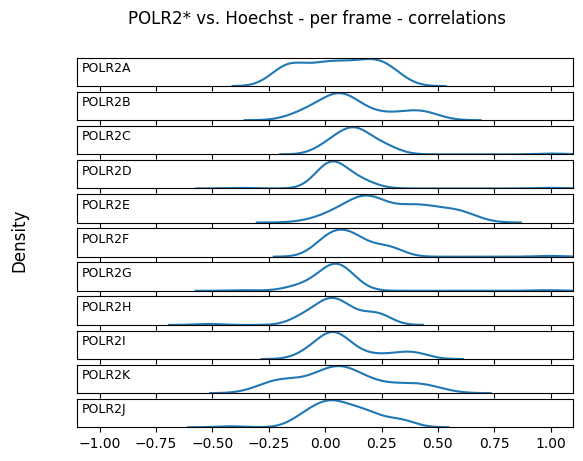

In [58]:
to_plot = {k : [y for x in v for y in x ][0] for k, v in corrs_shifted.items()}
fig, axes = plt.subplots(ncols=1, nrows=len(to_plot), sharex=True)

for i in range(len(corrs_shifted.keys())):
    k = list(to_plot.keys())[i]
    ax_to_use = axes[i]
    sns.kdeplot(x=to_plot[k], ax=ax_to_use, label=k)
    ax_to_use.set_ylabel("")
    ax_to_use.set_yticks([])
    ax_to_use.set_xlim((-1.1,1.1))
    ax_to_use.text(0.01,0.5, k, transform=ax_to_use.transAxes, size=9)

fig.supylabel("Density")
fig.suptitle("POLR2* vs. Hoechst - per frame - correlations")

In [28]:
import pickle
with open("pol_shifted_imgs.pickle", "wb") as output_file:
    pickle.dump(shifted_imgs, output_file)

## Correlation

In [12]:
corrs = {}
for k, (v0, v1, v2) in r.items():
    print(k)
    corrs[k] = hoechst_v_stain(v0, v1, fn = lambda a,b: scipy.stats.pearsonr(a,b)[0], norm=False,flatten=True,per_frame=True)

POLR2A
[[[[ 599  483  471 ...  438  512  548]
   [ 462  456  436 ...  449  466  574]
   [ 561  505  491 ...  584  518  474]
   ...
   [ 490  481  503 ...  417  530  469]
   [ 436  687  428 ...  631  533  702]
   [ 779  412  468 ...  593  515  621]]

  [[ 544  502  482 ...  492  521  395]
   [ 577  566  452 ...  564  519  507]
   [ 466  582  608 ...  458  472  551]
   ...
   [ 575  473  580 ...  653  397  414]
   [ 483  551  544 ...  394  481  467]
   [ 504  468  501 ...  394  582  645]]

  [[ 479  440  628 ...  480  608  674]
   [ 464  525  533 ...  443  594  582]
   [ 507  456  515 ...  503  577  586]
   ...
   [ 457  485  457 ...  624  418  481]
   [ 462  444  527 ...  478  606  456]
   [ 525  466  498 ...  545  427  671]]

  ...

  [[ 549  399  429 ...  597  479  632]
   [ 536  427  549 ...  530  616  462]
   [ 429  503  566 ...  512  415  451]
   ...
   [ 430  533  464 ...  616  457  508]
   [ 455  502  428 ...  441  798  458]
   [ 373  636  553 ...  535  486  590]]

  [[ 572  488 


KeyboardInterrupt



In [9]:
import pickle
with open("pol_corrs_perframe.pickle", "wb") as output_file:
    pickle.dump(corrs, output_file)

Text(0.5, 0.98, 'POLR2* vs. Hoechst - Pearson r')

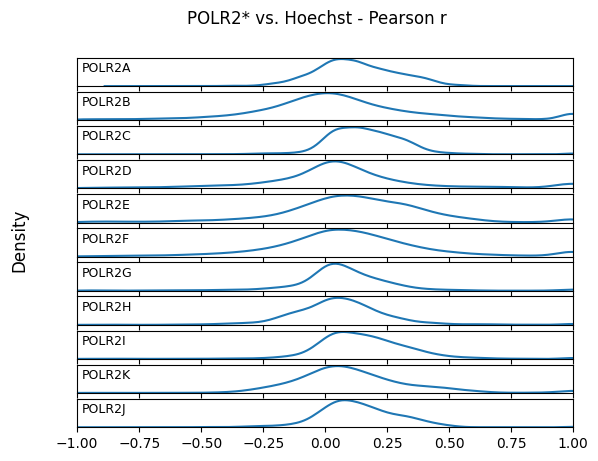

In [11]:
fig, axes = plt.subplots(ncols=1, nrows=len(corrs), sharex=True)

for i in range(len(corrs.keys())):
    k = list(corrs.keys())[i]
    ax_to_use = axes[i]
    sns.kdeplot(x=np.hstack(corrs[k]), ax=ax_to_use, label=k)
    ax_to_use.set_ylabel("")
    ax_to_use.set_yticks([])
    ax_to_use.set_xlim((-1,1))
    ax_to_use.text(0.01,0.5, k, transform=ax_to_use.transAxes, size=9)

fig.supylabel("Density")
fig.suptitle("POLR2* vs. Hoechst - Pearson r")